## A model build using TweetBERT to classify tweet as causal or non-causal 

The causal sentence prediction model will be trained in several steps using an active learning approach, where in each step the training dataset will be augmented.
In each step the causal sentence classifier is trained and applied on a subsample of unlabeled tweets to identify tweets with causal elements. Those tweets are then manually labeled for the two tasks: causal sentence prediction and cause-effect identification (NER). The newly labeled data will be added to the training dataset and the causal sentence classifier will be retrained with the augmented dataset to increase performance

In [1]:
import pandas as pd
import numpy as np
import spacy 
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import random
import os
import torch.nn.functional as F
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, SubsetRandomSampler
import transformers
from tqdm import tqdm, trange
import io
from utils import normalizeTweet, split_into_sentences, EarlyStopping
import matplotlib.pyplot as plt

########################### Check if cuda available ############################
# print("Cuda available: ", torch.cuda.is_available())
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



########################### DATA FILE ###################################
# dataPath = "/home/adrian/workspace/causality/Causal-associations-diabetes-twitter/data/Causality_tweets_data.xlsx"
dataPath = "data/Causality_tweets_data.xlsx"
#dataPath = "Causality_tweets_data.xlsx"


########################### MODEL PARAMETERS ############################
active_learning_round = 4 # will change the saved model name 
lr = 1e-5  
adam_eps = 1e-8
epochs = 50
num_warmup_steps = 0
early_patience = 10# how long to wait after last time validation loss improved

train_batch_size = 16
val_batch_size = 16
test_batch_size = 16
test_to_train_ratio = 0.1 # 10% test and 90% train
val_to_train_ratio = 0.2

metrics_average = "binary" # this will give measure for class_1,i.e., causal class
#
# saveModelName = "./model-causal-model/model_1_finetuned-{}-epochs-lr_{}.pth".format(epochs, lr) # it should be epoch so that the name shows at what epoch teh mdel ws saved
#finetuned_model = "./model-causal-model/model_3_finetuned-5-epochs-lr_0.001.pth" # load finetuned model from previous round to continue fine-tuning on new data

#### Checking if thec cuda is available and then select the `gpu`

In [2]:
########################### Check if cuda available ############################
print("Cuda available: ", torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Selected {} for this notebook".format(device))

Cuda available:  True
Selected cuda:0 for this notebook


In [3]:
##### DATA TO LOAD ######

data_round0 = pd.read_excel(dataPath, sheet_name="round0")
data_round0 = data_round0[data_round0["Causal association"].notnull()] # some tweets at the end are not labeled yet
data_round0 = data_round0[["full_text", "Intent", "Cause", "Effect", "Causal association"]]
print("Data round 0 (tweets!):")
print(data_round0["Causal association"].value_counts())
print("-----"*5)


##### additional data labeled through active learning strategy - round 1 ########
data_round1 = pd.read_excel(dataPath, sheet_name="round1")
data_round1 = data_round1[data_round1["Causal association"].notnull()]
data_round1 = data_round1[["sentence", "Intent", "Cause", "Effect", "Causal association"]]
data_round1.rename(columns ={"sentence":"full_text"}, inplace=True) # rename for merge
print("Sentences round 1:")
print(data_round1["Causal association"].value_counts())
print("-----"*5)

##### additional data labeled through active learning strategy - round 2 ########
data_round2 = pd.read_excel(dataPath, sheet_name="round2")
data_round2 = data_round2[data_round2["Causal association"].notnull()]
data_round2 = data_round2[["sentence", "Intent", "Cause", "Effect", "Causal association"]]
data_round2.rename(columns ={"sentence":"full_text"}, inplace=True) # rename for merge
print("sentences round 2:")
print(data_round2["Causal association"].value_counts())
print("-----"*5)

##### additional data labeled through active learning strategy - round 3 ########
data_round3 = pd.read_excel(dataPath, sheet_name="round3")
data_round3 = data_round3[data_round3["Causal association"].notnull()]
data_round3 = data_round3[["sentence", "Intent", "Cause", "Effect", "Causal association"]]
data_round3.rename(columns ={"sentence":"full_text"}, inplace=True) # rename for merge
print("sentences round 3:")
print(data_round3["Causal association"].value_counts())
print("-----"*5)

##### new additional data labeled through active learning strategy - round 4 (model is only retrained with this data) #####################
data_round4 = pd.read_excel(dataPath, sheet_name="round4")
data_round4 = data_round4[data_round4["Causal association"].notnull()]
data_round4 = data_round4[["sentence", "Intent", "Cause", "Effect", "Causal association"]]
data_round4.rename(columns ={"sentence":"full_text"}, inplace=True) # rename for merge
print("sentences round 4:")
print(data_round4["Causal association"].value_counts())

#### merge datasets ######
data = data_round0.append(data_round1).append(data_round2).append(data_round3).append(data_round4)
print("\nAfter merge old data:")
print(data["Causal association"].value_counts())
data.head()
print("-----"*5)


print("----"*5)
print("\n 0:non causal tweet \n 1: causal tweet.\n \n each tweet may have more than one sentence and we are splitting them and labelling by checking if cause or effect occur in them or not")

Data round 0 (tweets!):
0.0    3710
1.0    1290
Name: Causal association, dtype: int64
-------------------------
Sentences round 1:
0.0    1763
1.0     429
Name: Causal association, dtype: int64
-------------------------
sentences round 2:
0    1658
1     150
Name: Causal association, dtype: int64
-------------------------
sentences round 3:
0    1886
1     215
Name: Causal association, dtype: int64
-------------------------
sentences round 4:
0    1895
1     313
Name: Causal association, dtype: int64

After merge old data:
0.0    10912
1.0     2397
Name: Causal association, dtype: int64
-------------------------
--------------------

 0:non causal tweet 
 1: causal tweet.
 
 each tweet may have more than one sentence and we are splitting them and labelling by checking if cause or effect occur in them or not


### Preprocessing

In [4]:
def get_start_end_index_of_sentence_in_tweet(tweet, sentence):
    """ 
    The sentence tokens are included in the tweet tokens.
    Return the start end end indices of the sentence tokens in the tweet tokens

    """

    sentence_start_word = sentence[0]
    start_indices = [i for i, x in enumerate(tweet) if x == sentence_start_word] # find all indices of the start word of the sentence 
    try:
        for start_index in start_indices:
            isTrueStartIndex = all([tweet[start_index+i] == sentence[i] for i in range(len(sentence))])
            #print("start_index:", start_index, "isTrueStartIndex:", isTrueStartIndex)
            if isTrueStartIndex:
                return start_index, start_index + len(sentence) 
    except:
        print("ERROR: StartIndex should have been found for sentence:")
        print("tweet:")
        print(tweet)
        print("sentence:")
        print(sentence)
    return -1, -2 # should not be returned


def split_tweets_to_sentences(data):
    """ 
        Splits tweets into sentences and associates the appropriate intent, causes, effects and causal association
        to each sentence.
        
        Parameters:
        - min_words_in_sentences: Minimal number of words in a sentence such that the sentence is kept. 
                                  Assumption: A sentence with too few words does not have enough information
                              
                              
                              
        Ex.:
        full_text                              | Intent | Cause | Effect | Causal association | ...
        --------------------------------------------------------------------------------------------
        what? type 1 causes insulin dependence | q;msS  | type 1|insulin dependence | 1       | ...  
        
        New dataframe returned: 
        full_text                              | Intent | Cause | Effect | Causal association | ...
        --------------------------------------------------------------------------------------------
        what?                                  |   q    |       |        |       0            | ...
        type 1 causes insulin dependence       |        | type 1| insulin dependence | 1       | ...  
    """

    newDF = pd.DataFrame(columns=["sentence", "Intent", "Cause", "Effect", "Causal association", "tokenized"])
    
    for i,row in data.iterrows():
        causes = row["Cause"]
        effects = row["Effect"]
        sentences = split_into_sentences(normalizeTweet(row["full_text"]))
        
        # single sentence in tweet
        if len(sentences) == 1:
            singleSentenceIntent = ""
            if isinstance(row["Intent"], str):
                if len(row["Intent"].split(";")) > 1:
                    singleSentenceIntent = row["Intent"].strip().replace(";msS", "").replace("msS;", "").replace(";mS", "").replace("mS;", "")
                else:
                    if row["Intent"] == "mS" or row["Intent"] == "msS":
                        singleSentenceIntent = ""
                    else:
                        singleSentenceIntent = row["Intent"].strip()
                    
            newDF=newDF.append(pd.Series({"sentence": sentences[0] # only one sentence
                         , "Intent": singleSentenceIntent
                         , "Cause" : row["Cause"]
                         , "Effect": row["Effect"]
                         , "Causal association" : row["Causal association"]
                         , "tokenized": row["tokenized"]}), ignore_index=True)
        
        # tweet has several sentences
        else: 
            intents = str(row["Intent"]).strip().split(";")
            for sentence in sentences:
                sent_tokenized = sentence.split(" ")
                causeInSentence = np.nan if not isinstance(causes, str) or not any([cause in sentence for cause in causes.split(";")]) else ";".join([cause for cause in causes.split(";") if cause in sentence])
                effectInSentence = np.nan if not isinstance(effects, str) or not any([effect in sentence for effect in effects.split(";")]) else ";".join([effect for effect in effects.split(";") if effect in sentence])
                causalAssociationInSentence = 1 if isinstance(causeInSentence, str) and isinstance(effectInSentence, str) else 0
                startIndex, endIndex = get_start_end_index_of_sentence_in_tweet(row["tokenized"], sent_tokenized)
                sentence_tokenized = row["tokenized"][startIndex:endIndex]
                
                if "q" in intents and sentence[-1] == "?": # if current sentence is question
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "q", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)                    
                elif "joke" in intents: # all sentences with "joke" in tweet keep the intent "joke"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "joke", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)   
                elif "neg" in intents: # all sentences with "neg" in tweet keep intent "neg"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "neg", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)               
                elif isinstance(causeInSentence, str) and isinstance(effectInSentence, str): # cause effect sentence
                    causalIntent = ""
                    if len(causeInSentence.split(";")) > 1:
                        causalIntent = "mC"
                        if len(effectInSentence.split(";")) > 1:
                            causalIntent = "mC;mE"
                    elif len(effectInSentence.split(";")) > 1:
                        causalIntent = "mE"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": causalIntent, "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)                                  
                else:
                    nonCausalIntent = ""
                    if isinstance(causeInSentence, str): # only cause is given
                        if len(causeInSentence.split(";")) > 1:
                            nonCausalIntent = "mC"
                    elif isinstance(effectInSentence, str): # only effect is given
                        if len(effectInSentence.split(";")) > 1:
                            nonCausalIntent = "mE"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": nonCausalIntent, "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)

    return newDF

In [5]:
### Split tweets into sentences (train classifier on sentence level) ####

print("Count of tweets:", data.shape[0])

data["tokenized"] = data["full_text"].map(lambda tweet: normalizeTweet(tweet).split(" "))
dataSentences = split_tweets_to_sentences(data)
print("Count of sentences:", dataSentences.shape[0])

dataSentences.head()

Count of tweets: 13309
Count of sentences: 20065


,sentence,Intent,Cause,Effect,Causal association,tokenized
0,"tonight , I learned my older girl will back he...",,NaN,NaN,0,"[tonight, ,, I, learned, my, older, girl, will..."
1,Fiercely .,,NaN,NaN,0,"[Fiercely, .]"
2,#impressive #bigsister #type1 #type1times2,,NaN,NaN,0,"[#impressive, #bigsister, #type1, #type1times2]"
3,USER USER I knew diabetes and fibromyalgia wer...,joke,NaN,NaN,0,"[USER, USER, I, knew, diabetes, and, fibromyal..."
4,:face_with_rolling_eyes:,joke,NaN,NaN,0,[:face_with_rolling_eyes:]


In [6]:
########## Remove sentences with joke, question, negation and keep only sentences with more than 3 tokens #####

print("Count of sentences before filtering: ", dataSentences.shape[0])
dataSentFiltered = dataSentences[~dataSentences["Intent"].str.contains("neg|joke|q")] 
dataSentFiltered = dataSentFiltered[dataSentFiltered["tokenized"].map(len) > 3] 
print("Count of sentences after filtering: ", dataSentFiltered.shape[0])
print("Distribution:")
print("\n")
print(dataSentFiltered["Causal association"].value_counts())
dataSentFiltered.head()



Count of sentences before filtering:  20065
Count of sentences after filtering:  16475
Distribution:


0.0    14364
1.0     2111
Name: Causal association, dtype: int64


,sentence,Intent,Cause,Effect,Causal association,tokenized
0,"tonight , I learned my older girl will back he...",,NaN,NaN,0,"[tonight, ,, I, learned, my, older, girl, will..."
2,#impressive #bigsister #type1 #type1times2,,NaN,NaN,0,"[#impressive, #bigsister, #type1, #type1times2]"
5,:down_arrow: :down_arrow: :down_arrow: THIS :d...,,NaN,NaN,0,"[:down_arrow:, :down_arrow:, :down_arrow:, THI..."
6,I 'm a trans woman .,,NaN,NaN,0,"[I, 'm, a, trans, woman, .]"
7,"Both of us could use a world where "" brave and...",,NaN,NaN,0,"[Both, of, us, could, use, a, world, where, "",..."


### Data split and calculate class weight

In [ ]:
####################### Stratified splits ####################


## ONLY FOR TESTING ---------------
#dataSentFiltered = dataSentFiltered[0:500] # for testing

text = dataSentFiltered["sentence"].map(normalizeTweet).values.tolist()
labels = dataSentFiltered["Causal association"].values.tolist()

# first split the data into training and testing label in the ratio of 90:10
train_texts, test_texts, train_labels, test_labels = train_test_split(text, labels, test_size=test_to_train_ratio, stratify=labels, random_state=9)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=val_to_train_ratio, stratify=train_labels, random_state=9)

# Redefine training set:Take only new labeled tweets from round 3 for training; test and val set come from old data
#train_texts = dataSentFiltered_new["sentence"].map(normalizeTweet).values.tolist()
#train_labels = dataSentFiltered_new["Causal association"].values.tolist()

#labels = train_labels + val_labels +test_labels # combining new train with validataion and test data from previous rounds


data_count_info = pd.Series(labels).value_counts(normalize=True)
train_count_info = pd.Series(train_labels).value_counts(normalize=True)
val_count_info = pd.Series(val_labels).value_counts(normalize=True)
test_count_info = pd.Series(test_labels).value_counts(normalize=True)

# for class-imbalanced dataset, the class weight for a ith class
# to be specified for balancing in the loss function is given by:
# weight[i] = num_samples / (num_classes * num_samples[i])
# since train_count_info obtained above has fraction of samples
# for ith class, hence the corresponding weight calculation is:
class_weight = (1/train_count_info)/len(train_count_info)

print("All: Count = {}, % of 0 = {}, % of 1 = {}".format(len(labels), *data_count_info.round(4).to_list()))
print("\n")
print("Train: Count = {}, % of 0 = {}, % of 1 = {}".format(len(train_labels), *train_count_info.round(4).to_list()))
print("\n")
print("Val: Count = {}, % of 0 = {}, % of 1 = {}".format(len(val_labels), *val_count_info.round(4).to_list()))
print("\n")
print("Test: Count = {}, % of 0 = {}, % of 1 = {}".format(len(test_labels), *test_count_info.round(4).to_list()))
print("\n")
print("Balancing class wts: for 0 = {}, for 1 = {}".format(*class_weight.round(4).to_list()))
print("\n")




#### Defining our DataLoader 

In [8]:
class TweetDataSet(torch.utils.data.Dataset):
    def __init__(self, text, labels, tokenizer):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        inputs = self.tokenizer(self.text, padding=True, truncation=True, return_token_type_ids=True)
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        return {
                "input_ids" : torch.tensor(ids[idx], dtype=torch.long)
              , "attention_mask" : torch.tensor(mask[idx], dtype=torch.long)
              , "token_type_ids" : torch.tensor(token_type_ids[idx], dtype=torch.long)
              , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
        }      

    def __len__(self):
        return len(self.labels)

    
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

train_dataset = TweetDataSet(train_texts, train_labels, tokenizer)
val_dataset = TweetDataSet(val_texts, val_labels, tokenizer)
test_dataset = TweetDataSet(test_texts, test_labels, tokenizer)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# During training: In each epoch one part of the training data will be used as validation set
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


11861
2966
1648


### Evaluation Metrics

In [9]:
## we are measuring weighted metrics - as our dataset is imbalanced 
# Calculate metrics for each label, and find their average weighted by support
# (the number of true instances for each label). 
# This alters ‘macro’ to account for label imbalance; 
# it can result in an F-score that is not between precision and recall.


from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef

def compute_metrics(pred, labels):
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='weighted')
    precision, recall, f1, _ = precision_recall_fscore_support(labels,pred, average=metrics_average)
    acc = accuracy_score(labels, pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



### Model defintion

In [10]:


class CausalityBERT(torch.nn.Module):
    """ Model Bert"""
    def __init__(self):
        super(CausalityBERT, self).__init__()
        self.num_labels = 2
        self.bert = transformers.BertModel.from_pretrained("vinai/bertweet-base")
        self.dropout = torch.nn.Dropout(0.3)
        self.linear1 = torch.nn.Linear(768, 256)
        self.linear2 = torch.nn.Linear(256, self.num_labels)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output_1 = self.bert(input_ids, attention_mask = attention_mask, token_type_ids=token_type_ids, return_dict=False) # if output 1 is our cls token        
        output_2 = self.dropout(output_1)
        output_3 = self.linear1(output_2)  
        output_4 = self.dropout(output_3)
        output_5 = self.linear2(output_4)
        return output_5

### Moving the model to  GPU and defining training parameters: 
    * num_training_steps 
    * optimizers 
    * scheduler 
    * loss function (weighted) 

In [11]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = CausalityBERT() ## just load the model trained in previous round here 
#model.load_state_dict(torch.load(finetuned_model, map_location='cpu')) # load model trained in previous round
model.to(device)

# fine-tune only the task-specific parameters
for param in model.bert.parameters():
    param.requires_grad = False

num_training_steps = np.ceil(len(train_dataset)/train_batch_size)*epochs
optim = AdamW(model.parameters(), lr=lr, eps=adam_eps)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps) # scheduler with a linearly decreasing learning rate from the initial lr set in the optimizer to 0; after a warmup period durnig which it increases linearly from 0 to the initial lr set in the optimizer

## penalising more for class with less number of exaplmes 
loss_fn = CrossEntropyLoss(torch.tensor(class_weight.to_list()).to(device))

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertModel: ['roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.11.attention.output.dense.bias', 'roberta.encoder.layer.4.attention.self.value.weight', 'roberta.encoder.layer.9.attention.self.query.bias', 'roberta.encoder.layer.1.output.dense.weight', 'roberta.encoder.layer.9.attention.output.dense.bias', 'roberta.encoder.layer.0.intermediate.dense.weight', 'roberta.encoder.layer.8.attention.self.key.weight', 'roberta.encoder.layer.5.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.1.output.dense.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.9.attention.self.key.bias

### Training (fine-tuning) with Validation and early stopping 

In [12]:
############ TRAINING #############

# initialise the early_stopping object
# early_stopping = EarlyStopping(patience=early_patience, path=saveModelName, verbose=True)
early_stopping = EarlyStopping(patience=early_patience,verbose=True)


train_avg_loss = [] # avg training loss per epoch
val_avg_loss = [] # avg validation loss per epoch
train_avg_acc = [] # avg training accuracy per epoch
val_avg_acc = [] # avg val accuracy per epoch
n_trained_epochs = 0


for epoch in trange(1, epochs+1, desc='Epoch'):
    print("<" + "="*22 + F" Epoch {epoch} "+ "="*22 + ">")
    
    
    ########### training eval metrics #############################
    train_accuracy = []
    train_loss = []
    train_acc = []
    train_prec = []
    train_rec = []
    train_f1 = []
    
    ###################################################
    
    for batch in tqdm(train_loader):
        optim.zero_grad() # gradients get accumulated by default -> clear previous accumulated gradients
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch['labels'].to(device)
        ###########################################################################
        model.train()
        logits = model(**{"input_ids":input_ids, "attention_mask":attention_mask, "token_type_ids":token_type_ids}) # forward pass
        #############################################################################
        loss = loss_fn(logits, labels)
        print("loss:", loss)
        loss.backward() # backward pass
        optim.step()    # update parameters and take a step up using the computed gradient
        scheduler.step()# update learning rate scheduler
        train_loss.append(loss.item())
        
    
        ############# Training Accuracy Measure ###################################

        # move logits and labels to CPU
        logits = logits.detach().to('cpu').numpy()
        label_ids = labels.to('cpu').numpy()

        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()

        metrics = compute_metrics(pred_flat, labels_flat)        
        
        train_acc.append(metrics["accuracy"])
        train_prec.append(metrics["precision"])
        train_rec.append(metrics["recall"])
        train_f1.append(metrics["f1"])
        
    train_avg_loss.append(np.mean(train_loss))
    train_avg_acc.append(np.mean(train_acc))
    print(F'\n\tTrain loss: {np.mean(train_loss)}')
    print(F'\n\ttrain acc: {np.mean(train_acc)}')
    print(F'\n\ttraining prec: {np.mean(train_prec)}')
    print(F'\n\ttraining rec: {np.mean(train_rec)}')
    print(F'\n\ttraining f1: {np.mean(train_f1)}')
    
    n_trained_epochs += 1
    
    ###################################################################################

    
    ## ---- Validation ------
    val_accuracy = []
    val_loss = []
    val_acc = []
    val_prec = []
    val_rec = []
    val_f1 = []
    
    
    # Evaluate data for one epoch
    for batch in tqdm(validation_loader):
        batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
        b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch     # unpack inputs from dataloader
        
        with torch.no_grad(): # tell model not to compute or store gradients -> saves memory + speeds up validation
            ##################################################################################
            model.eval()
            logits = model(**{"input_ids":b_input_ids, "attention_mask":b_input_mask, "token_type_ids":b_token_type_ids}) # forward pass, calculates logit predictions 

                        
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        
        # move logits and labels to CPU
        logits = logits.detach().to('cpu').numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        
        metrics = compute_metrics(pred_flat, labels_flat)
        val_acc.append(metrics["accuracy"])
        val_prec.append(metrics["precision"])
        val_rec.append(metrics["recall"])
        val_f1.append(metrics["f1"])

    val_avg_loss.append(np.mean(val_loss))
    val_avg_acc.append(np.mean(val_acc))
    print(F'\n\tValidation loss: {np.mean(val_loss)}')
    print(F'\n\tValidation acc: {np.mean(val_acc)}')
    print(F'\n\tValidation prec: {np.mean(val_prec)}')
    print(F'\n\tValidation rec: {np.mean(val_rec)}')
    print(F'\n\tValidation f1: {np.mean(val_f1)}')

    # early_stopping needs the validation loss to check if it has decreased,
    # and if it has, it will make a checkpoint of the current model
    saveModelName = "./model-causal-model/model_{}_finetuned-{}-epochs-lr_{}.pth".format(active_learning_round,n_trained_epochs-early_patience, lr) 
    early_stopping.path = saveModelName
    early_stopping(np.average(val_loss), model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

<====================== Epoch 1 ======================>



  0%|          | 0/742 [00:00<?, ?it/s]<ipython-input-8-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 1/742 [00:13<2:45:27, 13.40s/it]

loss: tensor(0.6610, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 2/742 [00:25<2:37:22, 12.76s/it]

loss: tensor(0.7680, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 3/742 [00:38<2:34:38, 12.56s/it]

loss: tensor(0.7356, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 4/742 [00:50<2:32:25, 12.39s/it]

loss: tensor(0.6887, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 5/742 [01:02<2:32:07, 12.38s/it]

loss: tensor(0.4750, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 6/742 [01:14<2:31:26, 12.35s/it]

loss: tensor(1.3898, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 7/742 [01:27<2:30:44, 12.31s/it]

loss: tensor(1.2049, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 8/742 [01:39<2:29:33, 12.23s/it]

loss: tensor(0.2784, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 9/742 [01:50<2:27:46, 12.10s/it]

loss: tensor(0.5750, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 10/742 [02:02<2:26:15, 11.99s/it]

loss: tensor(0.3154, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 11/742 [02:14<2:25:59, 11.98s/it]

loss: tensor(0.6234, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 12/742 [02:26<2:24:42, 11.89s/it]

loss: tensor(1.0654, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 13/742 [02:37<2:23:10, 11.78s/it]

loss: tensor(0.8261, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 14/742 [02:49<2:22:42, 11.76s/it]

loss: tensor(0.5898, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 15/742 [03:01<2:23:16, 11.82s/it]

loss: tensor(0.6606, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 16/742 [03:13<2:23:14, 11.84s/it]

loss: tensor(0.8508, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 17/742 [03:24<2:21:59, 11.75s/it]

loss: tensor(0.7015, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 18/742 [03:36<2:21:23, 11.72s/it]

loss: tensor(0.6762, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 19/742 [03:48<2:20:52, 11.69s/it]

loss: tensor(0.6998, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 20/742 [03:59<2:20:32, 11.68s/it]

loss: tensor(0.7678, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 21/742 [04:11<2:19:52, 11.64s/it]

loss: tensor(0.6388, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 22/742 [04:22<2:19:15, 11.61s/it]

loss: tensor(0.6431, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 23/742 [04:34<2:19:12, 11.62s/it]

loss: tensor(0.8269, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 24/742 [04:46<2:18:57, 11.61s/it]

loss: tensor(0.6594, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 25/742 [04:57<2:18:44, 11.61s/it]

loss: tensor(0.7459, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 26/742 [05:09<2:17:59, 11.56s/it]

loss: tensor(0.5034, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 27/742 [05:20<2:17:50, 11.57s/it]

loss: tensor(0.9154, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 28/742 [05:32<2:17:36, 11.56s/it]

loss: tensor(0.8307, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 29/742 [05:43<2:17:31, 11.57s/it]

loss: tensor(0.3937, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 30/742 [05:55<2:16:56, 11.54s/it]

loss: tensor(0.5589, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 31/742 [06:06<2:16:37, 11.53s/it]

loss: tensor(0.7269, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 32/742 [06:18<2:16:27, 11.53s/it]

loss: tensor(0.6903, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 33/742 [06:30<2:16:34, 11.56s/it]

loss: tensor(0.7507, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 34/742 [06:41<2:16:07, 11.54s/it]

loss: tensor(0.7399, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 35/742 [06:53<2:16:25, 11.58s/it]

loss: tensor(0.7805, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 36/742 [07:05<2:17:21, 11.67s/it]

loss: tensor(0.5596, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 37/742 [07:17<2:17:51, 11.73s/it]

loss: tensor(0.8123, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 38/742 [07:28<2:18:10, 11.78s/it]

loss: tensor(0.5731, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 39/742 [07:40<2:18:19, 11.81s/it]

loss: tensor(0.5646, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 40/742 [07:52<2:18:32, 11.84s/it]

loss: tensor(0.7045, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 41/742 [08:04<2:18:17, 11.84s/it]

loss: tensor(0.6893, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 42/742 [08:16<2:18:17, 11.85s/it]

loss: tensor(1.0329, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 43/742 [08:28<2:18:50, 11.92s/it]

loss: tensor(0.5978, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 44/742 [08:40<2:19:00, 11.95s/it]

loss: tensor(0.4296, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 45/742 [08:52<2:17:51, 11.87s/it]

loss: tensor(0.8082, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 46/742 [09:03<2:16:58, 11.81s/it]

loss: tensor(0.7434, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 47/742 [09:15<2:16:36, 11.79s/it]

loss: tensor(0.6250, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 48/742 [09:27<2:15:58, 11.76s/it]

loss: tensor(1.0558, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 49/742 [09:38<2:15:30, 11.73s/it]

loss: tensor(0.5010, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 50/742 [09:50<2:15:05, 11.71s/it]

loss: tensor(0.8158, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 51/742 [10:02<2:14:53, 11.71s/it]

loss: tensor(0.5932, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 52/742 [10:13<2:14:31, 11.70s/it]

loss: tensor(0.4737, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 53/742 [10:25<2:14:49, 11.74s/it]

loss: tensor(0.5407, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 54/742 [10:37<2:14:42, 11.75s/it]

loss: tensor(0.4753, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 55/742 [10:49<2:14:45, 11.77s/it]

loss: tensor(0.9973, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 56/742 [11:01<2:14:23, 11.75s/it]

loss: tensor(0.4977, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 57/742 [11:13<2:14:36, 11.79s/it]

loss: tensor(1.1020, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 58/742 [11:24<2:14:38, 11.81s/it]

loss: tensor(1.1288, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 59/742 [11:36<2:14:11, 11.79s/it]

loss: tensor(0.6764, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 60/742 [11:48<2:14:15, 11.81s/it]

loss: tensor(0.6965, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 61/742 [12:00<2:13:41, 11.78s/it]

loss: tensor(0.6746, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 62/742 [12:12<2:13:47, 11.80s/it]

loss: tensor(0.6923, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 63/742 [12:23<2:13:22, 11.79s/it]

loss: tensor(0.6950, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▊         | 64/742 [12:35<2:12:58, 11.77s/it]

loss: tensor(1.1782, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 65/742 [12:47<2:12:28, 11.74s/it]

loss: tensor(0.7997, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 66/742 [12:58<2:12:24, 11.75s/it]

loss: tensor(1.1758, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 67/742 [13:10<2:12:26, 11.77s/it]

loss: tensor(1.0387, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 68/742 [13:22<2:12:21, 11.78s/it]

loss: tensor(0.5070, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 69/742 [13:34<2:12:18, 11.80s/it]

loss: tensor(0.7761, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 70/742 [13:46<2:11:24, 11.73s/it]

loss: tensor(0.7109, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 71/742 [13:57<2:11:18, 11.74s/it]

loss: tensor(0.1975, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 72/742 [14:09<2:11:27, 11.77s/it]

loss: tensor(0.9484, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 73/742 [14:21<2:11:30, 11.79s/it]

loss: tensor(1.6279, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 74/742 [14:33<2:11:05, 11.77s/it]

loss: tensor(1.1899, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 75/742 [14:44<2:11:01, 11.79s/it]

loss: tensor(0.1650, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 76/742 [14:56<2:10:45, 11.78s/it]

loss: tensor(0.6014, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 77/742 [15:08<2:10:44, 11.80s/it]

loss: tensor(0.5064, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 78/742 [15:20<2:10:41, 11.81s/it]

loss: tensor(0.7928, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 79/742 [15:32<2:10:03, 11.77s/it]

loss: tensor(0.6746, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 80/742 [15:43<2:09:12, 11.71s/it]

loss: tensor(0.7834, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 81/742 [15:55<2:08:49, 11.69s/it]

loss: tensor(0.4922, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 82/742 [16:07<2:08:45, 11.71s/it]

loss: tensor(0.8385, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 83/742 [16:18<2:07:51, 11.64s/it]

loss: tensor(0.6588, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 84/742 [16:30<2:07:16, 11.61s/it]

loss: tensor(0.8964, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 85/742 [16:41<2:06:46, 11.58s/it]

loss: tensor(0.5715, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 86/742 [16:53<2:06:33, 11.57s/it]

loss: tensor(0.7715, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 87/742 [17:04<2:06:31, 11.59s/it]

loss: tensor(0.9124, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 88/742 [17:16<2:06:35, 11.61s/it]

loss: tensor(0.5993, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 89/742 [17:28<2:06:29, 11.62s/it]

loss: tensor(0.7576, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 90/742 [17:39<2:06:10, 11.61s/it]

loss: tensor(0.5962, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 91/742 [17:51<2:05:56, 11.61s/it]

loss: tensor(0.5873, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 92/742 [18:02<2:05:22, 11.57s/it]

loss: tensor(0.5929, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 93/742 [18:14<2:05:14, 11.58s/it]

loss: tensor(0.7990, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 94/742 [18:25<2:04:50, 11.56s/it]

loss: tensor(0.6555, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 95/742 [18:37<2:05:01, 11.59s/it]

loss: tensor(0.4918, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 96/742 [18:49<2:04:43, 11.58s/it]

loss: tensor(0.3773, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 97/742 [19:00<2:04:48, 11.61s/it]

loss: tensor(0.6615, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 98/742 [19:12<2:04:54, 11.64s/it]

loss: tensor(0.8842, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 99/742 [19:24<2:04:51, 11.65s/it]

loss: tensor(0.6868, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 100/742 [19:35<2:04:27, 11.63s/it]

loss: tensor(0.5419, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 101/742 [19:47<2:04:16, 11.63s/it]

loss: tensor(0.9326, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 102/742 [19:59<2:04:14, 11.65s/it]

loss: tensor(0.5924, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 103/742 [20:10<2:04:08, 11.66s/it]

loss: tensor(0.5858, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 104/742 [20:22<2:03:58, 11.66s/it]

loss: tensor(0.5854, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 105/742 [20:33<2:03:28, 11.63s/it]

loss: tensor(0.4764, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 106/742 [20:45<2:03:29, 11.65s/it]

loss: tensor(0.6109, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 107/742 [20:57<2:03:23, 11.66s/it]

loss: tensor(0.6632, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 108/742 [21:09<2:03:25, 11.68s/it]

loss: tensor(0.6954, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 109/742 [21:20<2:02:56, 11.65s/it]

loss: tensor(0.6579, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 110/742 [21:32<2:02:47, 11.66s/it]

loss: tensor(0.6324, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 111/742 [21:44<2:02:49, 11.68s/it]

loss: tensor(0.6524, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 112/742 [21:55<2:02:48, 11.70s/it]

loss: tensor(0.5484, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 113/742 [22:07<2:02:18, 11.67s/it]

loss: tensor(0.6323, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 114/742 [22:18<2:01:48, 11.64s/it]

loss: tensor(0.6733, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 115/742 [22:30<2:01:14, 11.60s/it]

loss: tensor(0.4454, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 116/742 [22:42<2:00:57, 11.59s/it]

loss: tensor(0.6160, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 117/742 [22:53<2:00:51, 11.60s/it]

loss: tensor(0.4695, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 118/742 [23:05<2:00:19, 11.57s/it]

loss: tensor(0.7162, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 119/742 [23:16<2:00:01, 11.56s/it]

loss: tensor(0.5855, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 120/742 [23:28<1:59:49, 11.56s/it]

loss: tensor(0.3844, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 121/742 [23:39<1:59:37, 11.56s/it]

loss: tensor(0.7308, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 122/742 [23:51<1:59:33, 11.57s/it]

loss: tensor(0.8017, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 123/742 [24:02<1:58:56, 11.53s/it]

loss: tensor(0.5287, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 124/742 [24:14<1:58:43, 11.53s/it]

loss: tensor(0.6674, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 125/742 [24:25<1:58:33, 11.53s/it]

loss: tensor(0.6564, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 126/742 [24:37<1:58:35, 11.55s/it]

loss: tensor(0.6832, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 127/742 [24:48<1:58:08, 11.53s/it]

loss: tensor(0.8119, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 128/742 [25:00<1:58:03, 11.54s/it]

loss: tensor(0.6625, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 129/742 [25:12<1:58:01, 11.55s/it]

loss: tensor(0.5747, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 130/742 [25:23<1:57:52, 11.56s/it]

loss: tensor(0.4861, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 131/742 [25:35<1:57:27, 11.53s/it]

loss: tensor(0.6576, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 132/742 [25:46<1:57:22, 11.55s/it]

loss: tensor(0.6581, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 133/742 [25:58<1:57:11, 11.55s/it]

loss: tensor(0.6849, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 134/742 [26:09<1:57:05, 11.55s/it]

loss: tensor(0.8252, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 135/742 [26:21<1:56:43, 11.54s/it]

loss: tensor(0.6668, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 136/742 [26:32<1:56:43, 11.56s/it]

loss: tensor(0.8128, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 137/742 [26:44<1:56:39, 11.57s/it]

loss: tensor(0.6662, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 138/742 [26:56<1:56:31, 11.58s/it]

loss: tensor(0.5752, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 139/742 [27:07<1:56:29, 11.59s/it]

loss: tensor(0.6361, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 140/742 [27:19<1:56:54, 11.65s/it]

loss: tensor(0.5740, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 141/742 [27:31<1:57:42, 11.75s/it]

loss: tensor(0.2843, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 142/742 [27:43<1:57:46, 11.78s/it]

loss: tensor(0.9377, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 143/742 [27:55<1:57:54, 11.81s/it]

loss: tensor(1.0129, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 144/742 [28:06<1:57:21, 11.78s/it]

loss: tensor(0.6158, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 145/742 [28:18<1:57:02, 11.76s/it]

loss: tensor(0.5304, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 146/742 [28:30<1:56:46, 11.76s/it]

loss: tensor(0.5221, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 147/742 [28:42<1:56:35, 11.76s/it]

loss: tensor(0.7652, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 148/742 [28:53<1:56:24, 11.76s/it]

loss: tensor(0.5415, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 149/742 [29:05<1:55:49, 11.72s/it]

loss: tensor(0.7290, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 150/742 [29:17<1:55:40, 11.72s/it]

loss: tensor(0.8351, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 151/742 [29:29<1:55:35, 11.73s/it]

loss: tensor(0.6967, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 152/742 [29:40<1:55:31, 11.75s/it]

loss: tensor(0.7544, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 153/742 [29:52<1:55:02, 11.72s/it]

loss: tensor(0.9249, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 154/742 [30:04<1:54:50, 11.72s/it]

loss: tensor(0.8283, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 155/742 [30:15<1:54:40, 11.72s/it]

loss: tensor(0.7116, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 156/742 [30:27<1:54:41, 11.74s/it]

loss: tensor(0.4892, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 157/742 [30:39<1:54:09, 11.71s/it]

loss: tensor(0.4741, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 158/742 [30:51<1:53:59, 11.71s/it]

loss: tensor(0.5461, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 159/742 [31:02<1:53:55, 11.73s/it]

loss: tensor(0.4617, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 160/742 [31:14<1:53:46, 11.73s/it]

loss: tensor(0.4291, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 161/742 [31:26<1:53:47, 11.75s/it]

loss: tensor(0.7039, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 162/742 [31:38<1:53:25, 11.73s/it]

loss: tensor(0.5321, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 163/742 [31:49<1:53:08, 11.72s/it]

loss: tensor(0.5648, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 164/742 [32:01<1:52:57, 11.73s/it]

loss: tensor(0.6468, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 165/742 [32:13<1:52:49, 11.73s/it]

loss: tensor(0.7894, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 166/742 [32:24<1:52:27, 11.71s/it]

loss: tensor(0.5543, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 167/742 [32:36<1:52:26, 11.73s/it]

loss: tensor(1.1015, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 168/742 [32:48<1:52:10, 11.73s/it]

loss: tensor(0.5485, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 169/742 [33:00<1:52:02, 11.73s/it]

loss: tensor(0.6355, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 170/742 [33:11<1:51:58, 11.75s/it]

loss: tensor(0.8579, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 171/742 [33:23<1:51:38, 11.73s/it]

loss: tensor(0.7326, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 172/742 [33:35<1:51:34, 11.75s/it]

loss: tensor(0.4308, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 173/742 [33:47<1:51:41, 11.78s/it]

loss: tensor(0.9616, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 174/742 [33:59<1:51:53, 11.82s/it]

loss: tensor(0.3471, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 175/742 [34:11<1:51:36, 11.81s/it]

loss: tensor(0.5970, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 176/742 [34:22<1:51:42, 11.84s/it]

loss: tensor(0.5374, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 177/742 [34:34<1:51:40, 11.86s/it]

loss: tensor(1.0615, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 178/742 [34:46<1:51:32, 11.87s/it]

loss: tensor(0.8837, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 179/742 [34:58<1:50:57, 11.83s/it]

loss: tensor(0.5040, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 180/742 [35:10<1:50:33, 11.80s/it]

loss: tensor(0.5656, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 181/742 [35:22<1:50:27, 11.81s/it]

loss: tensor(0.5585, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 182/742 [35:33<1:50:20, 11.82s/it]

loss: tensor(0.7238, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 183/742 [35:45<1:50:13, 11.83s/it]

loss: tensor(0.9505, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 184/742 [35:57<1:49:38, 11.79s/it]

loss: tensor(0.5357, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 185/742 [36:09<1:49:37, 11.81s/it]

loss: tensor(0.5747, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 186/742 [36:21<1:49:39, 11.83s/it]

loss: tensor(0.4376, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 187/742 [36:33<1:49:33, 11.84s/it]

loss: tensor(0.7787, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 188/742 [36:44<1:49:03, 11.81s/it]

loss: tensor(0.8975, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 189/742 [36:56<1:48:53, 11.81s/it]

loss: tensor(0.8104, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 190/742 [37:08<1:48:44, 11.82s/it]

loss: tensor(0.7427, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 191/742 [37:20<1:48:42, 11.84s/it]

loss: tensor(0.5105, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 192/742 [37:32<1:48:25, 11.83s/it]

loss: tensor(0.4876, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 193/742 [37:43<1:48:15, 11.83s/it]

loss: tensor(0.7075, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 194/742 [37:55<1:47:46, 11.80s/it]

loss: tensor(0.5641, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 195/742 [38:07<1:47:25, 11.78s/it]

loss: tensor(1.0103, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 196/742 [38:19<1:47:09, 11.78s/it]

loss: tensor(0.2609, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 197/742 [38:30<1:46:33, 11.73s/it]

loss: tensor(0.5741, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 198/742 [38:42<1:46:17, 11.72s/it]

loss: tensor(0.5813, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 199/742 [38:54<1:45:49, 11.69s/it]

loss: tensor(0.9533, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 200/742 [39:05<1:45:29, 11.68s/it]

loss: tensor(0.3023, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 201/742 [39:17<1:45:22, 11.69s/it]

loss: tensor(0.4479, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 202/742 [39:29<1:44:53, 11.65s/it]

loss: tensor(0.3363, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 203/742 [39:40<1:44:45, 11.66s/it]

loss: tensor(0.6121, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 204/742 [39:52<1:44:38, 11.67s/it]

loss: tensor(0.7010, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 205/742 [40:04<1:44:27, 11.67s/it]

loss: tensor(0.4709, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 206/742 [40:15<1:43:54, 11.63s/it]

loss: tensor(0.7274, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 207/742 [40:27<1:43:37, 11.62s/it]

loss: tensor(0.7284, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 208/742 [40:38<1:43:24, 11.62s/it]

loss: tensor(0.5755, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 209/742 [40:50<1:43:09, 11.61s/it]

loss: tensor(0.5642, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 210/742 [41:02<1:43:02, 11.62s/it]

loss: tensor(0.5386, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 211/742 [41:13<1:43:00, 11.64s/it]

loss: tensor(0.6105, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 212/742 [41:25<1:43:05, 11.67s/it]

loss: tensor(0.5651, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 213/742 [41:37<1:43:07, 11.70s/it]

loss: tensor(0.6841, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 214/742 [41:48<1:42:43, 11.67s/it]

loss: tensor(0.6743, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 215/742 [42:00<1:42:38, 11.69s/it]

loss: tensor(0.4058, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 216/742 [42:12<1:42:36, 11.70s/it]

loss: tensor(0.7525, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 217/742 [42:24<1:42:25, 11.71s/it]

loss: tensor(0.5631, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 218/742 [42:35<1:42:21, 11.72s/it]

loss: tensor(0.7369, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 219/742 [42:47<1:41:50, 11.68s/it]

loss: tensor(0.9628, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 220/742 [42:59<1:41:43, 11.69s/it]

loss: tensor(0.7628, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 221/742 [43:10<1:41:35, 11.70s/it]

loss: tensor(0.4980, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 222/742 [43:22<1:41:29, 11.71s/it]

loss: tensor(0.8882, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 223/742 [43:34<1:40:41, 11.64s/it]

loss: tensor(0.4291, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 224/742 [43:45<1:40:18, 11.62s/it]

loss: tensor(0.5014, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 225/742 [43:57<1:40:18, 11.64s/it]

loss: tensor(0.8473, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 226/742 [44:09<1:40:15, 11.66s/it]

loss: tensor(0.5160, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 227/742 [44:20<1:40:12, 11.67s/it]

loss: tensor(0.9751, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 228/742 [44:32<1:39:48, 11.65s/it]

loss: tensor(0.5455, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 229/742 [44:43<1:39:15, 11.61s/it]

loss: tensor(0.8177, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 230/742 [44:55<1:38:59, 11.60s/it]

loss: tensor(1.0009, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 231/742 [45:07<1:38:50, 11.61s/it]

loss: tensor(0.4845, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 232/742 [45:18<1:38:16, 11.56s/it]

loss: tensor(0.6823, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 233/742 [45:30<1:38:00, 11.55s/it]

loss: tensor(0.5317, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 234/742 [45:41<1:37:46, 11.55s/it]

loss: tensor(0.9059, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 235/742 [45:53<1:37:37, 11.55s/it]

loss: tensor(0.5731, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 236/742 [46:04<1:37:33, 11.57s/it]

loss: tensor(0.7780, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 237/742 [46:16<1:36:59, 11.52s/it]

loss: tensor(0.5124, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 238/742 [46:27<1:36:49, 11.53s/it]

loss: tensor(0.4943, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 239/742 [46:39<1:36:40, 11.53s/it]

loss: tensor(0.5529, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 240/742 [46:50<1:36:44, 11.56s/it]

loss: tensor(0.7003, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 241/742 [47:02<1:36:21, 11.54s/it]

loss: tensor(0.4638, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 242/742 [47:13<1:36:09, 11.54s/it]

loss: tensor(0.7658, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 243/742 [47:25<1:36:12, 11.57s/it]

loss: tensor(0.7250, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 244/742 [47:37<1:36:08, 11.58s/it]

loss: tensor(0.8664, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 245/742 [47:48<1:36:03, 11.60s/it]

loss: tensor(0.6885, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 246/742 [48:00<1:36:02, 11.62s/it]

loss: tensor(0.5987, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 247/742 [48:12<1:35:46, 11.61s/it]

loss: tensor(0.4847, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 248/742 [48:23<1:35:40, 11.62s/it]

loss: tensor(0.6167, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 249/742 [48:35<1:35:33, 11.63s/it]

loss: tensor(0.6136, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 250/742 [48:46<1:35:11, 11.61s/it]

loss: tensor(0.4914, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 251/742 [48:58<1:35:04, 11.62s/it]

loss: tensor(0.7865, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 252/742 [49:10<1:34:53, 11.62s/it]

loss: tensor(0.7488, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 253/742 [49:21<1:34:28, 11.59s/it]

loss: tensor(0.4521, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 254/742 [49:33<1:33:53, 11.54s/it]

loss: tensor(0.5672, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 255/742 [49:44<1:33:41, 11.54s/it]

loss: tensor(0.7326, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 256/742 [49:56<1:33:32, 11.55s/it]

loss: tensor(0.5078, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 257/742 [50:07<1:33:16, 11.54s/it]

loss: tensor(1.0995, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 258/742 [50:19<1:32:53, 11.51s/it]

loss: tensor(0.4165, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 259/742 [50:30<1:33:00, 11.55s/it]

loss: tensor(0.7787, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 260/742 [50:42<1:33:07, 11.59s/it]

loss: tensor(0.4507, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 261/742 [50:54<1:33:08, 11.62s/it]

loss: tensor(0.8009, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 262/742 [51:05<1:32:40, 11.58s/it]

loss: tensor(0.3462, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 263/742 [51:17<1:31:58, 11.52s/it]

loss: tensor(0.6775, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 264/742 [51:28<1:31:44, 11.52s/it]

loss: tensor(1.2277, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 265/742 [51:40<1:31:34, 11.52s/it]

loss: tensor(0.4531, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 266/742 [51:51<1:31:26, 11.53s/it]

loss: tensor(0.4827, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 267/742 [52:03<1:30:58, 11.49s/it]

loss: tensor(0.4671, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 268/742 [52:14<1:30:50, 11.50s/it]

loss: tensor(0.4589, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 269/742 [52:26<1:30:46, 11.52s/it]

loss: tensor(0.3106, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 270/742 [52:37<1:30:54, 11.56s/it]

loss: tensor(0.6316, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 271/742 [52:49<1:30:45, 11.56s/it]

loss: tensor(0.3158, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 272/742 [53:00<1:30:40, 11.58s/it]

loss: tensor(0.6125, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 273/742 [53:12<1:31:29, 11.70s/it]

loss: tensor(0.7513, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 274/742 [53:25<1:32:08, 11.81s/it]

loss: tensor(0.5141, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 275/742 [53:37<1:32:29, 11.88s/it]

loss: tensor(0.9754, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 276/742 [53:48<1:32:18, 11.88s/it]

loss: tensor(0.9529, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 277/742 [54:00<1:32:18, 11.91s/it]

loss: tensor(0.7898, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 278/742 [54:12<1:32:19, 11.94s/it]

loss: tensor(0.8132, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 279/742 [54:24<1:32:17, 11.96s/it]

loss: tensor(0.8155, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 280/742 [54:36<1:32:06, 11.96s/it]

loss: tensor(0.6804, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 281/742 [54:48<1:31:30, 11.91s/it]

loss: tensor(0.6235, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 282/742 [55:00<1:31:15, 11.90s/it]

loss: tensor(0.5900, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 283/742 [55:12<1:30:59, 11.89s/it]

loss: tensor(0.6099, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 284/742 [55:24<1:30:47, 11.89s/it]

loss: tensor(0.6324, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 285/742 [55:36<1:30:14, 11.85s/it]

loss: tensor(0.5030, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 286/742 [55:47<1:29:57, 11.84s/it]

loss: tensor(0.7872, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 287/742 [55:59<1:29:50, 11.85s/it]

loss: tensor(0.7805, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 288/742 [56:11<1:29:39, 11.85s/it]

loss: tensor(0.9774, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 289/742 [56:23<1:29:16, 11.83s/it]

loss: tensor(0.5807, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 290/742 [56:35<1:29:15, 11.85s/it]

loss: tensor(0.4934, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 291/742 [56:47<1:29:02, 11.85s/it]

loss: tensor(0.6576, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 292/742 [56:59<1:28:56, 11.86s/it]

loss: tensor(0.6649, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 293/742 [57:10<1:28:35, 11.84s/it]

loss: tensor(0.5003, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 294/742 [57:22<1:28:30, 11.85s/it]

loss: tensor(0.5663, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 295/742 [57:34<1:28:27, 11.87s/it]

loss: tensor(0.5727, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 296/742 [57:46<1:28:17, 11.88s/it]

loss: tensor(0.6453, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 297/742 [57:58<1:27:54, 11.85s/it]

loss: tensor(0.5272, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 298/742 [58:09<1:27:09, 11.78s/it]

loss: tensor(0.6554, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 299/742 [58:21<1:26:52, 11.77s/it]

loss: tensor(0.8482, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 300/742 [58:33<1:26:38, 11.76s/it]

loss: tensor(0.7802, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 301/742 [58:45<1:26:21, 11.75s/it]

loss: tensor(0.7845, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 302/742 [58:56<1:25:54, 11.71s/it]

loss: tensor(0.5691, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 303/742 [59:08<1:25:38, 11.71s/it]

loss: tensor(0.7694, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 304/742 [59:20<1:25:32, 11.72s/it]

loss: tensor(0.6314, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 305/742 [59:32<1:25:32, 11.75s/it]

loss: tensor(0.6112, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 306/742 [59:43<1:25:31, 11.77s/it]

loss: tensor(0.5571, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████▏     | 307/742 [59:55<1:24:38, 11.68s/it]

loss: tensor(0.3687, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 308/742 [1:00:06<1:24:08, 11.63s/it]

loss: tensor(0.6848, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 309/742 [1:00:18<1:23:50, 11.62s/it]

loss: tensor(0.6662, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 310/742 [1:00:30<1:23:46, 11.64s/it]

loss: tensor(0.4801, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 311/742 [1:00:41<1:23:16, 11.59s/it]

loss: tensor(0.8730, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 312/742 [1:00:53<1:23:04, 11.59s/it]

loss: tensor(0.6391, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 313/742 [1:01:04<1:22:50, 11.59s/it]

loss: tensor(0.4991, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 314/742 [1:01:16<1:22:42, 11.59s/it]

loss: tensor(0.6139, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 315/742 [1:01:27<1:22:30, 11.59s/it]

loss: tensor(0.6093, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 316/742 [1:01:39<1:22:00, 11.55s/it]

loss: tensor(0.6448, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 317/742 [1:01:50<1:21:44, 11.54s/it]

loss: tensor(0.5359, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 318/742 [1:02:02<1:21:34, 11.54s/it]

loss: tensor(0.6124, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 319/742 [1:02:14<1:21:48, 11.60s/it]

loss: tensor(0.7629, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 320/742 [1:02:25<1:21:34, 11.60s/it]

loss: tensor(0.8370, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 321/742 [1:02:37<1:21:25, 11.60s/it]

loss: tensor(0.4153, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 322/742 [1:02:49<1:21:19, 11.62s/it]

loss: tensor(0.6508, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 323/742 [1:03:00<1:21:10, 11.63s/it]

loss: tensor(0.5936, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 324/742 [1:03:12<1:20:55, 11.62s/it]

loss: tensor(0.6599, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 325/742 [1:03:23<1:20:36, 11.60s/it]

loss: tensor(1.0624, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 326/742 [1:03:35<1:20:16, 11.58s/it]

loss: tensor(0.6085, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 327/742 [1:03:46<1:19:59, 11.57s/it]

loss: tensor(0.6795, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 328/742 [1:03:58<1:19:52, 11.58s/it]

loss: tensor(0.7284, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 329/742 [1:04:09<1:19:26, 11.54s/it]

loss: tensor(0.5042, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 330/742 [1:04:21<1:19:11, 11.53s/it]

loss: tensor(0.6748, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 331/742 [1:04:33<1:18:58, 11.53s/it]

loss: tensor(0.7678, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 332/742 [1:04:44<1:18:51, 11.54s/it]

loss: tensor(0.6019, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 333/742 [1:04:55<1:18:23, 11.50s/it]

loss: tensor(0.6512, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 334/742 [1:05:07<1:18:15, 11.51s/it]

loss: tensor(0.6023, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 335/742 [1:05:19<1:18:09, 11.52s/it]

loss: tensor(0.3738, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 336/742 [1:05:30<1:17:55, 11.52s/it]

loss: tensor(0.6917, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 337/742 [1:05:42<1:17:44, 11.52s/it]

loss: tensor(0.6766, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 338/742 [1:05:53<1:17:41, 11.54s/it]

loss: tensor(0.6894, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 339/742 [1:06:05<1:17:26, 11.53s/it]

loss: tensor(0.9290, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 340/742 [1:06:16<1:17:21, 11.55s/it]

loss: tensor(0.5881, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 341/742 [1:06:28<1:17:11, 11.55s/it]

loss: tensor(0.7021, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 342/742 [1:06:39<1:16:45, 11.51s/it]

loss: tensor(0.5043, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 343/742 [1:06:51<1:16:37, 11.52s/it]

loss: tensor(0.6565, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 344/742 [1:07:02<1:16:31, 11.54s/it]

loss: tensor(0.4540, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 345/742 [1:07:14<1:16:22, 11.54s/it]

loss: tensor(0.5965, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 346/742 [1:07:26<1:16:14, 11.55s/it]

loss: tensor(0.5490, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 347/742 [1:07:37<1:16:12, 11.57s/it]

loss: tensor(0.5434, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 348/742 [1:07:49<1:16:08, 11.59s/it]

loss: tensor(0.9510, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 349/742 [1:08:00<1:16:10, 11.63s/it]

loss: tensor(1.0983, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 350/742 [1:08:12<1:15:52, 11.61s/it]

loss: tensor(0.5934, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 351/742 [1:08:24<1:15:41, 11.61s/it]

loss: tensor(0.4773, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 352/742 [1:08:35<1:15:31, 11.62s/it]

loss: tensor(0.5810, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 353/742 [1:08:47<1:15:24, 11.63s/it]

loss: tensor(0.3437, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 354/742 [1:08:59<1:15:20, 11.65s/it]

loss: tensor(0.6885, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 355/742 [1:09:10<1:15:03, 11.64s/it]

loss: tensor(0.7293, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 356/742 [1:09:22<1:14:53, 11.64s/it]

loss: tensor(0.7989, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 357/742 [1:09:33<1:14:31, 11.61s/it]

loss: tensor(0.5216, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 358/742 [1:09:45<1:14:14, 11.60s/it]

loss: tensor(0.8646, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 359/742 [1:09:57<1:14:01, 11.60s/it]

loss: tensor(0.4293, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 360/742 [1:10:08<1:13:28, 11.54s/it]

loss: tensor(0.6662, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 361/742 [1:10:20<1:13:18, 11.54s/it]

loss: tensor(0.4305, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 362/742 [1:10:31<1:13:08, 11.55s/it]

loss: tensor(0.9678, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 363/742 [1:10:43<1:13:01, 11.56s/it]

loss: tensor(0.6027, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 364/742 [1:10:54<1:12:44, 11.55s/it]

loss: tensor(0.6578, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 365/742 [1:11:06<1:12:32, 11.54s/it]

loss: tensor(0.4542, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 366/742 [1:11:17<1:12:26, 11.56s/it]

loss: tensor(0.7382, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 367/742 [1:11:29<1:12:21, 11.58s/it]

loss: tensor(0.6212, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 368/742 [1:11:41<1:12:09, 11.58s/it]

loss: tensor(0.5704, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 369/742 [1:11:52<1:11:55, 11.57s/it]

loss: tensor(0.3948, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 370/742 [1:12:04<1:11:41, 11.56s/it]

loss: tensor(0.6034, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 371/742 [1:12:15<1:11:34, 11.58s/it]

loss: tensor(0.7925, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 372/742 [1:12:27<1:11:08, 11.54s/it]

loss: tensor(0.5306, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 373/742 [1:12:38<1:10:59, 11.54s/it]

loss: tensor(0.3431, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 374/742 [1:12:50<1:10:50, 11.55s/it]

loss: tensor(0.7020, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 375/742 [1:13:01<1:10:36, 11.54s/it]

loss: tensor(0.7463, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 376/742 [1:13:13<1:10:35, 11.57s/it]

loss: tensor(0.5849, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 377/742 [1:13:24<1:10:08, 11.53s/it]

loss: tensor(0.9515, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 378/742 [1:13:36<1:10:05, 11.55s/it]

loss: tensor(0.6640, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 379/742 [1:13:48<1:09:54, 11.55s/it]

loss: tensor(0.6870, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 380/742 [1:13:59<1:09:43, 11.56s/it]

loss: tensor(0.5867, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 381/742 [1:14:11<1:09:23, 11.53s/it]

loss: tensor(0.7198, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 382/742 [1:14:22<1:09:12, 11.53s/it]

loss: tensor(1.0650, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 383/742 [1:14:34<1:09:07, 11.55s/it]

loss: tensor(0.9354, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 384/742 [1:14:45<1:08:59, 11.56s/it]

loss: tensor(0.6983, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 385/742 [1:14:57<1:08:47, 11.56s/it]

loss: tensor(0.9527, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 386/742 [1:15:08<1:08:26, 11.53s/it]

loss: tensor(0.6255, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 387/742 [1:15:20<1:08:17, 11.54s/it]

loss: tensor(0.7054, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 388/742 [1:15:32<1:08:19, 11.58s/it]

loss: tensor(0.6498, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 389/742 [1:15:43<1:08:11, 11.59s/it]

loss: tensor(0.4343, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 390/742 [1:15:55<1:07:59, 11.59s/it]

loss: tensor(0.7009, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 391/742 [1:16:06<1:07:43, 11.58s/it]

loss: tensor(0.6693, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 392/742 [1:16:18<1:07:29, 11.57s/it]

loss: tensor(0.5999, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 393/742 [1:16:30<1:07:32, 11.61s/it]

loss: tensor(0.7027, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 394/742 [1:16:41<1:07:04, 11.57s/it]

loss: tensor(0.5963, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 395/742 [1:16:53<1:06:51, 11.56s/it]

loss: tensor(0.7383, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 396/742 [1:17:04<1:06:38, 11.56s/it]

loss: tensor(0.7011, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 397/742 [1:17:16<1:06:21, 11.54s/it]

loss: tensor(0.7262, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 398/742 [1:17:27<1:06:25, 11.58s/it]

loss: tensor(0.4762, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 399/742 [1:17:39<1:06:01, 11.55s/it]

loss: tensor(0.6001, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 400/742 [1:17:50<1:05:47, 11.54s/it]

loss: tensor(0.7833, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 401/742 [1:18:02<1:05:37, 11.55s/it]

loss: tensor(0.3987, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 402/742 [1:18:14<1:05:27, 11.55s/it]

loss: tensor(0.6010, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 403/742 [1:18:25<1:05:18, 11.56s/it]

loss: tensor(0.4520, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 404/742 [1:18:37<1:05:16, 11.59s/it]

loss: tensor(0.6369, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 405/742 [1:18:48<1:05:04, 11.59s/it]

loss: tensor(0.5923, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 406/742 [1:19:00<1:04:50, 11.58s/it]

loss: tensor(0.4923, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 407/742 [1:19:11<1:04:38, 11.58s/it]

loss: tensor(0.6775, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 408/742 [1:19:23<1:04:24, 11.57s/it]

loss: tensor(0.6691, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 409/742 [1:19:35<1:04:18, 11.59s/it]

loss: tensor(0.7042, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 410/742 [1:19:46<1:04:15, 11.61s/it]

loss: tensor(0.6094, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 411/742 [1:19:58<1:04:08, 11.63s/it]

loss: tensor(0.5062, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 412/742 [1:20:09<1:03:44, 11.59s/it]

loss: tensor(0.8395, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 413/742 [1:20:21<1:03:29, 11.58s/it]

loss: tensor(0.6276, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 414/742 [1:20:33<1:03:22, 11.59s/it]

loss: tensor(0.6580, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 415/742 [1:20:44<1:03:12, 11.60s/it]

loss: tensor(0.7359, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 416/742 [1:20:56<1:03:03, 11.61s/it]

loss: tensor(0.5267, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 417/742 [1:21:08<1:02:56, 11.62s/it]

loss: tensor(0.4603, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 418/742 [1:21:19<1:02:51, 11.64s/it]

loss: tensor(0.6898, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 419/742 [1:21:31<1:02:45, 11.66s/it]

loss: tensor(0.6547, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 420/742 [1:21:42<1:02:25, 11.63s/it]

loss: tensor(0.8257, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 421/742 [1:21:54<1:01:57, 11.58s/it]

loss: tensor(0.4816, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 422/742 [1:22:06<1:01:42, 11.57s/it]

loss: tensor(0.6028, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 423/742 [1:22:17<1:01:33, 11.58s/it]

loss: tensor(0.7404, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 424/742 [1:22:29<1:01:26, 11.59s/it]

loss: tensor(0.5623, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 425/742 [1:22:40<1:01:04, 11.56s/it]

loss: tensor(0.7124, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 426/742 [1:22:52<1:00:53, 11.56s/it]

loss: tensor(0.4504, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 427/742 [1:23:03<1:00:50, 11.59s/it]

loss: tensor(0.4920, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 428/742 [1:23:15<1:00:40, 11.60s/it]

loss: tensor(0.6003, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 429/742 [1:23:27<1:00:21, 11.57s/it]

loss: tensor(0.6788, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 430/742 [1:23:38<1:00:09, 11.57s/it]

loss: tensor(0.5132, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 431/742 [1:23:50<59:54, 11.56s/it]  

loss: tensor(0.5301, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 432/742 [1:24:01<59:47, 11.57s/it]

loss: tensor(0.6742, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 433/742 [1:24:13<59:39, 11.58s/it]

loss: tensor(0.9352, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 434/742 [1:24:24<59:27, 11.58s/it]

loss: tensor(0.7690, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▊    | 435/742 [1:24:36<59:34, 11.64s/it]

loss: tensor(0.6990, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 436/742 [1:24:48<59:48, 11.73s/it]

loss: tensor(0.5822, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 437/742 [1:25:00<1:00:14, 11.85s/it]

loss: tensor(0.7717, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 438/742 [1:25:12<1:00:20, 11.91s/it]

loss: tensor(0.5374, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 439/742 [1:25:24<59:54, 11.86s/it]  

loss: tensor(0.4175, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 440/742 [1:25:36<59:44, 11.87s/it]

loss: tensor(0.4327, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 441/742 [1:25:48<59:31, 11.87s/it]

loss: tensor(0.5269, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 442/742 [1:26:00<59:23, 11.88s/it]

loss: tensor(0.4928, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 443/742 [1:26:12<59:02, 11.85s/it]

loss: tensor(0.4226, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 444/742 [1:26:23<58:42, 11.82s/it]

loss: tensor(0.4353, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 445/742 [1:26:35<58:19, 11.78s/it]

loss: tensor(0.4834, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 446/742 [1:26:47<58:17, 11.82s/it]

loss: tensor(0.6903, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 447/742 [1:26:59<58:03, 11.81s/it]

loss: tensor(0.4048, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 448/742 [1:27:11<58:04, 11.85s/it]

loss: tensor(0.7432, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 449/742 [1:27:23<58:14, 11.93s/it]

loss: tensor(0.3287, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 450/742 [1:27:35<58:01, 11.92s/it]

loss: tensor(0.4747, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 451/742 [1:27:46<57:18, 11.82s/it]

loss: tensor(0.2943, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 452/742 [1:27:58<56:56, 11.78s/it]

loss: tensor(0.7804, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 453/742 [1:28:10<56:59, 11.83s/it]

loss: tensor(0.8579, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 454/742 [1:28:22<57:10, 11.91s/it]

loss: tensor(1.0950, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 455/742 [1:28:34<57:04, 11.93s/it]

loss: tensor(0.6191, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 456/742 [1:28:46<56:37, 11.88s/it]

loss: tensor(0.5445, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 457/742 [1:28:58<56:26, 11.88s/it]

loss: tensor(0.9187, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 458/742 [1:29:09<56:13, 11.88s/it]

loss: tensor(0.5772, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 459/742 [1:29:21<55:58, 11.87s/it]

loss: tensor(1.0200, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 460/742 [1:29:33<55:38, 11.84s/it]

loss: tensor(0.7400, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 461/742 [1:29:45<55:18, 11.81s/it]

loss: tensor(0.8815, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 462/742 [1:29:57<55:23, 11.87s/it]

loss: tensor(0.7269, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 463/742 [1:30:09<55:27, 11.93s/it]

loss: tensor(0.5423, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 464/742 [1:30:21<55:21, 11.95s/it]

loss: tensor(0.6510, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 465/742 [1:30:33<55:05, 11.93s/it]

loss: tensor(0.5745, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 466/742 [1:30:45<55:00, 11.96s/it]

loss: tensor(0.9259, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 467/742 [1:30:57<54:40, 11.93s/it]

loss: tensor(0.6715, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 468/742 [1:31:09<54:25, 11.92s/it]

loss: tensor(0.5826, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 469/742 [1:31:20<53:58, 11.86s/it]

loss: tensor(0.6313, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 470/742 [1:31:32<53:44, 11.85s/it]

loss: tensor(0.5454, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 471/742 [1:31:44<53:27, 11.84s/it]

loss: tensor(0.6873, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 472/742 [1:31:56<53:08, 11.81s/it]

loss: tensor(0.9461, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 473/742 [1:32:07<53:01, 11.83s/it]

loss: tensor(0.4841, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 474/742 [1:32:19<52:49, 11.83s/it]

loss: tensor(0.8290, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 475/742 [1:32:31<52:29, 11.80s/it]

loss: tensor(0.6624, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 476/742 [1:32:43<52:04, 11.75s/it]

loss: tensor(0.8720, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 477/742 [1:32:55<52:00, 11.77s/it]

loss: tensor(0.4225, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 478/742 [1:33:06<52:03, 11.83s/it]

loss: tensor(0.4699, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 479/742 [1:33:18<51:55, 11.85s/it]

loss: tensor(0.7207, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 480/742 [1:33:30<51:38, 11.83s/it]

loss: tensor(0.6129, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 481/742 [1:33:42<51:27, 11.83s/it]

loss: tensor(0.6465, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 482/742 [1:33:54<51:10, 11.81s/it]

loss: tensor(0.8111, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 483/742 [1:34:06<50:59, 11.81s/it]

loss: tensor(0.6254, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 484/742 [1:34:17<50:47, 11.81s/it]

loss: tensor(0.7750, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 485/742 [1:34:29<50:26, 11.78s/it]

loss: tensor(0.3603, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 486/742 [1:34:41<50:32, 11.85s/it]

loss: tensor(0.5411, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 487/742 [1:34:53<50:28, 11.87s/it]

loss: tensor(0.5635, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 488/742 [1:35:05<50:29, 11.93s/it]

loss: tensor(0.7091, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 489/742 [1:35:17<50:17, 11.93s/it]

loss: tensor(0.6167, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 490/742 [1:35:29<49:53, 11.88s/it]

loss: tensor(0.6417, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 491/742 [1:35:41<49:31, 11.84s/it]

loss: tensor(0.6859, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 492/742 [1:35:53<49:31, 11.89s/it]

loss: tensor(0.6343, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 493/742 [1:36:04<49:02, 11.82s/it]

loss: tensor(0.5448, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 494/742 [1:36:16<48:51, 11.82s/it]

loss: tensor(0.5872, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 495/742 [1:36:28<48:31, 11.79s/it]

loss: tensor(0.9507, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 496/742 [1:36:40<48:25, 11.81s/it]

loss: tensor(0.6627, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 497/742 [1:36:51<48:17, 11.83s/it]

loss: tensor(0.6635, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 498/742 [1:37:03<48:06, 11.83s/it]

loss: tensor(0.3404, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 499/742 [1:37:15<47:56, 11.84s/it]

loss: tensor(1.0837, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 500/742 [1:37:27<47:36, 11.80s/it]

loss: tensor(0.3423, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 501/742 [1:37:39<47:16, 11.77s/it]

loss: tensor(0.8004, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 502/742 [1:37:50<47:14, 11.81s/it]

loss: tensor(0.7475, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 503/742 [1:38:02<47:19, 11.88s/it]

loss: tensor(0.4422, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 504/742 [1:38:14<47:09, 11.89s/it]

loss: tensor(0.6959, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 505/742 [1:38:26<47:03, 11.91s/it]

loss: tensor(0.6140, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 506/742 [1:38:38<46:42, 11.88s/it]

loss: tensor(0.6060, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 507/742 [1:38:50<46:23, 11.84s/it]

loss: tensor(0.5651, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 508/742 [1:39:02<45:56, 11.78s/it]

loss: tensor(0.7796, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 509/742 [1:39:14<45:56, 11.83s/it]

loss: tensor(0.5885, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 510/742 [1:39:25<45:41, 11.82s/it]

loss: tensor(0.5606, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 511/742 [1:39:37<45:29, 11.82s/it]

loss: tensor(0.6600, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 512/742 [1:39:49<45:19, 11.82s/it]

loss: tensor(0.6059, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 513/742 [1:40:01<44:51, 11.75s/it]

loss: tensor(0.5932, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 514/742 [1:40:12<44:47, 11.79s/it]

loss: tensor(0.6672, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 515/742 [1:40:24<44:47, 11.84s/it]

loss: tensor(0.5870, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 516/742 [1:40:36<44:52, 11.92s/it]

loss: tensor(0.4830, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 517/742 [1:40:49<44:56, 11.98s/it]

loss: tensor(0.4371, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 518/742 [1:41:01<44:42, 11.98s/it]

loss: tensor(0.6085, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 519/742 [1:41:13<44:34, 11.99s/it]

loss: tensor(0.7442, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 520/742 [1:41:25<44:25, 12.00s/it]

loss: tensor(0.7844, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 521/742 [1:41:36<44:03, 11.96s/it]

loss: tensor(0.5567, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 522/742 [1:41:48<43:32, 11.88s/it]

loss: tensor(0.4941, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 523/742 [1:42:00<43:06, 11.81s/it]

loss: tensor(0.7120, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 524/742 [1:42:12<42:51, 11.80s/it]

loss: tensor(0.6320, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 525/742 [1:42:23<42:46, 11.83s/it]

loss: tensor(0.7143, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 526/742 [1:42:35<42:35, 11.83s/it]

loss: tensor(0.8155, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 527/742 [1:42:47<42:29, 11.86s/it]

loss: tensor(0.5850, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 528/742 [1:42:59<42:19, 11.87s/it]

loss: tensor(0.5058, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 529/742 [1:43:11<42:08, 11.87s/it]

loss: tensor(0.4605, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 530/742 [1:43:23<41:55, 11.86s/it]

loss: tensor(0.4851, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 531/742 [1:43:35<41:53, 11.91s/it]

loss: tensor(0.5084, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 532/742 [1:43:47<41:31, 11.86s/it]

loss: tensor(0.4847, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 533/742 [1:43:58<41:07, 11.81s/it]

loss: tensor(0.5769, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 534/742 [1:44:10<40:48, 11.77s/it]

loss: tensor(0.4295, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 535/742 [1:44:22<40:39, 11.79s/it]

loss: tensor(0.7625, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 536/742 [1:44:34<40:44, 11.87s/it]

loss: tensor(0.9885, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 537/742 [1:44:46<40:22, 11.82s/it]

loss: tensor(0.7829, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 538/742 [1:44:57<40:02, 11.77s/it]

loss: tensor(0.4583, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 539/742 [1:45:09<39:38, 11.72s/it]

loss: tensor(0.5886, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 540/742 [1:45:21<39:28, 11.72s/it]

loss: tensor(0.5245, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 541/742 [1:45:32<39:15, 11.72s/it]

loss: tensor(0.9052, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 542/742 [1:45:44<39:00, 11.70s/it]

loss: tensor(0.6353, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 543/742 [1:45:56<38:50, 11.71s/it]

loss: tensor(0.5796, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 544/742 [1:46:07<38:33, 11.68s/it]

loss: tensor(0.5456, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 545/742 [1:46:19<38:41, 11.78s/it]

loss: tensor(0.4827, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 546/742 [1:46:31<38:50, 11.89s/it]

loss: tensor(0.7645, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 547/742 [1:46:44<38:51, 11.95s/it]

loss: tensor(0.3975, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 548/742 [1:46:56<38:42, 11.97s/it]

loss: tensor(0.6887, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 549/742 [1:47:07<38:22, 11.93s/it]

loss: tensor(0.5457, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 550/742 [1:47:19<38:04, 11.90s/it]

loss: tensor(0.4503, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 551/742 [1:47:31<37:50, 11.89s/it]

loss: tensor(0.5975, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 552/742 [1:47:43<37:27, 11.83s/it]

loss: tensor(0.4708, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 553/742 [1:47:55<37:21, 11.86s/it]

loss: tensor(0.4765, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 554/742 [1:48:07<37:19, 11.91s/it]

loss: tensor(0.7436, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 555/742 [1:48:19<37:02, 11.88s/it]

loss: tensor(1.4211, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 556/742 [1:48:30<36:52, 11.89s/it]

loss: tensor(0.2722, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 557/742 [1:48:42<36:32, 11.85s/it]

loss: tensor(0.5718, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 558/742 [1:48:54<36:29, 11.90s/it]

loss: tensor(0.9958, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 559/742 [1:49:06<36:12, 11.87s/it]

loss: tensor(0.5171, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 560/742 [1:49:18<35:50, 11.81s/it]

loss: tensor(0.5675, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 561/742 [1:49:30<35:47, 11.86s/it]

loss: tensor(0.6282, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 562/742 [1:49:41<35:29, 11.83s/it]

loss: tensor(0.6038, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 563/742 [1:49:53<35:05, 11.76s/it]

loss: tensor(0.4247, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 564/742 [1:50:05<35:09, 11.85s/it]

loss: tensor(0.5322, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 565/742 [1:50:17<35:02, 11.88s/it]

loss: tensor(0.6489, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 566/742 [1:50:29<34:33, 11.78s/it]

loss: tensor(0.5268, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 567/742 [1:50:41<34:36, 11.86s/it]

loss: tensor(0.7311, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 568/742 [1:50:53<34:36, 11.93s/it]

loss: tensor(0.6154, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 569/742 [1:51:05<34:23, 11.93s/it]

loss: tensor(0.5059, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 570/742 [1:51:16<33:58, 11.85s/it]

loss: tensor(0.5313, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 571/742 [1:51:28<33:43, 11.83s/it]

loss: tensor(0.6468, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 572/742 [1:51:40<33:25, 11.80s/it]

loss: tensor(0.4660, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 573/742 [1:51:52<33:27, 11.88s/it]

loss: tensor(0.7126, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 574/742 [1:52:04<33:20, 11.91s/it]

loss: tensor(0.8545, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 575/742 [1:52:16<33:14, 11.95s/it]

loss: tensor(0.5989, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 576/742 [1:52:28<33:09, 11.99s/it]

loss: tensor(0.5710, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 577/742 [1:52:40<33:01, 12.01s/it]

loss: tensor(0.4732, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 578/742 [1:52:52<32:52, 12.03s/it]

loss: tensor(0.5692, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 579/742 [1:53:04<32:29, 11.96s/it]

loss: tensor(0.4370, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 580/742 [1:53:16<32:09, 11.91s/it]

loss: tensor(0.8130, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 581/742 [1:53:27<31:45, 11.83s/it]

loss: tensor(0.8051, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 582/742 [1:53:39<31:43, 11.90s/it]

loss: tensor(0.6665, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 583/742 [1:53:51<31:33, 11.91s/it]

loss: tensor(0.6662, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 584/742 [1:54:03<31:17, 11.89s/it]

loss: tensor(0.4761, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 585/742 [1:54:15<31:04, 11.88s/it]

loss: tensor(0.5575, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 586/742 [1:54:27<30:49, 11.86s/it]

loss: tensor(0.4969, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 587/742 [1:54:38<30:24, 11.77s/it]

loss: tensor(0.4188, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 588/742 [1:54:50<30:24, 11.84s/it]

loss: tensor(0.2795, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 589/742 [1:55:02<30:10, 11.83s/it]

loss: tensor(0.5157, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 590/742 [1:55:14<30:09, 11.90s/it]

loss: tensor(0.3851, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 591/742 [1:55:26<30:04, 11.95s/it]

loss: tensor(1.3569, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 592/742 [1:55:38<29:54, 11.97s/it]

loss: tensor(0.5915, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 593/742 [1:55:50<29:42, 11.96s/it]

loss: tensor(1.3199, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 594/742 [1:56:02<29:20, 11.90s/it]

loss: tensor(0.9310, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 595/742 [1:56:14<29:09, 11.90s/it]

loss: tensor(0.9680, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 596/742 [1:56:26<28:53, 11.87s/it]

loss: tensor(0.2940, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 597/742 [1:56:38<28:40, 11.87s/it]

loss: tensor(0.8372, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 598/742 [1:56:50<28:35, 11.91s/it]

loss: tensor(0.4167, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 599/742 [1:57:02<28:27, 11.94s/it]

loss: tensor(0.3028, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 600/742 [1:57:14<28:20, 11.98s/it]

loss: tensor(0.7657, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 601/742 [1:57:26<28:02, 11.94s/it]

loss: tensor(0.6258, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 602/742 [1:57:37<27:36, 11.84s/it]

loss: tensor(0.4131, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 603/742 [1:57:49<27:15, 11.77s/it]

loss: tensor(0.4860, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 604/742 [1:58:01<27:11, 11.82s/it]

loss: tensor(0.6124, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 605/742 [1:58:13<26:58, 11.81s/it]

loss: tensor(0.6544, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 606/742 [1:58:24<26:45, 11.81s/it]

loss: tensor(0.8396, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 607/742 [1:58:36<26:33, 11.80s/it]

loss: tensor(0.4599, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 608/742 [1:58:48<26:21, 11.81s/it]

loss: tensor(0.6618, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 609/742 [1:59:00<26:04, 11.77s/it]

loss: tensor(0.8548, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 610/742 [1:59:11<25:56, 11.79s/it]

loss: tensor(0.6111, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 611/742 [1:59:23<25:40, 11.76s/it]

loss: tensor(0.6478, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 612/742 [1:59:35<25:30, 11.78s/it]

loss: tensor(0.3116, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 613/742 [1:59:47<25:21, 11.80s/it]

loss: tensor(0.3074, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 614/742 [1:59:58<25:01, 11.73s/it]

loss: tensor(0.4587, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 615/742 [2:00:10<24:54, 11.77s/it]

loss: tensor(0.7227, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 616/742 [2:00:22<24:54, 11.86s/it]

loss: tensor(1.1414, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 617/742 [2:00:34<24:45, 11.88s/it]

loss: tensor(0.7184, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 618/742 [2:00:46<24:29, 11.85s/it]

loss: tensor(0.3643, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 619/742 [2:00:58<24:10, 11.79s/it]

loss: tensor(0.6441, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 620/742 [2:01:10<24:06, 11.85s/it]

loss: tensor(0.4422, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 621/742 [2:01:22<23:53, 11.85s/it]

loss: tensor(0.7486, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 622/742 [2:01:33<23:42, 11.85s/it]

loss: tensor(0.4202, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 623/742 [2:01:45<23:22, 11.78s/it]

loss: tensor(0.5241, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 624/742 [2:01:57<23:12, 11.80s/it]

loss: tensor(0.3634, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 625/742 [2:02:09<23:01, 11.81s/it]

loss: tensor(0.4547, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 626/742 [2:02:21<22:50, 11.81s/it]

loss: tensor(0.6091, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 627/742 [2:02:32<22:29, 11.73s/it]

loss: tensor(0.7456, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 628/742 [2:02:44<22:16, 11.72s/it]

loss: tensor(0.7032, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 629/742 [2:02:56<22:06, 11.74s/it]

loss: tensor(0.2758, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 630/742 [2:03:07<21:59, 11.78s/it]

loss: tensor(0.4631, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 631/742 [2:03:19<21:51, 11.81s/it]

loss: tensor(1.0476, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 632/742 [2:03:31<21:30, 11.74s/it]

loss: tensor(0.9615, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 633/742 [2:03:43<21:16, 11.71s/it]

loss: tensor(0.4776, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 634/742 [2:03:54<21:04, 11.71s/it]

loss: tensor(0.5157, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 635/742 [2:04:06<20:54, 11.72s/it]

loss: tensor(0.5456, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 636/742 [2:04:18<20:47, 11.77s/it]

loss: tensor(0.5881, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 637/742 [2:04:30<20:39, 11.80s/it]

loss: tensor(0.3779, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 638/742 [2:04:42<20:27, 11.80s/it]

loss: tensor(0.8253, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 639/742 [2:04:53<20:18, 11.83s/it]

loss: tensor(0.5201, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 640/742 [2:05:05<20:06, 11.83s/it]

loss: tensor(0.4779, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 641/742 [2:05:17<19:55, 11.83s/it]

loss: tensor(0.6310, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 642/742 [2:05:29<19:42, 11.83s/it]

loss: tensor(0.3954, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 643/742 [2:05:41<19:31, 11.83s/it]

loss: tensor(0.7070, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 644/742 [2:05:53<19:19, 11.83s/it]

loss: tensor(0.4009, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 645/742 [2:06:04<19:07, 11.83s/it]

loss: tensor(0.8305, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 646/742 [2:06:16<19:01, 11.89s/it]

loss: tensor(0.5691, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 647/742 [2:06:28<18:52, 11.92s/it]

loss: tensor(0.5239, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 648/742 [2:06:41<18:44, 11.97s/it]

loss: tensor(0.7855, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 649/742 [2:06:53<18:38, 12.03s/it]

loss: tensor(0.6158, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 650/742 [2:07:05<18:30, 12.07s/it]

loss: tensor(0.7398, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 651/742 [2:07:17<18:16, 12.05s/it]

loss: tensor(0.6196, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 652/742 [2:07:29<17:57, 11.97s/it]

loss: tensor(0.8730, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 653/742 [2:07:40<17:38, 11.89s/it]

loss: tensor(0.5243, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 654/742 [2:07:52<17:22, 11.85s/it]

loss: tensor(0.8562, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 655/742 [2:08:04<17:09, 11.83s/it]

loss: tensor(0.7514, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 656/742 [2:08:16<16:56, 11.82s/it]

loss: tensor(0.6696, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 657/742 [2:08:27<16:43, 11.81s/it]

loss: tensor(0.7939, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 658/742 [2:08:39<16:30, 11.80s/it]

loss: tensor(1.2735, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 659/742 [2:08:51<16:24, 11.86s/it]

loss: tensor(0.9191, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 660/742 [2:09:03<16:14, 11.88s/it]

loss: tensor(0.6689, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 661/742 [2:09:15<16:08, 11.95s/it]

loss: tensor(0.7457, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 662/742 [2:09:27<15:51, 11.89s/it]

loss: tensor(0.4670, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 663/742 [2:09:39<15:33, 11.82s/it]

loss: tensor(0.6745, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 664/742 [2:09:50<15:17, 11.77s/it]

loss: tensor(0.5610, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 665/742 [2:10:02<15:04, 11.75s/it]

loss: tensor(0.6063, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 666/742 [2:10:14<14:50, 11.71s/it]

loss: tensor(0.6269, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 667/742 [2:10:25<14:36, 11.69s/it]

loss: tensor(0.7621, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 668/742 [2:10:37<14:26, 11.71s/it]

loss: tensor(0.7598, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 669/742 [2:10:49<14:17, 11.74s/it]

loss: tensor(0.6241, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 670/742 [2:11:01<14:12, 11.84s/it]

loss: tensor(0.6748, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 671/742 [2:11:13<14:02, 11.87s/it]

loss: tensor(0.4341, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 672/742 [2:11:25<13:49, 11.84s/it]

loss: tensor(0.5324, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 673/742 [2:11:37<13:39, 11.88s/it]

loss: tensor(0.5046, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 674/742 [2:11:49<13:30, 11.93s/it]

loss: tensor(0.5996, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 675/742 [2:12:01<13:22, 11.97s/it]

loss: tensor(0.6676, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 676/742 [2:12:13<13:09, 11.96s/it]

loss: tensor(0.5733, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 677/742 [2:12:25<12:59, 11.99s/it]

loss: tensor(0.5096, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████▏| 678/742 [2:12:37<12:43, 11.93s/it]

loss: tensor(0.6924, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 679/742 [2:12:48<12:27, 11.86s/it]

loss: tensor(0.5459, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 680/742 [2:13:00<12:09, 11.76s/it]

loss: tensor(0.6511, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 681/742 [2:13:12<12:00, 11.81s/it]

loss: tensor(0.5554, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 682/742 [2:13:24<11:49, 11.82s/it]

loss: tensor(0.4598, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 683/742 [2:13:35<11:34, 11.78s/it]

loss: tensor(0.6238, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 684/742 [2:13:47<11:20, 11.72s/it]

loss: tensor(0.6727, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 685/742 [2:13:59<11:07, 11.71s/it]

loss: tensor(0.5418, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 686/742 [2:14:10<10:56, 11.72s/it]

loss: tensor(0.6743, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 687/742 [2:14:22<10:46, 11.75s/it]

loss: tensor(0.5948, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 688/742 [2:14:34<10:33, 11.73s/it]

loss: tensor(0.4731, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 689/742 [2:14:46<10:22, 11.75s/it]

loss: tensor(0.4304, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 690/742 [2:14:57<10:12, 11.77s/it]

loss: tensor(0.8220, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 691/742 [2:15:09<10:01, 11.79s/it]

loss: tensor(0.8291, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 692/742 [2:15:21<09:52, 11.85s/it]

loss: tensor(0.7777, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 693/742 [2:15:33<09:43, 11.91s/it]

loss: tensor(0.6630, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 694/742 [2:15:45<09:32, 11.93s/it]

loss: tensor(0.5774, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 695/742 [2:15:57<09:16, 11.85s/it]

loss: tensor(0.4877, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 696/742 [2:16:09<09:02, 11.79s/it]

loss: tensor(0.6209, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 697/742 [2:16:20<08:49, 11.77s/it]

loss: tensor(0.6099, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 698/742 [2:16:32<08:41, 11.85s/it]

loss: tensor(0.5789, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 699/742 [2:16:44<08:27, 11.81s/it]

loss: tensor(0.6365, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 700/742 [2:16:56<08:15, 11.79s/it]

loss: tensor(0.5889, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 701/742 [2:17:07<08:02, 11.77s/it]

loss: tensor(0.5716, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 702/742 [2:17:19<07:50, 11.76s/it]

loss: tensor(0.5615, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 703/742 [2:17:31<07:38, 11.77s/it]

loss: tensor(0.8167, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 704/742 [2:17:43<07:31, 11.89s/it]

loss: tensor(0.5624, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 705/742 [2:17:55<07:19, 11.88s/it]

loss: tensor(0.4663, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 706/742 [2:18:07<07:05, 11.81s/it]

loss: tensor(0.5237, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 707/742 [2:18:18<06:53, 11.81s/it]

loss: tensor(0.5742, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 708/742 [2:18:30<06:41, 11.82s/it]

loss: tensor(0.5861, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 709/742 [2:18:42<06:30, 11.85s/it]

loss: tensor(0.5768, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 710/742 [2:18:54<06:18, 11.82s/it]

loss: tensor(0.7162, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 711/742 [2:19:06<06:04, 11.76s/it]

loss: tensor(0.3905, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 712/742 [2:19:17<05:52, 11.74s/it]

loss: tensor(0.7975, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 713/742 [2:19:29<05:41, 11.79s/it]

loss: tensor(0.4102, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 714/742 [2:19:41<05:31, 11.83s/it]

loss: tensor(0.5874, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 715/742 [2:19:53<05:20, 11.88s/it]

loss: tensor(0.6337, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 716/742 [2:20:05<05:10, 11.93s/it]

loss: tensor(0.8446, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 717/742 [2:20:17<04:58, 11.95s/it]

loss: tensor(0.6584, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 718/742 [2:20:29<04:46, 11.93s/it]

loss: tensor(0.5868, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 719/742 [2:20:41<04:34, 11.92s/it]

loss: tensor(0.5839, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 720/742 [2:20:53<04:21, 11.91s/it]

loss: tensor(0.5434, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 721/742 [2:21:05<04:09, 11.90s/it]

loss: tensor(0.4793, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 722/742 [2:21:17<03:58, 11.91s/it]

loss: tensor(0.5386, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 723/742 [2:21:29<03:46, 11.91s/it]

loss: tensor(0.5648, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 724/742 [2:21:41<03:35, 11.95s/it]

loss: tensor(0.4243, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 725/742 [2:21:52<03:22, 11.93s/it]

loss: tensor(0.7523, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 726/742 [2:22:04<03:10, 11.91s/it]

loss: tensor(1.0316, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 727/742 [2:22:16<02:59, 11.93s/it]

loss: tensor(0.3566, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 728/742 [2:22:28<02:47, 11.98s/it]

loss: tensor(0.5234, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 729/742 [2:22:41<02:36, 12.03s/it]

loss: tensor(0.4294, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 730/742 [2:22:53<02:24, 12.06s/it]

loss: tensor(0.4049, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 731/742 [2:23:05<02:12, 12.09s/it]

loss: tensor(0.3818, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 732/742 [2:23:17<02:01, 12.11s/it]

loss: tensor(0.9485, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 733/742 [2:23:29<01:49, 12.13s/it]

loss: tensor(0.1968, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 734/742 [2:23:41<01:37, 12.15s/it]

loss: tensor(0.4175, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 735/742 [2:23:53<01:24, 12.03s/it]

loss: tensor(1.0028, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 736/742 [2:24:05<01:11, 11.95s/it]

loss: tensor(1.3694, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 737/742 [2:24:17<00:59, 11.86s/it]

loss: tensor(0.2568, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 738/742 [2:24:28<00:47, 11.77s/it]

loss: tensor(0.8423, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 739/742 [2:24:40<00:35, 11.73s/it]

loss: tensor(0.4333, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 740/742 [2:24:51<00:23, 11.70s/it]

loss: tensor(0.5201, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 741/742 [2:25:03<00:11, 11.63s/it]

loss: tensor(0.6440, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 742/742 [2:25:06<00:00, 11.73s/it]


loss: tensor(0.5516, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.6462437513703606

	train acc: 0.6824966307277628

	training prec: 0.21693078185665787

	training rec: 0.47511391348992427

	training f1: 0.258405463061839



100%|██████████| 186/186 [08:45<00:00,  2.83s/it]



	Validation loss: 0.5679940919401825

	Validation acc: 0.619847670250896

	Validation prec: 0.23656254140125105

	Validation rec: 0.8190860215053765

	Validation f1: 0.3514446574930446
Validation loss decreased (inf --> 0.567994).  Saving model ...


Epoch:   3%|▎         | 1/35 [2:33:53<87:12:17, 9233.46s/it]

<====================== Epoch 2 ======================>



  0%|          | 1/742 [00:11<2:23:53, 11.65s/it]

loss: tensor(0.4716, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 2/742 [00:23<2:23:48, 11.66s/it]

loss: tensor(0.7104, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 3/742 [00:34<2:23:44, 11.67s/it]

loss: tensor(0.4788, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 4/742 [00:46<2:22:56, 11.62s/it]

loss: tensor(0.8141, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 5/742 [00:58<2:23:45, 11.70s/it]

loss: tensor(0.6853, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 6/742 [01:10<2:24:24, 11.77s/it]

loss: tensor(0.8945, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 7/742 [01:22<2:24:34, 11.80s/it]

loss: tensor(0.7575, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 8/742 [01:33<2:23:42, 11.75s/it]

loss: tensor(0.5884, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 9/742 [01:45<2:22:35, 11.67s/it]

loss: tensor(0.3877, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 10/742 [01:56<2:22:05, 11.65s/it]

loss: tensor(0.7442, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 11/742 [02:08<2:21:42, 11.63s/it]

loss: tensor(0.4435, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 12/742 [02:20<2:21:41, 11.65s/it]

loss: tensor(0.3917, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 13/742 [02:31<2:21:05, 11.61s/it]

loss: tensor(0.3243, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 14/742 [02:43<2:20:54, 11.61s/it]

loss: tensor(0.4898, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 15/742 [02:55<2:21:15, 11.66s/it]

loss: tensor(0.5471, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 16/742 [03:06<2:21:18, 11.68s/it]

loss: tensor(0.7233, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 17/742 [03:18<2:21:11, 11.68s/it]

loss: tensor(0.3450, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 18/742 [03:30<2:21:19, 11.71s/it]

loss: tensor(0.2794, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 19/742 [03:41<2:21:05, 11.71s/it]

loss: tensor(0.6875, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 20/742 [03:53<2:21:05, 11.72s/it]

loss: tensor(0.4812, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 21/742 [04:05<2:20:33, 11.70s/it]

loss: tensor(0.5473, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 22/742 [04:17<2:20:47, 11.73s/it]

loss: tensor(0.8548, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 23/742 [04:29<2:21:07, 11.78s/it]

loss: tensor(0.8241, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 24/742 [04:40<2:21:14, 11.80s/it]

loss: tensor(1.1082, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 25/742 [04:52<2:21:20, 11.83s/it]

loss: tensor(0.4742, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 26/742 [05:04<2:20:49, 11.80s/it]

loss: tensor(0.4252, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 27/742 [05:16<2:20:58, 11.83s/it]

loss: tensor(0.6638, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 28/742 [05:28<2:20:15, 11.79s/it]

loss: tensor(0.4133, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 29/742 [05:39<2:19:58, 11.78s/it]

loss: tensor(0.8898, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 30/742 [05:51<2:20:00, 11.80s/it]

loss: tensor(0.6356, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 31/742 [06:03<2:20:22, 11.85s/it]

loss: tensor(0.6834, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 32/742 [06:15<2:20:16, 11.85s/it]

loss: tensor(0.6966, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 33/742 [06:27<2:20:27, 11.89s/it]

loss: tensor(0.7099, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 34/742 [06:39<2:20:23, 11.90s/it]

loss: tensor(0.7125, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 35/742 [06:51<2:19:55, 11.88s/it]

loss: tensor(0.8146, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 36/742 [07:03<2:19:48, 11.88s/it]

loss: tensor(0.6180, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 37/742 [07:15<2:19:50, 11.90s/it]

loss: tensor(0.7767, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 38/742 [07:26<2:19:14, 11.87s/it]

loss: tensor(0.7452, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 39/742 [07:38<2:18:25, 11.81s/it]

loss: tensor(0.6338, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 40/742 [07:50<2:18:30, 11.84s/it]

loss: tensor(0.9974, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 41/742 [08:02<2:18:28, 11.85s/it]

loss: tensor(0.4971, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 42/742 [08:14<2:18:51, 11.90s/it]

loss: tensor(0.7558, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 43/742 [08:26<2:19:01, 11.93s/it]

loss: tensor(0.7234, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 44/742 [08:38<2:17:57, 11.86s/it]

loss: tensor(0.6385, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 45/742 [08:49<2:17:23, 11.83s/it]

loss: tensor(0.7816, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 46/742 [09:01<2:16:59, 11.81s/it]

loss: tensor(0.6780, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 47/742 [09:13<2:16:58, 11.83s/it]

loss: tensor(0.6178, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 48/742 [09:25<2:16:14, 11.78s/it]

loss: tensor(0.5401, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 49/742 [09:36<2:15:52, 11.76s/it]

loss: tensor(0.8133, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 50/742 [09:48<2:15:38, 11.76s/it]

loss: tensor(0.7378, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 51/742 [10:00<2:15:33, 11.77s/it]

loss: tensor(0.8471, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 52/742 [10:12<2:15:43, 11.80s/it]

loss: tensor(0.5905, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 53/742 [10:24<2:15:33, 11.81s/it]

loss: tensor(0.6562, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 54/742 [10:35<2:14:37, 11.74s/it]

loss: tensor(0.5358, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 55/742 [10:47<2:14:11, 11.72s/it]

loss: tensor(0.4388, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 56/742 [10:59<2:14:07, 11.73s/it]

loss: tensor(0.9908, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 57/742 [11:10<2:13:38, 11.71s/it]

loss: tensor(0.8536, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 58/742 [11:22<2:13:28, 11.71s/it]

loss: tensor(0.4940, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 59/742 [11:34<2:13:30, 11.73s/it]

loss: tensor(0.4510, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 60/742 [11:46<2:14:07, 11.80s/it]

loss: tensor(0.5758, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 61/742 [11:57<2:13:30, 11.76s/it]

loss: tensor(0.6110, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 62/742 [12:09<2:13:21, 11.77s/it]

loss: tensor(0.6064, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 63/742 [12:21<2:13:31, 11.80s/it]

loss: tensor(0.5477, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▊         | 64/742 [12:33<2:13:34, 11.82s/it]

loss: tensor(0.5873, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 65/742 [12:45<2:13:14, 11.81s/it]

loss: tensor(0.8571, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 66/742 [12:57<2:13:22, 11.84s/it]

loss: tensor(0.4848, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 67/742 [13:09<2:13:22, 11.85s/it]

loss: tensor(0.5406, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 68/742 [13:20<2:13:20, 11.87s/it]

loss: tensor(0.3866, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 69/742 [13:32<2:13:06, 11.87s/it]

loss: tensor(0.6800, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 70/742 [13:44<2:12:09, 11.80s/it]

loss: tensor(0.5880, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 71/742 [13:56<2:12:17, 11.83s/it]

loss: tensor(0.7070, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 72/742 [14:08<2:12:31, 11.87s/it]

loss: tensor(0.6828, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 73/742 [14:20<2:12:36, 11.89s/it]

loss: tensor(0.6555, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 74/742 [14:32<2:12:08, 11.87s/it]

loss: tensor(0.7330, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 75/742 [14:43<2:11:45, 11.85s/it]

loss: tensor(0.4978, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 76/742 [14:55<2:11:19, 11.83s/it]

loss: tensor(0.6308, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 77/742 [15:07<2:11:29, 11.86s/it]

loss: tensor(0.5925, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 78/742 [15:19<2:11:42, 11.90s/it]

loss: tensor(0.7545, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 79/742 [15:31<2:11:12, 11.87s/it]

loss: tensor(0.4638, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 80/742 [15:43<2:10:34, 11.83s/it]

loss: tensor(0.4916, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 81/742 [15:55<2:11:05, 11.90s/it]

loss: tensor(0.5303, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 82/742 [16:07<2:11:35, 11.96s/it]

loss: tensor(0.5702, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 83/742 [16:19<2:10:57, 11.92s/it]

loss: tensor(0.4456, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 84/742 [16:30<2:10:23, 11.89s/it]

loss: tensor(0.5861, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 85/742 [16:42<2:09:51, 11.86s/it]

loss: tensor(0.3562, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 86/742 [16:54<2:09:37, 11.86s/it]

loss: tensor(0.7001, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 87/742 [17:06<2:09:30, 11.86s/it]

loss: tensor(0.4988, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 88/742 [17:18<2:08:48, 11.82s/it]

loss: tensor(0.4283, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 89/742 [17:29<2:08:39, 11.82s/it]

loss: tensor(0.4274, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 90/742 [17:41<2:08:29, 11.82s/it]

loss: tensor(0.4307, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 91/742 [17:53<2:08:12, 11.82s/it]

loss: tensor(0.5815, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 92/742 [18:05<2:07:16, 11.75s/it]

loss: tensor(0.4911, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 93/742 [18:17<2:07:16, 11.77s/it]

loss: tensor(0.8354, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 94/742 [18:28<2:06:48, 11.74s/it]

loss: tensor(0.6272, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 95/742 [18:40<2:07:51, 11.86s/it]

loss: tensor(0.5632, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 96/742 [18:52<2:07:03, 11.80s/it]

loss: tensor(0.8575, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 97/742 [19:04<2:06:24, 11.76s/it]

loss: tensor(0.4622, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 98/742 [19:15<2:05:48, 11.72s/it]

loss: tensor(0.5759, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 99/742 [19:27<2:06:20, 11.79s/it]

loss: tensor(0.5103, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 100/742 [19:39<2:06:18, 11.80s/it]

loss: tensor(0.4083, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 101/742 [19:51<2:06:17, 11.82s/it]

loss: tensor(0.5589, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 102/742 [20:03<2:05:54, 11.80s/it]

loss: tensor(0.6087, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 103/742 [20:14<2:05:18, 11.77s/it]

loss: tensor(0.6902, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 104/742 [20:26<2:04:57, 11.75s/it]

loss: tensor(0.4559, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 105/742 [20:38<2:04:07, 11.69s/it]

loss: tensor(0.5297, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 106/742 [20:49<2:03:55, 11.69s/it]

loss: tensor(0.6106, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 107/742 [21:01<2:04:18, 11.75s/it]

loss: tensor(0.5250, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 108/742 [21:13<2:03:59, 11.73s/it]

loss: tensor(0.5666, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 109/742 [21:25<2:03:27, 11.70s/it]

loss: tensor(0.6172, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 110/742 [21:36<2:03:42, 11.74s/it]

loss: tensor(0.7043, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 111/742 [21:49<2:04:47, 11.87s/it]

loss: tensor(0.3695, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 112/742 [22:01<2:05:23, 11.94s/it]

loss: tensor(0.4772, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 113/742 [22:13<2:05:40, 11.99s/it]

loss: tensor(0.5056, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 114/742 [22:25<2:05:29, 11.99s/it]

loss: tensor(0.4251, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 115/742 [22:37<2:05:25, 12.00s/it]

loss: tensor(0.3232, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 116/742 [22:49<2:05:30, 12.03s/it]

loss: tensor(0.6945, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 117/742 [23:01<2:05:28, 12.05s/it]

loss: tensor(0.8036, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 118/742 [23:13<2:04:34, 11.98s/it]

loss: tensor(0.6110, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 119/742 [23:24<2:03:34, 11.90s/it]

loss: tensor(0.4441, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 120/742 [23:36<2:02:38, 11.83s/it]

loss: tensor(0.4613, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 121/742 [23:48<2:02:06, 11.80s/it]

loss: tensor(0.6525, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 122/742 [24:00<2:01:55, 11.80s/it]

loss: tensor(0.7040, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 123/742 [24:12<2:02:11, 11.84s/it]

loss: tensor(0.5635, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 124/742 [24:23<2:01:58, 11.84s/it]

loss: tensor(0.4226, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 125/742 [24:35<2:01:41, 11.83s/it]

loss: tensor(0.7596, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 126/742 [24:47<2:01:27, 11.83s/it]

loss: tensor(0.5284, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 127/742 [24:59<2:01:01, 11.81s/it]

loss: tensor(0.4186, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 128/742 [25:11<2:01:32, 11.88s/it]

loss: tensor(0.4187, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 129/742 [25:23<2:01:57, 11.94s/it]

loss: tensor(0.4042, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 130/742 [25:35<2:02:09, 11.98s/it]

loss: tensor(0.5917, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 131/742 [25:47<2:02:09, 12.00s/it]

loss: tensor(0.7366, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 132/742 [25:59<2:01:33, 11.96s/it]

loss: tensor(0.5943, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 133/742 [26:11<2:00:56, 11.92s/it]

loss: tensor(0.7914, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 134/742 [26:23<2:00:32, 11.90s/it]

loss: tensor(0.4929, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 135/742 [26:34<2:00:14, 11.89s/it]

loss: tensor(0.6743, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 136/742 [26:46<1:59:43, 11.85s/it]

loss: tensor(0.4668, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 137/742 [26:58<1:59:35, 11.86s/it]

loss: tensor(0.6459, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 138/742 [27:10<1:59:15, 11.85s/it]

loss: tensor(0.9047, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 139/742 [27:22<1:58:44, 11.81s/it]

loss: tensor(0.4595, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 140/742 [27:33<1:57:47, 11.74s/it]

loss: tensor(0.5266, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 141/742 [27:45<1:57:28, 11.73s/it]

loss: tensor(0.7139, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 142/742 [27:57<1:57:12, 11.72s/it]

loss: tensor(0.4154, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 143/742 [28:08<1:56:49, 11.70s/it]

loss: tensor(1.0953, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 144/742 [28:20<1:56:23, 11.68s/it]

loss: tensor(0.5411, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 145/742 [28:32<1:56:29, 11.71s/it]

loss: tensor(0.6817, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 146/742 [28:44<1:56:31, 11.73s/it]

loss: tensor(0.7420, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 147/742 [28:55<1:56:37, 11.76s/it]

loss: tensor(0.6479, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 148/742 [29:07<1:56:31, 11.77s/it]

loss: tensor(0.5752, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 149/742 [29:19<1:56:01, 11.74s/it]

loss: tensor(0.4215, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 150/742 [29:31<1:56:09, 11.77s/it]

loss: tensor(0.5906, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 151/742 [29:43<1:56:15, 11.80s/it]

loss: tensor(1.1667, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 152/742 [29:54<1:56:17, 11.83s/it]

loss: tensor(0.5290, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 153/742 [30:06<1:55:57, 11.81s/it]

loss: tensor(0.3063, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 154/742 [30:18<1:55:55, 11.83s/it]

loss: tensor(0.7768, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 155/742 [30:30<1:56:05, 11.87s/it]

loss: tensor(0.6411, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 156/742 [30:42<1:56:08, 11.89s/it]

loss: tensor(0.8649, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 157/742 [30:54<1:55:56, 11.89s/it]

loss: tensor(0.4320, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 158/742 [31:06<1:55:41, 11.89s/it]

loss: tensor(0.5266, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 159/742 [31:18<1:55:21, 11.87s/it]

loss: tensor(0.6236, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 160/742 [31:29<1:54:52, 11.84s/it]

loss: tensor(0.6672, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 161/742 [31:41<1:55:29, 11.93s/it]

loss: tensor(0.6496, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 162/742 [31:53<1:55:33, 11.95s/it]

loss: tensor(0.4523, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 163/742 [32:06<1:55:55, 12.01s/it]

loss: tensor(0.5271, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 164/742 [32:18<1:55:47, 12.02s/it]

loss: tensor(1.2601, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 165/742 [32:30<1:55:07, 11.97s/it]

loss: tensor(0.6671, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 166/742 [32:41<1:54:39, 11.94s/it]

loss: tensor(1.0333, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 167/742 [32:53<1:53:49, 11.88s/it]

loss: tensor(0.4333, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 168/742 [33:05<1:53:36, 11.88s/it]

loss: tensor(0.8027, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 169/742 [33:17<1:53:15, 11.86s/it]

loss: tensor(0.5999, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 170/742 [33:29<1:53:05, 11.86s/it]

loss: tensor(0.9099, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 171/742 [33:40<1:52:38, 11.84s/it]

loss: tensor(0.9910, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 172/742 [33:52<1:52:23, 11.83s/it]

loss: tensor(0.4558, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 173/742 [34:04<1:52:15, 11.84s/it]

loss: tensor(0.4345, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 174/742 [34:16<1:52:08, 11.85s/it]

loss: tensor(0.7803, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 175/742 [34:28<1:51:28, 11.80s/it]

loss: tensor(0.5689, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 176/742 [34:39<1:50:55, 11.76s/it]

loss: tensor(0.5253, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 177/742 [34:51<1:50:50, 11.77s/it]

loss: tensor(0.8086, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 178/742 [35:03<1:51:34, 11.87s/it]

loss: tensor(0.7632, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 179/742 [35:15<1:51:39, 11.90s/it]

loss: tensor(0.5994, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 180/742 [35:27<1:51:58, 11.96s/it]

loss: tensor(0.6165, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 181/742 [35:39<1:51:29, 11.92s/it]

loss: tensor(0.5322, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 182/742 [35:51<1:50:34, 11.85s/it]

loss: tensor(0.5446, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 183/742 [36:03<1:50:45, 11.89s/it]

loss: tensor(0.5007, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 184/742 [36:15<1:50:19, 11.86s/it]

loss: tensor(0.7340, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 185/742 [36:26<1:50:01, 11.85s/it]

loss: tensor(0.4543, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 186/742 [36:38<1:50:01, 11.87s/it]

loss: tensor(0.3907, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 187/742 [36:50<1:49:30, 11.84s/it]

loss: tensor(0.4152, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 188/742 [37:02<1:48:58, 11.80s/it]

loss: tensor(0.5310, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 189/742 [37:14<1:48:44, 11.80s/it]

loss: tensor(0.5994, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 190/742 [37:26<1:48:51, 11.83s/it]

loss: tensor(0.6539, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 191/742 [37:37<1:48:58, 11.87s/it]

loss: tensor(0.7263, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 192/742 [37:49<1:48:57, 11.89s/it]

loss: tensor(0.9648, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 193/742 [38:01<1:48:37, 11.87s/it]

loss: tensor(0.4711, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 194/742 [38:13<1:48:29, 11.88s/it]

loss: tensor(0.6865, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 195/742 [38:25<1:48:23, 11.89s/it]

loss: tensor(0.4576, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 196/742 [38:37<1:48:17, 11.90s/it]

loss: tensor(0.5201, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 197/742 [38:49<1:47:53, 11.88s/it]

loss: tensor(0.8194, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 198/742 [39:01<1:47:28, 11.85s/it]

loss: tensor(0.8441, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 199/742 [39:13<1:47:30, 11.88s/it]

loss: tensor(0.4024, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 200/742 [39:24<1:47:03, 11.85s/it]

loss: tensor(0.9556, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 201/742 [39:36<1:46:30, 11.81s/it]

loss: tensor(0.8575, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 202/742 [39:48<1:46:21, 11.82s/it]

loss: tensor(0.5667, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 203/742 [40:00<1:46:17, 11.83s/it]

loss: tensor(0.6207, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 204/742 [40:12<1:46:12, 11.84s/it]

loss: tensor(0.3647, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 205/742 [40:24<1:46:23, 11.89s/it]

loss: tensor(0.4325, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 206/742 [40:35<1:45:58, 11.86s/it]

loss: tensor(0.4344, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 207/742 [40:47<1:45:42, 11.86s/it]

loss: tensor(0.8513, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 208/742 [40:59<1:45:20, 11.84s/it]

loss: tensor(0.9324, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 209/742 [41:11<1:45:43, 11.90s/it]

loss: tensor(0.8985, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 210/742 [41:23<1:46:03, 11.96s/it]

loss: tensor(0.5684, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 211/742 [41:35<1:46:09, 12.00s/it]

loss: tensor(0.8919, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 212/742 [41:47<1:45:38, 11.96s/it]

loss: tensor(0.3444, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 213/742 [41:59<1:45:18, 11.94s/it]

loss: tensor(0.6577, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 214/742 [42:11<1:45:02, 11.94s/it]

loss: tensor(0.4594, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 215/742 [42:23<1:44:03, 11.85s/it]

loss: tensor(0.6124, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 216/742 [42:34<1:43:25, 11.80s/it]

loss: tensor(0.4154, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 217/742 [42:46<1:42:52, 11.76s/it]

loss: tensor(0.6438, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 218/742 [42:58<1:42:28, 11.73s/it]

loss: tensor(0.5275, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 219/742 [43:10<1:42:36, 11.77s/it]

loss: tensor(0.5758, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 220/742 [43:22<1:43:24, 11.89s/it]

loss: tensor(0.3744, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 221/742 [43:34<1:43:37, 11.93s/it]

loss: tensor(0.7310, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 222/742 [43:45<1:42:58, 11.88s/it]

loss: tensor(0.6043, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 223/742 [43:57<1:41:57, 11.79s/it]

loss: tensor(0.5568, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 224/742 [44:09<1:41:28, 11.75s/it]

loss: tensor(0.4229, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 225/742 [44:20<1:41:04, 11.73s/it]

loss: tensor(0.6591, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 226/742 [44:32<1:41:46, 11.83s/it]

loss: tensor(0.7753, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 227/742 [44:45<1:42:22, 11.93s/it]

loss: tensor(0.6611, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 228/742 [44:57<1:42:24, 11.95s/it]

loss: tensor(0.7403, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 229/742 [45:09<1:42:37, 12.00s/it]

loss: tensor(0.9467, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 230/742 [45:21<1:42:37, 12.03s/it]

loss: tensor(0.7170, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 231/742 [45:33<1:42:43, 12.06s/it]

loss: tensor(0.5110, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 232/742 [45:45<1:42:21, 12.04s/it]

loss: tensor(0.5136, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 233/742 [45:57<1:42:17, 12.06s/it]

loss: tensor(0.7803, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 234/742 [46:09<1:42:20, 12.09s/it]

loss: tensor(0.4762, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 235/742 [46:21<1:42:24, 12.12s/it]

loss: tensor(0.7166, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 236/742 [46:33<1:42:05, 12.10s/it]

loss: tensor(0.9128, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 237/742 [46:46<1:41:57, 12.11s/it]

loss: tensor(0.6545, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 238/742 [46:57<1:41:11, 12.05s/it]

loss: tensor(0.8446, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 239/742 [47:09<1:40:07, 11.94s/it]

loss: tensor(0.5762, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 240/742 [47:21<1:39:18, 11.87s/it]

loss: tensor(0.9053, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 241/742 [47:33<1:38:28, 11.79s/it]

loss: tensor(0.4896, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 242/742 [47:44<1:38:01, 11.76s/it]

loss: tensor(0.5300, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 243/742 [47:56<1:37:47, 11.76s/it]

loss: tensor(0.5143, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 244/742 [48:08<1:37:28, 11.74s/it]

loss: tensor(0.5380, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 245/742 [48:19<1:37:11, 11.73s/it]

loss: tensor(0.8560, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 246/742 [48:31<1:36:36, 11.69s/it]

loss: tensor(0.4692, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 247/742 [48:43<1:36:59, 11.76s/it]

loss: tensor(0.4995, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 248/742 [48:55<1:37:06, 11.79s/it]

loss: tensor(0.5203, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 249/742 [49:06<1:36:40, 11.77s/it]

loss: tensor(0.8689, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 250/742 [49:18<1:36:00, 11.71s/it]

loss: tensor(0.5040, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 251/742 [49:30<1:35:37, 11.69s/it]

loss: tensor(0.4967, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 252/742 [49:42<1:35:56, 11.75s/it]

loss: tensor(0.8369, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 253/742 [49:53<1:36:00, 11.78s/it]

loss: tensor(0.5143, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 254/742 [50:05<1:35:52, 11.79s/it]

loss: tensor(0.5301, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 255/742 [50:17<1:35:29, 11.76s/it]

loss: tensor(0.6650, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 256/742 [50:29<1:35:11, 11.75s/it]

loss: tensor(0.6186, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 257/742 [50:41<1:35:33, 11.82s/it]

loss: tensor(0.5180, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 258/742 [50:52<1:35:28, 11.84s/it]

loss: tensor(0.6184, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 259/742 [51:04<1:35:39, 11.88s/it]

loss: tensor(0.8105, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 260/742 [51:16<1:35:45, 11.92s/it]

loss: tensor(0.6634, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 261/742 [51:29<1:35:48, 11.95s/it]

loss: tensor(0.4048, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 262/742 [51:41<1:35:44, 11.97s/it]

loss: tensor(0.5228, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 263/742 [51:52<1:34:58, 11.90s/it]

loss: tensor(0.6172, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 264/742 [52:04<1:34:39, 11.88s/it]

loss: tensor(0.4273, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 265/742 [52:16<1:34:52, 11.93s/it]

loss: tensor(0.6148, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 266/742 [52:28<1:34:50, 11.95s/it]

loss: tensor(0.4331, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 267/742 [52:40<1:34:33, 11.94s/it]

loss: tensor(0.4940, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 268/742 [52:52<1:34:22, 11.95s/it]

loss: tensor(0.8555, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 269/742 [53:04<1:34:27, 11.98s/it]

loss: tensor(0.5887, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 270/742 [53:16<1:34:25, 12.00s/it]

loss: tensor(0.7217, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 271/742 [53:28<1:34:14, 12.01s/it]

loss: tensor(0.4411, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 272/742 [53:40<1:33:46, 11.97s/it]

loss: tensor(0.5202, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 273/742 [53:52<1:33:30, 11.96s/it]

loss: tensor(0.6428, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 274/742 [54:04<1:33:30, 11.99s/it]

loss: tensor(0.9814, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 275/742 [54:16<1:33:18, 11.99s/it]

loss: tensor(0.9557, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 276/742 [54:28<1:33:03, 11.98s/it]

loss: tensor(0.3965, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 277/742 [54:40<1:32:59, 12.00s/it]

loss: tensor(0.9757, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 278/742 [54:52<1:32:44, 11.99s/it]

loss: tensor(0.7031, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 279/742 [55:04<1:32:37, 12.00s/it]

loss: tensor(0.8484, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 280/742 [55:16<1:32:00, 11.95s/it]

loss: tensor(0.7646, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 281/742 [55:28<1:31:47, 11.95s/it]

loss: tensor(0.3724, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 282/742 [55:40<1:31:38, 11.95s/it]

loss: tensor(0.5519, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 283/742 [55:52<1:31:23, 11.95s/it]

loss: tensor(0.7243, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 284/742 [56:03<1:30:48, 11.90s/it]

loss: tensor(0.8643, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 285/742 [56:15<1:29:45, 11.78s/it]

loss: tensor(0.6119, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 286/742 [56:27<1:29:01, 11.71s/it]

loss: tensor(0.5781, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 287/742 [56:38<1:28:49, 11.71s/it]

loss: tensor(0.6843, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 288/742 [56:50<1:28:24, 11.68s/it]

loss: tensor(0.5841, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 289/742 [57:02<1:28:04, 11.67s/it]

loss: tensor(0.6791, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 290/742 [57:13<1:27:48, 11.66s/it]

loss: tensor(0.4855, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 291/742 [57:25<1:27:27, 11.63s/it]

loss: tensor(0.5920, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 292/742 [57:36<1:27:14, 11.63s/it]

loss: tensor(0.6220, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 293/742 [57:48<1:27:07, 11.64s/it]

loss: tensor(0.8622, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 294/742 [58:00<1:26:46, 11.62s/it]

loss: tensor(0.6254, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 295/742 [58:11<1:26:37, 11.63s/it]

loss: tensor(0.7701, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 296/742 [58:23<1:26:28, 11.63s/it]

loss: tensor(0.4258, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 297/742 [58:35<1:26:15, 11.63s/it]

loss: tensor(0.4996, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 298/742 [58:46<1:25:48, 11.59s/it]

loss: tensor(0.5067, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 299/742 [58:58<1:25:38, 11.60s/it]

loss: tensor(0.3574, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 300/742 [59:09<1:25:30, 11.61s/it]

loss: tensor(0.4028, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 301/742 [59:21<1:25:16, 11.60s/it]

loss: tensor(0.3788, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 302/742 [59:32<1:25:02, 11.60s/it]

loss: tensor(0.3041, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 303/742 [59:44<1:24:52, 11.60s/it]

loss: tensor(0.8504, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 304/742 [59:56<1:24:42, 11.60s/it]

loss: tensor(1.0433, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 305/742 [1:00:07<1:24:34, 11.61s/it]

loss: tensor(0.5349, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 306/742 [1:00:19<1:24:24, 11.62s/it]

loss: tensor(0.4300, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████▏     | 307/742 [1:00:31<1:24:15, 11.62s/it]

loss: tensor(0.4819, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 308/742 [1:00:42<1:23:59, 11.61s/it]

loss: tensor(0.5958, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 309/742 [1:00:54<1:23:54, 11.63s/it]

loss: tensor(0.7025, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 310/742 [1:01:05<1:23:40, 11.62s/it]

loss: tensor(0.6998, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 311/742 [1:01:17<1:23:11, 11.58s/it]

loss: tensor(0.3794, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 312/742 [1:01:28<1:22:56, 11.57s/it]

loss: tensor(0.8382, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 313/742 [1:01:40<1:22:46, 11.58s/it]

loss: tensor(0.2951, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 314/742 [1:01:52<1:22:45, 11.60s/it]

loss: tensor(0.7279, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 315/742 [1:02:03<1:22:26, 11.58s/it]

loss: tensor(0.5886, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 316/742 [1:02:15<1:22:20, 11.60s/it]

loss: tensor(0.8719, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 317/742 [1:02:27<1:22:22, 11.63s/it]

loss: tensor(0.6733, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 318/742 [1:02:38<1:22:29, 11.67s/it]

loss: tensor(0.8669, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 319/742 [1:02:50<1:22:22, 11.69s/it]

loss: tensor(0.5413, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 320/742 [1:03:02<1:21:44, 11.62s/it]

loss: tensor(0.5400, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 321/742 [1:03:13<1:21:27, 11.61s/it]

loss: tensor(0.5453, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 322/742 [1:03:25<1:21:14, 11.61s/it]

loss: tensor(0.5141, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 323/742 [1:03:36<1:20:58, 11.60s/it]

loss: tensor(0.5374, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 324/742 [1:03:48<1:20:47, 11.60s/it]

loss: tensor(0.7773, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 325/742 [1:03:59<1:20:17, 11.55s/it]

loss: tensor(0.7098, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 326/742 [1:04:11<1:20:17, 11.58s/it]

loss: tensor(1.0087, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 327/742 [1:04:23<1:20:26, 11.63s/it]

loss: tensor(0.6671, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 328/742 [1:04:34<1:20:14, 11.63s/it]

loss: tensor(0.5214, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 329/742 [1:04:46<1:19:45, 11.59s/it]

loss: tensor(0.4836, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 330/742 [1:04:57<1:19:41, 11.61s/it]

loss: tensor(0.7323, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 331/742 [1:05:09<1:19:41, 11.64s/it]

loss: tensor(0.6849, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 332/742 [1:05:21<1:19:22, 11.62s/it]

loss: tensor(0.5285, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 333/742 [1:05:32<1:18:56, 11.58s/it]

loss: tensor(0.6371, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 334/742 [1:05:44<1:18:50, 11.59s/it]

loss: tensor(0.4020, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 335/742 [1:05:56<1:18:48, 11.62s/it]

loss: tensor(0.6405, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 336/742 [1:06:07<1:18:35, 11.62s/it]

loss: tensor(0.6365, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 337/742 [1:06:19<1:18:25, 11.62s/it]

loss: tensor(0.6738, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 338/742 [1:06:31<1:18:27, 11.65s/it]

loss: tensor(0.4944, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 339/742 [1:06:42<1:18:21, 11.67s/it]

loss: tensor(0.5321, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 340/742 [1:06:54<1:17:55, 11.63s/it]

loss: tensor(0.4049, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 341/742 [1:07:05<1:17:50, 11.65s/it]

loss: tensor(0.6555, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 342/742 [1:07:17<1:17:19, 11.60s/it]

loss: tensor(0.3288, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 343/742 [1:07:29<1:17:05, 11.59s/it]

loss: tensor(0.4563, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 344/742 [1:07:40<1:16:56, 11.60s/it]

loss: tensor(0.7637, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 345/742 [1:07:52<1:16:48, 11.61s/it]

loss: tensor(0.4894, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 346/742 [1:08:03<1:16:26, 11.58s/it]

loss: tensor(0.4608, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 347/742 [1:08:15<1:16:08, 11.57s/it]

loss: tensor(0.6460, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 348/742 [1:08:26<1:15:56, 11.56s/it]

loss: tensor(0.3883, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 349/742 [1:08:38<1:15:50, 11.58s/it]

loss: tensor(0.7461, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 350/742 [1:08:50<1:15:46, 11.60s/it]

loss: tensor(0.5748, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 351/742 [1:09:01<1:15:37, 11.60s/it]

loss: tensor(0.6317, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 352/742 [1:09:13<1:15:37, 11.64s/it]

loss: tensor(0.6202, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 353/742 [1:09:25<1:15:41, 11.67s/it]

loss: tensor(0.4252, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 354/742 [1:09:36<1:15:21, 11.65s/it]

loss: tensor(0.4150, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 355/742 [1:09:48<1:14:51, 11.61s/it]

loss: tensor(0.6448, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 356/742 [1:10:00<1:14:54, 11.64s/it]

loss: tensor(0.6655, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 357/742 [1:10:11<1:14:44, 11.65s/it]

loss: tensor(0.5841, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 358/742 [1:10:23<1:14:32, 11.65s/it]

loss: tensor(0.6847, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 359/742 [1:10:34<1:14:04, 11.60s/it]

loss: tensor(0.8386, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 360/742 [1:10:46<1:13:47, 11.59s/it]

loss: tensor(0.4721, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 361/742 [1:10:58<1:13:44, 11.61s/it]

loss: tensor(0.7624, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 362/742 [1:11:09<1:13:46, 11.65s/it]

loss: tensor(0.5870, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 363/742 [1:11:21<1:13:48, 11.69s/it]

loss: tensor(0.5597, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 364/742 [1:11:33<1:13:17, 11.63s/it]

loss: tensor(0.4890, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 365/742 [1:11:44<1:12:59, 11.62s/it]

loss: tensor(0.7279, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 366/742 [1:11:56<1:12:47, 11.62s/it]

loss: tensor(0.5766, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 367/742 [1:12:07<1:12:30, 11.60s/it]

loss: tensor(0.5677, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 368/742 [1:12:19<1:12:14, 11.59s/it]

loss: tensor(0.5143, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 369/742 [1:12:30<1:12:02, 11.59s/it]

loss: tensor(0.6194, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 370/742 [1:12:42<1:11:48, 11.58s/it]

loss: tensor(0.5219, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 371/742 [1:12:54<1:11:38, 11.59s/it]

loss: tensor(0.5384, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 372/742 [1:13:05<1:11:31, 11.60s/it]

loss: tensor(0.9770, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 373/742 [1:13:17<1:11:22, 11.61s/it]

loss: tensor(0.3882, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 374/742 [1:13:29<1:11:20, 11.63s/it]

loss: tensor(0.9303, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 375/742 [1:13:40<1:11:21, 11.67s/it]

loss: tensor(0.3825, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 376/742 [1:13:52<1:11:14, 11.68s/it]

loss: tensor(0.4740, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 377/742 [1:14:04<1:10:43, 11.63s/it]

loss: tensor(0.7206, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 378/742 [1:14:15<1:10:48, 11.67s/it]

loss: tensor(0.3945, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 379/742 [1:14:27<1:10:31, 11.66s/it]

loss: tensor(0.6914, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 380/742 [1:14:39<1:10:21, 11.66s/it]

loss: tensor(0.7842, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 381/742 [1:14:50<1:10:03, 11.64s/it]

loss: tensor(0.4603, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 382/742 [1:15:02<1:09:54, 11.65s/it]

loss: tensor(0.7828, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 383/742 [1:15:13<1:09:34, 11.63s/it]

loss: tensor(0.6779, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 384/742 [1:15:25<1:09:16, 11.61s/it]

loss: tensor(0.6443, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 385/742 [1:15:37<1:09:02, 11.60s/it]

loss: tensor(0.6937, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 386/742 [1:15:48<1:08:52, 11.61s/it]

loss: tensor(0.5759, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 387/742 [1:16:00<1:08:59, 11.66s/it]

loss: tensor(0.5379, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 388/742 [1:16:12<1:08:51, 11.67s/it]

loss: tensor(0.5826, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 389/742 [1:16:24<1:08:51, 11.70s/it]

loss: tensor(0.7760, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 390/742 [1:16:35<1:08:39, 11.70s/it]

loss: tensor(0.4877, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 391/742 [1:16:47<1:08:14, 11.67s/it]

loss: tensor(0.5048, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 392/742 [1:16:58<1:07:54, 11.64s/it]

loss: tensor(0.8855, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 393/742 [1:17:10<1:07:43, 11.64s/it]

loss: tensor(0.2921, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 394/742 [1:17:22<1:07:26, 11.63s/it]

loss: tensor(0.2108, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 395/742 [1:17:33<1:07:20, 11.64s/it]

loss: tensor(1.2067, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 396/742 [1:17:45<1:07:16, 11.67s/it]

loss: tensor(0.7741, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 397/742 [1:17:57<1:07:09, 11.68s/it]

loss: tensor(0.2070, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 398/742 [1:18:08<1:07:05, 11.70s/it]

loss: tensor(0.7787, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 399/742 [1:18:20<1:06:42, 11.67s/it]

loss: tensor(0.9094, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 400/742 [1:18:32<1:06:20, 11.64s/it]

loss: tensor(0.4798, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 401/742 [1:18:43<1:05:59, 11.61s/it]

loss: tensor(0.6919, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 402/742 [1:18:55<1:05:57, 11.64s/it]

loss: tensor(0.6136, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 403/742 [1:19:07<1:05:42, 11.63s/it]

loss: tensor(0.7277, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 404/742 [1:19:18<1:05:14, 11.58s/it]

loss: tensor(0.6350, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 405/742 [1:19:30<1:05:02, 11.58s/it]

loss: tensor(0.5781, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 406/742 [1:19:41<1:04:54, 11.59s/it]

loss: tensor(0.5251, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 407/742 [1:19:53<1:04:44, 11.60s/it]

loss: tensor(0.6978, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 408/742 [1:20:04<1:04:38, 11.61s/it]

loss: tensor(0.4016, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 409/742 [1:20:16<1:04:39, 11.65s/it]

loss: tensor(0.8680, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 410/742 [1:20:28<1:04:35, 11.67s/it]

loss: tensor(0.6022, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 411/742 [1:20:40<1:04:17, 11.66s/it]

loss: tensor(0.9275, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 412/742 [1:20:51<1:04:03, 11.65s/it]

loss: tensor(0.4280, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 413/742 [1:21:03<1:04:01, 11.68s/it]

loss: tensor(0.5133, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 414/742 [1:21:15<1:03:48, 11.67s/it]

loss: tensor(0.5563, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 415/742 [1:21:26<1:03:27, 11.65s/it]

loss: tensor(0.4729, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 416/742 [1:21:38<1:02:57, 11.59s/it]

loss: tensor(0.5259, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 417/742 [1:21:49<1:02:55, 11.62s/it]

loss: tensor(0.5903, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 418/742 [1:22:01<1:03:03, 11.68s/it]

loss: tensor(0.6949, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 419/742 [1:22:13<1:02:54, 11.69s/it]

loss: tensor(0.4891, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 420/742 [1:22:24<1:02:37, 11.67s/it]

loss: tensor(0.4702, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 421/742 [1:22:36<1:02:15, 11.64s/it]

loss: tensor(0.5833, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 422/742 [1:22:48<1:01:59, 11.62s/it]

loss: tensor(0.6886, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 423/742 [1:22:59<1:01:49, 11.63s/it]

loss: tensor(0.7051, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 424/742 [1:23:11<1:01:36, 11.62s/it]

loss: tensor(0.5386, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 425/742 [1:23:22<1:01:17, 11.60s/it]

loss: tensor(0.5584, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 426/742 [1:23:34<1:01:01, 11.59s/it]

loss: tensor(0.5368, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 427/742 [1:23:46<1:00:50, 11.59s/it]

loss: tensor(0.4334, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 428/742 [1:23:57<1:00:39, 11.59s/it]

loss: tensor(0.6267, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 429/742 [1:24:09<1:00:30, 11.60s/it]

loss: tensor(0.4168, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 430/742 [1:24:20<1:00:10, 11.57s/it]

loss: tensor(0.5026, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 431/742 [1:24:32<1:00:00, 11.58s/it]

loss: tensor(1.0678, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 432/742 [1:24:43<59:53, 11.59s/it]  

loss: tensor(1.0837, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 433/742 [1:24:55<59:44, 11.60s/it]

loss: tensor(0.6118, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 434/742 [1:25:07<59:23, 11.57s/it]

loss: tensor(0.5313, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▊    | 435/742 [1:25:18<59:13, 11.58s/it]

loss: tensor(0.6786, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 436/742 [1:25:30<59:01, 11.57s/it]

loss: tensor(0.5506, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 437/742 [1:25:41<58:59, 11.61s/it]

loss: tensor(0.7455, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 438/742 [1:25:53<58:51, 11.62s/it]

loss: tensor(0.4835, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 439/742 [1:26:05<58:36, 11.60s/it]

loss: tensor(0.6362, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 440/742 [1:26:16<58:29, 11.62s/it]

loss: tensor(0.6097, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 441/742 [1:26:28<58:12, 11.60s/it]

loss: tensor(0.5051, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 442/742 [1:26:40<58:11, 11.64s/it]

loss: tensor(0.6862, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 443/742 [1:26:51<57:52, 11.61s/it]

loss: tensor(0.7718, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 444/742 [1:27:03<57:33, 11.59s/it]

loss: tensor(1.2092, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 445/742 [1:27:14<57:28, 11.61s/it]

loss: tensor(0.4615, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 446/742 [1:27:26<57:26, 11.64s/it]

loss: tensor(0.7295, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 447/742 [1:27:38<57:18, 11.66s/it]

loss: tensor(0.3575, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 448/742 [1:27:49<57:15, 11.69s/it]

loss: tensor(0.4081, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 449/742 [1:28:01<56:55, 11.66s/it]

loss: tensor(0.4880, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 450/742 [1:28:13<56:36, 11.63s/it]

loss: tensor(0.7404, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 451/742 [1:28:24<56:19, 11.61s/it]

loss: tensor(0.8653, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 452/742 [1:28:36<55:57, 11.58s/it]

loss: tensor(0.5018, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 453/742 [1:28:47<55:47, 11.58s/it]

loss: tensor(0.6318, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 454/742 [1:28:59<55:35, 11.58s/it]

loss: tensor(0.6749, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 455/742 [1:29:11<55:26, 11.59s/it]

loss: tensor(0.4910, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 456/742 [1:29:22<55:12, 11.58s/it]

loss: tensor(0.4674, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 457/742 [1:29:34<55:04, 11.60s/it]

loss: tensor(0.7539, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 458/742 [1:29:45<54:52, 11.59s/it]

loss: tensor(0.6306, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 459/742 [1:29:57<54:37, 11.58s/it]

loss: tensor(0.5767, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 460/742 [1:30:08<54:18, 11.56s/it]

loss: tensor(0.5190, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 461/742 [1:30:20<54:09, 11.56s/it]

loss: tensor(0.7032, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 462/742 [1:30:32<54:02, 11.58s/it]

loss: tensor(0.6899, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 463/742 [1:30:43<53:54, 11.59s/it]

loss: tensor(0.5836, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 464/742 [1:30:55<53:43, 11.59s/it]

loss: tensor(0.4828, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 465/742 [1:31:06<53:24, 11.57s/it]

loss: tensor(0.5797, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 466/742 [1:31:18<53:13, 11.57s/it]

loss: tensor(0.7866, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 467/742 [1:31:29<53:05, 11.58s/it]

loss: tensor(0.5053, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 468/742 [1:31:41<53:00, 11.61s/it]

loss: tensor(0.5707, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 469/742 [1:31:53<52:40, 11.58s/it]

loss: tensor(0.7158, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 470/742 [1:32:04<52:30, 11.58s/it]

loss: tensor(0.9818, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 471/742 [1:32:16<52:16, 11.58s/it]

loss: tensor(0.3934, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 472/742 [1:32:27<52:08, 11.59s/it]

loss: tensor(0.5280, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 473/742 [1:32:39<52:02, 11.61s/it]

loss: tensor(0.3480, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 474/742 [1:32:51<51:49, 11.60s/it]

loss: tensor(0.4440, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 475/742 [1:33:02<51:37, 11.60s/it]

loss: tensor(0.4971, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 476/742 [1:33:14<51:26, 11.60s/it]

loss: tensor(0.6513, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 477/742 [1:33:25<51:15, 11.61s/it]

loss: tensor(0.4396, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 478/742 [1:33:37<50:55, 11.57s/it]

loss: tensor(0.6532, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 479/742 [1:33:49<50:49, 11.59s/it]

loss: tensor(0.5326, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 480/742 [1:34:00<50:46, 11.63s/it]

loss: tensor(0.8116, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 481/742 [1:34:12<50:41, 11.65s/it]

loss: tensor(0.5326, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 482/742 [1:34:24<50:29, 11.65s/it]

loss: tensor(0.6443, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 483/742 [1:34:35<50:04, 11.60s/it]

loss: tensor(0.5323, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 484/742 [1:34:47<49:51, 11.59s/it]

loss: tensor(0.7439, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 485/742 [1:34:58<49:38, 11.59s/it]

loss: tensor(1.0415, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 486/742 [1:35:10<49:34, 11.62s/it]

loss: tensor(0.6423, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 487/742 [1:35:22<49:20, 11.61s/it]

loss: tensor(0.5162, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 488/742 [1:35:33<49:06, 11.60s/it]

loss: tensor(0.4529, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 489/742 [1:35:45<48:52, 11.59s/it]

loss: tensor(0.3232, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 490/742 [1:35:56<48:40, 11.59s/it]

loss: tensor(0.7756, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 491/742 [1:36:08<48:24, 11.57s/it]

loss: tensor(0.3930, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 492/742 [1:36:19<48:16, 11.59s/it]

loss: tensor(0.2841, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 493/742 [1:36:31<48:04, 11.59s/it]

loss: tensor(0.5548, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 494/742 [1:36:43<48:04, 11.63s/it]

loss: tensor(0.6021, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 495/742 [1:36:54<47:55, 11.64s/it]

loss: tensor(0.6774, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 496/742 [1:37:07<48:27, 11.82s/it]

loss: tensor(1.0234, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 497/742 [1:37:19<48:26, 11.86s/it]

loss: tensor(1.1474, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 498/742 [1:37:31<48:20, 11.89s/it]

loss: tensor(0.6840, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 499/742 [1:37:42<48:04, 11.87s/it]

loss: tensor(1.4665, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 500/742 [1:37:54<47:35, 11.80s/it]

loss: tensor(0.6333, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 501/742 [1:38:06<47:23, 11.80s/it]

loss: tensor(0.4569, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 502/742 [1:38:18<47:13, 11.81s/it]

loss: tensor(0.7211, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 503/742 [1:38:30<47:03, 11.81s/it]

loss: tensor(0.6517, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 504/742 [1:38:42<47:11, 11.90s/it]

loss: tensor(0.6633, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 505/742 [1:38:54<47:15, 11.97s/it]

loss: tensor(0.5839, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 506/742 [1:39:06<47:20, 12.03s/it]

loss: tensor(0.7218, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 507/742 [1:39:18<47:20, 12.09s/it]

loss: tensor(0.6353, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 508/742 [1:39:30<47:21, 12.14s/it]

loss: tensor(0.7400, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 509/742 [1:39:42<46:47, 12.05s/it]

loss: tensor(0.5578, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 510/742 [1:39:54<46:08, 11.93s/it]

loss: tensor(0.4116, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 511/742 [1:40:06<45:43, 11.88s/it]

loss: tensor(0.5067, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 512/742 [1:40:17<45:25, 11.85s/it]

loss: tensor(0.7447, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 513/742 [1:40:29<45:01, 11.80s/it]

loss: tensor(0.4866, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 514/742 [1:40:41<44:48, 11.79s/it]

loss: tensor(0.5944, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 515/742 [1:40:52<44:18, 11.71s/it]

loss: tensor(0.6364, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 516/742 [1:41:04<43:56, 11.67s/it]

loss: tensor(0.6414, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 517/742 [1:41:15<43:35, 11.63s/it]

loss: tensor(0.6782, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 518/742 [1:41:27<43:39, 11.69s/it]

loss: tensor(0.6043, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 519/742 [1:41:39<43:45, 11.77s/it]

loss: tensor(0.4601, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 520/742 [1:41:51<43:28, 11.75s/it]

loss: tensor(0.7820, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 521/742 [1:42:03<43:20, 11.77s/it]

loss: tensor(0.5920, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 522/742 [1:42:15<43:10, 11.78s/it]

loss: tensor(0.5672, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 523/742 [1:42:26<43:04, 11.80s/it]

loss: tensor(0.4298, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 524/742 [1:42:39<43:08, 11.88s/it]

loss: tensor(0.8005, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 525/742 [1:42:50<42:48, 11.84s/it]

loss: tensor(0.5676, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 526/742 [1:43:02<42:28, 11.80s/it]

loss: tensor(0.6423, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 527/742 [1:43:14<42:18, 11.81s/it]

loss: tensor(0.5393, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 528/742 [1:43:26<42:14, 11.84s/it]

loss: tensor(0.6948, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 529/742 [1:43:38<42:09, 11.88s/it]

loss: tensor(0.7074, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 530/742 [1:43:50<41:56, 11.87s/it]

loss: tensor(0.4231, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 531/742 [1:44:01<41:37, 11.84s/it]

loss: tensor(0.5915, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 532/742 [1:44:13<41:28, 11.85s/it]

loss: tensor(0.4215, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 533/742 [1:44:25<41:34, 11.94s/it]

loss: tensor(0.5889, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 534/742 [1:44:37<41:37, 12.01s/it]

loss: tensor(0.5770, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 535/742 [1:44:50<41:34, 12.05s/it]

loss: tensor(0.5947, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 536/742 [1:45:01<41:05, 11.97s/it]

loss: tensor(0.7880, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 537/742 [1:45:13<40:36, 11.89s/it]

loss: tensor(0.4826, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 538/742 [1:45:25<40:11, 11.82s/it]

loss: tensor(0.3307, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 539/742 [1:45:36<39:46, 11.76s/it]

loss: tensor(0.5962, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 540/742 [1:45:48<39:52, 11.84s/it]

loss: tensor(0.8834, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 541/742 [1:46:00<39:50, 11.89s/it]

loss: tensor(0.7180, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 542/742 [1:46:12<39:43, 11.92s/it]

loss: tensor(0.3856, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 543/742 [1:46:24<39:32, 11.92s/it]

loss: tensor(0.5063, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 544/742 [1:46:36<39:17, 11.91s/it]

loss: tensor(0.6028, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 545/742 [1:46:48<39:13, 11.95s/it]

loss: tensor(0.8521, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 546/742 [1:47:00<39:06, 11.97s/it]

loss: tensor(0.4074, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 547/742 [1:47:12<38:55, 11.98s/it]

loss: tensor(0.5411, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 548/742 [1:47:24<38:39, 11.96s/it]

loss: tensor(0.5145, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 549/742 [1:47:36<38:27, 11.96s/it]

loss: tensor(0.5158, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 550/742 [1:47:48<38:16, 11.96s/it]

loss: tensor(0.6720, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 551/742 [1:48:00<38:04, 11.96s/it]

loss: tensor(0.4077, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 552/742 [1:48:12<37:49, 11.94s/it]

loss: tensor(0.5829, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 553/742 [1:48:24<37:37, 11.95s/it]

loss: tensor(0.6080, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 554/742 [1:48:36<37:25, 11.94s/it]

loss: tensor(1.0330, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 555/742 [1:48:48<37:14, 11.95s/it]

loss: tensor(0.4162, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 556/742 [1:49:00<37:03, 11.95s/it]

loss: tensor(0.6368, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 557/742 [1:49:12<36:47, 11.93s/it]

loss: tensor(0.5547, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 558/742 [1:49:24<36:37, 11.94s/it]

loss: tensor(0.4884, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 559/742 [1:49:36<36:29, 11.96s/it]

loss: tensor(0.9413, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 560/742 [1:49:48<36:18, 11.97s/it]

loss: tensor(0.5974, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 561/742 [1:50:00<36:06, 11.97s/it]

loss: tensor(0.5661, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 562/742 [1:50:11<35:47, 11.93s/it]

loss: tensor(0.6375, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 563/742 [1:50:23<35:36, 11.93s/it]

loss: tensor(0.3467, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 564/742 [1:50:35<35:13, 11.87s/it]

loss: tensor(0.4641, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 565/742 [1:50:47<34:59, 11.86s/it]

loss: tensor(1.1033, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 566/742 [1:50:59<34:34, 11.79s/it]

loss: tensor(0.5435, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 567/742 [1:51:10<34:17, 11.76s/it]

loss: tensor(0.6454, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 568/742 [1:51:22<34:01, 11.73s/it]

loss: tensor(0.6014, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 569/742 [1:51:34<33:41, 11.68s/it]

loss: tensor(0.5758, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 570/742 [1:51:45<33:19, 11.62s/it]

loss: tensor(0.4410, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 571/742 [1:51:57<33:07, 11.63s/it]

loss: tensor(0.9236, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 572/742 [1:52:08<32:50, 11.59s/it]

loss: tensor(0.4809, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 573/742 [1:52:20<32:39, 11.59s/it]

loss: tensor(0.5673, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 574/742 [1:52:31<32:24, 11.57s/it]

loss: tensor(0.7629, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 575/742 [1:52:43<32:14, 11.59s/it]

loss: tensor(1.0070, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 576/742 [1:52:54<32:04, 11.59s/it]

loss: tensor(0.5500, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 577/742 [1:53:06<31:52, 11.59s/it]

loss: tensor(0.6375, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 578/742 [1:53:18<31:42, 11.60s/it]

loss: tensor(0.6703, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 579/742 [1:53:29<31:28, 11.59s/it]

loss: tensor(0.7472, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 580/742 [1:53:41<31:18, 11.59s/it]

loss: tensor(0.6758, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 581/742 [1:53:52<31:05, 11.59s/it]

loss: tensor(0.6632, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 582/742 [1:54:04<30:52, 11.58s/it]

loss: tensor(0.8918, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 583/742 [1:54:16<30:39, 11.57s/it]

loss: tensor(0.3644, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 584/742 [1:54:27<30:32, 11.60s/it]

loss: tensor(0.5357, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 585/742 [1:54:39<30:20, 11.60s/it]

loss: tensor(0.7067, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 586/742 [1:54:50<30:11, 11.61s/it]

loss: tensor(0.6765, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 587/742 [1:55:02<30:00, 11.62s/it]

loss: tensor(0.5029, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 588/742 [1:55:14<29:43, 11.58s/it]

loss: tensor(0.4748, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 589/742 [1:55:25<29:30, 11.57s/it]

loss: tensor(0.6364, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 590/742 [1:55:37<29:20, 11.58s/it]

loss: tensor(0.7433, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 591/742 [1:55:48<29:12, 11.60s/it]

loss: tensor(0.6372, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 592/742 [1:56:00<28:55, 11.57s/it]

loss: tensor(0.6335, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 593/742 [1:56:11<28:42, 11.56s/it]

loss: tensor(0.6301, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 594/742 [1:56:23<28:30, 11.56s/it]

loss: tensor(0.4804, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 595/742 [1:56:35<28:27, 11.62s/it]

loss: tensor(0.7075, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 596/742 [1:56:46<28:08, 11.56s/it]

loss: tensor(0.5332, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 597/742 [1:56:58<27:56, 11.56s/it]

loss: tensor(0.5844, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 598/742 [1:57:09<27:44, 11.56s/it]

loss: tensor(0.5131, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 599/742 [1:57:21<27:32, 11.56s/it]

loss: tensor(0.6160, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 600/742 [1:57:32<27:24, 11.58s/it]

loss: tensor(0.6561, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 601/742 [1:57:44<27:09, 11.56s/it]

loss: tensor(0.5247, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 602/742 [1:57:56<26:59, 11.57s/it]

loss: tensor(0.5046, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 603/742 [1:58:07<26:48, 11.57s/it]

loss: tensor(0.5512, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 604/742 [1:58:19<26:38, 11.58s/it]

loss: tensor(0.5961, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 605/742 [1:58:30<26:26, 11.58s/it]

loss: tensor(0.6897, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 606/742 [1:58:42<26:15, 11.59s/it]

loss: tensor(0.4458, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 607/742 [1:58:53<26:01, 11.57s/it]

loss: tensor(0.8008, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 608/742 [1:59:05<25:49, 11.57s/it]

loss: tensor(0.6932, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 609/742 [1:59:17<25:40, 11.58s/it]

loss: tensor(0.3890, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 610/742 [1:59:28<25:30, 11.59s/it]

loss: tensor(0.5659, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 611/742 [1:59:40<25:18, 11.59s/it]

loss: tensor(0.4898, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 612/742 [1:59:51<25:06, 11.59s/it]

loss: tensor(0.7451, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 613/742 [2:00:03<24:56, 11.60s/it]

loss: tensor(0.5797, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 614/742 [2:00:15<24:40, 11.57s/it]

loss: tensor(0.4247, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 615/742 [2:00:26<24:31, 11.58s/it]

loss: tensor(0.5967, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 616/742 [2:00:38<24:20, 11.59s/it]

loss: tensor(0.5827, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 617/742 [2:00:49<24:07, 11.58s/it]

loss: tensor(0.7479, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 618/742 [2:01:01<23:54, 11.57s/it]

loss: tensor(0.6068, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 619/742 [2:01:12<23:44, 11.58s/it]

loss: tensor(0.5575, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 620/742 [2:01:24<23:34, 11.59s/it]

loss: tensor(0.7158, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 621/742 [2:01:36<23:23, 11.60s/it]

loss: tensor(0.9366, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 622/742 [2:01:47<23:12, 11.60s/it]

loss: tensor(0.6357, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 623/742 [2:01:59<22:56, 11.57s/it]

loss: tensor(0.4585, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 624/742 [2:02:10<22:45, 11.57s/it]

loss: tensor(0.3981, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 625/742 [2:02:22<22:34, 11.58s/it]

loss: tensor(0.2732, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 626/742 [2:02:34<22:25, 11.60s/it]

loss: tensor(0.9508, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 627/742 [2:02:45<22:11, 11.58s/it]

loss: tensor(0.9655, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 628/742 [2:02:57<22:01, 11.59s/it]

loss: tensor(1.1160, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 629/742 [2:03:08<21:54, 11.63s/it]

loss: tensor(0.8652, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 630/742 [2:03:20<21:47, 11.67s/it]

loss: tensor(0.8323, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 631/742 [2:03:32<21:34, 11.67s/it]

loss: tensor(0.8038, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 632/742 [2:03:44<21:24, 11.68s/it]

loss: tensor(0.3779, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 633/742 [2:03:55<21:13, 11.68s/it]

loss: tensor(0.4650, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 634/742 [2:04:07<21:03, 11.70s/it]

loss: tensor(0.5401, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 635/742 [2:04:19<20:48, 11.67s/it]

loss: tensor(0.6139, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 636/742 [2:04:30<20:32, 11.62s/it]

loss: tensor(0.3999, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 637/742 [2:04:42<20:18, 11.61s/it]

loss: tensor(0.6465, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 638/742 [2:04:53<20:05, 11.59s/it]

loss: tensor(1.3123, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 639/742 [2:05:05<19:54, 11.60s/it]

loss: tensor(1.0957, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 640/742 [2:05:17<19:47, 11.64s/it]

loss: tensor(0.6651, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 641/742 [2:05:28<19:33, 11.62s/it]

loss: tensor(0.7638, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 642/742 [2:05:40<19:25, 11.65s/it]

loss: tensor(0.6695, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 643/742 [2:05:52<19:13, 11.65s/it]

loss: tensor(0.4353, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 644/742 [2:06:03<19:01, 11.64s/it]

loss: tensor(0.4581, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 645/742 [2:06:15<18:47, 11.63s/it]

loss: tensor(0.5739, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 646/742 [2:06:26<18:33, 11.60s/it]

loss: tensor(0.6952, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 647/742 [2:06:38<18:20, 11.59s/it]

loss: tensor(0.4300, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 648/742 [2:06:49<18:09, 11.59s/it]

loss: tensor(0.5861, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 649/742 [2:07:01<17:54, 11.55s/it]

loss: tensor(0.6417, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 650/742 [2:07:13<17:44, 11.57s/it]

loss: tensor(0.3857, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 651/742 [2:07:24<17:32, 11.57s/it]

loss: tensor(0.5893, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 652/742 [2:07:36<17:22, 11.58s/it]

loss: tensor(0.4082, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 653/742 [2:07:47<17:08, 11.56s/it]

loss: tensor(0.6526, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 654/742 [2:07:59<16:58, 11.58s/it]

loss: tensor(0.6720, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 655/742 [2:08:10<16:47, 11.58s/it]

loss: tensor(0.8663, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 656/742 [2:08:22<16:35, 11.58s/it]

loss: tensor(0.8576, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 657/742 [2:08:34<16:27, 11.61s/it]

loss: tensor(0.5958, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 658/742 [2:08:45<16:15, 11.61s/it]

loss: tensor(0.9008, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 659/742 [2:08:57<16:06, 11.65s/it]

loss: tensor(0.7076, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 660/742 [2:09:09<15:56, 11.67s/it]

loss: tensor(0.5805, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 661/742 [2:09:20<15:45, 11.68s/it]

loss: tensor(0.7719, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 662/742 [2:09:32<15:32, 11.66s/it]

loss: tensor(1.0434, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 663/742 [2:09:44<15:20, 11.65s/it]

loss: tensor(0.4802, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 664/742 [2:09:55<15:09, 11.66s/it]

loss: tensor(0.5388, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 665/742 [2:10:07<14:56, 11.65s/it]

loss: tensor(0.7923, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 666/742 [2:10:19<14:44, 11.63s/it]

loss: tensor(0.3756, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 667/742 [2:10:30<14:29, 11.59s/it]

loss: tensor(0.7103, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 668/742 [2:10:42<14:18, 11.60s/it]

loss: tensor(0.5896, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 669/742 [2:10:53<14:07, 11.61s/it]

loss: tensor(0.6338, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 670/742 [2:11:05<13:56, 11.62s/it]

loss: tensor(0.5761, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 671/742 [2:11:17<13:43, 11.61s/it]

loss: tensor(0.5384, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 672/742 [2:11:28<13:33, 11.61s/it]

loss: tensor(0.7228, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 673/742 [2:11:40<13:20, 11.60s/it]

loss: tensor(0.4446, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 674/742 [2:11:51<13:09, 11.60s/it]

loss: tensor(0.7840, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 675/742 [2:12:03<12:57, 11.61s/it]

loss: tensor(0.7901, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 676/742 [2:12:15<12:45, 11.60s/it]

loss: tensor(0.4969, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 677/742 [2:12:26<12:34, 11.60s/it]

loss: tensor(0.4650, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████▏| 678/742 [2:12:38<12:22, 11.60s/it]

loss: tensor(0.6416, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 679/742 [2:12:49<12:11, 11.61s/it]

loss: tensor(0.6856, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 680/742 [2:13:01<11:58, 11.58s/it]

loss: tensor(0.4180, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 681/742 [2:13:12<11:45, 11.57s/it]

loss: tensor(0.4050, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 682/742 [2:13:24<11:34, 11.57s/it]

loss: tensor(0.7773, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 683/742 [2:13:36<11:23, 11.58s/it]

loss: tensor(0.6537, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 684/742 [2:13:47<11:10, 11.57s/it]

loss: tensor(0.6355, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 685/742 [2:13:59<10:59, 11.58s/it]

loss: tensor(0.7432, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 686/742 [2:14:10<10:48, 11.58s/it]

loss: tensor(0.6547, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 687/742 [2:14:22<10:37, 11.59s/it]

loss: tensor(0.6510, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 688/742 [2:14:34<10:30, 11.68s/it]

loss: tensor(0.7105, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 689/742 [2:14:46<10:20, 11.70s/it]

loss: tensor(0.6721, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 690/742 [2:14:58<10:11, 11.77s/it]

loss: tensor(0.4598, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 691/742 [2:15:09<10:01, 11.79s/it]

loss: tensor(0.6013, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 692/742 [2:15:21<09:49, 11.80s/it]

loss: tensor(0.5839, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 693/742 [2:15:33<09:35, 11.75s/it]

loss: tensor(0.3947, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 694/742 [2:15:45<09:24, 11.77s/it]

loss: tensor(0.8025, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 695/742 [2:15:56<09:13, 11.77s/it]

loss: tensor(0.6302, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 696/742 [2:16:08<09:02, 11.79s/it]

loss: tensor(0.6086, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 697/742 [2:16:20<08:48, 11.75s/it]

loss: tensor(0.6635, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 698/742 [2:16:32<08:37, 11.76s/it]

loss: tensor(0.6549, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 699/742 [2:16:44<08:27, 11.80s/it]

loss: tensor(0.5584, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 700/742 [2:16:55<08:16, 11.81s/it]

loss: tensor(0.8648, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 701/742 [2:17:07<08:04, 11.81s/it]

loss: tensor(0.4480, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 702/742 [2:17:19<07:50, 11.76s/it]

loss: tensor(0.6605, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 703/742 [2:17:31<07:37, 11.74s/it]

loss: tensor(0.4782, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 704/742 [2:17:42<07:26, 11.74s/it]

loss: tensor(0.5374, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 705/742 [2:17:54<07:15, 11.76s/it]

loss: tensor(0.7900, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 706/742 [2:18:06<07:02, 11.73s/it]

loss: tensor(0.4288, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 707/742 [2:18:18<06:51, 11.77s/it]

loss: tensor(0.6136, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 708/742 [2:18:29<06:39, 11.76s/it]

loss: tensor(1.0317, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 709/742 [2:18:41<06:28, 11.76s/it]

loss: tensor(0.8038, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 710/742 [2:18:53<06:17, 11.78s/it]

loss: tensor(0.5280, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 711/742 [2:19:05<06:05, 11.79s/it]

loss: tensor(0.6259, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 712/742 [2:19:17<05:53, 11.79s/it]

loss: tensor(0.4438, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 713/742 [2:19:28<05:42, 11.80s/it]

loss: tensor(0.5512, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 714/742 [2:19:40<05:30, 11.80s/it]

loss: tensor(0.5196, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 715/742 [2:19:52<05:17, 11.76s/it]

loss: tensor(0.7905, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 716/742 [2:20:04<05:05, 11.75s/it]

loss: tensor(0.4425, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 717/742 [2:20:15<04:53, 11.73s/it]

loss: tensor(1.1772, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 718/742 [2:20:27<04:41, 11.73s/it]

loss: tensor(0.9478, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 719/742 [2:20:39<04:29, 11.74s/it]

loss: tensor(0.6240, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 720/742 [2:20:51<04:19, 11.78s/it]

loss: tensor(0.8223, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 721/742 [2:21:03<04:08, 11.83s/it]

loss: tensor(0.6960, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 722/742 [2:21:14<03:55, 11.76s/it]

loss: tensor(0.5412, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 723/742 [2:21:26<03:42, 11.72s/it]

loss: tensor(0.4597, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 724/742 [2:21:37<03:29, 11.66s/it]

loss: tensor(0.6152, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 725/742 [2:21:49<03:17, 11.64s/it]

loss: tensor(0.6549, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 726/742 [2:22:01<03:06, 11.63s/it]

loss: tensor(0.5604, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 727/742 [2:22:12<02:54, 11.63s/it]

loss: tensor(0.8041, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 728/742 [2:22:24<02:42, 11.62s/it]

loss: tensor(0.8293, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 729/742 [2:22:36<02:31, 11.65s/it]

loss: tensor(0.4117, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 730/742 [2:22:47<02:19, 11.66s/it]

loss: tensor(0.5303, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 731/742 [2:22:59<02:08, 11.65s/it]

loss: tensor(0.7084, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 732/742 [2:23:10<01:56, 11.63s/it]

loss: tensor(0.6988, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 733/742 [2:23:22<01:44, 11.63s/it]

loss: tensor(0.9220, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 734/742 [2:23:34<01:33, 11.63s/it]

loss: tensor(0.5701, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 735/742 [2:23:45<01:21, 11.61s/it]

loss: tensor(0.7927, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 736/742 [2:23:57<01:09, 11.62s/it]

loss: tensor(0.4866, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 737/742 [2:24:08<00:57, 11.59s/it]

loss: tensor(0.6119, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 738/742 [2:24:20<00:46, 11.64s/it]

loss: tensor(0.6979, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 739/742 [2:24:32<00:34, 11.66s/it]

loss: tensor(0.5154, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 740/742 [2:24:44<00:23, 11.68s/it]

loss: tensor(0.5467, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 741/742 [2:24:55<00:11, 11.64s/it]

loss: tensor(0.4926, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 742/742 [2:24:59<00:00, 11.72s/it]


loss: tensor(0.4342, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.6214976239236538

	train acc: 0.6922675202156334

	training prec: 0.23357604135906024

	training rec: 0.5261230907457323

	training f1: 0.2876691829802617



100%|██████████| 186/186 [08:36<00:00,  2.78s/it]



	Validation loss: 0.5507554996718642

	Validation acc: 0.7624327956989247

	Validation prec: 0.32119175627240143

	Validation rec: 0.6162186379928315

	Validation f1: 0.39390409471054627
Validation loss decreased (0.567994 --> 0.550755).  Saving model ...


Epoch:   6%|▌         | 2/35 [5:07:30<84:32:56, 9223.52s/it]

<====================== Epoch 3 ======================>



  0%|          | 1/742 [00:11<2:24:35, 11.71s/it]

loss: tensor(0.5067, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 2/742 [00:23<2:23:55, 11.67s/it]

loss: tensor(0.5862, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 3/742 [00:35<2:23:57, 11.69s/it]

loss: tensor(0.5308, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 4/742 [00:46<2:24:04, 11.71s/it]

loss: tensor(0.8868, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 5/742 [00:58<2:23:55, 11.72s/it]

loss: tensor(0.3154, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 6/742 [01:10<2:23:46, 11.72s/it]

loss: tensor(0.7997, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 7/742 [01:21<2:22:52, 11.66s/it]

loss: tensor(1.0644, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 8/742 [01:33<2:22:15, 11.63s/it]

loss: tensor(0.4991, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 9/742 [01:44<2:22:02, 11.63s/it]

loss: tensor(0.5032, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 10/742 [01:56<2:21:39, 11.61s/it]

loss: tensor(0.4138, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 11/742 [02:08<2:21:10, 11.59s/it]

loss: tensor(0.8236, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 12/742 [02:19<2:21:05, 11.60s/it]

loss: tensor(0.4223, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 13/742 [02:31<2:21:08, 11.62s/it]

loss: tensor(0.8966, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 14/742 [02:43<2:21:30, 11.66s/it]

loss: tensor(0.6395, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 15/742 [02:54<2:21:01, 11.64s/it]

loss: tensor(0.4289, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 16/742 [03:06<2:21:03, 11.66s/it]

loss: tensor(0.6277, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 17/742 [03:18<2:20:54, 11.66s/it]

loss: tensor(0.3884, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 18/742 [03:29<2:20:27, 11.64s/it]

loss: tensor(0.7639, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 19/742 [03:41<2:20:23, 11.65s/it]

loss: tensor(0.8893, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 20/742 [03:52<2:19:39, 11.61s/it]

loss: tensor(0.6050, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 21/742 [04:04<2:19:10, 11.58s/it]

loss: tensor(0.5061, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 22/742 [04:15<2:18:53, 11.57s/it]

loss: tensor(0.7269, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 23/742 [04:27<2:18:46, 11.58s/it]

loss: tensor(0.5552, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 24/742 [04:39<2:18:52, 11.60s/it]

loss: tensor(0.4534, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 25/742 [04:50<2:19:10, 11.65s/it]

loss: tensor(0.8000, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 26/742 [05:02<2:19:09, 11.66s/it]

loss: tensor(0.7832, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 27/742 [05:14<2:19:01, 11.67s/it]

loss: tensor(0.7692, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 28/742 [05:26<2:19:00, 11.68s/it]

loss: tensor(0.4735, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 29/742 [05:37<2:18:41, 11.67s/it]

loss: tensor(0.7331, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 30/742 [05:49<2:18:31, 11.67s/it]

loss: tensor(0.4683, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 31/742 [06:01<2:18:23, 11.68s/it]

loss: tensor(0.4930, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 32/742 [06:12<2:18:23, 11.70s/it]

loss: tensor(0.5695, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 33/742 [06:24<2:17:41, 11.65s/it]

loss: tensor(0.5132, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 34/742 [06:35<2:17:27, 11.65s/it]

loss: tensor(0.4969, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 35/742 [06:47<2:17:09, 11.64s/it]

loss: tensor(0.6521, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 36/742 [06:59<2:17:03, 11.65s/it]

loss: tensor(0.6499, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 37/742 [07:10<2:16:41, 11.63s/it]

loss: tensor(0.7776, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 38/742 [07:22<2:16:41, 11.65s/it]

loss: tensor(0.4137, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 39/742 [07:34<2:16:28, 11.65s/it]

loss: tensor(0.8022, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 40/742 [07:45<2:16:01, 11.63s/it]

loss: tensor(0.4444, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 41/742 [07:57<2:15:41, 11.61s/it]

loss: tensor(0.6709, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 42/742 [08:08<2:15:00, 11.57s/it]

loss: tensor(0.6423, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 43/742 [08:20<2:14:48, 11.57s/it]

loss: tensor(0.4554, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 44/742 [08:32<2:15:50, 11.68s/it]

loss: tensor(0.6741, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 45/742 [08:44<2:16:28, 11.75s/it]

loss: tensor(0.7163, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 46/742 [08:55<2:16:18, 11.75s/it]

loss: tensor(0.5349, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 47/742 [09:07<2:16:28, 11.78s/it]

loss: tensor(0.4907, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 48/742 [09:19<2:16:56, 11.84s/it]

loss: tensor(0.7371, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 49/742 [09:31<2:17:42, 11.92s/it]

loss: tensor(0.5704, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 50/742 [09:43<2:17:20, 11.91s/it]

loss: tensor(0.4978, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 51/742 [09:55<2:17:02, 11.90s/it]

loss: tensor(0.5244, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 52/742 [10:07<2:16:53, 11.90s/it]

loss: tensor(0.5059, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 53/742 [10:19<2:16:44, 11.91s/it]

loss: tensor(0.7896, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 54/742 [10:31<2:16:23, 11.90s/it]

loss: tensor(0.7635, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 55/742 [10:43<2:15:46, 11.86s/it]

loss: tensor(0.7840, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 56/742 [10:54<2:15:11, 11.82s/it]

loss: tensor(0.5331, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 57/742 [11:06<2:14:38, 11.79s/it]

loss: tensor(0.6912, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 58/742 [11:18<2:14:53, 11.83s/it]

loss: tensor(0.6725, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 59/742 [11:30<2:15:08, 11.87s/it]

loss: tensor(0.7457, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 60/742 [11:42<2:14:29, 11.83s/it]

loss: tensor(0.4852, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 61/742 [11:54<2:14:11, 11.82s/it]

loss: tensor(0.6683, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 62/742 [12:05<2:13:39, 11.79s/it]

loss: tensor(0.7965, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 63/742 [12:17<2:13:25, 11.79s/it]

loss: tensor(0.5975, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▊         | 64/742 [12:29<2:13:12, 11.79s/it]

loss: tensor(0.6772, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 65/742 [12:41<2:12:50, 11.77s/it]

loss: tensor(0.4401, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 66/742 [12:52<2:12:36, 11.77s/it]

loss: tensor(0.4817, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 67/742 [13:04<2:12:18, 11.76s/it]

loss: tensor(0.7763, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 68/742 [13:16<2:12:18, 11.78s/it]

loss: tensor(0.7815, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 69/742 [13:28<2:12:22, 11.80s/it]

loss: tensor(0.9383, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 70/742 [13:40<2:12:04, 11.79s/it]

loss: tensor(0.4090, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 71/742 [13:51<2:11:51, 11.79s/it]

loss: tensor(0.6618, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 72/742 [14:03<2:11:11, 11.75s/it]

loss: tensor(0.5111, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 73/742 [14:15<2:11:38, 11.81s/it]

loss: tensor(0.6244, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 74/742 [14:27<2:11:36, 11.82s/it]

loss: tensor(0.7868, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 75/742 [14:38<2:11:00, 11.78s/it]

loss: tensor(0.5363, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 76/742 [14:50<2:10:34, 11.76s/it]

loss: tensor(0.7813, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 77/742 [15:02<2:10:05, 11.74s/it]

loss: tensor(0.6056, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 78/742 [15:14<2:10:22, 11.78s/it]

loss: tensor(0.6706, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 79/742 [15:26<2:10:21, 11.80s/it]

loss: tensor(0.3772, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 80/742 [15:37<2:10:17, 11.81s/it]

loss: tensor(0.5487, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 81/742 [15:49<2:09:43, 11.78s/it]

loss: tensor(0.5471, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 82/742 [16:01<2:09:12, 11.75s/it]

loss: tensor(0.6401, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 83/742 [16:13<2:09:08, 11.76s/it]

loss: tensor(0.6577, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 84/742 [16:24<2:09:25, 11.80s/it]

loss: tensor(0.7595, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 85/742 [16:36<2:08:59, 11.78s/it]

loss: tensor(0.6564, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 86/742 [16:48<2:08:16, 11.73s/it]

loss: tensor(0.4921, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 87/742 [17:00<2:08:22, 11.76s/it]

loss: tensor(0.6144, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 88/742 [17:12<2:08:56, 11.83s/it]

loss: tensor(0.4742, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 89/742 [17:24<2:08:56, 11.85s/it]

loss: tensor(0.5630, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 90/742 [17:35<2:08:05, 11.79s/it]

loss: tensor(0.8984, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 91/742 [17:47<2:07:43, 11.77s/it]

loss: tensor(0.5470, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 92/742 [17:59<2:07:38, 11.78s/it]

loss: tensor(0.7004, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 93/742 [18:11<2:07:38, 11.80s/it]

loss: tensor(0.8182, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 94/742 [18:22<2:06:46, 11.74s/it]

loss: tensor(1.1993, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 95/742 [18:34<2:07:05, 11.79s/it]

loss: tensor(0.6132, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 96/742 [18:46<2:07:30, 11.84s/it]

loss: tensor(0.4837, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 97/742 [18:58<2:07:35, 11.87s/it]

loss: tensor(0.5179, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 98/742 [19:10<2:07:10, 11.85s/it]

loss: tensor(0.5883, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 99/742 [19:21<2:06:18, 11.79s/it]

loss: tensor(0.4148, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 100/742 [19:33<2:05:51, 11.76s/it]

loss: tensor(0.6234, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 101/742 [19:45<2:05:29, 11.75s/it]

loss: tensor(0.6312, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 102/742 [19:57<2:05:19, 11.75s/it]

loss: tensor(0.6187, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 103/742 [20:08<2:04:52, 11.73s/it]

loss: tensor(0.4878, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 104/742 [20:20<2:04:39, 11.72s/it]

loss: tensor(0.6756, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 105/742 [20:32<2:04:25, 11.72s/it]

loss: tensor(0.5780, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 106/742 [20:44<2:04:53, 11.78s/it]

loss: tensor(0.7430, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 107/742 [20:55<2:04:37, 11.78s/it]

loss: tensor(0.7850, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 108/742 [21:07<2:03:57, 11.73s/it]

loss: tensor(0.3418, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 109/742 [21:19<2:04:11, 11.77s/it]

loss: tensor(0.8282, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 110/742 [21:31<2:04:18, 11.80s/it]

loss: tensor(1.1132, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 111/742 [21:42<2:03:57, 11.79s/it]

loss: tensor(0.8353, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 112/742 [21:54<2:03:10, 11.73s/it]

loss: tensor(0.6655, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 113/742 [22:06<2:03:07, 11.74s/it]

loss: tensor(0.7069, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 114/742 [22:18<2:03:10, 11.77s/it]

loss: tensor(0.6560, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 115/742 [22:29<2:02:46, 11.75s/it]

loss: tensor(0.6743, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 116/742 [22:41<2:02:53, 11.78s/it]

loss: tensor(0.4862, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 117/742 [22:53<2:02:36, 11.77s/it]

loss: tensor(0.6321, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 118/742 [23:05<2:02:34, 11.79s/it]

loss: tensor(0.7217, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 119/742 [23:17<2:02:33, 11.80s/it]

loss: tensor(0.6560, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 120/742 [23:28<2:02:20, 11.80s/it]

loss: tensor(0.5424, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 121/742 [23:40<2:01:49, 11.77s/it]

loss: tensor(0.5393, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 122/742 [23:52<2:01:42, 11.78s/it]

loss: tensor(0.5696, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 123/742 [24:04<2:01:40, 11.79s/it]

loss: tensor(0.6661, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 124/742 [24:16<2:01:34, 11.80s/it]

loss: tensor(0.6655, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 125/742 [24:27<2:00:51, 11.75s/it]

loss: tensor(0.5199, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 126/742 [24:39<2:00:25, 11.73s/it]

loss: tensor(0.4751, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 127/742 [24:51<2:00:06, 11.72s/it]

loss: tensor(0.6981, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 128/742 [25:02<1:59:57, 11.72s/it]

loss: tensor(0.4138, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 129/742 [25:14<1:59:36, 11.71s/it]

loss: tensor(0.4121, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 130/742 [25:26<1:59:29, 11.72s/it]

loss: tensor(0.4768, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 131/742 [25:37<1:59:24, 11.73s/it]

loss: tensor(0.6169, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 132/742 [25:49<1:59:45, 11.78s/it]

loss: tensor(0.7536, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 133/742 [26:01<1:59:51, 11.81s/it]

loss: tensor(0.5526, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 134/742 [26:13<1:59:28, 11.79s/it]

loss: tensor(0.5704, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 135/742 [26:25<1:59:03, 11.77s/it]

loss: tensor(0.6971, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 136/742 [26:36<1:58:43, 11.75s/it]

loss: tensor(0.5548, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 137/742 [26:48<1:58:38, 11.77s/it]

loss: tensor(0.4862, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 138/742 [27:00<1:58:33, 11.78s/it]

loss: tensor(0.3916, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 139/742 [27:12<1:57:51, 11.73s/it]

loss: tensor(0.4629, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 140/742 [27:23<1:57:43, 11.73s/it]

loss: tensor(0.6000, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 141/742 [27:35<1:57:34, 11.74s/it]

loss: tensor(0.5294, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 142/742 [27:47<1:58:05, 11.81s/it]

loss: tensor(0.7509, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 143/742 [27:59<1:57:56, 11.81s/it]

loss: tensor(0.6905, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 144/742 [28:11<1:57:51, 11.82s/it]

loss: tensor(0.5574, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 145/742 [28:23<1:58:03, 11.86s/it]

loss: tensor(0.4880, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 146/742 [28:35<1:57:52, 11.87s/it]

loss: tensor(0.7943, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 147/742 [28:46<1:57:11, 11.82s/it]

loss: tensor(0.7321, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 148/742 [28:58<1:57:15, 11.84s/it]

loss: tensor(0.4264, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 149/742 [29:10<1:56:54, 11.83s/it]

loss: tensor(0.3727, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 150/742 [29:22<1:56:30, 11.81s/it]

loss: tensor(0.4952, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 151/742 [29:34<1:55:59, 11.78s/it]

loss: tensor(0.3684, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 152/742 [29:45<1:55:51, 11.78s/it]

loss: tensor(0.6951, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 153/742 [29:57<1:55:37, 11.78s/it]

loss: tensor(0.7080, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 154/742 [30:09<1:55:09, 11.75s/it]

loss: tensor(0.7168, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 155/742 [30:21<1:55:04, 11.76s/it]

loss: tensor(0.5658, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 156/742 [30:32<1:54:50, 11.76s/it]

loss: tensor(0.4121, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 157/742 [30:44<1:55:04, 11.80s/it]

loss: tensor(0.6421, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 158/742 [30:56<1:55:08, 11.83s/it]

loss: tensor(0.4024, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 159/742 [31:08<1:54:59, 11.83s/it]

loss: tensor(0.5532, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 160/742 [31:20<1:54:12, 11.77s/it]

loss: tensor(0.2888, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 161/742 [31:31<1:53:45, 11.75s/it]

loss: tensor(0.3560, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 162/742 [31:43<1:53:37, 11.76s/it]

loss: tensor(0.9131, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 163/742 [31:55<1:53:26, 11.76s/it]

loss: tensor(0.2758, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 164/742 [32:07<1:53:41, 11.80s/it]

loss: tensor(0.3362, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 165/742 [32:18<1:53:14, 11.78s/it]

loss: tensor(0.8356, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 166/742 [32:30<1:52:58, 11.77s/it]

loss: tensor(1.1006, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 167/742 [32:42<1:52:44, 11.76s/it]

loss: tensor(1.1550, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 168/742 [32:54<1:52:30, 11.76s/it]

loss: tensor(0.5462, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 169/742 [33:05<1:51:55, 11.72s/it]

loss: tensor(0.6112, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 170/742 [33:17<1:52:02, 11.75s/it]

loss: tensor(0.5632, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 171/742 [33:29<1:51:46, 11.75s/it]

loss: tensor(0.7611, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 172/742 [33:41<1:51:46, 11.77s/it]

loss: tensor(0.5774, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 173/742 [33:52<1:51:34, 11.76s/it]

loss: tensor(0.5734, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 174/742 [34:04<1:51:23, 11.77s/it]

loss: tensor(0.4088, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 175/742 [34:16<1:51:01, 11.75s/it]

loss: tensor(0.5473, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 176/742 [34:28<1:51:01, 11.77s/it]

loss: tensor(1.0391, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 177/742 [34:39<1:50:46, 11.76s/it]

loss: tensor(0.7882, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 178/742 [34:51<1:50:05, 11.71s/it]

loss: tensor(0.4965, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 179/742 [35:03<1:49:43, 11.69s/it]

loss: tensor(0.3312, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 180/742 [35:15<1:50:08, 11.76s/it]

loss: tensor(0.4114, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 181/742 [35:27<1:50:30, 11.82s/it]

loss: tensor(0.5009, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 182/742 [35:38<1:50:19, 11.82s/it]

loss: tensor(0.6720, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 183/742 [35:50<1:50:20, 11.84s/it]

loss: tensor(1.0919, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 184/742 [36:02<1:50:14, 11.85s/it]

loss: tensor(0.9424, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 185/742 [36:14<1:50:10, 11.87s/it]

loss: tensor(0.9690, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 186/742 [36:26<1:49:37, 11.83s/it]

loss: tensor(0.7653, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 187/742 [36:38<1:49:23, 11.83s/it]

loss: tensor(1.1679, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 188/742 [36:49<1:49:10, 11.82s/it]

loss: tensor(0.4891, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 189/742 [37:01<1:48:36, 11.78s/it]

loss: tensor(0.4875, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 190/742 [37:13<1:48:16, 11.77s/it]

loss: tensor(0.5100, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 191/742 [37:25<1:47:51, 11.74s/it]

loss: tensor(0.4753, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 192/742 [37:36<1:47:37, 11.74s/it]

loss: tensor(1.0487, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 193/742 [37:48<1:47:21, 11.73s/it]

loss: tensor(0.5269, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 194/742 [38:00<1:47:07, 11.73s/it]

loss: tensor(0.4885, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 195/742 [38:11<1:46:41, 11.70s/it]

loss: tensor(0.5102, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 196/742 [38:23<1:46:27, 11.70s/it]

loss: tensor(0.5345, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 197/742 [38:35<1:46:20, 11.71s/it]

loss: tensor(0.5318, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 198/742 [38:47<1:46:10, 11.71s/it]

loss: tensor(0.6357, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 199/742 [38:59<1:46:59, 11.82s/it]

loss: tensor(0.7930, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 200/742 [39:11<1:47:21, 11.89s/it]

loss: tensor(0.6370, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 201/742 [39:23<1:47:57, 11.97s/it]

loss: tensor(0.5599, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 202/742 [39:35<1:48:18, 12.03s/it]

loss: tensor(0.6766, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 203/742 [39:47<1:48:31, 12.08s/it]

loss: tensor(0.7468, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 204/742 [39:59<1:48:21, 12.08s/it]

loss: tensor(0.4245, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 205/742 [40:11<1:48:24, 12.11s/it]

loss: tensor(0.5666, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 206/742 [40:24<1:48:32, 12.15s/it]

loss: tensor(0.6059, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 207/742 [40:36<1:48:15, 12.14s/it]

loss: tensor(0.5864, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 208/742 [40:48<1:47:18, 12.06s/it]

loss: tensor(0.9818, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 209/742 [41:00<1:46:30, 11.99s/it]

loss: tensor(0.6156, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 210/742 [41:11<1:45:57, 11.95s/it]

loss: tensor(0.6345, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 211/742 [41:23<1:45:39, 11.94s/it]

loss: tensor(0.5353, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 212/742 [41:35<1:45:30, 11.95s/it]

loss: tensor(0.5392, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 213/742 [41:47<1:45:51, 12.01s/it]

loss: tensor(0.9041, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 214/742 [42:00<1:46:10, 12.07s/it]

loss: tensor(0.5046, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 215/742 [42:12<1:46:19, 12.10s/it]

loss: tensor(0.5236, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 216/742 [42:24<1:46:17, 12.13s/it]

loss: tensor(0.7348, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 217/742 [42:36<1:45:21, 12.04s/it]

loss: tensor(0.4826, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 218/742 [42:48<1:44:28, 11.96s/it]

loss: tensor(0.7606, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 219/742 [42:59<1:43:41, 11.90s/it]

loss: tensor(0.6730, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 220/742 [43:11<1:43:28, 11.89s/it]

loss: tensor(0.6048, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 221/742 [43:23<1:44:07, 11.99s/it]

loss: tensor(0.6984, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 222/742 [43:36<1:44:12, 12.02s/it]

loss: tensor(0.6158, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 223/742 [43:48<1:44:21, 12.06s/it]

loss: tensor(0.7638, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 224/742 [44:00<1:44:24, 12.09s/it]

loss: tensor(0.6188, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 225/742 [44:12<1:44:34, 12.14s/it]

loss: tensor(0.6237, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 226/742 [44:24<1:43:34, 12.04s/it]

loss: tensor(0.5941, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 227/742 [44:36<1:43:07, 12.01s/it]

loss: tensor(0.9050, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 228/742 [44:48<1:42:36, 11.98s/it]

loss: tensor(0.5534, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 229/742 [45:00<1:42:12, 11.95s/it]

loss: tensor(0.5422, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 230/742 [45:11<1:41:34, 11.90s/it]

loss: tensor(0.6894, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 231/742 [45:23<1:41:26, 11.91s/it]

loss: tensor(0.5442, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 232/742 [45:35<1:40:42, 11.85s/it]

loss: tensor(0.5550, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 233/742 [45:47<1:40:07, 11.80s/it]

loss: tensor(0.6052, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 234/742 [45:59<1:39:47, 11.79s/it]

loss: tensor(0.4854, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 235/742 [46:10<1:39:08, 11.73s/it]

loss: tensor(0.7665, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 236/742 [46:22<1:38:59, 11.74s/it]

loss: tensor(0.5834, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 237/742 [46:34<1:38:41, 11.72s/it]

loss: tensor(0.6022, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 238/742 [46:45<1:38:44, 11.76s/it]

loss: tensor(0.6589, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 239/742 [46:57<1:38:38, 11.77s/it]

loss: tensor(0.6286, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 240/742 [47:09<1:38:23, 11.76s/it]

loss: tensor(0.6080, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 241/742 [47:21<1:39:04, 11.87s/it]

loss: tensor(0.7904, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 242/742 [47:33<1:39:31, 11.94s/it]

loss: tensor(0.8971, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 243/742 [47:45<1:39:52, 12.01s/it]

loss: tensor(0.5981, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 244/742 [47:57<1:39:56, 12.04s/it]

loss: tensor(0.8103, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 245/742 [48:10<1:39:52, 12.06s/it]

loss: tensor(0.6828, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 246/742 [48:22<1:40:01, 12.10s/it]

loss: tensor(0.7228, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 247/742 [48:34<1:39:08, 12.02s/it]

loss: tensor(0.4868, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 248/742 [48:45<1:38:10, 11.92s/it]

loss: tensor(0.6023, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 249/742 [48:57<1:37:39, 11.89s/it]

loss: tensor(0.7490, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 250/742 [49:09<1:37:13, 11.86s/it]

loss: tensor(0.8262, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 251/742 [49:21<1:37:00, 11.85s/it]

loss: tensor(0.7171, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 252/742 [49:32<1:36:17, 11.79s/it]

loss: tensor(0.4755, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 253/742 [49:44<1:35:58, 11.78s/it]

loss: tensor(0.5574, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 254/742 [49:56<1:35:34, 11.75s/it]

loss: tensor(0.3968, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 255/742 [50:07<1:35:12, 11.73s/it]

loss: tensor(0.5290, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 256/742 [50:19<1:35:43, 11.82s/it]

loss: tensor(0.8327, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 257/742 [50:32<1:36:11, 11.90s/it]

loss: tensor(0.6340, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 258/742 [50:44<1:36:42, 11.99s/it]

loss: tensor(0.7471, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 259/742 [50:56<1:36:56, 12.04s/it]

loss: tensor(0.6578, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 260/742 [51:08<1:37:04, 12.09s/it]

loss: tensor(0.5654, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 261/742 [51:20<1:36:57, 12.09s/it]

loss: tensor(0.6059, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 262/742 [51:32<1:36:58, 12.12s/it]

loss: tensor(0.5371, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 263/742 [51:45<1:36:50, 12.13s/it]

loss: tensor(0.5581, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 264/742 [51:56<1:35:53, 12.04s/it]

loss: tensor(0.7397, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 265/742 [52:08<1:35:27, 12.01s/it]

loss: tensor(0.5980, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 266/742 [52:20<1:35:00, 11.98s/it]

loss: tensor(0.5946, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 267/742 [52:32<1:34:45, 11.97s/it]

loss: tensor(0.6403, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 268/742 [52:44<1:34:13, 11.93s/it]

loss: tensor(0.4124, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 269/742 [52:56<1:33:44, 11.89s/it]

loss: tensor(0.6200, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 270/742 [53:08<1:33:05, 11.83s/it]

loss: tensor(0.4391, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 271/742 [53:19<1:32:45, 11.82s/it]

loss: tensor(0.4029, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 272/742 [53:31<1:32:40, 11.83s/it]

loss: tensor(0.5066, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 273/742 [53:43<1:32:49, 11.87s/it]

loss: tensor(0.5524, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 274/742 [53:55<1:32:42, 11.89s/it]

loss: tensor(0.5309, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 275/742 [54:07<1:32:39, 11.90s/it]

loss: tensor(0.6748, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 276/742 [54:19<1:32:37, 11.93s/it]

loss: tensor(0.5396, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 277/742 [54:31<1:32:39, 11.96s/it]

loss: tensor(0.4438, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 278/742 [54:43<1:32:29, 11.96s/it]

loss: tensor(0.5710, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 279/742 [54:55<1:31:58, 11.92s/it]

loss: tensor(0.5475, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 280/742 [55:07<1:31:55, 11.94s/it]

loss: tensor(0.7965, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 281/742 [55:19<1:31:51, 11.96s/it]

loss: tensor(0.4826, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 282/742 [55:31<1:31:49, 11.98s/it]

loss: tensor(0.4990, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 283/742 [55:43<1:31:13, 11.93s/it]

loss: tensor(0.5366, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 284/742 [55:55<1:31:06, 11.93s/it]

loss: tensor(0.7106, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 285/742 [56:07<1:30:55, 11.94s/it]

loss: tensor(1.2780, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 286/742 [56:19<1:30:53, 11.96s/it]

loss: tensor(0.5450, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 287/742 [56:30<1:30:37, 11.95s/it]

loss: tensor(1.0311, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 288/742 [56:42<1:30:06, 11.91s/it]

loss: tensor(0.4846, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 289/742 [56:54<1:29:34, 11.86s/it]

loss: tensor(0.6217, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 290/742 [57:06<1:29:16, 11.85s/it]

loss: tensor(0.4981, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 291/742 [57:18<1:29:05, 11.85s/it]

loss: tensor(0.5711, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 292/742 [57:30<1:28:47, 11.84s/it]

loss: tensor(0.6336, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 293/742 [57:41<1:28:34, 11.84s/it]

loss: tensor(0.7549, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 294/742 [57:53<1:28:20, 11.83s/it]

loss: tensor(0.6486, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 295/742 [58:05<1:28:11, 11.84s/it]

loss: tensor(0.5634, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 296/742 [58:17<1:28:02, 11.84s/it]

loss: tensor(0.5206, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 297/742 [58:29<1:27:38, 11.82s/it]

loss: tensor(0.4604, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 298/742 [58:40<1:27:32, 11.83s/it]

loss: tensor(0.5136, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 299/742 [58:52<1:27:23, 11.84s/it]

loss: tensor(0.4703, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 300/742 [59:04<1:27:22, 11.86s/it]

loss: tensor(0.4876, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 301/742 [59:16<1:26:58, 11.83s/it]

loss: tensor(0.9479, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 302/742 [59:28<1:26:48, 11.84s/it]

loss: tensor(0.7925, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 303/742 [59:40<1:26:41, 11.85s/it]

loss: tensor(0.4899, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 304/742 [59:52<1:26:23, 11.83s/it]

loss: tensor(0.8047, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 305/742 [1:00:03<1:25:56, 11.80s/it]

loss: tensor(0.4820, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 306/742 [1:00:15<1:25:57, 11.83s/it]

loss: tensor(0.5947, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████▏     | 307/742 [1:00:27<1:25:50, 11.84s/it]

loss: tensor(0.3747, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 308/742 [1:00:39<1:25:40, 11.85s/it]

loss: tensor(0.4749, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 309/742 [1:00:51<1:25:12, 11.81s/it]

loss: tensor(0.7107, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 310/742 [1:01:02<1:25:11, 11.83s/it]

loss: tensor(0.4773, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 311/742 [1:01:14<1:24:54, 11.82s/it]

loss: tensor(0.7703, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 312/742 [1:01:26<1:24:41, 11.82s/it]

loss: tensor(0.4844, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 313/742 [1:01:38<1:24:25, 11.81s/it]

loss: tensor(0.4861, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 314/742 [1:01:49<1:23:47, 11.75s/it]

loss: tensor(0.5406, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 315/742 [1:02:01<1:23:58, 11.80s/it]

loss: tensor(0.6806, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 316/742 [1:02:13<1:24:04, 11.84s/it]

loss: tensor(0.8239, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 317/742 [1:02:25<1:23:46, 11.83s/it]

loss: tensor(0.3894, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 318/742 [1:02:37<1:23:21, 11.80s/it]

loss: tensor(0.7715, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 319/742 [1:02:49<1:23:06, 11.79s/it]

loss: tensor(0.2576, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 320/742 [1:03:00<1:23:00, 11.80s/it]

loss: tensor(0.4407, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 321/742 [1:03:12<1:22:47, 11.80s/it]

loss: tensor(0.7257, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 322/742 [1:03:24<1:22:28, 11.78s/it]

loss: tensor(0.5830, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 323/742 [1:03:36<1:21:55, 11.73s/it]

loss: tensor(0.5810, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 324/742 [1:03:47<1:21:36, 11.71s/it]

loss: tensor(0.6009, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 325/742 [1:03:59<1:21:30, 11.73s/it]

loss: tensor(0.7035, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 326/742 [1:04:11<1:21:20, 11.73s/it]

loss: tensor(0.5859, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 327/742 [1:04:22<1:20:56, 11.70s/it]

loss: tensor(0.5814, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 328/742 [1:04:34<1:20:43, 11.70s/it]

loss: tensor(0.4437, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 329/742 [1:04:46<1:20:31, 11.70s/it]

loss: tensor(0.4779, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 330/742 [1:04:58<1:20:24, 11.71s/it]

loss: tensor(0.6198, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 331/742 [1:05:09<1:20:17, 11.72s/it]

loss: tensor(0.8341, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 332/742 [1:05:21<1:19:54, 11.69s/it]

loss: tensor(0.6503, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 333/742 [1:05:33<1:20:02, 11.74s/it]

loss: tensor(0.6107, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 334/742 [1:05:45<1:20:11, 11.79s/it]

loss: tensor(0.6757, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 335/742 [1:05:57<1:20:12, 11.83s/it]

loss: tensor(0.5867, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 336/742 [1:06:08<1:19:51, 11.80s/it]

loss: tensor(0.4161, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 337/742 [1:06:20<1:19:37, 11.80s/it]

loss: tensor(0.6330, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 338/742 [1:06:32<1:19:16, 11.77s/it]

loss: tensor(0.4677, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 339/742 [1:06:44<1:18:55, 11.75s/it]

loss: tensor(0.4185, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 340/742 [1:06:55<1:18:33, 11.72s/it]

loss: tensor(0.5868, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 341/742 [1:07:07<1:18:21, 11.73s/it]

loss: tensor(1.1085, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 342/742 [1:07:19<1:18:07, 11.72s/it]

loss: tensor(0.3532, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 343/742 [1:07:30<1:18:08, 11.75s/it]

loss: tensor(0.3086, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 344/742 [1:07:42<1:18:07, 11.78s/it]

loss: tensor(0.2842, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 345/742 [1:07:54<1:17:56, 11.78s/it]

loss: tensor(0.6961, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 346/742 [1:08:06<1:17:55, 11.81s/it]

loss: tensor(0.4209, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 347/742 [1:08:18<1:17:42, 11.80s/it]

loss: tensor(0.6301, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 348/742 [1:08:30<1:17:26, 11.79s/it]

loss: tensor(0.6269, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 349/742 [1:08:41<1:16:54, 11.74s/it]

loss: tensor(0.2848, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 350/742 [1:08:53<1:16:42, 11.74s/it]

loss: tensor(0.5814, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 351/742 [1:09:05<1:16:27, 11.73s/it]

loss: tensor(0.5363, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 352/742 [1:09:16<1:16:32, 11.78s/it]

loss: tensor(0.5379, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 353/742 [1:09:28<1:16:18, 11.77s/it]

loss: tensor(0.5866, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 354/742 [1:09:40<1:16:01, 11.76s/it]

loss: tensor(0.3645, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 355/742 [1:09:52<1:15:47, 11.75s/it]

loss: tensor(0.5834, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 356/742 [1:10:03<1:15:35, 11.75s/it]

loss: tensor(0.4814, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 357/742 [1:10:15<1:15:33, 11.78s/it]

loss: tensor(0.4755, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 358/742 [1:10:27<1:15:25, 11.79s/it]

loss: tensor(0.5690, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 359/742 [1:10:39<1:15:31, 11.83s/it]

loss: tensor(0.8426, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 360/742 [1:10:51<1:15:35, 11.87s/it]

loss: tensor(0.6534, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 361/742 [1:11:03<1:15:37, 11.91s/it]

loss: tensor(0.7844, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 362/742 [1:11:15<1:15:18, 11.89s/it]

loss: tensor(0.5856, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 363/742 [1:11:27<1:15:06, 11.89s/it]

loss: tensor(0.5871, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 364/742 [1:11:39<1:14:57, 11.90s/it]

loss: tensor(0.7007, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 365/742 [1:11:51<1:14:50, 11.91s/it]

loss: tensor(0.5941, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 366/742 [1:12:02<1:14:33, 11.90s/it]

loss: tensor(0.5173, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 367/742 [1:12:14<1:14:22, 11.90s/it]

loss: tensor(0.4118, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 368/742 [1:12:26<1:14:14, 11.91s/it]

loss: tensor(1.2540, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 369/742 [1:12:38<1:14:03, 11.91s/it]

loss: tensor(0.2789, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 370/742 [1:12:50<1:13:58, 11.93s/it]

loss: tensor(1.0890, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 371/742 [1:13:02<1:13:38, 11.91s/it]

loss: tensor(0.7588, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 372/742 [1:13:14<1:13:31, 11.92s/it]

loss: tensor(0.5194, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 373/742 [1:13:26<1:13:18, 11.92s/it]

loss: tensor(0.5129, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 374/742 [1:13:38<1:13:16, 11.95s/it]

loss: tensor(0.5133, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 375/742 [1:13:50<1:13:14, 11.97s/it]

loss: tensor(0.8456, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 376/742 [1:14:02<1:12:45, 11.93s/it]

loss: tensor(0.6194, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 377/742 [1:14:14<1:12:32, 11.92s/it]

loss: tensor(0.2745, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 378/742 [1:14:26<1:12:19, 11.92s/it]

loss: tensor(0.7024, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 379/742 [1:14:38<1:12:13, 11.94s/it]

loss: tensor(0.6901, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 380/742 [1:14:49<1:11:51, 11.91s/it]

loss: tensor(0.7214, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 381/742 [1:15:01<1:11:37, 11.91s/it]

loss: tensor(0.4303, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 382/742 [1:15:13<1:11:24, 11.90s/it]

loss: tensor(0.6012, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 383/742 [1:15:25<1:10:57, 11.86s/it]

loss: tensor(0.7240, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 384/742 [1:15:37<1:10:26, 11.80s/it]

loss: tensor(0.4567, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 385/742 [1:15:48<1:10:06, 11.78s/it]

loss: tensor(0.4360, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 386/742 [1:16:00<1:09:47, 11.76s/it]

loss: tensor(0.7819, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 387/742 [1:16:12<1:09:33, 11.76s/it]

loss: tensor(0.2878, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 388/742 [1:16:23<1:09:08, 11.72s/it]

loss: tensor(0.6951, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 389/742 [1:16:35<1:08:55, 11.72s/it]

loss: tensor(0.4227, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 390/742 [1:16:47<1:08:43, 11.71s/it]

loss: tensor(0.8576, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 391/742 [1:16:59<1:08:30, 11.71s/it]

loss: tensor(0.8322, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 392/742 [1:17:10<1:08:29, 11.74s/it]

loss: tensor(0.6701, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 393/742 [1:17:22<1:08:30, 11.78s/it]

loss: tensor(0.5867, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 394/742 [1:17:34<1:08:41, 11.84s/it]

loss: tensor(0.4481, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 395/742 [1:17:46<1:08:47, 11.90s/it]

loss: tensor(1.2965, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 396/742 [1:17:58<1:08:44, 11.92s/it]

loss: tensor(0.7631, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 397/742 [1:18:10<1:08:24, 11.90s/it]

loss: tensor(0.5342, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 398/742 [1:18:22<1:08:13, 11.90s/it]

loss: tensor(0.6339, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 399/742 [1:18:34<1:08:03, 11.91s/it]

loss: tensor(0.5615, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 400/742 [1:18:46<1:08:01, 11.94s/it]

loss: tensor(0.6212, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 401/742 [1:18:58<1:07:52, 11.94s/it]

loss: tensor(0.4917, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 402/742 [1:19:10<1:07:34, 11.92s/it]

loss: tensor(0.8952, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 403/742 [1:19:22<1:07:23, 11.93s/it]

loss: tensor(0.5691, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 404/742 [1:19:34<1:07:21, 11.96s/it]

loss: tensor(0.5447, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 405/742 [1:19:46<1:07:13, 11.97s/it]

loss: tensor(0.5066, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 406/742 [1:19:58<1:06:55, 11.95s/it]

loss: tensor(0.6233, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 407/742 [1:20:10<1:06:40, 11.94s/it]

loss: tensor(0.4929, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 408/742 [1:20:21<1:06:24, 11.93s/it]

loss: tensor(0.5453, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 409/742 [1:20:33<1:06:19, 11.95s/it]

loss: tensor(0.7047, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 410/742 [1:20:45<1:05:56, 11.92s/it]

loss: tensor(0.6029, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 411/742 [1:20:57<1:05:43, 11.92s/it]

loss: tensor(0.5551, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 412/742 [1:21:09<1:05:35, 11.93s/it]

loss: tensor(0.6024, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 413/742 [1:21:21<1:05:20, 11.92s/it]

loss: tensor(0.4959, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 414/742 [1:21:33<1:05:14, 11.93s/it]

loss: tensor(0.9800, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 415/742 [1:21:45<1:05:06, 11.95s/it]

loss: tensor(0.6206, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 416/742 [1:21:57<1:04:46, 11.92s/it]

loss: tensor(0.8127, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 417/742 [1:22:09<1:04:37, 11.93s/it]

loss: tensor(0.8448, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 418/742 [1:22:21<1:04:29, 11.94s/it]

loss: tensor(0.6824, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 419/742 [1:22:33<1:04:11, 11.92s/it]

loss: tensor(0.4647, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 420/742 [1:22:45<1:03:58, 11.92s/it]

loss: tensor(0.5285, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 421/742 [1:22:56<1:03:42, 11.91s/it]

loss: tensor(0.4100, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 422/742 [1:23:08<1:03:25, 11.89s/it]

loss: tensor(0.6787, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 423/742 [1:23:20<1:03:14, 11.89s/it]

loss: tensor(0.7534, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 424/742 [1:23:32<1:02:55, 11.87s/it]

loss: tensor(0.5836, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 425/742 [1:23:44<1:02:42, 11.87s/it]

loss: tensor(0.4737, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 426/742 [1:23:56<1:02:28, 11.86s/it]

loss: tensor(0.6108, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 427/742 [1:24:08<1:02:21, 11.88s/it]

loss: tensor(0.5656, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 428/742 [1:24:19<1:02:04, 11.86s/it]

loss: tensor(0.4592, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 429/742 [1:24:32<1:02:10, 11.92s/it]

loss: tensor(0.5592, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 430/742 [1:24:43<1:01:56, 11.91s/it]

loss: tensor(0.5576, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 431/742 [1:24:55<1:01:26, 11.85s/it]

loss: tensor(0.5738, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 432/742 [1:25:07<1:01:10, 11.84s/it]

loss: tensor(0.7793, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 433/742 [1:25:19<1:00:59, 11.84s/it]

loss: tensor(0.7608, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 434/742 [1:25:31<1:00:57, 11.87s/it]

loss: tensor(0.8385, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▊    | 435/742 [1:25:43<1:01:24, 12.00s/it]

loss: tensor(0.5592, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 436/742 [1:25:55<1:01:37, 12.08s/it]

loss: tensor(0.6113, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 437/742 [1:26:07<1:01:32, 12.10s/it]

loss: tensor(0.3830, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 438/742 [1:26:20<1:01:33, 12.15s/it]

loss: tensor(0.4176, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 439/742 [1:26:32<1:01:29, 12.18s/it]

loss: tensor(0.6898, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 440/742 [1:26:44<1:00:46, 12.07s/it]

loss: tensor(0.7064, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 441/742 [1:26:56<1:00:02, 11.97s/it]

loss: tensor(0.4300, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 442/742 [1:27:07<59:34, 11.92s/it]  

loss: tensor(0.7902, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 443/742 [1:27:19<59:21, 11.91s/it]

loss: tensor(0.3793, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 444/742 [1:27:31<59:10, 11.91s/it]

loss: tensor(0.5279, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 445/742 [1:27:43<58:51, 11.89s/it]

loss: tensor(0.9546, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 446/742 [1:27:55<58:42, 11.90s/it]

loss: tensor(1.0024, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 447/742 [1:28:07<58:28, 11.89s/it]

loss: tensor(0.5368, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 448/742 [1:28:19<58:20, 11.91s/it]

loss: tensor(0.7139, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 449/742 [1:28:31<58:21, 11.95s/it]

loss: tensor(0.7682, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 450/742 [1:28:43<58:27, 12.01s/it]

loss: tensor(0.8261, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 451/742 [1:28:55<58:30, 12.06s/it]

loss: tensor(0.6961, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 452/742 [1:29:07<58:29, 12.10s/it]

loss: tensor(0.8242, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 453/742 [1:29:19<58:03, 12.05s/it]

loss: tensor(0.4137, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 454/742 [1:29:31<57:33, 11.99s/it]

loss: tensor(0.7158, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 455/742 [1:29:43<57:04, 11.93s/it]

loss: tensor(0.5246, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 456/742 [1:29:55<56:56, 11.95s/it]

loss: tensor(0.7318, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 457/742 [1:30:07<56:46, 11.95s/it]

loss: tensor(0.4830, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 458/742 [1:30:19<56:36, 11.96s/it]

loss: tensor(0.4314, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 459/742 [1:30:31<56:15, 11.93s/it]

loss: tensor(0.8501, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 460/742 [1:30:43<55:57, 11.90s/it]

loss: tensor(0.4751, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 461/742 [1:30:54<55:31, 11.86s/it]

loss: tensor(0.7343, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 462/742 [1:31:06<55:10, 11.82s/it]

loss: tensor(0.6127, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 463/742 [1:31:18<54:47, 11.78s/it]

loss: tensor(0.5508, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 464/742 [1:31:29<54:34, 11.78s/it]

loss: tensor(0.6583, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 465/742 [1:31:41<54:23, 11.78s/it]

loss: tensor(0.5607, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 466/742 [1:31:53<54:27, 11.84s/it]

loss: tensor(0.6409, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 467/742 [1:32:05<54:15, 11.84s/it]

loss: tensor(0.6652, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 468/742 [1:32:17<54:12, 11.87s/it]

loss: tensor(0.6813, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 469/742 [1:32:29<54:05, 11.89s/it]

loss: tensor(0.4356, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 470/742 [1:32:41<53:56, 11.90s/it]

loss: tensor(0.7303, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 471/742 [1:32:53<53:46, 11.91s/it]

loss: tensor(0.5244, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 472/742 [1:33:05<53:26, 11.88s/it]

loss: tensor(0.7831, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 473/742 [1:33:17<53:20, 11.90s/it]

loss: tensor(0.6476, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 474/742 [1:33:28<53:11, 11.91s/it]

loss: tensor(0.6550, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 475/742 [1:33:40<53:01, 11.91s/it]

loss: tensor(0.5515, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 476/742 [1:33:52<52:48, 11.91s/it]

loss: tensor(0.5587, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 477/742 [1:34:04<52:45, 11.94s/it]

loss: tensor(0.5988, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 478/742 [1:34:16<52:48, 12.00s/it]

loss: tensor(0.7741, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 479/742 [1:34:29<52:41, 12.02s/it]

loss: tensor(0.6277, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 480/742 [1:34:41<52:27, 12.01s/it]

loss: tensor(0.5383, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 481/742 [1:34:52<51:56, 11.94s/it]

loss: tensor(0.7763, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 482/742 [1:35:04<51:32, 11.89s/it]

loss: tensor(1.0497, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 483/742 [1:35:16<51:14, 11.87s/it]

loss: tensor(0.5935, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 484/742 [1:35:28<50:57, 11.85s/it]

loss: tensor(0.6422, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 485/742 [1:35:39<50:30, 11.79s/it]

loss: tensor(0.6477, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 486/742 [1:35:51<50:13, 11.77s/it]

loss: tensor(0.6914, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 487/742 [1:36:03<50:11, 11.81s/it]

loss: tensor(0.4537, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 488/742 [1:36:15<50:21, 11.90s/it]

loss: tensor(0.7510, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 489/742 [1:36:27<50:27, 11.97s/it]

loss: tensor(0.6971, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 490/742 [1:36:39<50:33, 12.04s/it]

loss: tensor(0.6214, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 491/742 [1:36:51<50:01, 11.96s/it]

loss: tensor(0.6438, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 492/742 [1:37:03<49:34, 11.90s/it]

loss: tensor(0.5726, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 493/742 [1:37:15<49:16, 11.87s/it]

loss: tensor(0.6954, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 494/742 [1:37:27<48:56, 11.84s/it]

loss: tensor(0.5261, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 495/742 [1:37:38<48:30, 11.78s/it]

loss: tensor(0.7731, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 496/742 [1:37:50<48:27, 11.82s/it]

loss: tensor(0.5949, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 497/742 [1:38:02<48:24, 11.86s/it]

loss: tensor(0.6521, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 498/742 [1:38:14<48:27, 11.92s/it]

loss: tensor(0.6020, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 499/742 [1:38:26<48:39, 12.01s/it]

loss: tensor(0.9707, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 500/742 [1:38:39<48:40, 12.07s/it]

loss: tensor(1.0290, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 501/742 [1:38:50<48:19, 12.03s/it]

loss: tensor(0.6086, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 502/742 [1:39:02<47:50, 11.96s/it]

loss: tensor(0.6795, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 503/742 [1:39:14<47:26, 11.91s/it]

loss: tensor(0.5445, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 504/742 [1:39:26<47:19, 11.93s/it]

loss: tensor(0.5959, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 505/742 [1:39:38<47:28, 12.02s/it]

loss: tensor(0.6039, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 506/742 [1:39:50<47:30, 12.08s/it]

loss: tensor(0.7405, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 507/742 [1:40:02<46:55, 11.98s/it]

loss: tensor(0.6067, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 508/742 [1:40:14<46:38, 11.96s/it]

loss: tensor(0.7559, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 509/742 [1:40:26<46:19, 11.93s/it]

loss: tensor(0.6096, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 510/742 [1:40:38<46:03, 11.91s/it]

loss: tensor(0.4538, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 511/742 [1:40:50<45:42, 11.87s/it]

loss: tensor(0.6349, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 512/742 [1:41:01<45:29, 11.87s/it]

loss: tensor(0.8237, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 513/742 [1:41:13<45:17, 11.87s/it]

loss: tensor(0.3988, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 514/742 [1:41:25<45:10, 11.89s/it]

loss: tensor(0.4536, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 515/742 [1:41:37<44:59, 11.89s/it]

loss: tensor(0.7152, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 516/742 [1:41:49<44:38, 11.85s/it]

loss: tensor(0.3581, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 517/742 [1:42:01<44:28, 11.86s/it]

loss: tensor(0.4948, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 518/742 [1:42:13<44:18, 11.87s/it]

loss: tensor(0.5511, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 519/742 [1:42:25<44:10, 11.88s/it]

loss: tensor(0.5987, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 520/742 [1:42:36<43:50, 11.85s/it]

loss: tensor(1.0073, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 521/742 [1:42:48<43:37, 11.84s/it]

loss: tensor(0.3822, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 522/742 [1:43:00<43:32, 11.87s/it]

loss: tensor(0.3351, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 523/742 [1:43:12<43:24, 11.89s/it]

loss: tensor(0.5011, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 524/742 [1:43:24<43:16, 11.91s/it]

loss: tensor(0.3944, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 525/742 [1:43:36<43:26, 12.01s/it]

loss: tensor(0.5203, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 526/742 [1:43:48<43:25, 12.06s/it]

loss: tensor(0.6210, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 527/742 [1:44:01<43:26, 12.13s/it]

loss: tensor(0.6199, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 528/742 [1:44:13<43:21, 12.16s/it]

loss: tensor(0.6133, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 529/742 [1:44:25<42:37, 12.01s/it]

loss: tensor(0.6482, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 530/742 [1:44:36<42:14, 11.95s/it]

loss: tensor(0.6203, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 531/742 [1:44:49<42:09, 11.99s/it]

loss: tensor(0.8779, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 532/742 [1:45:01<42:12, 12.06s/it]

loss: tensor(0.6601, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 533/742 [1:45:13<41:50, 12.01s/it]

loss: tensor(0.5747, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 534/742 [1:45:24<41:22, 11.94s/it]

loss: tensor(0.5260, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 535/742 [1:45:36<41:07, 11.92s/it]

loss: tensor(0.4382, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 536/742 [1:45:49<41:11, 12.00s/it]

loss: tensor(0.6037, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 537/742 [1:46:00<40:57, 11.99s/it]

loss: tensor(0.4955, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 538/742 [1:46:12<40:34, 11.93s/it]

loss: tensor(0.8070, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 539/742 [1:46:24<40:12, 11.88s/it]

loss: tensor(0.7973, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 540/742 [1:46:36<40:14, 11.95s/it]

loss: tensor(0.5321, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 541/742 [1:46:48<40:01, 11.95s/it]

loss: tensor(0.6972, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 542/742 [1:47:00<39:37, 11.89s/it]

loss: tensor(0.6181, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 543/742 [1:47:12<39:36, 11.94s/it]

loss: tensor(0.3088, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 544/742 [1:47:24<39:17, 11.90s/it]

loss: tensor(0.8604, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 545/742 [1:47:36<39:09, 11.93s/it]

loss: tensor(0.5192, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 546/742 [1:47:47<38:42, 11.85s/it]

loss: tensor(0.8490, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 547/742 [1:47:59<38:38, 11.89s/it]

loss: tensor(0.2355, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 548/742 [1:48:11<38:36, 11.94s/it]

loss: tensor(0.8256, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 549/742 [1:48:23<38:27, 11.96s/it]

loss: tensor(0.2866, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 550/742 [1:48:35<38:11, 11.93s/it]

loss: tensor(0.7493, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 551/742 [1:48:47<37:59, 11.93s/it]

loss: tensor(1.1504, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 552/742 [1:48:59<37:38, 11.89s/it]

loss: tensor(0.7158, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 553/742 [1:49:11<37:35, 11.93s/it]

loss: tensor(0.7365, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 554/742 [1:49:23<37:36, 12.00s/it]

loss: tensor(0.6612, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 555/742 [1:49:35<37:31, 12.04s/it]

loss: tensor(0.5295, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 556/742 [1:49:47<37:13, 12.01s/it]

loss: tensor(0.4360, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 557/742 [1:49:59<36:49, 11.94s/it]

loss: tensor(0.5339, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 558/742 [1:50:11<36:28, 11.89s/it]

loss: tensor(0.5457, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 559/742 [1:50:23<36:11, 11.87s/it]

loss: tensor(0.6308, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 560/742 [1:50:35<36:01, 11.88s/it]

loss: tensor(0.5260, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 561/742 [1:50:46<35:41, 11.83s/it]

loss: tensor(0.6080, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 562/742 [1:50:58<35:27, 11.82s/it]

loss: tensor(0.7224, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 563/742 [1:51:10<35:18, 11.83s/it]

loss: tensor(0.6455, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 564/742 [1:51:22<35:01, 11.80s/it]

loss: tensor(0.7582, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 565/742 [1:51:34<35:07, 11.91s/it]

loss: tensor(0.5884, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 566/742 [1:51:46<34:55, 11.91s/it]

loss: tensor(0.8141, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 567/742 [1:51:58<34:59, 12.00s/it]

loss: tensor(0.6853, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 568/742 [1:52:10<34:46, 11.99s/it]

loss: tensor(0.5212, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 569/742 [1:52:22<34:45, 12.06s/it]

loss: tensor(0.7262, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 570/742 [1:52:34<34:29, 12.03s/it]

loss: tensor(0.6564, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 571/742 [1:52:46<34:14, 12.01s/it]

loss: tensor(0.6884, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 572/742 [1:52:58<34:16, 12.10s/it]

loss: tensor(0.6472, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 573/742 [1:53:10<33:55, 12.04s/it]

loss: tensor(0.2880, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 574/742 [1:53:22<33:29, 11.96s/it]

loss: tensor(0.3934, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 575/742 [1:53:34<33:12, 11.93s/it]

loss: tensor(0.6332, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 576/742 [1:53:46<33:10, 11.99s/it]

loss: tensor(0.1896, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 577/742 [1:53:58<32:56, 11.98s/it]

loss: tensor(0.4616, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 578/742 [1:54:10<32:37, 11.94s/it]

loss: tensor(0.7794, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 579/742 [1:54:22<32:24, 11.93s/it]

loss: tensor(0.3933, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 580/742 [1:54:34<32:18, 11.96s/it]

loss: tensor(0.9556, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 581/742 [1:54:46<32:00, 11.93s/it]

loss: tensor(1.1001, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 582/742 [1:54:58<31:53, 11.96s/it]

loss: tensor(0.5930, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 583/742 [1:55:10<31:58, 12.07s/it]

loss: tensor(0.4841, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 584/742 [1:55:22<31:56, 12.13s/it]

loss: tensor(0.3129, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 585/742 [1:55:34<31:48, 12.16s/it]

loss: tensor(0.5822, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 586/742 [1:55:47<31:37, 12.16s/it]

loss: tensor(0.6165, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 587/742 [1:55:58<31:07, 12.05s/it]

loss: tensor(0.8807, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 588/742 [1:56:10<30:44, 11.98s/it]

loss: tensor(0.6104, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 589/742 [1:56:22<30:23, 11.92s/it]

loss: tensor(0.4492, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 590/742 [1:56:34<30:01, 11.85s/it]

loss: tensor(0.6511, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 591/742 [1:56:46<29:47, 11.84s/it]

loss: tensor(0.5231, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 592/742 [1:56:57<29:39, 11.86s/it]

loss: tensor(0.5493, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 593/742 [1:57:09<29:29, 11.88s/it]

loss: tensor(0.6483, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 594/742 [1:57:21<29:28, 11.95s/it]

loss: tensor(0.7297, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 595/742 [1:57:34<29:29, 12.04s/it]

loss: tensor(0.5048, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 596/742 [1:57:46<29:22, 12.07s/it]

loss: tensor(0.3706, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 597/742 [1:57:58<28:59, 12.00s/it]

loss: tensor(0.5936, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 598/742 [1:58:09<28:38, 11.94s/it]

loss: tensor(0.4591, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 599/742 [1:58:21<28:15, 11.86s/it]

loss: tensor(0.5530, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 600/742 [1:58:33<27:58, 11.82s/it]

loss: tensor(0.5559, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 601/742 [1:58:45<27:45, 11.81s/it]

loss: tensor(0.6639, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 602/742 [1:58:57<27:48, 11.92s/it]

loss: tensor(0.5990, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 603/742 [1:59:09<27:46, 11.99s/it]

loss: tensor(0.5988, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 604/742 [1:59:21<27:41, 12.04s/it]

loss: tensor(0.6631, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 605/742 [1:59:33<27:31, 12.05s/it]

loss: tensor(1.0126, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 606/742 [1:59:45<27:09, 11.98s/it]

loss: tensor(0.7812, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 607/742 [1:59:57<27:07, 12.05s/it]

loss: tensor(0.7699, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 608/742 [2:00:09<26:57, 12.07s/it]

loss: tensor(0.4651, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 609/742 [2:00:22<26:49, 12.11s/it]

loss: tensor(0.9697, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 610/742 [2:00:34<26:41, 12.13s/it]

loss: tensor(0.4989, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 611/742 [2:00:46<26:17, 12.05s/it]

loss: tensor(0.6279, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 612/742 [2:00:57<25:56, 11.97s/it]

loss: tensor(0.5402, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 613/742 [2:01:09<25:31, 11.87s/it]

loss: tensor(0.9426, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 614/742 [2:01:21<25:20, 11.88s/it]

loss: tensor(0.5572, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 615/742 [2:01:33<25:13, 11.91s/it]

loss: tensor(0.4583, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 616/742 [2:01:45<24:58, 11.89s/it]

loss: tensor(0.5739, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 617/742 [2:01:57<24:50, 11.92s/it]

loss: tensor(0.7137, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 618/742 [2:02:09<24:42, 11.96s/it]

loss: tensor(0.7368, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 619/742 [2:02:21<24:23, 11.90s/it]

loss: tensor(0.6085, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 620/742 [2:02:32<24:07, 11.87s/it]

loss: tensor(0.4347, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 621/742 [2:02:44<23:48, 11.81s/it]

loss: tensor(0.4950, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 622/742 [2:02:56<23:34, 11.79s/it]

loss: tensor(0.5090, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 623/742 [2:03:08<23:29, 11.84s/it]

loss: tensor(0.6183, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 624/742 [2:03:19<23:13, 11.81s/it]

loss: tensor(0.5829, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 625/742 [2:03:31<23:03, 11.83s/it]

loss: tensor(0.5888, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 626/742 [2:03:44<23:04, 11.93s/it]

loss: tensor(0.8595, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 627/742 [2:03:55<22:48, 11.90s/it]

loss: tensor(0.5474, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 628/742 [2:04:07<22:34, 11.88s/it]

loss: tensor(0.6222, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 629/742 [2:04:19<22:26, 11.92s/it]

loss: tensor(0.5559, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 630/742 [2:04:31<22:09, 11.87s/it]

loss: tensor(0.4082, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 631/742 [2:04:43<22:00, 11.90s/it]

loss: tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 632/742 [2:04:55<21:48, 11.90s/it]

loss: tensor(0.6436, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 633/742 [2:05:07<21:31, 11.85s/it]

loss: tensor(0.5555, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 634/742 [2:05:18<21:13, 11.79s/it]

loss: tensor(0.6514, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 635/742 [2:05:30<21:00, 11.78s/it]

loss: tensor(0.7254, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 636/742 [2:05:42<21:00, 11.89s/it]

loss: tensor(0.5227, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 637/742 [2:05:54<20:48, 11.89s/it]

loss: tensor(0.7544, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 638/742 [2:06:06<20:33, 11.86s/it]

loss: tensor(0.4816, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 639/742 [2:06:17<20:14, 11.79s/it]

loss: tensor(0.9236, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 640/742 [2:06:29<20:00, 11.77s/it]

loss: tensor(0.3605, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 641/742 [2:06:41<19:48, 11.77s/it]

loss: tensor(0.6191, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 642/742 [2:06:53<19:45, 11.86s/it]

loss: tensor(0.7207, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 643/742 [2:07:05<19:35, 11.87s/it]

loss: tensor(0.4093, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 644/742 [2:07:17<19:22, 11.86s/it]

loss: tensor(0.5400, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 645/742 [2:07:29<19:12, 11.88s/it]

loss: tensor(0.5738, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 646/742 [2:07:40<18:59, 11.87s/it]

loss: tensor(0.4596, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 647/742 [2:07:53<18:55, 11.95s/it]

loss: tensor(0.5800, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 648/742 [2:08:05<18:45, 11.98s/it]

loss: tensor(0.5457, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 649/742 [2:08:17<18:39, 12.03s/it]

loss: tensor(0.8546, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 650/742 [2:08:29<18:32, 12.09s/it]

loss: tensor(0.8334, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 651/742 [2:08:41<18:16, 12.05s/it]

loss: tensor(0.5956, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 652/742 [2:08:53<17:55, 11.95s/it]

loss: tensor(0.3163, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 653/742 [2:09:05<17:47, 12.00s/it]

loss: tensor(0.4101, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 654/742 [2:09:17<17:39, 12.04s/it]

loss: tensor(0.7788, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 655/742 [2:09:29<17:31, 12.09s/it]

loss: tensor(1.0767, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 656/742 [2:09:41<17:17, 12.07s/it]

loss: tensor(0.4587, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 657/742 [2:09:53<17:09, 12.11s/it]

loss: tensor(0.5508, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 658/742 [2:10:05<16:55, 12.09s/it]

loss: tensor(0.7197, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 659/742 [2:10:17<16:36, 12.01s/it]

loss: tensor(0.7160, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 660/742 [2:10:29<16:22, 11.98s/it]

loss: tensor(0.9301, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 661/742 [2:10:41<16:06, 11.94s/it]

loss: tensor(0.7170, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 662/742 [2:10:53<15:54, 11.93s/it]

loss: tensor(0.5791, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 663/742 [2:11:05<15:38, 11.87s/it]

loss: tensor(0.5505, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 664/742 [2:11:17<15:27, 11.89s/it]

loss: tensor(0.5234, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 665/742 [2:11:28<15:14, 11.87s/it]

loss: tensor(0.5405, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 666/742 [2:11:40<15:03, 11.89s/it]

loss: tensor(0.5704, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 667/742 [2:11:52<14:51, 11.89s/it]

loss: tensor(0.5188, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 668/742 [2:12:04<14:40, 11.90s/it]

loss: tensor(0.5783, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 669/742 [2:12:16<14:24, 11.85s/it]

loss: tensor(0.8785, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 670/742 [2:12:28<14:13, 11.85s/it]

loss: tensor(0.4495, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 671/742 [2:12:40<14:01, 11.86s/it]

loss: tensor(0.7899, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 672/742 [2:12:51<13:47, 11.82s/it]

loss: tensor(0.5912, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 673/742 [2:13:03<13:38, 11.87s/it]

loss: tensor(0.4411, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 674/742 [2:13:15<13:24, 11.83s/it]

loss: tensor(0.4682, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 675/742 [2:13:27<13:13, 11.85s/it]

loss: tensor(0.5262, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 676/742 [2:13:39<13:02, 11.85s/it]

loss: tensor(1.0149, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 677/742 [2:13:51<12:49, 11.84s/it]

loss: tensor(0.7999, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████▏| 678/742 [2:14:02<12:38, 11.85s/it]

loss: tensor(0.4557, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 679/742 [2:14:14<12:28, 11.87s/it]

loss: tensor(0.4359, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 680/742 [2:14:26<12:17, 11.90s/it]

loss: tensor(0.7388, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 681/742 [2:14:38<12:07, 11.92s/it]

loss: tensor(0.6681, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 682/742 [2:14:50<11:54, 11.90s/it]

loss: tensor(0.5215, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 683/742 [2:15:02<11:40, 11.87s/it]

loss: tensor(0.7819, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 684/742 [2:15:14<11:26, 11.84s/it]

loss: tensor(0.6524, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 685/742 [2:15:26<11:13, 11.82s/it]

loss: tensor(0.4900, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 686/742 [2:15:38<11:04, 11.86s/it]

loss: tensor(0.4562, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 687/742 [2:15:49<10:51, 11.84s/it]

loss: tensor(0.4727, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 688/742 [2:16:01<10:39, 11.84s/it]

loss: tensor(0.4409, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 689/742 [2:16:13<10:28, 11.85s/it]

loss: tensor(0.8427, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 690/742 [2:16:25<10:19, 11.91s/it]

loss: tensor(0.5438, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 691/742 [2:16:37<10:06, 11.89s/it]

loss: tensor(0.4492, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 692/742 [2:16:49<09:52, 11.84s/it]

loss: tensor(0.6495, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 693/742 [2:17:00<09:38, 11.80s/it]

loss: tensor(0.4527, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 694/742 [2:17:12<09:25, 11.78s/it]

loss: tensor(0.9259, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 695/742 [2:17:24<09:13, 11.78s/it]

loss: tensor(0.5699, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 696/742 [2:17:36<09:00, 11.75s/it]

loss: tensor(0.7120, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 697/742 [2:17:47<08:48, 11.74s/it]

loss: tensor(0.2971, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 698/742 [2:17:59<08:36, 11.74s/it]

loss: tensor(0.6053, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 699/742 [2:18:11<08:25, 11.76s/it]

loss: tensor(0.6580, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 700/742 [2:18:23<08:15, 11.80s/it]

loss: tensor(0.6370, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 701/742 [2:18:35<08:06, 11.86s/it]

loss: tensor(0.5666, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 702/742 [2:18:47<07:54, 11.87s/it]

loss: tensor(0.3748, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 703/742 [2:18:59<07:44, 11.91s/it]

loss: tensor(0.5437, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 704/742 [2:19:10<07:31, 11.89s/it]

loss: tensor(0.6910, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 705/742 [2:19:22<07:18, 11.85s/it]

loss: tensor(0.5943, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 706/742 [2:19:34<07:06, 11.83s/it]

loss: tensor(0.7147, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 707/742 [2:19:46<06:54, 11.86s/it]

loss: tensor(0.6454, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 708/742 [2:19:58<06:42, 11.85s/it]

loss: tensor(0.4480, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 709/742 [2:20:09<06:29, 11.79s/it]

loss: tensor(0.9694, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 710/742 [2:20:21<06:17, 11.80s/it]

loss: tensor(0.5951, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 711/742 [2:20:33<06:07, 11.86s/it]

loss: tensor(0.6831, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 712/742 [2:20:45<05:56, 11.89s/it]

loss: tensor(0.4373, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 713/742 [2:20:57<05:44, 11.89s/it]

loss: tensor(0.7022, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 714/742 [2:21:09<05:32, 11.87s/it]

loss: tensor(0.4885, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 715/742 [2:21:21<05:19, 11.84s/it]

loss: tensor(0.4128, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 716/742 [2:21:32<05:07, 11.83s/it]

loss: tensor(0.7656, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 717/742 [2:21:44<04:56, 11.87s/it]

loss: tensor(0.9361, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 718/742 [2:21:56<04:44, 11.86s/it]

loss: tensor(0.4430, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 719/742 [2:22:08<04:33, 11.88s/it]

loss: tensor(0.7191, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 720/742 [2:22:20<04:22, 11.91s/it]

loss: tensor(0.7158, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 721/742 [2:22:32<04:10, 11.94s/it]

loss: tensor(0.5068, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 722/742 [2:22:44<03:58, 11.92s/it]

loss: tensor(0.6137, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 723/742 [2:22:56<03:46, 11.91s/it]

loss: tensor(0.8638, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 724/742 [2:23:08<03:34, 11.93s/it]

loss: tensor(0.6680, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 725/742 [2:23:20<03:23, 11.96s/it]

loss: tensor(0.5439, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 726/742 [2:23:32<03:10, 11.93s/it]

loss: tensor(0.6349, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 727/742 [2:23:44<02:58, 11.89s/it]

loss: tensor(0.5065, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 728/742 [2:23:55<02:46, 11.88s/it]

loss: tensor(0.6331, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 729/742 [2:24:07<02:34, 11.90s/it]

loss: tensor(0.7318, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 730/742 [2:24:19<02:22, 11.90s/it]

loss: tensor(0.4976, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 731/742 [2:24:31<02:10, 11.85s/it]

loss: tensor(0.4343, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 732/742 [2:24:43<01:58, 11.83s/it]

loss: tensor(1.1308, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 733/742 [2:24:55<01:46, 11.81s/it]

loss: tensor(0.5225, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 734/742 [2:25:06<01:34, 11.79s/it]

loss: tensor(0.9825, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 735/742 [2:25:18<01:22, 11.78s/it]

loss: tensor(0.5618, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 736/742 [2:25:30<01:11, 11.85s/it]

loss: tensor(0.5661, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 737/742 [2:25:42<00:59, 11.87s/it]

loss: tensor(0.4985, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 738/742 [2:25:54<00:47, 11.84s/it]

loss: tensor(0.4967, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 739/742 [2:26:06<00:35, 11.86s/it]

loss: tensor(0.4749, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 740/742 [2:26:18<00:23, 11.87s/it]

loss: tensor(0.2911, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 741/742 [2:26:30<00:11, 11.91s/it]

loss: tensor(0.6847, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 742/742 [2:26:33<00:00, 11.85s/it]


loss: tensor(0.9424, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.619320717060341

	train acc: 0.6963106469002696

	training prec: 0.22659862599215697

	training rec: 0.5111731485046849

	training f1: 0.2807850276496226



Epoch:   9%|▊         | 3/35 [7:42:53<82:23:27, 9268.99s/it]


	Validation loss: 0.855651280732565

	Validation acc: 0.8723118279569892

	Validation prec: 0.0

	Validation rec: 0.0

	Validation f1: 0.0
EarlyStopping counter: 1 out of 7
<====================== Epoch 4 ======================>



  0%|          | 1/742 [00:12<2:28:27, 12.02s/it]

loss: tensor(1.1630, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 2/742 [00:24<2:27:57, 12.00s/it]

loss: tensor(0.1610, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 3/742 [00:35<2:27:13, 11.95s/it]

loss: tensor(0.7379, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 4/742 [00:47<2:26:45, 11.93s/it]

loss: tensor(0.4487, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 5/742 [00:59<2:25:54, 11.88s/it]

loss: tensor(0.9992, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 6/742 [01:11<2:24:50, 11.81s/it]

loss: tensor(0.6637, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 7/742 [01:22<2:24:20, 11.78s/it]

loss: tensor(0.9482, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 8/742 [01:35<2:25:10, 11.87s/it]

loss: tensor(0.6554, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 9/742 [01:47<2:26:03, 11.96s/it]

loss: tensor(0.5379, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 10/742 [01:59<2:26:43, 12.03s/it]

loss: tensor(0.6079, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 11/742 [02:11<2:26:37, 12.03s/it]

loss: tensor(0.6391, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 12/742 [02:23<2:26:31, 12.04s/it]

loss: tensor(0.4541, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 13/742 [02:35<2:25:46, 12.00s/it]

loss: tensor(0.6191, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 14/742 [02:47<2:25:29, 11.99s/it]

loss: tensor(0.5660, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 15/742 [02:59<2:24:52, 11.96s/it]

loss: tensor(0.6555, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 16/742 [03:10<2:23:42, 11.88s/it]

loss: tensor(0.7163, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 17/742 [03:22<2:23:03, 11.84s/it]

loss: tensor(0.5503, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 18/742 [03:34<2:22:32, 11.81s/it]

loss: tensor(0.5958, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 19/742 [03:46<2:22:26, 11.82s/it]

loss: tensor(0.3990, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 20/742 [03:58<2:22:00, 11.80s/it]

loss: tensor(0.4430, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 21/742 [04:09<2:21:54, 11.81s/it]

loss: tensor(0.7815, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 22/742 [04:21<2:21:38, 11.80s/it]

loss: tensor(0.6064, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 23/742 [04:33<2:22:12, 11.87s/it]

loss: tensor(0.6123, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 24/742 [04:45<2:22:00, 11.87s/it]

loss: tensor(0.9407, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 25/742 [04:57<2:21:48, 11.87s/it]

loss: tensor(1.2004, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 26/742 [05:09<2:21:14, 11.84s/it]

loss: tensor(0.4442, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 27/742 [05:20<2:20:41, 11.81s/it]

loss: tensor(0.5609, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 28/742 [05:32<2:19:59, 11.76s/it]

loss: tensor(0.5012, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 29/742 [05:44<2:19:41, 11.76s/it]

loss: tensor(0.8026, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 30/742 [05:56<2:19:29, 11.75s/it]

loss: tensor(0.4710, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 31/742 [06:07<2:19:17, 11.76s/it]

loss: tensor(0.5771, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 32/742 [06:19<2:19:38, 11.80s/it]

loss: tensor(0.7679, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 33/742 [06:31<2:19:07, 11.77s/it]

loss: tensor(0.5578, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 34/742 [06:43<2:18:55, 11.77s/it]

loss: tensor(0.5184, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 35/742 [06:55<2:19:14, 11.82s/it]

loss: tensor(0.6480, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 36/742 [07:07<2:19:31, 11.86s/it]

loss: tensor(0.5373, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 37/742 [07:18<2:19:07, 11.84s/it]

loss: tensor(0.5487, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 38/742 [07:30<2:18:45, 11.83s/it]

loss: tensor(0.6187, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 39/742 [07:42<2:18:35, 11.83s/it]

loss: tensor(0.7976, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 40/742 [07:54<2:18:11, 11.81s/it]

loss: tensor(0.5300, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 41/742 [08:05<2:17:44, 11.79s/it]

loss: tensor(0.6820, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 42/742 [08:17<2:17:33, 11.79s/it]

loss: tensor(0.5254, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 43/742 [08:29<2:17:01, 11.76s/it]

loss: tensor(0.7670, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 44/742 [08:41<2:16:48, 11.76s/it]

loss: tensor(0.4363, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 45/742 [08:53<2:16:47, 11.78s/it]

loss: tensor(0.5271, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 46/742 [09:04<2:16:50, 11.80s/it]

loss: tensor(0.5143, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 47/742 [09:16<2:16:45, 11.81s/it]

loss: tensor(0.6732, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 48/742 [09:28<2:16:28, 11.80s/it]

loss: tensor(0.4175, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 49/742 [09:40<2:16:19, 11.80s/it]

loss: tensor(0.5056, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 50/742 [09:52<2:15:57, 11.79s/it]

loss: tensor(0.5197, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 51/742 [10:03<2:15:14, 11.74s/it]

loss: tensor(1.0119, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 52/742 [10:15<2:15:01, 11.74s/it]

loss: tensor(0.4005, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 53/742 [10:27<2:14:39, 11.73s/it]

loss: tensor(0.8227, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 54/742 [10:39<2:15:14, 11.79s/it]

loss: tensor(0.9055, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 55/742 [10:50<2:15:12, 11.81s/it]

loss: tensor(1.0162, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 56/742 [11:02<2:14:53, 11.80s/it]

loss: tensor(0.4239, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 57/742 [11:14<2:15:12, 11.84s/it]

loss: tensor(0.7582, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 58/742 [11:26<2:15:27, 11.88s/it]

loss: tensor(0.4381, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 59/742 [11:38<2:15:29, 11.90s/it]

loss: tensor(0.5192, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 60/742 [11:50<2:15:32, 11.92s/it]

loss: tensor(0.5648, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 61/742 [12:02<2:15:26, 11.93s/it]

loss: tensor(0.5119, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 62/742 [12:14<2:15:02, 11.91s/it]

loss: tensor(0.5680, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 63/742 [12:26<2:14:28, 11.88s/it]

loss: tensor(0.7904, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▊         | 64/742 [12:37<2:13:52, 11.85s/it]

loss: tensor(0.7418, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 65/742 [12:49<2:13:30, 11.83s/it]

loss: tensor(0.5205, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 66/742 [13:01<2:13:27, 11.85s/it]

loss: tensor(0.5320, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 67/742 [13:13<2:13:51, 11.90s/it]

loss: tensor(0.9071, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 68/742 [13:25<2:13:41, 11.90s/it]

loss: tensor(0.6964, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 69/742 [13:37<2:13:37, 11.91s/it]

loss: tensor(0.5007, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 70/742 [13:49<2:13:11, 11.89s/it]

loss: tensor(0.5764, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 71/742 [14:01<2:12:54, 11.88s/it]

loss: tensor(0.7695, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 72/742 [14:12<2:12:21, 11.85s/it]

loss: tensor(0.6990, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 73/742 [14:24<2:11:52, 11.83s/it]

loss: tensor(0.5800, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 74/742 [14:36<2:11:38, 11.82s/it]

loss: tensor(0.6411, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 75/742 [14:48<2:11:58, 11.87s/it]

loss: tensor(0.6734, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 76/742 [15:00<2:11:59, 11.89s/it]

loss: tensor(0.6786, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 77/742 [15:12<2:11:15, 11.84s/it]

loss: tensor(0.6683, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 78/742 [15:24<2:10:52, 11.83s/it]

loss: tensor(0.3444, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 79/742 [15:35<2:10:48, 11.84s/it]

loss: tensor(0.5416, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 80/742 [15:47<2:10:24, 11.82s/it]

loss: tensor(0.6176, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 81/742 [15:59<2:09:45, 11.78s/it]

loss: tensor(0.6838, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 82/742 [16:11<2:10:12, 11.84s/it]

loss: tensor(0.5915, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 83/742 [16:23<2:10:32, 11.89s/it]

loss: tensor(0.4718, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 84/742 [16:35<2:10:26, 11.89s/it]

loss: tensor(0.6388, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 85/742 [16:47<2:10:03, 11.88s/it]

loss: tensor(0.7120, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 86/742 [16:58<2:09:00, 11.80s/it]

loss: tensor(0.6610, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 87/742 [17:10<2:08:15, 11.75s/it]

loss: tensor(0.7027, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 88/742 [17:22<2:08:00, 11.74s/it]

loss: tensor(0.6825, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 89/742 [17:33<2:07:29, 11.71s/it]

loss: tensor(0.4648, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 90/742 [17:45<2:06:48, 11.67s/it]

loss: tensor(0.7641, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 91/742 [17:56<2:06:26, 11.65s/it]

loss: tensor(0.9442, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 92/742 [18:08<2:05:53, 11.62s/it]

loss: tensor(0.5825, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 93/742 [18:20<2:05:40, 11.62s/it]

loss: tensor(0.5846, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 94/742 [18:31<2:05:36, 11.63s/it]

loss: tensor(0.7089, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 95/742 [18:43<2:05:05, 11.60s/it]

loss: tensor(0.4907, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 96/742 [18:54<2:05:07, 11.62s/it]

loss: tensor(0.5260, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 97/742 [19:06<2:05:14, 11.65s/it]

loss: tensor(0.5938, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 98/742 [19:18<2:04:58, 11.64s/it]

loss: tensor(0.5456, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 99/742 [19:29<2:04:33, 11.62s/it]

loss: tensor(0.4040, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 100/742 [19:41<2:04:37, 11.65s/it]

loss: tensor(0.9474, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 101/742 [19:53<2:04:13, 11.63s/it]

loss: tensor(0.4093, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 102/742 [20:04<2:03:58, 11.62s/it]

loss: tensor(0.7172, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 103/742 [20:16<2:03:52, 11.63s/it]

loss: tensor(0.7229, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 104/742 [20:28<2:03:55, 11.66s/it]

loss: tensor(0.5926, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 105/742 [20:39<2:03:39, 11.65s/it]

loss: tensor(0.4890, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 106/742 [20:51<2:03:32, 11.65s/it]

loss: tensor(0.5515, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 107/742 [21:02<2:02:50, 11.61s/it]

loss: tensor(0.4921, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 108/742 [21:14<2:02:44, 11.62s/it]

loss: tensor(0.2976, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 109/742 [21:26<2:02:41, 11.63s/it]

loss: tensor(0.5282, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 110/742 [21:37<2:02:38, 11.64s/it]

loss: tensor(0.5243, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 111/742 [21:49<2:02:43, 11.67s/it]

loss: tensor(0.7320, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 112/742 [22:01<2:02:24, 11.66s/it]

loss: tensor(0.3062, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 113/742 [22:12<2:02:26, 11.68s/it]

loss: tensor(0.7431, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 114/742 [22:24<2:02:26, 11.70s/it]

loss: tensor(0.5385, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 115/742 [22:36<2:02:26, 11.72s/it]

loss: tensor(0.6758, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 116/742 [22:48<2:02:06, 11.70s/it]

loss: tensor(0.5347, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 117/742 [22:59<2:01:58, 11.71s/it]

loss: tensor(0.8252, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 118/742 [23:11<2:01:34, 11.69s/it]

loss: tensor(1.1982, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 119/742 [23:23<2:02:09, 11.76s/it]

loss: tensor(0.7306, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 120/742 [23:35<2:02:29, 11.82s/it]

loss: tensor(0.7014, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 121/742 [23:46<2:01:34, 11.75s/it]

loss: tensor(0.7401, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 122/742 [23:58<2:01:02, 11.71s/it]

loss: tensor(0.4586, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 123/742 [24:10<2:01:07, 11.74s/it]

loss: tensor(0.4301, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 124/742 [24:22<2:01:06, 11.76s/it]

loss: tensor(0.5739, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 125/742 [24:34<2:01:22, 11.80s/it]

loss: tensor(0.4879, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 126/742 [24:46<2:01:55, 11.88s/it]

loss: tensor(0.4623, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 127/742 [24:58<2:02:11, 11.92s/it]

loss: tensor(0.7681, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 128/742 [25:10<2:02:35, 11.98s/it]

loss: tensor(0.6086, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 129/742 [25:22<2:02:10, 11.96s/it]

loss: tensor(0.7472, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 130/742 [25:34<2:02:25, 12.00s/it]

loss: tensor(0.5986, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 131/742 [25:46<2:02:35, 12.04s/it]

loss: tensor(0.6220, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 132/742 [25:58<2:02:33, 12.05s/it]

loss: tensor(0.4570, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 133/742 [26:10<2:02:49, 12.10s/it]

loss: tensor(0.4419, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 134/742 [26:22<2:02:37, 12.10s/it]

loss: tensor(0.7581, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 135/742 [26:34<2:02:34, 12.12s/it]

loss: tensor(0.4855, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 136/742 [26:47<2:02:31, 12.13s/it]

loss: tensor(0.4790, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 137/742 [26:59<2:02:25, 12.14s/it]

loss: tensor(0.4487, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 138/742 [27:11<2:02:01, 12.12s/it]

loss: tensor(0.3299, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 139/742 [27:23<2:01:51, 12.12s/it]

loss: tensor(0.4601, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 140/742 [27:35<2:01:34, 12.12s/it]

loss: tensor(0.4814, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 141/742 [27:47<2:01:22, 12.12s/it]

loss: tensor(0.6393, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 142/742 [27:59<2:01:16, 12.13s/it]

loss: tensor(0.3387, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 143/742 [28:11<2:01:00, 12.12s/it]

loss: tensor(0.4921, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 144/742 [28:24<2:01:04, 12.15s/it]

loss: tensor(0.5116, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 145/742 [28:36<2:00:59, 12.16s/it]

loss: tensor(0.5121, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 146/742 [28:48<2:01:02, 12.19s/it]

loss: tensor(0.4946, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 147/742 [29:00<1:59:42, 12.07s/it]

loss: tensor(0.8289, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 148/742 [29:12<1:59:04, 12.03s/it]

loss: tensor(0.5271, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 149/742 [29:24<1:58:28, 11.99s/it]

loss: tensor(0.4436, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 150/742 [29:36<1:57:59, 11.96s/it]

loss: tensor(0.3104, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 151/742 [29:47<1:57:31, 11.93s/it]

loss: tensor(0.4547, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 152/742 [30:00<1:58:02, 12.00s/it]

loss: tensor(0.3230, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 153/742 [30:12<1:58:23, 12.06s/it]

loss: tensor(0.2300, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 154/742 [30:24<1:58:40, 12.11s/it]

loss: tensor(0.2990, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 155/742 [30:36<1:58:52, 12.15s/it]

loss: tensor(0.5506, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 156/742 [30:48<1:58:39, 12.15s/it]

loss: tensor(0.8827, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 157/742 [31:01<1:58:32, 12.16s/it]

loss: tensor(0.7180, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 158/742 [31:13<1:58:29, 12.17s/it]

loss: tensor(0.3289, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 159/742 [31:25<1:58:39, 12.21s/it]

loss: tensor(0.6026, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 160/742 [31:37<1:58:18, 12.20s/it]

loss: tensor(0.6428, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 161/742 [31:50<1:58:15, 12.21s/it]

loss: tensor(0.7109, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 162/742 [32:01<1:56:34, 12.06s/it]

loss: tensor(0.6158, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 163/742 [32:13<1:55:01, 11.92s/it]

loss: tensor(0.5842, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 164/742 [32:24<1:53:56, 11.83s/it]

loss: tensor(0.4368, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 165/742 [32:36<1:54:00, 11.86s/it]

loss: tensor(0.7059, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 166/742 [32:48<1:54:00, 11.88s/it]

loss: tensor(0.5477, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 167/742 [33:00<1:54:10, 11.91s/it]

loss: tensor(0.4011, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 168/742 [33:12<1:54:13, 11.94s/it]

loss: tensor(0.7353, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 169/742 [33:24<1:53:56, 11.93s/it]

loss: tensor(0.5634, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 170/742 [33:36<1:53:45, 11.93s/it]

loss: tensor(0.7633, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 171/742 [33:48<1:53:29, 11.93s/it]

loss: tensor(0.5680, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 172/742 [34:00<1:53:38, 11.96s/it]

loss: tensor(0.3537, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 173/742 [34:12<1:53:52, 12.01s/it]

loss: tensor(0.4122, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 174/742 [34:24<1:53:32, 11.99s/it]

loss: tensor(0.5011, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 175/742 [34:36<1:53:33, 12.02s/it]

loss: tensor(1.2417, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 176/742 [34:48<1:53:32, 12.04s/it]

loss: tensor(0.7722, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 177/742 [35:00<1:53:28, 12.05s/it]

loss: tensor(0.8076, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 178/742 [35:12<1:52:58, 12.02s/it]

loss: tensor(0.7408, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 179/742 [35:24<1:52:55, 12.03s/it]

loss: tensor(0.3438, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 180/742 [35:36<1:52:38, 12.03s/it]

loss: tensor(0.4088, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 181/742 [35:48<1:52:17, 12.01s/it]

loss: tensor(0.9173, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 182/742 [36:00<1:51:24, 11.94s/it]

loss: tensor(0.6902, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 183/742 [36:12<1:50:56, 11.91s/it]

loss: tensor(0.7521, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 184/742 [36:24<1:50:50, 11.92s/it]

loss: tensor(0.5047, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 185/742 [36:36<1:50:48, 11.94s/it]

loss: tensor(0.5773, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 186/742 [36:48<1:50:17, 11.90s/it]

loss: tensor(0.5862, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 187/742 [37:00<1:50:11, 11.91s/it]

loss: tensor(0.5073, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 188/742 [37:12<1:50:07, 11.93s/it]

loss: tensor(0.3418, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 189/742 [37:24<1:49:53, 11.92s/it]

loss: tensor(0.3894, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 190/742 [37:36<1:49:53, 11.94s/it]

loss: tensor(0.5999, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 191/742 [37:48<1:50:02, 11.98s/it]

loss: tensor(0.5128, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 192/742 [38:00<1:50:29, 12.05s/it]

loss: tensor(0.5954, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 193/742 [38:12<1:50:40, 12.10s/it]

loss: tensor(0.4918, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 194/742 [38:24<1:50:01, 12.05s/it]

loss: tensor(0.5687, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 195/742 [38:36<1:49:11, 11.98s/it]

loss: tensor(0.3007, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 196/742 [38:48<1:48:44, 11.95s/it]

loss: tensor(0.5425, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 197/742 [39:00<1:49:13, 12.02s/it]

loss: tensor(0.5044, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 198/742 [39:12<1:49:24, 12.07s/it]

loss: tensor(0.7704, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 199/742 [39:24<1:49:31, 12.10s/it]

loss: tensor(0.8361, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 200/742 [39:36<1:49:20, 12.10s/it]

loss: tensor(0.8732, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 201/742 [39:49<1:49:24, 12.13s/it]

loss: tensor(0.4533, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 202/742 [40:01<1:49:32, 12.17s/it]

loss: tensor(0.4334, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 203/742 [40:13<1:49:32, 12.19s/it]

loss: tensor(0.5151, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 204/742 [40:25<1:49:11, 12.18s/it]

loss: tensor(0.6355, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 205/742 [40:37<1:48:55, 12.17s/it]

loss: tensor(0.8928, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 206/742 [40:49<1:48:35, 12.16s/it]

loss: tensor(0.7149, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 207/742 [41:02<1:48:46, 12.20s/it]

loss: tensor(0.4547, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 208/742 [41:14<1:48:17, 12.17s/it]

loss: tensor(0.5012, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 209/742 [41:26<1:48:07, 12.17s/it]

loss: tensor(0.5444, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 210/742 [41:38<1:48:00, 12.18s/it]

loss: tensor(0.6226, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 211/742 [41:50<1:47:26, 12.14s/it]

loss: tensor(0.4868, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 212/742 [42:02<1:46:48, 12.09s/it]

loss: tensor(0.8334, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 213/742 [42:14<1:46:00, 12.02s/it]

loss: tensor(0.7367, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 214/742 [42:26<1:45:28, 11.99s/it]

loss: tensor(0.9210, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 215/742 [42:38<1:45:00, 11.96s/it]

loss: tensor(0.6134, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 216/742 [42:50<1:44:48, 11.96s/it]

loss: tensor(0.4631, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 217/742 [43:02<1:44:24, 11.93s/it]

loss: tensor(0.4084, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 218/742 [43:14<1:44:16, 11.94s/it]

loss: tensor(0.6181, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 219/742 [43:26<1:43:53, 11.92s/it]

loss: tensor(0.4861, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 220/742 [43:37<1:43:35, 11.91s/it]

loss: tensor(0.5879, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 221/742 [43:49<1:43:13, 11.89s/it]

loss: tensor(1.0967, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 222/742 [44:01<1:42:24, 11.82s/it]

loss: tensor(0.5188, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 223/742 [44:13<1:42:05, 11.80s/it]

loss: tensor(0.4365, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 224/742 [44:25<1:42:51, 11.91s/it]

loss: tensor(0.4370, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 225/742 [44:37<1:43:28, 12.01s/it]

loss: tensor(0.7972, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 226/742 [44:49<1:43:32, 12.04s/it]

loss: tensor(0.6555, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 227/742 [45:01<1:43:47, 12.09s/it]

loss: tensor(0.5468, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 228/742 [45:14<1:43:57, 12.13s/it]

loss: tensor(0.5293, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 229/742 [45:26<1:43:55, 12.15s/it]

loss: tensor(0.5817, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 230/742 [45:38<1:43:33, 12.14s/it]

loss: tensor(0.5071, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 231/742 [45:50<1:43:24, 12.14s/it]

loss: tensor(0.4790, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 232/742 [46:02<1:42:42, 12.08s/it]

loss: tensor(0.8993, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 233/742 [46:14<1:42:05, 12.03s/it]

loss: tensor(0.5631, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 234/742 [46:26<1:41:36, 12.00s/it]

loss: tensor(0.6585, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 235/742 [46:38<1:40:58, 11.95s/it]

loss: tensor(0.6465, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 236/742 [46:50<1:40:49, 11.96s/it]

loss: tensor(0.6391, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 237/742 [47:02<1:40:45, 11.97s/it]

loss: tensor(0.5103, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 238/742 [47:14<1:40:49, 12.00s/it]

loss: tensor(0.7504, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 239/742 [47:26<1:40:20, 11.97s/it]

loss: tensor(0.4995, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 240/742 [47:38<1:40:05, 11.96s/it]

loss: tensor(0.5576, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 241/742 [47:50<1:39:54, 11.96s/it]

loss: tensor(0.6635, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 242/742 [48:02<1:39:50, 11.98s/it]

loss: tensor(0.6562, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 243/742 [48:14<1:39:32, 11.97s/it]

loss: tensor(0.5497, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 244/742 [48:26<1:39:17, 11.96s/it]

loss: tensor(0.7379, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 245/742 [48:38<1:39:07, 11.97s/it]

loss: tensor(0.5933, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 246/742 [48:49<1:38:53, 11.96s/it]

loss: tensor(0.7794, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 247/742 [49:01<1:38:48, 11.98s/it]

loss: tensor(0.5662, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 248/742 [49:14<1:39:08, 12.04s/it]

loss: tensor(0.3828, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 249/742 [49:26<1:39:34, 12.12s/it]

loss: tensor(0.6189, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 250/742 [49:38<1:39:54, 12.18s/it]

loss: tensor(0.5421, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 251/742 [49:51<1:40:04, 12.23s/it]

loss: tensor(0.6095, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 252/742 [50:03<1:40:12, 12.27s/it]

loss: tensor(0.6724, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 253/742 [50:15<1:39:48, 12.25s/it]

loss: tensor(0.6544, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 254/742 [50:27<1:39:39, 12.25s/it]

loss: tensor(0.4131, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 255/742 [50:40<1:39:37, 12.27s/it]

loss: tensor(0.5852, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 256/742 [50:52<1:39:42, 12.31s/it]

loss: tensor(0.8731, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 257/742 [51:04<1:38:34, 12.19s/it]

loss: tensor(0.6073, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 258/742 [51:16<1:37:42, 12.11s/it]

loss: tensor(0.5557, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 259/742 [51:28<1:37:08, 12.07s/it]

loss: tensor(0.7234, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 260/742 [51:40<1:36:43, 12.04s/it]

loss: tensor(0.5445, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 261/742 [51:52<1:35:37, 11.93s/it]

loss: tensor(0.7493, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 262/742 [52:03<1:35:00, 11.88s/it]

loss: tensor(0.6679, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 263/742 [52:15<1:34:45, 11.87s/it]

loss: tensor(0.5346, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 264/742 [52:27<1:35:15, 11.96s/it]

loss: tensor(0.6345, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 265/742 [52:39<1:35:01, 11.95s/it]

loss: tensor(0.3661, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 266/742 [52:52<1:35:28, 12.03s/it]

loss: tensor(1.1562, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 267/742 [53:04<1:35:04, 12.01s/it]

loss: tensor(0.3104, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 268/742 [53:15<1:34:13, 11.93s/it]

loss: tensor(0.7996, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 269/742 [53:27<1:33:45, 11.89s/it]

loss: tensor(0.6435, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 270/742 [53:39<1:32:57, 11.82s/it]

loss: tensor(0.7963, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 271/742 [53:51<1:33:00, 11.85s/it]

loss: tensor(1.0026, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 272/742 [54:03<1:33:35, 11.95s/it]

loss: tensor(0.5757, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 273/742 [54:15<1:33:02, 11.90s/it]

loss: tensor(0.9526, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 274/742 [54:26<1:32:37, 11.88s/it]

loss: tensor(0.5990, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 275/742 [54:39<1:32:55, 11.94s/it]

loss: tensor(0.6007, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 276/742 [54:51<1:33:15, 12.01s/it]

loss: tensor(0.5116, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 277/742 [55:03<1:32:53, 11.99s/it]

loss: tensor(0.7887, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 278/742 [55:15<1:32:26, 11.95s/it]

loss: tensor(0.5380, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 279/742 [55:27<1:32:32, 11.99s/it]

loss: tensor(0.4874, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 280/742 [55:39<1:32:22, 12.00s/it]

loss: tensor(0.6076, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 281/742 [55:50<1:31:49, 11.95s/it]

loss: tensor(0.7357, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 282/742 [56:03<1:32:07, 12.02s/it]

loss: tensor(0.5837, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 283/742 [56:14<1:31:22, 11.94s/it]

loss: tensor(0.5535, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 284/742 [56:27<1:31:36, 12.00s/it]

loss: tensor(0.5309, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 285/742 [56:39<1:31:30, 12.01s/it]

loss: tensor(0.6719, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 286/742 [56:51<1:31:14, 12.00s/it]

loss: tensor(1.1867, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 287/742 [57:03<1:31:08, 12.02s/it]

loss: tensor(0.4692, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 288/742 [57:15<1:31:09, 12.05s/it]

loss: tensor(0.8204, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 289/742 [57:26<1:30:03, 11.93s/it]

loss: tensor(0.9055, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 290/742 [57:38<1:29:54, 11.93s/it]

loss: tensor(0.6711, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 291/742 [57:50<1:29:45, 11.94s/it]

loss: tensor(0.5322, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 292/742 [58:02<1:29:05, 11.88s/it]

loss: tensor(0.6166, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 293/742 [58:14<1:28:31, 11.83s/it]

loss: tensor(0.6102, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 294/742 [58:25<1:28:00, 11.79s/it]

loss: tensor(0.4880, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 295/742 [58:37<1:27:56, 11.80s/it]

loss: tensor(0.5153, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 296/742 [58:49<1:27:27, 11.77s/it]

loss: tensor(0.6965, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 297/742 [59:01<1:27:25, 11.79s/it]

loss: tensor(0.6323, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 298/742 [59:13<1:27:11, 11.78s/it]

loss: tensor(0.6928, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 299/742 [59:24<1:26:40, 11.74s/it]

loss: tensor(0.3122, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 300/742 [59:36<1:26:46, 11.78s/it]

loss: tensor(0.8441, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 301/742 [59:48<1:26:36, 11.78s/it]

loss: tensor(0.5783, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 302/742 [1:00:00<1:26:39, 11.82s/it]

loss: tensor(0.7912, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 303/742 [1:00:12<1:26:33, 11.83s/it]

loss: tensor(0.5189, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 304/742 [1:00:24<1:27:10, 11.94s/it]

loss: tensor(0.7461, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 305/742 [1:00:35<1:26:17, 11.85s/it]

loss: tensor(0.8395, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 306/742 [1:00:48<1:26:35, 11.92s/it]

loss: tensor(0.6067, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████▏     | 307/742 [1:01:00<1:27:00, 12.00s/it]

loss: tensor(0.7855, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 308/742 [1:01:12<1:27:06, 12.04s/it]

loss: tensor(0.5048, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 309/742 [1:01:24<1:26:25, 11.98s/it]

loss: tensor(0.6542, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 310/742 [1:01:36<1:26:03, 11.95s/it]

loss: tensor(0.7721, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 311/742 [1:01:48<1:25:50, 11.95s/it]

loss: tensor(0.9538, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 312/742 [1:01:59<1:25:09, 11.88s/it]

loss: tensor(0.4103, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 313/742 [1:02:11<1:24:41, 11.85s/it]

loss: tensor(0.5853, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 314/742 [1:02:23<1:23:59, 11.78s/it]

loss: tensor(0.7075, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 315/742 [1:02:35<1:24:26, 11.87s/it]

loss: tensor(0.5894, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 316/742 [1:02:46<1:24:08, 11.85s/it]

loss: tensor(0.5913, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 317/742 [1:02:58<1:23:55, 11.85s/it]

loss: tensor(0.7404, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 318/742 [1:03:10<1:24:11, 11.92s/it]

loss: tensor(0.8794, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 319/742 [1:03:22<1:24:20, 11.96s/it]

loss: tensor(0.6178, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 320/742 [1:03:34<1:24:05, 11.96s/it]

loss: tensor(0.6033, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 321/742 [1:03:46<1:23:47, 11.94s/it]

loss: tensor(0.5854, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 322/742 [1:03:58<1:23:23, 11.91s/it]

loss: tensor(0.6188, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 323/742 [1:04:10<1:23:05, 11.90s/it]

loss: tensor(0.4766, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 324/742 [1:04:22<1:22:50, 11.89s/it]

loss: tensor(0.4963, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 325/742 [1:04:34<1:22:42, 11.90s/it]

loss: tensor(0.4621, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 326/742 [1:04:46<1:22:37, 11.92s/it]

loss: tensor(0.6479, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 327/742 [1:04:58<1:22:14, 11.89s/it]

loss: tensor(0.5327, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 328/742 [1:05:10<1:22:10, 11.91s/it]

loss: tensor(0.8236, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 329/742 [1:05:22<1:22:07, 11.93s/it]

loss: tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 330/742 [1:05:33<1:21:56, 11.93s/it]

loss: tensor(0.7696, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 331/742 [1:05:46<1:21:53, 11.95s/it]

loss: tensor(0.4060, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 332/742 [1:05:57<1:21:14, 11.89s/it]

loss: tensor(0.4576, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 333/742 [1:06:09<1:20:57, 11.88s/it]

loss: tensor(0.5021, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 334/742 [1:06:21<1:20:39, 11.86s/it]

loss: tensor(0.8169, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 335/742 [1:06:33<1:20:31, 11.87s/it]

loss: tensor(0.6681, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 336/742 [1:06:45<1:20:17, 11.87s/it]

loss: tensor(0.5313, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 337/742 [1:06:57<1:20:17, 11.89s/it]

loss: tensor(0.5389, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 338/742 [1:07:09<1:20:11, 11.91s/it]

loss: tensor(0.7770, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 339/742 [1:07:21<1:20:12, 11.94s/it]

loss: tensor(0.7757, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 340/742 [1:07:32<1:19:52, 11.92s/it]

loss: tensor(0.4845, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 341/742 [1:07:44<1:19:47, 11.94s/it]

loss: tensor(0.6054, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 342/742 [1:07:56<1:19:23, 11.91s/it]

loss: tensor(0.4898, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 343/742 [1:08:08<1:19:06, 11.90s/it]

loss: tensor(0.5629, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 344/742 [1:08:20<1:18:36, 11.85s/it]

loss: tensor(0.6118, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 345/742 [1:08:32<1:18:32, 11.87s/it]

loss: tensor(0.5243, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 346/742 [1:08:44<1:18:20, 11.87s/it]

loss: tensor(0.4811, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 347/742 [1:08:56<1:18:05, 11.86s/it]

loss: tensor(0.4177, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 348/742 [1:09:07<1:18:04, 11.89s/it]

loss: tensor(0.5503, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 349/742 [1:09:19<1:17:46, 11.87s/it]

loss: tensor(0.6355, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 350/742 [1:09:31<1:17:54, 11.92s/it]

loss: tensor(0.4991, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 351/742 [1:09:44<1:18:10, 12.00s/it]

loss: tensor(0.6365, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 352/742 [1:09:56<1:18:01, 12.00s/it]

loss: tensor(0.6361, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 353/742 [1:10:07<1:17:26, 11.95s/it]

loss: tensor(0.6839, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 354/742 [1:10:19<1:16:38, 11.85s/it]

loss: tensor(0.6120, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 355/742 [1:10:31<1:16:21, 11.84s/it]

loss: tensor(0.4805, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 356/742 [1:10:43<1:16:20, 11.87s/it]

loss: tensor(0.6523, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 357/742 [1:10:55<1:16:12, 11.88s/it]

loss: tensor(0.6523, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 358/742 [1:11:06<1:15:56, 11.87s/it]

loss: tensor(0.5255, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 359/742 [1:11:18<1:15:45, 11.87s/it]

loss: tensor(0.9579, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 360/742 [1:11:30<1:15:31, 11.86s/it]

loss: tensor(0.4351, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 361/742 [1:11:42<1:15:37, 11.91s/it]

loss: tensor(0.7636, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 362/742 [1:11:54<1:15:19, 11.89s/it]

loss: tensor(0.6646, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 363/742 [1:12:06<1:15:09, 11.90s/it]

loss: tensor(0.5668, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 364/742 [1:12:18<1:14:57, 11.90s/it]

loss: tensor(0.6617, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 365/742 [1:12:30<1:14:51, 11.91s/it]

loss: tensor(0.3749, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 366/742 [1:12:42<1:15:04, 11.98s/it]

loss: tensor(0.7250, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 367/742 [1:12:54<1:15:16, 12.05s/it]

loss: tensor(0.5961, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 368/742 [1:13:06<1:15:17, 12.08s/it]

loss: tensor(0.7970, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 369/742 [1:13:18<1:14:41, 12.02s/it]

loss: tensor(0.6368, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 370/742 [1:13:30<1:14:04, 11.95s/it]

loss: tensor(0.4401, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 371/742 [1:13:42<1:13:25, 11.88s/it]

loss: tensor(0.5141, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 372/742 [1:13:53<1:12:56, 11.83s/it]

loss: tensor(0.5292, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 373/742 [1:14:05<1:12:30, 11.79s/it]

loss: tensor(0.3818, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 374/742 [1:14:17<1:12:13, 11.77s/it]

loss: tensor(0.5349, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 375/742 [1:14:29<1:11:50, 11.75s/it]

loss: tensor(0.6311, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 376/742 [1:14:40<1:12:02, 11.81s/it]

loss: tensor(0.6012, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 377/742 [1:14:53<1:12:23, 11.90s/it]

loss: tensor(0.6953, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 378/742 [1:15:05<1:12:47, 12.00s/it]

loss: tensor(0.4352, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 379/742 [1:15:17<1:12:56, 12.06s/it]

loss: tensor(0.5335, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 380/742 [1:15:29<1:12:22, 11.99s/it]

loss: tensor(0.6720, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 381/742 [1:15:41<1:12:08, 11.99s/it]

loss: tensor(0.4879, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 382/742 [1:15:53<1:11:46, 11.96s/it]

loss: tensor(0.9467, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 383/742 [1:16:05<1:11:31, 11.95s/it]

loss: tensor(0.5078, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 384/742 [1:16:16<1:11:02, 11.91s/it]

loss: tensor(0.6710, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 385/742 [1:16:28<1:10:54, 11.92s/it]

loss: tensor(0.6060, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 386/742 [1:16:40<1:10:41, 11.92s/it]

loss: tensor(0.6497, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 387/742 [1:16:52<1:10:24, 11.90s/it]

loss: tensor(0.7737, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 388/742 [1:17:04<1:09:50, 11.84s/it]

loss: tensor(0.6581, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 389/742 [1:17:16<1:09:44, 11.85s/it]

loss: tensor(0.5274, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 390/742 [1:17:28<1:10:07, 11.95s/it]

loss: tensor(0.7331, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 391/742 [1:17:40<1:10:02, 11.97s/it]

loss: tensor(0.5763, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 392/742 [1:17:52<1:09:49, 11.97s/it]

loss: tensor(0.4679, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 393/742 [1:18:04<1:09:17, 11.91s/it]

loss: tensor(0.6051, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 394/742 [1:18:16<1:09:06, 11.91s/it]

loss: tensor(0.7272, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 395/742 [1:18:28<1:09:01, 11.94s/it]

loss: tensor(0.6461, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 396/742 [1:18:40<1:08:58, 11.96s/it]

loss: tensor(0.2842, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 397/742 [1:18:52<1:08:42, 11.95s/it]

loss: tensor(0.4593, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 398/742 [1:19:04<1:08:41, 11.98s/it]

loss: tensor(0.7779, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 399/742 [1:19:16<1:08:39, 12.01s/it]

loss: tensor(0.5396, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 400/742 [1:19:28<1:08:33, 12.03s/it]

loss: tensor(0.5152, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 401/742 [1:19:40<1:08:11, 12.00s/it]

loss: tensor(1.1073, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 402/742 [1:19:52<1:07:47, 11.96s/it]

loss: tensor(0.7159, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 403/742 [1:20:03<1:07:08, 11.88s/it]

loss: tensor(1.2350, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 404/742 [1:20:15<1:06:47, 11.86s/it]

loss: tensor(0.5627, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 405/742 [1:20:27<1:06:31, 11.84s/it]

loss: tensor(0.4953, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 406/742 [1:20:39<1:06:00, 11.79s/it]

loss: tensor(0.5435, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 407/742 [1:20:50<1:06:00, 11.82s/it]

loss: tensor(0.5051, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 408/742 [1:21:03<1:06:17, 11.91s/it]

loss: tensor(0.7486, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 409/742 [1:21:14<1:06:04, 11.91s/it]

loss: tensor(0.7833, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 410/742 [1:21:26<1:05:52, 11.91s/it]

loss: tensor(0.5794, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 411/742 [1:21:38<1:05:31, 11.88s/it]

loss: tensor(0.6083, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 412/742 [1:21:50<1:05:23, 11.89s/it]

loss: tensor(0.7250, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 413/742 [1:22:02<1:05:16, 11.90s/it]

loss: tensor(0.5422, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 414/742 [1:22:14<1:05:02, 11.90s/it]

loss: tensor(0.6136, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 415/742 [1:22:26<1:04:31, 11.84s/it]

loss: tensor(0.5213, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 416/742 [1:22:37<1:04:06, 11.80s/it]

loss: tensor(0.6192, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 417/742 [1:22:49<1:03:47, 11.78s/it]

loss: tensor(0.4874, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 418/742 [1:23:01<1:03:33, 11.77s/it]

loss: tensor(0.6189, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 419/742 [1:23:12<1:03:12, 11.74s/it]

loss: tensor(0.2727, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 420/742 [1:23:24<1:03:00, 11.74s/it]

loss: tensor(0.9311, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 421/742 [1:23:36<1:03:20, 11.84s/it]

loss: tensor(0.4771, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 422/742 [1:23:48<1:03:43, 11.95s/it]

loss: tensor(0.9932, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 423/742 [1:24:00<1:03:18, 11.91s/it]

loss: tensor(0.1888, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 424/742 [1:24:13<1:03:38, 12.01s/it]

loss: tensor(0.6725, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 425/742 [1:24:25<1:03:50, 12.08s/it]

loss: tensor(0.5993, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 426/742 [1:24:37<1:03:55, 12.14s/it]

loss: tensor(0.8010, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 427/742 [1:24:49<1:04:00, 12.19s/it]

loss: tensor(0.2661, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 428/742 [1:25:01<1:03:43, 12.18s/it]

loss: tensor(0.5535, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 429/742 [1:25:14<1:03:24, 12.16s/it]

loss: tensor(0.7916, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 430/742 [1:25:26<1:02:50, 12.08s/it]

loss: tensor(0.3429, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 431/742 [1:25:37<1:02:08, 11.99s/it]

loss: tensor(0.6389, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 432/742 [1:25:49<1:01:23, 11.88s/it]

loss: tensor(0.9219, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 433/742 [1:26:01<1:00:54, 11.83s/it]

loss: tensor(0.5440, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 434/742 [1:26:12<1:00:38, 11.81s/it]

loss: tensor(0.6694, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▊    | 435/742 [1:26:24<1:00:23, 11.80s/it]

loss: tensor(0.6613, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 436/742 [1:26:36<1:00:09, 11.80s/it]

loss: tensor(0.3251, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 437/742 [1:26:48<59:44, 11.75s/it]  

loss: tensor(0.5397, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 438/742 [1:26:59<59:29, 11.74s/it]

loss: tensor(0.6044, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 439/742 [1:27:11<59:23, 11.76s/it]

loss: tensor(0.6243, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 440/742 [1:27:23<59:18, 11.78s/it]

loss: tensor(0.5753, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 441/742 [1:27:35<59:12, 11.80s/it]

loss: tensor(0.7493, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 442/742 [1:27:47<59:41, 11.94s/it]

loss: tensor(0.5837, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 443/742 [1:27:59<59:25, 11.93s/it]

loss: tensor(0.4768, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 444/742 [1:28:11<59:15, 11.93s/it]

loss: tensor(0.6847, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 445/742 [1:28:23<58:52, 11.90s/it]

loss: tensor(0.5209, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 446/742 [1:28:35<58:39, 11.89s/it]

loss: tensor(0.5276, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 447/742 [1:28:47<58:29, 11.90s/it]

loss: tensor(0.5991, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 448/742 [1:28:58<58:20, 11.91s/it]

loss: tensor(0.5979, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 449/742 [1:29:10<58:06, 11.90s/it]

loss: tensor(0.5049, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 450/742 [1:29:22<57:37, 11.84s/it]

loss: tensor(0.6617, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 451/742 [1:29:34<57:23, 11.83s/it]

loss: tensor(0.5017, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 452/742 [1:29:46<57:06, 11.81s/it]

loss: tensor(0.5970, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 453/742 [1:29:57<56:53, 11.81s/it]

loss: tensor(0.4328, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 454/742 [1:30:09<56:34, 11.79s/it]

loss: tensor(0.5980, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 455/742 [1:30:21<56:44, 11.86s/it]

loss: tensor(0.9217, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 456/742 [1:30:33<56:40, 11.89s/it]

loss: tensor(0.4206, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 457/742 [1:30:45<56:33, 11.91s/it]

loss: tensor(0.4379, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 458/742 [1:30:57<56:26, 11.93s/it]

loss: tensor(0.4872, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 459/742 [1:31:09<56:12, 11.92s/it]

loss: tensor(0.8296, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 460/742 [1:31:21<56:06, 11.94s/it]

loss: tensor(0.5445, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 461/742 [1:31:33<55:54, 11.94s/it]

loss: tensor(0.5230, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 462/742 [1:31:45<55:43, 11.94s/it]

loss: tensor(0.6014, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 463/742 [1:31:57<55:22, 11.91s/it]

loss: tensor(0.4590, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 464/742 [1:32:09<55:13, 11.92s/it]

loss: tensor(0.7137, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 465/742 [1:32:21<55:02, 11.92s/it]

loss: tensor(0.6279, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 466/742 [1:32:32<54:50, 11.92s/it]

loss: tensor(0.5156, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 467/742 [1:32:44<54:31, 11.90s/it]

loss: tensor(0.4734, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 468/742 [1:32:56<54:22, 11.91s/it]

loss: tensor(0.4927, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 469/742 [1:33:08<54:12, 11.91s/it]

loss: tensor(0.7633, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 470/742 [1:33:20<54:06, 11.94s/it]

loss: tensor(0.5744, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 471/742 [1:33:32<53:55, 11.94s/it]

loss: tensor(0.3106, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 472/742 [1:33:44<53:17, 11.84s/it]

loss: tensor(0.5621, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 473/742 [1:33:55<52:56, 11.81s/it]

loss: tensor(0.5999, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 474/742 [1:34:08<53:16, 11.93s/it]

loss: tensor(0.4920, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 475/742 [1:34:20<53:33, 12.04s/it]

loss: tensor(0.5866, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 476/742 [1:34:32<53:31, 12.07s/it]

loss: tensor(0.5298, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 477/742 [1:34:44<53:33, 12.12s/it]

loss: tensor(0.4768, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 478/742 [1:34:57<53:30, 12.16s/it]

loss: tensor(0.4591, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 479/742 [1:35:09<53:24, 12.18s/it]

loss: tensor(0.4989, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 480/742 [1:35:21<53:12, 12.19s/it]

loss: tensor(0.8171, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 481/742 [1:35:33<53:02, 12.19s/it]

loss: tensor(0.7007, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 482/742 [1:35:45<52:52, 12.20s/it]

loss: tensor(0.6275, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 483/742 [1:35:58<52:45, 12.22s/it]

loss: tensor(0.7069, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 484/742 [1:36:10<52:35, 12.23s/it]

loss: tensor(0.2725, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 485/742 [1:36:22<52:14, 12.20s/it]

loss: tensor(0.4014, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 486/742 [1:36:34<52:06, 12.21s/it]

loss: tensor(0.4506, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 487/742 [1:36:47<51:55, 12.22s/it]

loss: tensor(0.5501, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 488/742 [1:36:59<51:51, 12.25s/it]

loss: tensor(0.3705, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 489/742 [1:37:11<51:41, 12.26s/it]

loss: tensor(0.4107, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 490/742 [1:37:23<51:18, 12.22s/it]

loss: tensor(0.7364, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 491/742 [1:37:35<51:05, 12.21s/it]

loss: tensor(0.5505, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 492/742 [1:37:48<50:53, 12.21s/it]

loss: tensor(0.9167, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 493/742 [1:38:00<50:46, 12.23s/it]

loss: tensor(0.6323, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 494/742 [1:38:12<50:26, 12.20s/it]

loss: tensor(1.3319, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 495/742 [1:38:24<49:56, 12.13s/it]

loss: tensor(0.8492, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 496/742 [1:38:36<49:38, 12.11s/it]

loss: tensor(0.6912, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 497/742 [1:38:48<49:22, 12.09s/it]

loss: tensor(0.8868, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 498/742 [1:39:00<48:58, 12.04s/it]

loss: tensor(0.6602, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 499/742 [1:39:12<48:41, 12.02s/it]

loss: tensor(0.6787, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 500/742 [1:39:24<48:23, 12.00s/it]

loss: tensor(0.5407, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 501/742 [1:39:36<48:06, 11.98s/it]

loss: tensor(0.5340, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 502/742 [1:39:48<47:33, 11.89s/it]

loss: tensor(0.6934, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 503/742 [1:39:59<47:12, 11.85s/it]

loss: tensor(0.6763, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 504/742 [1:40:11<46:53, 11.82s/it]

loss: tensor(0.5126, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 505/742 [1:40:23<46:37, 11.80s/it]

loss: tensor(0.8144, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 506/742 [1:40:35<46:23, 11.80s/it]

loss: tensor(0.6710, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 507/742 [1:40:46<46:05, 11.77s/it]

loss: tensor(0.6660, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 508/742 [1:40:58<45:59, 11.79s/it]

loss: tensor(0.7785, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 509/742 [1:41:11<46:22, 11.94s/it]

loss: tensor(0.5968, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 510/742 [1:41:23<46:29, 12.03s/it]

loss: tensor(0.5449, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 511/742 [1:41:35<46:08, 11.98s/it]

loss: tensor(0.6052, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 512/742 [1:41:47<45:58, 11.99s/it]

loss: tensor(0.5717, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 513/742 [1:41:59<45:45, 11.99s/it]

loss: tensor(0.6361, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 514/742 [1:42:11<45:33, 11.99s/it]

loss: tensor(0.3341, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 515/742 [1:42:23<45:17, 11.97s/it]

loss: tensor(0.8060, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 516/742 [1:42:34<44:44, 11.88s/it]

loss: tensor(0.2396, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 517/742 [1:42:46<44:21, 11.83s/it]

loss: tensor(0.2794, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 518/742 [1:42:58<44:09, 11.83s/it]

loss: tensor(0.5256, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 519/742 [1:43:10<43:56, 11.82s/it]

loss: tensor(0.1380, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 520/742 [1:43:21<43:33, 11.77s/it]

loss: tensor(1.2286, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 521/742 [1:43:33<43:17, 11.75s/it]

loss: tensor(0.6946, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 522/742 [1:43:45<43:03, 11.74s/it]

loss: tensor(1.3871, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 523/742 [1:43:56<42:58, 11.78s/it]

loss: tensor(0.9014, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 524/742 [1:44:08<42:46, 11.77s/it]

loss: tensor(0.8728, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 525/742 [1:44:20<42:25, 11.73s/it]

loss: tensor(0.6209, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 526/742 [1:44:32<42:42, 11.87s/it]

loss: tensor(0.9045, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 527/742 [1:44:44<42:51, 11.96s/it]

loss: tensor(0.5158, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 528/742 [1:44:57<42:58, 12.05s/it]

loss: tensor(0.4359, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 529/742 [1:45:09<42:50, 12.07s/it]

loss: tensor(0.4694, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 530/742 [1:45:21<42:46, 12.11s/it]

loss: tensor(0.6905, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 531/742 [1:45:33<42:41, 12.14s/it]

loss: tensor(0.6628, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 532/742 [1:45:45<42:36, 12.17s/it]

loss: tensor(0.3673, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 533/742 [1:45:57<42:23, 12.17s/it]

loss: tensor(0.7321, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 534/742 [1:46:10<42:14, 12.18s/it]

loss: tensor(0.9151, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 535/742 [1:46:22<42:05, 12.20s/it]

loss: tensor(0.5709, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 536/742 [1:46:34<41:54, 12.21s/it]

loss: tensor(0.6886, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 537/742 [1:46:46<41:34, 12.17s/it]

loss: tensor(0.7545, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 538/742 [1:46:58<41:12, 12.12s/it]

loss: tensor(0.6288, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 539/742 [1:47:10<40:55, 12.09s/it]

loss: tensor(0.5788, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 540/742 [1:47:22<40:32, 12.04s/it]

loss: tensor(0.5332, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 541/742 [1:47:34<40:18, 12.03s/it]

loss: tensor(0.7042, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 542/742 [1:47:46<39:56, 11.98s/it]

loss: tensor(0.4080, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 543/742 [1:47:58<39:41, 11.97s/it]

loss: tensor(0.5121, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 544/742 [1:48:10<39:27, 11.96s/it]

loss: tensor(0.7476, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 545/742 [1:48:22<39:11, 11.94s/it]

loss: tensor(0.7704, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 546/742 [1:48:34<38:47, 11.88s/it]

loss: tensor(0.7452, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 547/742 [1:48:45<38:29, 11.85s/it]

loss: tensor(0.6083, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 548/742 [1:48:57<38:16, 11.84s/it]

loss: tensor(0.2713, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 549/742 [1:49:09<38:03, 11.83s/it]

loss: tensor(0.5933, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 550/742 [1:49:21<37:49, 11.82s/it]

loss: tensor(1.0076, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 551/742 [1:49:32<37:28, 11.77s/it]

loss: tensor(0.5746, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 552/742 [1:49:44<37:17, 11.78s/it]

loss: tensor(0.5891, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 553/742 [1:49:56<37:05, 11.78s/it]

loss: tensor(0.4006, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 554/742 [1:50:08<36:53, 11.77s/it]

loss: tensor(0.5314, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 555/742 [1:50:19<36:33, 11.73s/it]

loss: tensor(0.5655, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 556/742 [1:50:31<36:33, 11.79s/it]

loss: tensor(0.4566, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 557/742 [1:50:43<36:25, 11.82s/it]

loss: tensor(0.4748, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 558/742 [1:50:55<36:15, 11.83s/it]

loss: tensor(0.3174, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 559/742 [1:51:07<36:05, 11.84s/it]

loss: tensor(0.8200, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 560/742 [1:51:19<36:01, 11.88s/it]

loss: tensor(0.4360, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 561/742 [1:51:31<35:52, 11.89s/it]

loss: tensor(0.4741, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 562/742 [1:51:43<35:42, 11.90s/it]

loss: tensor(0.6815, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 563/742 [1:51:55<35:32, 11.91s/it]

loss: tensor(0.7070, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 564/742 [1:52:06<35:08, 11.84s/it]

loss: tensor(0.6920, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 565/742 [1:52:18<34:50, 11.81s/it]

loss: tensor(0.6999, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 566/742 [1:52:30<34:43, 11.84s/it]

loss: tensor(0.6234, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 567/742 [1:52:42<34:37, 11.87s/it]

loss: tensor(0.5881, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 568/742 [1:52:54<34:41, 11.96s/it]

loss: tensor(0.6986, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 569/742 [1:53:06<34:27, 11.95s/it]

loss: tensor(1.0133, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 570/742 [1:53:18<34:14, 11.95s/it]

loss: tensor(0.6052, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 571/742 [1:53:30<33:56, 11.91s/it]

loss: tensor(0.4568, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 572/742 [1:53:42<33:44, 11.91s/it]

loss: tensor(0.7002, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 573/742 [1:53:54<33:28, 11.89s/it]

loss: tensor(0.3879, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 574/742 [1:54:05<33:20, 11.91s/it]

loss: tensor(0.6037, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 575/742 [1:54:18<33:15, 11.95s/it]

loss: tensor(0.8621, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 576/742 [1:54:29<32:56, 11.91s/it]

loss: tensor(0.6195, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 577/742 [1:54:41<32:36, 11.86s/it]

loss: tensor(0.5953, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 578/742 [1:54:53<32:15, 11.80s/it]

loss: tensor(0.5880, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 579/742 [1:55:05<32:05, 11.81s/it]

loss: tensor(0.6094, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 580/742 [1:55:16<31:58, 11.85s/it]

loss: tensor(0.6535, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 581/742 [1:55:28<31:45, 11.84s/it]

loss: tensor(0.4263, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 582/742 [1:55:40<31:40, 11.88s/it]

loss: tensor(0.4069, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 583/742 [1:55:53<31:45, 11.99s/it]

loss: tensor(0.5032, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 584/742 [1:56:05<31:42, 12.04s/it]

loss: tensor(0.3989, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 585/742 [1:56:17<31:41, 12.11s/it]

loss: tensor(0.5750, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 586/742 [1:56:29<31:18, 12.04s/it]

loss: tensor(0.5665, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 587/742 [1:56:41<31:01, 12.01s/it]

loss: tensor(0.7475, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 588/742 [1:56:53<30:48, 12.00s/it]

loss: tensor(0.4051, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 589/742 [1:57:05<30:34, 11.99s/it]

loss: tensor(0.6642, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 590/742 [1:57:17<30:13, 11.93s/it]

loss: tensor(0.7659, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 591/742 [1:57:28<29:58, 11.91s/it]

loss: tensor(0.4533, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 592/742 [1:57:40<29:48, 11.93s/it]

loss: tensor(0.5367, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 593/742 [1:57:52<29:40, 11.95s/it]

loss: tensor(0.5812, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 594/742 [1:58:04<29:23, 11.91s/it]

loss: tensor(0.8049, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 595/742 [1:58:16<29:00, 11.84s/it]

loss: tensor(0.5768, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 596/742 [1:58:28<28:44, 11.81s/it]

loss: tensor(0.5576, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 597/742 [1:58:39<28:33, 11.82s/it]

loss: tensor(0.4692, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 598/742 [1:58:51<28:21, 11.81s/it]

loss: tensor(0.3992, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 599/742 [1:59:03<28:04, 11.78s/it]

loss: tensor(0.3466, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 600/742 [1:59:15<28:08, 11.89s/it]

loss: tensor(0.7405, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 601/742 [1:59:27<28:07, 11.97s/it]

loss: tensor(0.5750, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 602/742 [1:59:39<27:54, 11.96s/it]

loss: tensor(0.5198, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 603/742 [1:59:51<27:34, 11.91s/it]

loss: tensor(0.4016, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 604/742 [2:00:03<27:22, 11.90s/it]

loss: tensor(0.8385, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 605/742 [2:00:15<27:09, 11.90s/it]

loss: tensor(0.8561, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 606/742 [2:00:27<26:54, 11.87s/it]

loss: tensor(0.6395, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 607/742 [2:00:38<26:39, 11.85s/it]

loss: tensor(0.6330, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 608/742 [2:00:50<26:18, 11.78s/it]

loss: tensor(1.0636, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 609/742 [2:01:02<26:03, 11.76s/it]

loss: tensor(0.5891, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 610/742 [2:01:14<25:57, 11.80s/it]

loss: tensor(0.7456, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 611/742 [2:01:26<25:54, 11.87s/it]

loss: tensor(0.8723, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 612/742 [2:01:38<25:52, 11.94s/it]

loss: tensor(0.4000, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 613/742 [2:01:50<25:50, 12.02s/it]

loss: tensor(0.7018, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 614/742 [2:02:02<25:47, 12.09s/it]

loss: tensor(0.6110, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 615/742 [2:02:14<25:40, 12.13s/it]

loss: tensor(0.5410, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 616/742 [2:02:26<25:27, 12.12s/it]

loss: tensor(0.5119, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 617/742 [2:02:38<25:04, 12.04s/it]

loss: tensor(0.4843, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 618/742 [2:02:50<24:46, 11.99s/it]

loss: tensor(0.6126, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 619/742 [2:03:02<24:26, 11.92s/it]

loss: tensor(0.4687, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 620/742 [2:03:14<24:17, 11.95s/it]

loss: tensor(0.9212, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 621/742 [2:03:26<23:59, 11.89s/it]

loss: tensor(0.3814, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 622/742 [2:03:38<23:45, 11.88s/it]

loss: tensor(0.5821, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 623/742 [2:03:50<23:38, 11.92s/it]

loss: tensor(0.4871, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 624/742 [2:04:02<23:29, 11.95s/it]

loss: tensor(0.4021, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 625/742 [2:04:14<23:16, 11.93s/it]

loss: tensor(0.6565, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 626/742 [2:04:25<23:04, 11.94s/it]

loss: tensor(0.7180, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 627/742 [2:04:37<22:54, 11.95s/it]

loss: tensor(0.4327, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 628/742 [2:04:49<22:40, 11.93s/it]

loss: tensor(0.6005, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 629/742 [2:05:01<22:27, 11.92s/it]

loss: tensor(0.3031, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 630/742 [2:05:13<22:07, 11.86s/it]

loss: tensor(0.4291, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 631/742 [2:05:25<21:54, 11.85s/it]

loss: tensor(0.8905, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 632/742 [2:05:37<21:42, 11.84s/it]

loss: tensor(0.6917, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 633/742 [2:05:48<21:30, 11.84s/it]

loss: tensor(0.5466, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 634/742 [2:06:00<21:13, 11.79s/it]

loss: tensor(0.5139, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 635/742 [2:06:12<21:01, 11.79s/it]

loss: tensor(0.4496, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 636/742 [2:06:24<20:53, 11.83s/it]

loss: tensor(0.3696, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 637/742 [2:06:36<20:48, 11.89s/it]

loss: tensor(0.8545, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 638/742 [2:06:48<20:39, 11.92s/it]

loss: tensor(0.4836, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 639/742 [2:07:00<20:30, 11.95s/it]

loss: tensor(0.4142, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 640/742 [2:07:12<20:15, 11.91s/it]

loss: tensor(0.7120, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 641/742 [2:07:24<20:02, 11.90s/it]

loss: tensor(0.3560, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 642/742 [2:07:35<19:49, 11.90s/it]

loss: tensor(0.4842, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 643/742 [2:07:47<19:34, 11.87s/it]

loss: tensor(0.3111, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 644/742 [2:07:59<19:23, 11.87s/it]

loss: tensor(0.5531, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 645/742 [2:08:11<19:07, 11.83s/it]

loss: tensor(0.5277, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 646/742 [2:08:23<18:56, 11.84s/it]

loss: tensor(0.8539, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 647/742 [2:08:35<18:48, 11.87s/it]

loss: tensor(0.6210, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 648/742 [2:08:46<18:31, 11.82s/it]

loss: tensor(0.7926, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 649/742 [2:08:58<18:23, 11.86s/it]

loss: tensor(0.6385, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 650/742 [2:09:10<18:13, 11.89s/it]

loss: tensor(0.4404, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 651/742 [2:09:22<18:00, 11.87s/it]

loss: tensor(0.4753, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 652/742 [2:09:34<17:44, 11.83s/it]

loss: tensor(1.1020, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 653/742 [2:09:46<17:31, 11.81s/it]

loss: tensor(0.2124, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 654/742 [2:09:58<17:22, 11.85s/it]

loss: tensor(1.1457, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 655/742 [2:10:09<17:08, 11.82s/it]

loss: tensor(1.6171, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 656/742 [2:10:21<16:53, 11.79s/it]

loss: tensor(0.7553, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 657/742 [2:10:33<16:44, 11.82s/it]

loss: tensor(0.7448, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 658/742 [2:10:45<16:32, 11.82s/it]

loss: tensor(0.7458, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 659/742 [2:10:57<16:21, 11.83s/it]

loss: tensor(0.4898, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 660/742 [2:11:08<16:08, 11.82s/it]

loss: tensor(0.1977, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 661/742 [2:11:20<15:58, 11.83s/it]

loss: tensor(0.6710, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 662/742 [2:11:32<15:52, 11.91s/it]

loss: tensor(0.8618, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 663/742 [2:11:44<15:43, 11.94s/it]

loss: tensor(0.5019, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 664/742 [2:11:56<15:35, 11.99s/it]

loss: tensor(0.6939, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 665/742 [2:12:08<15:17, 11.92s/it]

loss: tensor(0.5852, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 666/742 [2:12:20<15:05, 11.91s/it]

loss: tensor(0.5605, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 667/742 [2:12:32<14:50, 11.87s/it]

loss: tensor(0.5467, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 668/742 [2:12:44<14:37, 11.85s/it]

loss: tensor(0.8397, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 669/742 [2:12:55<14:22, 11.81s/it]

loss: tensor(0.5131, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 670/742 [2:13:07<14:09, 11.80s/it]

loss: tensor(0.5463, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 671/742 [2:13:19<13:58, 11.81s/it]

loss: tensor(0.5820, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 672/742 [2:13:31<13:46, 11.80s/it]

loss: tensor(0.5507, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 673/742 [2:13:43<13:33, 11.80s/it]

loss: tensor(0.5682, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 674/742 [2:13:54<13:19, 11.75s/it]

loss: tensor(0.6012, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 675/742 [2:14:06<13:09, 11.78s/it]

loss: tensor(0.4982, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 676/742 [2:14:18<13:04, 11.89s/it]

loss: tensor(0.8848, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 677/742 [2:14:30<13:01, 12.02s/it]

loss: tensor(0.6797, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████▏| 678/742 [2:14:43<12:53, 12.09s/it]

loss: tensor(0.4990, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 679/742 [2:14:55<12:47, 12.18s/it]

loss: tensor(0.7179, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 680/742 [2:15:07<12:37, 12.22s/it]

loss: tensor(0.6957, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 681/742 [2:15:20<12:29, 12.28s/it]

loss: tensor(0.5768, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 682/742 [2:15:32<12:13, 12.22s/it]

loss: tensor(0.5822, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 683/742 [2:15:44<11:51, 12.06s/it]

loss: tensor(0.6709, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 684/742 [2:15:55<11:34, 11.98s/it]

loss: tensor(0.5775, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 685/742 [2:16:07<11:19, 11.93s/it]

loss: tensor(0.5728, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 686/742 [2:16:19<11:13, 12.02s/it]

loss: tensor(0.6914, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 687/742 [2:16:31<10:59, 12.00s/it]

loss: tensor(0.6797, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 688/742 [2:16:43<10:47, 12.00s/it]

loss: tensor(0.5241, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 689/742 [2:16:56<10:37, 12.03s/it]

loss: tensor(0.6226, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 690/742 [2:17:08<10:26, 12.04s/it]

loss: tensor(0.5037, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 691/742 [2:17:20<10:12, 12.02s/it]

loss: tensor(0.5236, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 692/742 [2:17:31<09:58, 11.97s/it]

loss: tensor(0.4991, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 693/742 [2:17:43<09:44, 11.93s/it]

loss: tensor(0.5811, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 694/742 [2:17:55<09:31, 11.91s/it]

loss: tensor(0.7153, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 695/742 [2:18:07<09:18, 11.88s/it]

loss: tensor(0.4876, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 696/742 [2:18:19<09:04, 11.83s/it]

loss: tensor(0.4193, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 697/742 [2:18:30<08:51, 11.82s/it]

loss: tensor(0.7548, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 698/742 [2:18:42<08:39, 11.81s/it]

loss: tensor(0.5429, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 699/742 [2:18:54<08:27, 11.81s/it]

loss: tensor(0.8726, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 700/742 [2:19:06<08:14, 11.77s/it]

loss: tensor(0.6571, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 701/742 [2:19:18<08:03, 11.80s/it]

loss: tensor(0.4773, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 702/742 [2:19:29<07:53, 11.83s/it]

loss: tensor(0.8990, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 703/742 [2:19:41<07:40, 11.80s/it]

loss: tensor(0.6312, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 704/742 [2:19:53<07:28, 11.80s/it]

loss: tensor(0.5631, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 705/742 [2:20:05<07:18, 11.85s/it]

loss: tensor(0.6949, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 706/742 [2:20:17<07:06, 11.86s/it]

loss: tensor(0.7690, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 707/742 [2:20:29<06:54, 11.84s/it]

loss: tensor(0.4413, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 708/742 [2:20:41<06:44, 11.90s/it]

loss: tensor(0.6443, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 709/742 [2:20:53<06:32, 11.88s/it]

loss: tensor(0.7702, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 710/742 [2:21:04<06:20, 11.89s/it]

loss: tensor(0.5701, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 711/742 [2:21:16<06:09, 11.91s/it]

loss: tensor(0.6898, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 712/742 [2:21:28<05:57, 11.92s/it]

loss: tensor(0.7444, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 713/742 [2:21:40<05:43, 11.84s/it]

loss: tensor(0.5590, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 714/742 [2:21:52<05:33, 11.92s/it]

loss: tensor(0.6221, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 715/742 [2:22:04<05:22, 11.95s/it]

loss: tensor(0.8391, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 716/742 [2:22:16<05:11, 11.98s/it]

loss: tensor(0.6554, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 717/742 [2:22:28<04:58, 11.93s/it]

loss: tensor(0.4717, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 718/742 [2:22:40<04:45, 11.90s/it]

loss: tensor(0.4567, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 719/742 [2:22:52<04:33, 11.90s/it]

loss: tensor(0.5659, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 720/742 [2:23:04<04:21, 11.88s/it]

loss: tensor(0.6241, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 721/742 [2:23:15<04:09, 11.88s/it]

loss: tensor(0.4338, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 722/742 [2:23:27<03:58, 11.91s/it]

loss: tensor(0.6583, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 723/742 [2:23:39<03:46, 11.92s/it]

loss: tensor(0.6000, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 724/742 [2:23:51<03:33, 11.88s/it]

loss: tensor(0.4261, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 725/742 [2:24:03<03:21, 11.86s/it]

loss: tensor(0.4864, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 726/742 [2:24:15<03:09, 11.85s/it]

loss: tensor(0.7364, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 727/742 [2:24:26<02:56, 11.80s/it]

loss: tensor(0.4466, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 728/742 [2:24:38<02:45, 11.79s/it]

loss: tensor(0.6009, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 729/742 [2:24:50<02:33, 11.79s/it]

loss: tensor(0.5478, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 730/742 [2:25:02<02:21, 11.80s/it]

loss: tensor(0.5654, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 731/742 [2:25:14<02:09, 11.77s/it]

loss: tensor(0.4586, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 732/742 [2:25:25<01:57, 11.77s/it]

loss: tensor(0.6057, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 733/742 [2:25:37<01:45, 11.78s/it]

loss: tensor(0.6934, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 734/742 [2:25:49<01:34, 11.76s/it]

loss: tensor(0.3153, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 735/742 [2:26:01<01:22, 11.76s/it]

loss: tensor(0.7915, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 736/742 [2:26:13<01:11, 11.84s/it]

loss: tensor(0.3224, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 737/742 [2:26:25<00:59, 11.89s/it]

loss: tensor(0.7507, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 738/742 [2:26:37<00:47, 11.93s/it]

loss: tensor(0.8151, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 739/742 [2:26:49<00:35, 11.93s/it]

loss: tensor(0.9415, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 740/742 [2:27:00<00:23, 11.92s/it]

loss: tensor(0.5583, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 741/742 [2:27:12<00:11, 11.88s/it]

loss: tensor(0.7589, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 742/742 [2:27:16<00:00, 11.91s/it]


loss: tensor(0.2256, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.6112647080879328

	train acc: 0.7022405660377359

	training prec: 0.22823331206080533

	training rec: 0.5315588499550763

	training f1: 0.2886206551819321



100%|██████████| 186/186 [08:44<00:00,  2.82s/it]



	Validation loss: 0.527816460017235

	Validation acc: 0.747423835125448

	Validation prec: 0.28595536781020653

	Validation rec: 0.5982078853046594

	Validation f1: 0.3674173198366747
Validation loss decreased (0.550755 --> 0.527816).  Saving model ...


Epoch:  11%|█▏        | 4/35 [10:18:54<80:07:51, 9305.53s/it]

<====================== Epoch 5 ======================>



  0%|          | 1/742 [00:11<2:24:00, 11.66s/it]

loss: tensor(0.6301, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 2/742 [00:23<2:22:48, 11.58s/it]

loss: tensor(0.9311, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 3/742 [00:34<2:23:11, 11.63s/it]

loss: tensor(0.7422, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 4/742 [00:46<2:23:09, 11.64s/it]

loss: tensor(0.4781, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 5/742 [00:58<2:22:58, 11.64s/it]

loss: tensor(0.6802, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 6/742 [01:09<2:22:25, 11.61s/it]

loss: tensor(0.4426, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 7/742 [01:21<2:22:12, 11.61s/it]

loss: tensor(0.7361, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 8/742 [01:32<2:22:15, 11.63s/it]

loss: tensor(0.6627, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 9/742 [01:44<2:22:11, 11.64s/it]

loss: tensor(0.5062, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 10/742 [01:56<2:22:11, 11.66s/it]

loss: tensor(0.5475, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 11/742 [02:07<2:21:42, 11.63s/it]

loss: tensor(0.4978, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 12/742 [02:19<2:21:32, 11.63s/it]

loss: tensor(0.5493, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 13/742 [02:31<2:21:34, 11.65s/it]

loss: tensor(0.5461, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 14/742 [02:42<2:21:28, 11.66s/it]

loss: tensor(0.5460, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 15/742 [02:54<2:20:52, 11.63s/it]

loss: tensor(0.3911, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 16/742 [03:06<2:20:34, 11.62s/it]

loss: tensor(0.4421, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 17/742 [03:17<2:20:25, 11.62s/it]

loss: tensor(0.4568, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 18/742 [03:29<2:20:20, 11.63s/it]

loss: tensor(0.4965, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 19/742 [03:40<2:19:52, 11.61s/it]

loss: tensor(0.2352, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 20/742 [03:52<2:19:59, 11.63s/it]

loss: tensor(0.2633, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 21/742 [04:04<2:19:44, 11.63s/it]

loss: tensor(0.3206, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 22/742 [04:15<2:19:26, 11.62s/it]

loss: tensor(0.5561, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 23/742 [04:27<2:19:34, 11.65s/it]

loss: tensor(0.5854, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 24/742 [04:39<2:19:10, 11.63s/it]

loss: tensor(0.4894, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 25/742 [04:50<2:19:02, 11.64s/it]

loss: tensor(0.4760, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 26/742 [05:02<2:18:57, 11.64s/it]

loss: tensor(0.7156, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 27/742 [05:14<2:18:46, 11.64s/it]

loss: tensor(0.5683, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 28/742 [05:25<2:18:27, 11.63s/it]

loss: tensor(0.4453, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 29/742 [05:37<2:18:47, 11.68s/it]

loss: tensor(0.3611, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 30/742 [05:49<2:18:33, 11.68s/it]

loss: tensor(0.6170, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 31/742 [06:00<2:18:01, 11.65s/it]

loss: tensor(0.3964, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 32/742 [06:12<2:17:47, 11.64s/it]

loss: tensor(0.4563, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 33/742 [06:23<2:17:15, 11.62s/it]

loss: tensor(0.5784, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 34/742 [06:35<2:17:11, 11.63s/it]

loss: tensor(1.0248, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 35/742 [06:47<2:16:56, 11.62s/it]

loss: tensor(1.1007, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 36/742 [06:58<2:16:56, 11.64s/it]

loss: tensor(0.8082, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 37/742 [07:10<2:16:27, 11.61s/it]

loss: tensor(0.9800, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 38/742 [07:22<2:16:25, 11.63s/it]

loss: tensor(1.1175, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 39/742 [07:33<2:16:18, 11.63s/it]

loss: tensor(0.5071, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 40/742 [07:45<2:16:12, 11.64s/it]

loss: tensor(0.9340, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 41/742 [07:56<2:15:46, 11.62s/it]

loss: tensor(0.7104, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 42/742 [08:08<2:15:36, 11.62s/it]

loss: tensor(1.0351, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 43/742 [08:20<2:15:34, 11.64s/it]

loss: tensor(0.5977, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 44/742 [08:31<2:15:30, 11.65s/it]

loss: tensor(0.5870, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 45/742 [08:43<2:15:16, 11.64s/it]

loss: tensor(0.9834, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 46/742 [08:55<2:14:49, 11.62s/it]

loss: tensor(0.3927, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 47/742 [09:06<2:14:39, 11.62s/it]

loss: tensor(0.9533, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 48/742 [09:18<2:14:58, 11.67s/it]

loss: tensor(0.5170, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 49/742 [09:30<2:14:51, 11.68s/it]

loss: tensor(0.5050, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 50/742 [09:41<2:14:05, 11.63s/it]

loss: tensor(0.6508, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 51/742 [09:53<2:13:52, 11.62s/it]

loss: tensor(0.6519, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 52/742 [10:04<2:13:36, 11.62s/it]

loss: tensor(0.4521, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 53/742 [10:16<2:13:33, 11.63s/it]

loss: tensor(0.5684, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 54/742 [10:28<2:13:10, 11.61s/it]

loss: tensor(0.6955, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 55/742 [10:39<2:13:05, 11.62s/it]

loss: tensor(0.5627, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 56/742 [10:51<2:13:02, 11.64s/it]

loss: tensor(0.6380, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 57/742 [11:03<2:12:48, 11.63s/it]

loss: tensor(0.5815, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 58/742 [11:14<2:12:40, 11.64s/it]

loss: tensor(0.6093, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 59/742 [11:26<2:12:05, 11.60s/it]

loss: tensor(0.6825, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 60/742 [11:37<2:12:00, 11.61s/it]

loss: tensor(0.7649, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 61/742 [11:49<2:11:50, 11.62s/it]

loss: tensor(0.8386, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 62/742 [12:01<2:11:47, 11.63s/it]

loss: tensor(0.6366, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 63/742 [12:13<2:12:06, 11.67s/it]

loss: tensor(0.5047, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▊         | 64/742 [12:24<2:11:29, 11.64s/it]

loss: tensor(0.7525, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 65/742 [12:36<2:11:17, 11.64s/it]

loss: tensor(0.6095, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 66/742 [12:47<2:11:04, 11.63s/it]

loss: tensor(0.6968, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 67/742 [12:59<2:10:57, 11.64s/it]

loss: tensor(0.5836, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 68/742 [13:11<2:10:29, 11.62s/it]

loss: tensor(0.6406, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 69/742 [13:22<2:10:19, 11.62s/it]

loss: tensor(0.5097, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 70/742 [13:34<2:10:21, 11.64s/it]

loss: tensor(0.5683, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 71/742 [13:46<2:10:12, 11.64s/it]

loss: tensor(0.6604, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 72/742 [13:57<2:09:48, 11.62s/it]

loss: tensor(0.4476, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 73/742 [14:09<2:09:41, 11.63s/it]

loss: tensor(0.5112, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 74/742 [14:20<2:09:29, 11.63s/it]

loss: tensor(0.5115, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 75/742 [14:32<2:09:29, 11.65s/it]

loss: tensor(0.5401, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 76/742 [14:44<2:09:00, 11.62s/it]

loss: tensor(0.6894, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 77/742 [14:55<2:09:09, 11.65s/it]

loss: tensor(0.6043, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 78/742 [15:07<2:09:03, 11.66s/it]

loss: tensor(0.3840, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 79/742 [15:19<2:08:36, 11.64s/it]

loss: tensor(0.3062, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 80/742 [15:30<2:08:47, 11.67s/it]

loss: tensor(0.4548, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 81/742 [15:42<2:08:26, 11.66s/it]

loss: tensor(0.4729, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 82/742 [15:54<2:08:36, 11.69s/it]

loss: tensor(0.6079, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 83/742 [16:05<2:08:14, 11.68s/it]

loss: tensor(0.2646, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 84/742 [16:17<2:07:58, 11.67s/it]

loss: tensor(0.6993, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 85/742 [16:29<2:08:27, 11.73s/it]

loss: tensor(1.0176, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 86/742 [16:41<2:08:49, 11.78s/it]

loss: tensor(0.4533, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 87/742 [16:53<2:09:35, 11.87s/it]

loss: tensor(0.7176, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 88/742 [17:05<2:10:06, 11.94s/it]

loss: tensor(0.3896, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 89/742 [17:17<2:10:21, 11.98s/it]

loss: tensor(0.9431, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 90/742 [17:29<2:09:48, 11.95s/it]

loss: tensor(0.7623, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 91/742 [17:41<2:09:47, 11.96s/it]

loss: tensor(0.4009, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 92/742 [17:53<2:09:57, 12.00s/it]

loss: tensor(0.5172, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 93/742 [18:05<2:09:38, 11.99s/it]

loss: tensor(0.7836, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 94/742 [18:17<2:08:57, 11.94s/it]

loss: tensor(0.6122, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 95/742 [18:29<2:08:16, 11.90s/it]

loss: tensor(0.6608, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 96/742 [18:40<2:07:52, 11.88s/it]

loss: tensor(0.8617, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 97/742 [18:52<2:07:34, 11.87s/it]

loss: tensor(0.5319, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 98/742 [19:04<2:07:03, 11.84s/it]

loss: tensor(0.8084, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 99/742 [19:16<2:06:18, 11.79s/it]

loss: tensor(0.6724, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 100/742 [19:27<2:05:55, 11.77s/it]

loss: tensor(0.5593, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 101/742 [19:39<2:06:03, 11.80s/it]

loss: tensor(0.8750, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 102/742 [19:52<2:07:15, 11.93s/it]

loss: tensor(0.6697, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 103/742 [20:04<2:07:20, 11.96s/it]

loss: tensor(0.3614, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 104/742 [20:15<2:06:56, 11.94s/it]

loss: tensor(1.1011, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 105/742 [20:27<2:06:33, 11.92s/it]

loss: tensor(0.7700, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 106/742 [20:39<2:06:21, 11.92s/it]

loss: tensor(0.5748, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 107/742 [20:51<2:05:59, 11.90s/it]

loss: tensor(0.2639, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 108/742 [21:03<2:05:21, 11.86s/it]

loss: tensor(0.7420, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 109/742 [21:15<2:04:45, 11.83s/it]

loss: tensor(0.6833, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 110/742 [21:27<2:04:45, 11.84s/it]

loss: tensor(0.8649, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 111/742 [21:39<2:06:03, 11.99s/it]

loss: tensor(0.6997, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 112/742 [21:51<2:06:28, 12.05s/it]

loss: tensor(0.4134, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 113/742 [22:03<2:06:41, 12.08s/it]

loss: tensor(0.6125, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 114/742 [22:15<2:06:56, 12.13s/it]

loss: tensor(0.6943, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 115/742 [22:28<2:07:09, 12.17s/it]

loss: tensor(0.5125, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 116/742 [22:40<2:06:22, 12.11s/it]

loss: tensor(0.6620, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 117/742 [22:52<2:05:23, 12.04s/it]

loss: tensor(0.5131, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 118/742 [23:03<2:04:56, 12.01s/it]

loss: tensor(0.4633, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 119/742 [23:15<2:04:28, 11.99s/it]

loss: tensor(0.8113, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 120/742 [23:27<2:03:43, 11.93s/it]

loss: tensor(0.7629, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 121/742 [23:39<2:03:04, 11.89s/it]

loss: tensor(0.8886, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 122/742 [23:51<2:02:30, 11.86s/it]

loss: tensor(0.5688, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 123/742 [24:03<2:02:08, 11.84s/it]

loss: tensor(0.4914, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 124/742 [24:14<2:01:39, 11.81s/it]

loss: tensor(0.5642, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 125/742 [24:26<2:01:55, 11.86s/it]

loss: tensor(0.5193, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 126/742 [24:38<2:01:49, 11.87s/it]

loss: tensor(0.5560, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 127/742 [24:50<2:01:47, 11.88s/it]

loss: tensor(0.7380, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 128/742 [25:02<2:01:32, 11.88s/it]

loss: tensor(0.3838, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 129/742 [25:14<2:00:48, 11.82s/it]

loss: tensor(0.7226, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 130/742 [25:26<2:01:46, 11.94s/it]

loss: tensor(0.5491, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 131/742 [25:38<2:02:35, 12.04s/it]

loss: tensor(0.4604, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 132/742 [25:50<2:03:06, 12.11s/it]

loss: tensor(0.7458, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 133/742 [26:02<2:02:36, 12.08s/it]

loss: tensor(0.5960, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 134/742 [26:14<2:01:52, 12.03s/it]

loss: tensor(0.4985, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 135/742 [26:26<2:01:04, 11.97s/it]

loss: tensor(0.4294, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 136/742 [26:38<2:00:12, 11.90s/it]

loss: tensor(0.3418, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 137/742 [26:50<1:59:36, 11.86s/it]

loss: tensor(0.6986, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 138/742 [27:02<1:59:24, 11.86s/it]

loss: tensor(0.7374, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 139/742 [27:14<2:00:23, 11.98s/it]

loss: tensor(0.5090, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 140/742 [27:26<2:01:04, 12.07s/it]

loss: tensor(0.8827, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 141/742 [27:38<2:00:51, 12.07s/it]

loss: tensor(0.5052, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 142/742 [27:50<2:00:19, 12.03s/it]

loss: tensor(0.3602, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 143/742 [28:02<1:59:23, 11.96s/it]

loss: tensor(0.5878, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 144/742 [28:14<1:58:54, 11.93s/it]

loss: tensor(0.6146, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 145/742 [28:26<1:58:52, 11.95s/it]

loss: tensor(0.5205, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 146/742 [28:38<1:59:54, 12.07s/it]

loss: tensor(0.5002, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 147/742 [28:50<1:59:26, 12.04s/it]

loss: tensor(0.5336, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 148/742 [29:02<2:00:17, 12.15s/it]

loss: tensor(0.7981, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 149/742 [29:15<2:00:58, 12.24s/it]

loss: tensor(0.4554, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 150/742 [29:27<2:01:17, 12.29s/it]

loss: tensor(0.4209, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 151/742 [29:39<1:59:48, 12.16s/it]

loss: tensor(0.6236, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 152/742 [29:51<1:58:45, 12.08s/it]

loss: tensor(0.4845, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 153/742 [30:03<1:59:06, 12.13s/it]

loss: tensor(0.5770, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 154/742 [30:16<1:59:28, 12.19s/it]

loss: tensor(0.4972, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 155/742 [30:28<1:59:41, 12.23s/it]

loss: tensor(1.0128, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 156/742 [30:40<1:58:10, 12.10s/it]

loss: tensor(0.4513, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 157/742 [30:51<1:56:48, 11.98s/it]

loss: tensor(0.5079, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 158/742 [31:03<1:56:04, 11.93s/it]

loss: tensor(0.8197, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 159/742 [31:15<1:55:44, 11.91s/it]

loss: tensor(0.6213, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 160/742 [31:27<1:54:45, 11.83s/it]

loss: tensor(0.7118, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 161/742 [31:39<1:54:45, 11.85s/it]

loss: tensor(0.7598, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 162/742 [31:51<1:55:06, 11.91s/it]

loss: tensor(0.6795, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 163/742 [32:03<1:54:36, 11.88s/it]

loss: tensor(0.4414, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 164/742 [32:14<1:54:23, 11.87s/it]

loss: tensor(0.6806, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 165/742 [32:26<1:54:27, 11.90s/it]

loss: tensor(0.8405, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 166/742 [32:38<1:54:39, 11.94s/it]

loss: tensor(0.6899, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 167/742 [32:50<1:54:35, 11.96s/it]

loss: tensor(0.5749, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 168/742 [33:02<1:54:26, 11.96s/it]

loss: tensor(0.8223, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 169/742 [33:14<1:53:42, 11.91s/it]

loss: tensor(0.5760, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 170/742 [33:26<1:53:06, 11.86s/it]

loss: tensor(0.6489, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 171/742 [33:38<1:54:01, 11.98s/it]

loss: tensor(0.4098, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 172/742 [33:50<1:54:43, 12.08s/it]

loss: tensor(0.3594, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 173/742 [34:03<1:54:52, 12.11s/it]

loss: tensor(0.5434, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 174/742 [34:15<1:54:26, 12.09s/it]

loss: tensor(0.5450, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 175/742 [34:27<1:53:39, 12.03s/it]

loss: tensor(0.5287, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 176/742 [34:39<1:54:11, 12.11s/it]

loss: tensor(0.4326, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 177/742 [34:51<1:53:41, 12.07s/it]

loss: tensor(0.6282, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 178/742 [35:03<1:53:02, 12.02s/it]

loss: tensor(0.8045, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 179/742 [35:15<1:52:35, 12.00s/it]

loss: tensor(0.5294, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 180/742 [35:27<1:52:09, 11.97s/it]

loss: tensor(0.7495, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 181/742 [35:39<1:51:59, 11.98s/it]

loss: tensor(0.5544, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 182/742 [35:50<1:51:19, 11.93s/it]

loss: tensor(0.6275, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 183/742 [36:02<1:50:53, 11.90s/it]

loss: tensor(0.5163, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 184/742 [36:14<1:50:27, 11.88s/it]

loss: tensor(0.6996, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 185/742 [36:26<1:50:21, 11.89s/it]

loss: tensor(0.6954, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 186/742 [36:38<1:50:08, 11.89s/it]

loss: tensor(0.4406, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 187/742 [36:50<1:49:50, 11.87s/it]

loss: tensor(0.8834, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 188/742 [37:01<1:49:14, 11.83s/it]

loss: tensor(0.3456, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 189/742 [37:13<1:49:03, 11.83s/it]

loss: tensor(0.3150, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 190/742 [37:26<1:49:57, 11.95s/it]

loss: tensor(1.1607, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 191/742 [37:37<1:49:26, 11.92s/it]

loss: tensor(0.8363, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 192/742 [37:49<1:49:15, 11.92s/it]

loss: tensor(0.8888, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 193/742 [38:01<1:49:06, 11.92s/it]

loss: tensor(0.7767, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 194/742 [38:13<1:49:09, 11.95s/it]

loss: tensor(0.7576, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 195/742 [38:25<1:48:30, 11.90s/it]

loss: tensor(0.7323, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 196/742 [38:37<1:47:58, 11.87s/it]

loss: tensor(0.4894, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 197/742 [38:49<1:47:43, 11.86s/it]

loss: tensor(0.4713, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 198/742 [39:01<1:48:19, 11.95s/it]

loss: tensor(0.6120, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 199/742 [39:13<1:48:37, 12.00s/it]

loss: tensor(0.5188, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 200/742 [39:25<1:48:50, 12.05s/it]

loss: tensor(0.8914, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 201/742 [39:37<1:49:16, 12.12s/it]

loss: tensor(0.6632, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 202/742 [39:50<1:49:35, 12.18s/it]

loss: tensor(0.7427, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 203/742 [40:02<1:49:40, 12.21s/it]

loss: tensor(0.4127, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 204/742 [40:14<1:49:13, 12.18s/it]

loss: tensor(0.5946, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 205/742 [40:26<1:48:19, 12.10s/it]

loss: tensor(0.6228, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 206/742 [40:38<1:47:41, 12.06s/it]

loss: tensor(0.5857, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 207/742 [40:50<1:47:11, 12.02s/it]

loss: tensor(0.9353, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 208/742 [41:02<1:45:57, 11.91s/it]

loss: tensor(0.6670, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 209/742 [41:13<1:45:20, 11.86s/it]

loss: tensor(0.7580, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 210/742 [41:25<1:45:22, 11.88s/it]

loss: tensor(0.5346, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 211/742 [41:38<1:46:10, 12.00s/it]

loss: tensor(0.3836, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 212/742 [41:50<1:46:30, 12.06s/it]

loss: tensor(0.4412, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 213/742 [42:02<1:46:52, 12.12s/it]

loss: tensor(0.5879, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 214/742 [42:14<1:46:59, 12.16s/it]

loss: tensor(0.5927, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 215/742 [42:26<1:47:00, 12.18s/it]

loss: tensor(0.6808, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 216/742 [42:38<1:46:21, 12.13s/it]

loss: tensor(0.5810, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 217/742 [42:50<1:45:21, 12.04s/it]

loss: tensor(0.6457, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 218/742 [43:02<1:44:46, 12.00s/it]

loss: tensor(0.6519, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 219/742 [43:14<1:44:05, 11.94s/it]

loss: tensor(0.8353, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 220/742 [43:26<1:43:21, 11.88s/it]

loss: tensor(0.9183, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 221/742 [43:38<1:42:50, 11.84s/it]

loss: tensor(0.7027, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 222/742 [43:49<1:42:46, 11.86s/it]

loss: tensor(0.4814, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 223/742 [44:01<1:42:41, 11.87s/it]

loss: tensor(0.4359, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 224/742 [44:13<1:42:29, 11.87s/it]

loss: tensor(0.4788, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 225/742 [44:25<1:42:21, 11.88s/it]

loss: tensor(0.4338, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 226/742 [44:37<1:41:50, 11.84s/it]

loss: tensor(0.4957, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 227/742 [44:49<1:41:41, 11.85s/it]

loss: tensor(1.0698, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 228/742 [45:01<1:41:36, 11.86s/it]

loss: tensor(0.4432, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 229/742 [45:13<1:41:34, 11.88s/it]

loss: tensor(0.6357, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 230/742 [45:25<1:42:04, 11.96s/it]

loss: tensor(0.5696, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 231/742 [45:37<1:42:39, 12.05s/it]

loss: tensor(0.7836, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 232/742 [45:49<1:42:49, 12.10s/it]

loss: tensor(0.7362, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 233/742 [46:01<1:43:05, 12.15s/it]

loss: tensor(0.6580, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 234/742 [46:14<1:42:51, 12.15s/it]

loss: tensor(0.4669, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 235/742 [46:26<1:42:13, 12.10s/it]

loss: tensor(0.5257, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 236/742 [46:37<1:41:26, 12.03s/it]

loss: tensor(0.6530, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 237/742 [46:49<1:40:27, 11.94s/it]

loss: tensor(0.6063, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 238/742 [47:01<1:40:53, 12.01s/it]

loss: tensor(0.4591, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 239/742 [47:13<1:40:59, 12.05s/it]

loss: tensor(0.7043, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 240/742 [47:26<1:41:30, 12.13s/it]

loss: tensor(0.6695, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 241/742 [47:38<1:41:38, 12.17s/it]

loss: tensor(0.8855, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 242/742 [47:50<1:40:59, 12.12s/it]

loss: tensor(0.6712, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 243/742 [48:02<1:40:09, 12.04s/it]

loss: tensor(0.6086, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 244/742 [48:14<1:39:33, 11.99s/it]

loss: tensor(0.5356, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 245/742 [48:26<1:38:47, 11.93s/it]

loss: tensor(0.5249, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 246/742 [48:37<1:38:19, 11.89s/it]

loss: tensor(0.3883, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 247/742 [48:50<1:39:09, 12.02s/it]

loss: tensor(0.7875, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 248/742 [49:02<1:39:23, 12.07s/it]

loss: tensor(0.5255, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 249/742 [49:14<1:39:17, 12.08s/it]

loss: tensor(0.6135, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 250/742 [49:26<1:38:49, 12.05s/it]

loss: tensor(0.6366, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 251/742 [49:38<1:38:18, 12.01s/it]

loss: tensor(0.6053, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 252/742 [49:50<1:37:21, 11.92s/it]

loss: tensor(0.4115, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 253/742 [50:01<1:36:44, 11.87s/it]

loss: tensor(0.4987, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 254/742 [50:13<1:37:02, 11.93s/it]

loss: tensor(0.5371, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 255/742 [50:26<1:37:47, 12.05s/it]

loss: tensor(0.4950, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 256/742 [50:38<1:37:43, 12.06s/it]

loss: tensor(0.3749, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 257/742 [50:50<1:37:51, 12.11s/it]

loss: tensor(0.8459, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 258/742 [51:02<1:37:59, 12.15s/it]

loss: tensor(0.6214, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 259/742 [51:15<1:38:02, 12.18s/it]

loss: tensor(0.7435, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 260/742 [51:27<1:38:04, 12.21s/it]

loss: tensor(0.6143, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 261/742 [51:39<1:37:11, 12.12s/it]

loss: tensor(0.8376, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 262/742 [51:51<1:36:18, 12.04s/it]

loss: tensor(0.6998, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 263/742 [52:02<1:35:40, 11.98s/it]

loss: tensor(0.3766, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 264/742 [52:14<1:34:56, 11.92s/it]

loss: tensor(0.5644, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 265/742 [52:26<1:35:15, 11.98s/it]

loss: tensor(0.4879, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 266/742 [52:38<1:34:58, 11.97s/it]

loss: tensor(0.4838, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 267/742 [52:50<1:34:15, 11.91s/it]

loss: tensor(0.4684, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 268/742 [53:02<1:34:30, 11.96s/it]

loss: tensor(0.4022, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 269/742 [53:14<1:35:00, 12.05s/it]

loss: tensor(0.7697, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 270/742 [53:26<1:34:56, 12.07s/it]

loss: tensor(0.8288, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 271/742 [53:39<1:35:01, 12.10s/it]

loss: tensor(0.4444, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 272/742 [53:50<1:34:01, 12.00s/it]

loss: tensor(0.5645, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 273/742 [54:02<1:33:36, 11.98s/it]

loss: tensor(0.5974, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 274/742 [54:15<1:33:49, 12.03s/it]

loss: tensor(0.6079, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 275/742 [54:27<1:33:59, 12.08s/it]

loss: tensor(0.4800, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 276/742 [54:39<1:34:19, 12.15s/it]

loss: tensor(0.4953, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 277/742 [54:51<1:34:17, 12.17s/it]

loss: tensor(0.7860, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 278/742 [55:03<1:34:04, 12.17s/it]

loss: tensor(0.5819, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 279/742 [55:16<1:34:09, 12.20s/it]

loss: tensor(0.4752, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 280/742 [55:28<1:34:11, 12.23s/it]

loss: tensor(0.6417, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 281/742 [55:40<1:34:07, 12.25s/it]

loss: tensor(0.5620, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 282/742 [55:52<1:33:09, 12.15s/it]

loss: tensor(0.7427, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 283/742 [56:04<1:32:07, 12.04s/it]

loss: tensor(0.4306, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 284/742 [56:16<1:32:12, 12.08s/it]

loss: tensor(0.6461, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 285/742 [56:28<1:32:25, 12.13s/it]

loss: tensor(0.5346, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 286/742 [56:41<1:32:37, 12.19s/it]

loss: tensor(0.2838, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 287/742 [56:53<1:32:21, 12.18s/it]

loss: tensor(0.5410, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 288/742 [57:05<1:32:01, 12.16s/it]

loss: tensor(0.9169, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 289/742 [57:17<1:31:09, 12.07s/it]

loss: tensor(0.5083, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 290/742 [57:29<1:30:37, 12.03s/it]

loss: tensor(0.6256, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 291/742 [57:41<1:29:43, 11.94s/it]

loss: tensor(0.3555, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 292/742 [57:52<1:29:11, 11.89s/it]

loss: tensor(0.4879, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 293/742 [58:05<1:29:43, 11.99s/it]

loss: tensor(0.3801, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 294/742 [58:17<1:30:06, 12.07s/it]

loss: tensor(0.6248, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 295/742 [58:29<1:30:12, 12.11s/it]

loss: tensor(0.6886, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 296/742 [58:41<1:29:48, 12.08s/it]

loss: tensor(0.4186, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 297/742 [58:53<1:29:32, 12.07s/it]

loss: tensor(0.4496, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 298/742 [59:05<1:29:14, 12.06s/it]

loss: tensor(0.5765, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 299/742 [59:17<1:29:00, 12.05s/it]

loss: tensor(0.4380, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 300/742 [59:29<1:28:17, 11.99s/it]

loss: tensor(0.4847, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 301/742 [59:41<1:27:24, 11.89s/it]

loss: tensor(0.4375, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 302/742 [59:52<1:26:57, 11.86s/it]

loss: tensor(0.4439, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 303/742 [1:00:04<1:26:31, 11.82s/it]

loss: tensor(0.5422, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 304/742 [1:00:16<1:26:17, 11.82s/it]

loss: tensor(0.2909, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 305/742 [1:00:28<1:25:55, 11.80s/it]

loss: tensor(0.5569, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 306/742 [1:00:40<1:26:10, 11.86s/it]

loss: tensor(0.3613, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████▏     | 307/742 [1:00:51<1:25:49, 11.84s/it]

loss: tensor(0.6364, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 308/742 [1:01:04<1:26:28, 11.96s/it]

loss: tensor(0.7598, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 309/742 [1:01:16<1:26:12, 11.94s/it]

loss: tensor(0.6608, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 310/742 [1:01:28<1:25:58, 11.94s/it]

loss: tensor(0.3278, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 311/742 [1:01:39<1:25:44, 11.94s/it]

loss: tensor(0.7622, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 312/742 [1:01:51<1:25:32, 11.94s/it]

loss: tensor(0.4049, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 313/742 [1:02:03<1:25:06, 11.90s/it]

loss: tensor(0.4013, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 314/742 [1:02:15<1:24:57, 11.91s/it]

loss: tensor(0.4815, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 315/742 [1:02:27<1:24:45, 11.91s/it]

loss: tensor(0.4517, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 316/742 [1:02:39<1:24:23, 11.89s/it]

loss: tensor(0.4743, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 317/742 [1:02:51<1:24:56, 11.99s/it]

loss: tensor(0.8334, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 318/742 [1:03:03<1:24:55, 12.02s/it]

loss: tensor(0.3777, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 319/742 [1:03:15<1:24:34, 12.00s/it]

loss: tensor(0.5527, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 320/742 [1:03:27<1:24:14, 11.98s/it]

loss: tensor(0.8336, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 321/742 [1:03:39<1:23:58, 11.97s/it]

loss: tensor(0.5019, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 322/742 [1:03:51<1:23:25, 11.92s/it]

loss: tensor(0.2470, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 323/742 [1:04:03<1:23:10, 11.91s/it]

loss: tensor(0.3057, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 324/742 [1:04:15<1:22:50, 11.89s/it]

loss: tensor(0.3516, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 325/742 [1:04:27<1:22:41, 11.90s/it]

loss: tensor(0.3463, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 326/742 [1:04:38<1:22:25, 11.89s/it]

loss: tensor(0.8061, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 327/742 [1:04:50<1:21:55, 11.85s/it]

loss: tensor(0.7862, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 328/742 [1:05:02<1:21:35, 11.83s/it]

loss: tensor(0.9469, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 329/742 [1:05:14<1:21:27, 11.84s/it]

loss: tensor(0.5618, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 330/742 [1:05:26<1:21:18, 11.84s/it]

loss: tensor(0.8919, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 331/742 [1:05:37<1:20:49, 11.80s/it]

loss: tensor(0.8715, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 332/742 [1:05:49<1:20:34, 11.79s/it]

loss: tensor(0.7912, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 333/742 [1:06:01<1:20:21, 11.79s/it]

loss: tensor(0.3338, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 334/742 [1:06:13<1:20:28, 11.83s/it]

loss: tensor(0.3233, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 335/742 [1:06:25<1:20:22, 11.85s/it]

loss: tensor(0.4404, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 336/742 [1:06:36<1:20:03, 11.83s/it]

loss: tensor(0.6331, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 337/742 [1:06:48<1:19:50, 11.83s/it]

loss: tensor(0.5750, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 338/742 [1:07:00<1:19:32, 11.81s/it]

loss: tensor(0.8059, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 339/742 [1:07:12<1:19:28, 11.83s/it]

loss: tensor(0.5189, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 340/742 [1:07:24<1:19:01, 11.80s/it]

loss: tensor(0.5987, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 341/742 [1:07:35<1:18:49, 11.80s/it]

loss: tensor(0.5071, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 342/742 [1:07:48<1:19:07, 11.87s/it]

loss: tensor(0.5618, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 343/742 [1:08:00<1:19:16, 11.92s/it]

loss: tensor(0.6545, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 344/742 [1:08:12<1:19:20, 11.96s/it]

loss: tensor(0.4363, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 345/742 [1:08:24<1:19:20, 11.99s/it]

loss: tensor(0.8492, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 346/742 [1:08:36<1:19:11, 12.00s/it]

loss: tensor(0.6517, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 347/742 [1:08:48<1:19:06, 12.02s/it]

loss: tensor(0.5996, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 348/742 [1:09:00<1:18:57, 12.02s/it]

loss: tensor(0.5679, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 349/742 [1:09:12<1:18:37, 12.00s/it]

loss: tensor(0.4264, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 350/742 [1:09:24<1:18:12, 11.97s/it]

loss: tensor(0.6524, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 351/742 [1:09:35<1:17:46, 11.94s/it]

loss: tensor(0.7708, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 352/742 [1:09:47<1:17:28, 11.92s/it]

loss: tensor(0.5234, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 353/742 [1:09:59<1:17:01, 11.88s/it]

loss: tensor(0.4968, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 354/742 [1:10:11<1:16:46, 11.87s/it]

loss: tensor(0.2859, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 355/742 [1:10:23<1:16:33, 11.87s/it]

loss: tensor(0.4680, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 356/742 [1:10:35<1:16:20, 11.87s/it]

loss: tensor(0.5459, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 357/742 [1:10:46<1:15:48, 11.82s/it]

loss: tensor(0.4453, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 358/742 [1:10:58<1:15:28, 11.79s/it]

loss: tensor(0.9690, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 359/742 [1:11:10<1:15:17, 11.79s/it]

loss: tensor(0.3932, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 360/742 [1:11:22<1:15:18, 11.83s/it]

loss: tensor(0.3983, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 361/742 [1:11:34<1:15:19, 11.86s/it]

loss: tensor(0.3679, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 362/742 [1:11:46<1:15:05, 11.86s/it]

loss: tensor(0.5639, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 363/742 [1:11:58<1:14:58, 11.87s/it]

loss: tensor(0.6329, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 364/742 [1:12:09<1:14:51, 11.88s/it]

loss: tensor(0.6373, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 365/742 [1:12:21<1:14:47, 11.90s/it]

loss: tensor(0.6929, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 366/742 [1:12:33<1:14:24, 11.87s/it]

loss: tensor(0.4478, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 367/742 [1:12:45<1:14:15, 11.88s/it]

loss: tensor(0.4530, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 368/742 [1:12:57<1:14:07, 11.89s/it]

loss: tensor(0.6212, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 369/742 [1:13:09<1:14:14, 11.94s/it]

loss: tensor(0.3754, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 370/742 [1:13:21<1:14:04, 11.95s/it]

loss: tensor(0.9439, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 371/742 [1:13:33<1:13:59, 11.97s/it]

loss: tensor(0.5858, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 372/742 [1:13:45<1:13:52, 11.98s/it]

loss: tensor(0.3882, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 373/742 [1:13:57<1:13:49, 12.00s/it]

loss: tensor(0.4905, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 374/742 [1:14:09<1:13:43, 12.02s/it]

loss: tensor(0.6963, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 375/742 [1:14:21<1:13:20, 11.99s/it]

loss: tensor(0.5019, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 376/742 [1:14:33<1:13:13, 12.00s/it]

loss: tensor(0.6500, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 377/742 [1:14:45<1:13:04, 12.01s/it]

loss: tensor(0.4643, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 378/742 [1:14:57<1:12:56, 12.02s/it]

loss: tensor(0.6747, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 379/742 [1:15:09<1:12:47, 12.03s/it]

loss: tensor(0.6724, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 380/742 [1:15:21<1:12:05, 11.95s/it]

loss: tensor(0.5900, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 381/742 [1:15:33<1:11:38, 11.91s/it]

loss: tensor(0.6683, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 382/742 [1:15:45<1:11:18, 11.89s/it]

loss: tensor(0.4067, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 383/742 [1:15:57<1:11:06, 11.88s/it]

loss: tensor(0.6065, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 384/742 [1:16:08<1:10:38, 11.84s/it]

loss: tensor(0.8724, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 385/742 [1:16:20<1:10:15, 11.81s/it]

loss: tensor(0.5843, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 386/742 [1:16:32<1:09:57, 11.79s/it]

loss: tensor(0.5005, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 387/742 [1:16:44<1:09:42, 11.78s/it]

loss: tensor(0.4341, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 388/742 [1:16:55<1:09:18, 11.75s/it]

loss: tensor(0.4605, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 389/742 [1:17:07<1:09:11, 11.76s/it]

loss: tensor(0.9661, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 390/742 [1:17:19<1:08:58, 11.76s/it]

loss: tensor(0.4925, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 391/742 [1:17:31<1:08:49, 11.77s/it]

loss: tensor(0.6193, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 392/742 [1:17:42<1:08:22, 11.72s/it]

loss: tensor(0.6045, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 393/742 [1:17:54<1:08:17, 11.74s/it]

loss: tensor(0.7880, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 394/742 [1:18:06<1:08:15, 11.77s/it]

loss: tensor(0.2146, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 395/742 [1:18:18<1:07:59, 11.76s/it]

loss: tensor(0.2769, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 396/742 [1:18:29<1:07:50, 11.76s/it]

loss: tensor(0.3239, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 397/742 [1:18:41<1:07:27, 11.73s/it]

loss: tensor(0.1028, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 398/742 [1:18:53<1:07:18, 11.74s/it]

loss: tensor(0.5915, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 399/742 [1:19:05<1:07:11, 11.75s/it]

loss: tensor(1.2656, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 400/742 [1:19:16<1:07:02, 11.76s/it]

loss: tensor(1.8483, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 401/742 [1:19:28<1:06:40, 11.73s/it]

loss: tensor(0.0929, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 402/742 [1:19:40<1:06:28, 11.73s/it]

loss: tensor(1.1354, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 403/742 [1:19:51<1:06:24, 11.75s/it]

loss: tensor(0.8780, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 404/742 [1:20:03<1:06:13, 11.76s/it]

loss: tensor(0.4012, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 405/742 [1:20:15<1:06:04, 11.76s/it]

loss: tensor(0.6968, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 406/742 [1:20:27<1:05:42, 11.73s/it]

loss: tensor(0.5030, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 407/742 [1:20:38<1:05:32, 11.74s/it]

loss: tensor(0.6849, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 408/742 [1:20:50<1:05:29, 11.76s/it]

loss: tensor(0.8395, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 409/742 [1:21:02<1:05:22, 11.78s/it]

loss: tensor(0.3717, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 410/742 [1:21:14<1:04:57, 11.74s/it]

loss: tensor(0.7213, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 411/742 [1:21:25<1:04:46, 11.74s/it]

loss: tensor(0.6863, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 412/742 [1:21:37<1:04:33, 11.74s/it]

loss: tensor(0.7778, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 413/742 [1:21:49<1:04:29, 11.76s/it]

loss: tensor(0.8588, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 414/742 [1:22:01<1:04:25, 11.78s/it]

loss: tensor(0.4449, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 415/742 [1:22:12<1:03:59, 11.74s/it]

loss: tensor(0.4917, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 416/742 [1:22:24<1:03:50, 11.75s/it]

loss: tensor(0.6234, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 417/742 [1:22:36<1:03:44, 11.77s/it]

loss: tensor(0.7924, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 418/742 [1:22:48<1:04:05, 11.87s/it]

loss: tensor(0.6614, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 419/742 [1:23:00<1:03:50, 11.86s/it]

loss: tensor(0.6903, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 420/742 [1:23:12<1:03:26, 11.82s/it]

loss: tensor(0.5028, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 421/742 [1:23:24<1:03:10, 11.81s/it]

loss: tensor(0.4480, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 422/742 [1:23:35<1:02:54, 11.80s/it]

loss: tensor(0.4972, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 423/742 [1:23:47<1:02:40, 11.79s/it]

loss: tensor(0.4955, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 424/742 [1:23:59<1:02:33, 11.80s/it]

loss: tensor(0.5380, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 425/742 [1:24:11<1:02:15, 11.79s/it]

loss: tensor(0.4883, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 426/742 [1:24:22<1:02:03, 11.78s/it]

loss: tensor(0.6150, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 427/742 [1:24:34<1:01:56, 11.80s/it]

loss: tensor(0.5011, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 428/742 [1:24:46<1:01:53, 11.83s/it]

loss: tensor(0.9019, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 429/742 [1:24:58<1:02:01, 11.89s/it]

loss: tensor(0.6166, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 430/742 [1:25:10<1:01:45, 11.88s/it]

loss: tensor(0.8038, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 431/742 [1:25:22<1:01:31, 11.87s/it]

loss: tensor(0.5358, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 432/742 [1:25:34<1:01:08, 11.83s/it]

loss: tensor(0.5663, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 433/742 [1:25:45<1:00:57, 11.84s/it]

loss: tensor(0.3912, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 434/742 [1:25:57<1:00:44, 11.83s/it]

loss: tensor(0.6300, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▊    | 435/742 [1:26:09<1:00:30, 11.83s/it]

loss: tensor(0.6194, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 436/742 [1:26:21<1:00:11, 11.80s/it]

loss: tensor(0.5049, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 437/742 [1:26:33<59:55, 11.79s/it]  

loss: tensor(0.5581, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 438/742 [1:26:44<59:44, 11.79s/it]

loss: tensor(0.1413, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 439/742 [1:26:56<59:35, 11.80s/it]

loss: tensor(0.6606, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 440/742 [1:27:08<59:25, 11.81s/it]

loss: tensor(0.4497, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 441/742 [1:27:20<59:11, 11.80s/it]

loss: tensor(0.5384, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 442/742 [1:27:32<59:19, 11.87s/it]

loss: tensor(0.3024, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 443/742 [1:27:44<59:20, 11.91s/it]

loss: tensor(0.4091, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 444/742 [1:27:56<59:21, 11.95s/it]

loss: tensor(0.8396, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 445/742 [1:28:08<59:05, 11.94s/it]

loss: tensor(0.9248, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 446/742 [1:28:20<59:02, 11.97s/it]

loss: tensor(0.2845, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 447/742 [1:28:32<58:55, 11.99s/it]

loss: tensor(1.2587, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 448/742 [1:28:44<58:48, 12.00s/it]

loss: tensor(0.3822, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 449/742 [1:28:56<58:36, 12.00s/it]

loss: tensor(1.0225, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 450/742 [1:29:08<58:27, 12.01s/it]

loss: tensor(0.5668, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 451/742 [1:29:20<58:11, 12.00s/it]

loss: tensor(0.7484, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 452/742 [1:29:32<57:59, 12.00s/it]

loss: tensor(0.3852, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 453/742 [1:29:44<57:51, 12.01s/it]

loss: tensor(0.7255, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 454/742 [1:29:56<57:33, 11.99s/it]

loss: tensor(0.8692, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 455/742 [1:30:08<57:25, 12.00s/it]

loss: tensor(0.6282, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 456/742 [1:30:20<57:16, 12.02s/it]

loss: tensor(0.5670, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 457/742 [1:30:32<56:46, 11.95s/it]

loss: tensor(0.7034, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 458/742 [1:30:44<56:22, 11.91s/it]

loss: tensor(0.6114, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 459/742 [1:30:55<55:48, 11.83s/it]

loss: tensor(0.5895, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 460/742 [1:31:07<55:29, 11.81s/it]

loss: tensor(0.4723, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 461/742 [1:31:19<55:12, 11.79s/it]

loss: tensor(0.4971, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 462/742 [1:31:31<55:14, 11.84s/it]

loss: tensor(0.5580, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 463/742 [1:31:43<54:59, 11.83s/it]

loss: tensor(0.6093, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 464/742 [1:31:54<54:48, 11.83s/it]

loss: tensor(0.4724, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 465/742 [1:32:06<54:37, 11.83s/it]

loss: tensor(0.4735, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 466/742 [1:32:18<54:35, 11.87s/it]

loss: tensor(0.4696, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 467/742 [1:32:30<54:24, 11.87s/it]

loss: tensor(0.9645, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 468/742 [1:32:42<54:24, 11.91s/it]

loss: tensor(0.5529, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 469/742 [1:32:54<54:22, 11.95s/it]

loss: tensor(0.7671, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 470/742 [1:33:06<54:18, 11.98s/it]

loss: tensor(0.6100, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 471/742 [1:33:18<53:54, 11.93s/it]

loss: tensor(0.4011, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 472/742 [1:33:30<53:57, 11.99s/it]

loss: tensor(0.6993, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 473/742 [1:33:42<53:34, 11.95s/it]

loss: tensor(0.8852, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 474/742 [1:33:54<53:12, 11.91s/it]

loss: tensor(0.5400, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 475/742 [1:34:06<52:55, 11.89s/it]

loss: tensor(0.6375, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 476/742 [1:34:17<52:25, 11.83s/it]

loss: tensor(0.5437, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 477/742 [1:34:29<52:14, 11.83s/it]

loss: tensor(0.6087, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 478/742 [1:34:41<52:01, 11.82s/it]

loss: tensor(0.3754, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 479/742 [1:34:53<51:50, 11.83s/it]

loss: tensor(0.8557, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 480/742 [1:35:04<51:30, 11.80s/it]

loss: tensor(0.5566, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 481/742 [1:35:16<51:17, 11.79s/it]

loss: tensor(0.6343, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 482/742 [1:35:28<51:03, 11.78s/it]

loss: tensor(0.3027, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 483/742 [1:35:40<51:00, 11.82s/it]

loss: tensor(0.4035, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 484/742 [1:35:52<50:53, 11.83s/it]

loss: tensor(0.5967, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 485/742 [1:36:03<50:28, 11.78s/it]

loss: tensor(0.9476, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 486/742 [1:36:15<50:15, 11.78s/it]

loss: tensor(0.8371, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 487/742 [1:36:27<50:04, 11.78s/it]

loss: tensor(0.5788, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 488/742 [1:36:39<49:57, 11.80s/it]

loss: tensor(0.5197, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 489/742 [1:36:51<49:56, 11.84s/it]

loss: tensor(0.5536, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 490/742 [1:37:03<49:56, 11.89s/it]

loss: tensor(0.4770, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 491/742 [1:37:15<49:53, 11.93s/it]

loss: tensor(0.4777, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 492/742 [1:37:27<49:49, 11.96s/it]

loss: tensor(0.8712, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 493/742 [1:37:39<49:33, 11.94s/it]

loss: tensor(0.8769, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 494/742 [1:37:51<49:27, 11.96s/it]

loss: tensor(0.6805, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 495/742 [1:38:03<49:17, 11.97s/it]

loss: tensor(0.6318, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 496/742 [1:38:15<49:08, 11.99s/it]

loss: tensor(0.7658, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 497/742 [1:38:27<49:04, 12.02s/it]

loss: tensor(0.7585, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 498/742 [1:38:39<48:48, 12.00s/it]

loss: tensor(0.8098, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 499/742 [1:38:51<48:22, 11.94s/it]

loss: tensor(0.5294, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 500/742 [1:39:02<47:57, 11.89s/it]

loss: tensor(0.3831, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 501/742 [1:39:14<47:39, 11.87s/it]

loss: tensor(0.5632, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 502/742 [1:39:26<47:18, 11.83s/it]

loss: tensor(0.4585, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 503/742 [1:39:38<47:04, 11.82s/it]

loss: tensor(0.7856, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 504/742 [1:39:50<46:53, 11.82s/it]

loss: tensor(0.5071, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 505/742 [1:40:02<46:54, 11.88s/it]

loss: tensor(0.4842, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 506/742 [1:40:14<46:53, 11.92s/it]

loss: tensor(0.5036, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 507/742 [1:40:26<46:44, 11.93s/it]

loss: tensor(0.4197, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 508/742 [1:40:38<46:42, 11.98s/it]

loss: tensor(0.5781, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 509/742 [1:40:50<46:34, 11.99s/it]

loss: tensor(0.7085, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 510/742 [1:41:02<46:28, 12.02s/it]

loss: tensor(0.9818, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 511/742 [1:41:14<46:09, 11.99s/it]

loss: tensor(0.3506, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 512/742 [1:41:26<45:52, 11.97s/it]

loss: tensor(0.5253, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 513/742 [1:41:37<45:29, 11.92s/it]

loss: tensor(0.7400, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 514/742 [1:41:49<45:08, 11.88s/it]

loss: tensor(0.4866, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 515/742 [1:42:01<44:42, 11.82s/it]

loss: tensor(0.7072, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 516/742 [1:42:13<44:40, 11.86s/it]

loss: tensor(0.4698, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 517/742 [1:42:25<44:39, 11.91s/it]

loss: tensor(0.6911, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 518/742 [1:42:37<44:36, 11.95s/it]

loss: tensor(0.5364, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 519/742 [1:42:49<44:28, 11.97s/it]

loss: tensor(0.8059, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 520/742 [1:43:01<44:01, 11.90s/it]

loss: tensor(0.4207, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 521/742 [1:43:12<43:44, 11.88s/it]

loss: tensor(0.5581, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 522/742 [1:43:24<43:29, 11.86s/it]

loss: tensor(0.5945, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 523/742 [1:43:36<43:14, 11.85s/it]

loss: tensor(0.4990, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 524/742 [1:43:48<42:57, 11.82s/it]

loss: tensor(0.8605, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 525/742 [1:44:00<42:39, 11.79s/it]

loss: tensor(0.7569, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 526/742 [1:44:12<42:44, 11.87s/it]

loss: tensor(0.6092, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 527/742 [1:44:23<42:29, 11.86s/it]

loss: tensor(0.5349, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 528/742 [1:44:35<42:25, 11.89s/it]

loss: tensor(0.5521, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 529/742 [1:44:47<42:20, 11.93s/it]

loss: tensor(0.5184, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 530/742 [1:44:59<42:02, 11.90s/it]

loss: tensor(0.6299, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 531/742 [1:45:11<41:45, 11.87s/it]

loss: tensor(0.7860, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 532/742 [1:45:23<41:36, 11.89s/it]

loss: tensor(0.7593, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 533/742 [1:45:35<41:14, 11.84s/it]

loss: tensor(0.5821, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 534/742 [1:45:47<41:02, 11.84s/it]

loss: tensor(0.6382, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 535/742 [1:45:58<40:49, 11.83s/it]

loss: tensor(0.8396, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 536/742 [1:46:10<40:37, 11.83s/it]

loss: tensor(0.7069, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 537/742 [1:46:22<40:25, 11.83s/it]

loss: tensor(0.7440, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 538/742 [1:46:34<40:07, 11.80s/it]

loss: tensor(0.7109, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 539/742 [1:46:46<39:57, 11.81s/it]

loss: tensor(0.5492, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 540/742 [1:46:57<39:48, 11.83s/it]

loss: tensor(0.5650, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 541/742 [1:47:09<39:36, 11.82s/it]

loss: tensor(0.6543, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 542/742 [1:47:21<39:15, 11.78s/it]

loss: tensor(0.4896, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 543/742 [1:47:33<39:16, 11.84s/it]

loss: tensor(0.4004, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 544/742 [1:47:45<39:13, 11.89s/it]

loss: tensor(0.5498, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 545/742 [1:47:57<39:05, 11.91s/it]

loss: tensor(0.6964, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 546/742 [1:48:09<38:45, 11.87s/it]

loss: tensor(0.5671, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 547/742 [1:48:20<38:30, 11.85s/it]

loss: tensor(0.6350, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 548/742 [1:48:32<38:11, 11.81s/it]

loss: tensor(0.8559, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 549/742 [1:48:44<38:11, 11.88s/it]

loss: tensor(0.5774, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 550/742 [1:48:56<37:52, 11.84s/it]

loss: tensor(0.8948, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 551/742 [1:49:08<37:37, 11.82s/it]

loss: tensor(0.6848, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 552/742 [1:49:20<37:22, 11.80s/it]

loss: tensor(1.0389, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 553/742 [1:49:31<37:06, 11.78s/it]

loss: tensor(0.6838, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 554/742 [1:49:43<37:06, 11.84s/it]

loss: tensor(0.5217, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 555/742 [1:49:55<36:58, 11.86s/it]

loss: tensor(0.5121, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 556/742 [1:50:07<36:57, 11.92s/it]

loss: tensor(0.5931, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 557/742 [1:50:19<36:51, 11.96s/it]

loss: tensor(0.8696, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 558/742 [1:50:31<36:44, 11.98s/it]

loss: tensor(0.7675, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 559/742 [1:50:43<36:28, 11.96s/it]

loss: tensor(0.5200, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 560/742 [1:50:55<36:05, 11.90s/it]

loss: tensor(0.6068, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 561/742 [1:51:07<35:47, 11.86s/it]

loss: tensor(0.6220, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 562/742 [1:51:18<35:29, 11.83s/it]

loss: tensor(0.5781, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 563/742 [1:51:30<35:17, 11.83s/it]

loss: tensor(0.5818, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 564/742 [1:51:42<34:56, 11.78s/it]

loss: tensor(0.5241, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 565/742 [1:51:54<34:45, 11.78s/it]

loss: tensor(0.6428, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 566/742 [1:52:06<34:48, 11.87s/it]

loss: tensor(0.5155, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 567/742 [1:52:18<34:47, 11.93s/it]

loss: tensor(0.6432, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 568/742 [1:52:30<34:35, 11.93s/it]

loss: tensor(0.4828, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 569/742 [1:52:42<34:20, 11.91s/it]

loss: tensor(0.4505, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 570/742 [1:52:53<33:58, 11.85s/it]

loss: tensor(0.6440, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 571/742 [1:53:05<33:53, 11.89s/it]

loss: tensor(0.5524, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 572/742 [1:53:17<33:49, 11.94s/it]

loss: tensor(0.6372, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 573/742 [1:53:29<33:36, 11.93s/it]

loss: tensor(0.6776, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 574/742 [1:53:41<33:22, 11.92s/it]

loss: tensor(0.4772, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 575/742 [1:53:53<33:12, 11.93s/it]

loss: tensor(0.6201, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 576/742 [1:54:05<32:58, 11.92s/it]

loss: tensor(0.5986, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 577/742 [1:54:17<32:33, 11.84s/it]

loss: tensor(0.3238, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 578/742 [1:54:28<32:14, 11.79s/it]

loss: tensor(0.6233, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 579/742 [1:54:40<32:02, 11.79s/it]

loss: tensor(0.6721, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 580/742 [1:54:52<31:57, 11.84s/it]

loss: tensor(0.4711, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 581/742 [1:55:04<31:38, 11.79s/it]

loss: tensor(0.5638, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 582/742 [1:55:16<31:26, 11.79s/it]

loss: tensor(0.6191, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 583/742 [1:55:28<31:20, 11.83s/it]

loss: tensor(0.8563, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 584/742 [1:55:39<31:05, 11.81s/it]

loss: tensor(0.4577, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 585/742 [1:55:51<30:50, 11.79s/it]

loss: tensor(0.4490, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 586/742 [1:56:03<30:33, 11.75s/it]

loss: tensor(0.6284, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 587/742 [1:56:15<30:23, 11.76s/it]

loss: tensor(0.3800, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 588/742 [1:56:26<30:21, 11.83s/it]

loss: tensor(0.4687, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 589/742 [1:56:38<30:14, 11.86s/it]

loss: tensor(0.4864, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 590/742 [1:56:50<29:55, 11.81s/it]

loss: tensor(0.7574, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 591/742 [1:57:02<29:43, 11.81s/it]

loss: tensor(0.6490, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 592/742 [1:57:14<29:30, 11.80s/it]

loss: tensor(0.6437, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 593/742 [1:57:26<29:22, 11.83s/it]

loss: tensor(0.3681, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 594/742 [1:57:37<29:06, 11.80s/it]

loss: tensor(0.5334, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 595/742 [1:57:49<28:53, 11.79s/it]

loss: tensor(0.2849, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 596/742 [1:58:01<28:36, 11.76s/it]

loss: tensor(0.8009, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 597/742 [1:58:13<28:30, 11.80s/it]

loss: tensor(0.5529, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 598/742 [1:58:25<28:27, 11.86s/it]

loss: tensor(0.7027, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 599/742 [1:58:36<28:09, 11.82s/it]

loss: tensor(0.7618, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 600/742 [1:58:48<27:58, 11.82s/it]

loss: tensor(0.5617, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 601/742 [1:59:00<27:45, 11.82s/it]

loss: tensor(0.5124, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 602/742 [1:59:12<27:45, 11.90s/it]

loss: tensor(0.5132, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 603/742 [1:59:24<27:36, 11.92s/it]

loss: tensor(0.5375, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 604/742 [1:59:36<27:27, 11.94s/it]

loss: tensor(0.4896, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 605/742 [1:59:48<27:17, 11.96s/it]

loss: tensor(0.6268, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 606/742 [2:00:00<26:58, 11.90s/it]

loss: tensor(0.5633, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 607/742 [2:00:12<26:37, 11.83s/it]

loss: tensor(0.7143, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 608/742 [2:00:23<26:21, 11.80s/it]

loss: tensor(0.5234, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 609/742 [2:00:35<26:08, 11.79s/it]

loss: tensor(0.4479, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 610/742 [2:00:47<25:55, 11.78s/it]

loss: tensor(0.6153, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 611/742 [2:00:59<25:43, 11.78s/it]

loss: tensor(0.9525, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 612/742 [2:01:10<25:27, 11.75s/it]

loss: tensor(0.4776, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 613/742 [2:01:22<25:15, 11.75s/it]

loss: tensor(0.4793, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 614/742 [2:01:34<25:00, 11.72s/it]

loss: tensor(0.5496, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 615/742 [2:01:46<24:59, 11.80s/it]

loss: tensor(0.7094, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 616/742 [2:01:58<24:54, 11.86s/it]

loss: tensor(0.4027, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 617/742 [2:02:10<24:42, 11.86s/it]

loss: tensor(0.7629, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 618/742 [2:02:21<24:29, 11.85s/it]

loss: tensor(0.7389, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 619/742 [2:02:33<24:11, 11.80s/it]

loss: tensor(0.5144, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 620/742 [2:02:45<23:57, 11.79s/it]

loss: tensor(0.9307, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 621/742 [2:02:56<23:40, 11.74s/it]

loss: tensor(0.3764, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 622/742 [2:03:08<23:26, 11.72s/it]

loss: tensor(0.4083, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 623/742 [2:03:20<23:13, 11.71s/it]

loss: tensor(0.5727, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 624/742 [2:03:32<23:04, 11.73s/it]

loss: tensor(1.0862, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 625/742 [2:03:43<22:51, 11.72s/it]

loss: tensor(0.4550, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 626/742 [2:03:55<22:41, 11.74s/it]

loss: tensor(0.4589, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 627/742 [2:04:07<22:30, 11.74s/it]

loss: tensor(0.3844, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 628/742 [2:04:19<22:19, 11.75s/it]

loss: tensor(0.6244, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 629/742 [2:04:30<22:04, 11.72s/it]

loss: tensor(0.5168, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 630/742 [2:04:42<21:53, 11.73s/it]

loss: tensor(0.6977, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 631/742 [2:04:54<21:43, 11.75s/it]

loss: tensor(0.4294, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 632/742 [2:05:05<21:31, 11.74s/it]

loss: tensor(0.6129, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 633/742 [2:05:17<21:21, 11.76s/it]

loss: tensor(0.9905, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 634/742 [2:05:29<21:04, 11.71s/it]

loss: tensor(0.3424, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 635/742 [2:05:41<20:55, 11.73s/it]

loss: tensor(0.5000, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 636/742 [2:05:52<20:44, 11.74s/it]

loss: tensor(0.3534, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 637/742 [2:06:04<20:32, 11.74s/it]

loss: tensor(0.8699, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 638/742 [2:06:16<20:16, 11.70s/it]

loss: tensor(0.5263, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 639/742 [2:06:27<20:04, 11.70s/it]

loss: tensor(0.8616, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 640/742 [2:06:39<19:54, 11.71s/it]

loss: tensor(0.9320, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 641/742 [2:06:51<19:44, 11.73s/it]

loss: tensor(0.5790, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 642/742 [2:07:03<19:33, 11.73s/it]

loss: tensor(1.0626, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 643/742 [2:07:14<19:20, 11.72s/it]

loss: tensor(0.5116, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 644/742 [2:07:26<19:10, 11.74s/it]

loss: tensor(0.7136, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 645/742 [2:07:38<19:05, 11.81s/it]

loss: tensor(0.7182, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 646/742 [2:07:50<18:58, 11.86s/it]

loss: tensor(0.7460, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 647/742 [2:08:02<18:44, 11.84s/it]

loss: tensor(0.6879, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 648/742 [2:08:14<18:30, 11.82s/it]

loss: tensor(0.6738, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 649/742 [2:08:25<18:18, 11.81s/it]

loss: tensor(0.5367, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 650/742 [2:08:37<18:06, 11.81s/it]

loss: tensor(0.4347, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 651/742 [2:08:49<17:50, 11.76s/it]

loss: tensor(0.6907, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 652/742 [2:09:01<17:38, 11.76s/it]

loss: tensor(0.6372, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 653/742 [2:09:12<17:26, 11.76s/it]

loss: tensor(0.5061, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 654/742 [2:09:24<17:13, 11.75s/it]

loss: tensor(0.6227, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 655/742 [2:09:36<17:02, 11.75s/it]

loss: tensor(0.4485, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 656/742 [2:09:48<16:47, 11.71s/it]

loss: tensor(0.5624, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 657/742 [2:09:59<16:34, 11.71s/it]

loss: tensor(0.4000, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 658/742 [2:10:11<16:22, 11.70s/it]

loss: tensor(0.5569, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 659/742 [2:10:23<16:12, 11.71s/it]

loss: tensor(0.6927, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 660/742 [2:10:34<15:59, 11.70s/it]

loss: tensor(0.6151, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 661/742 [2:10:46<15:51, 11.74s/it]

loss: tensor(0.4931, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 662/742 [2:10:58<15:40, 11.75s/it]

loss: tensor(0.4721, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 663/742 [2:11:10<15:28, 11.75s/it]

loss: tensor(0.9564, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 664/742 [2:11:21<15:17, 11.77s/it]

loss: tensor(0.4325, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 665/742 [2:11:33<15:03, 11.73s/it]

loss: tensor(0.5788, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 666/742 [2:11:45<14:51, 11.73s/it]

loss: tensor(0.4694, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 667/742 [2:11:57<14:39, 11.73s/it]

loss: tensor(0.5051, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 668/742 [2:12:09<14:31, 11.78s/it]

loss: tensor(1.2056, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 669/742 [2:12:20<14:20, 11.79s/it]

loss: tensor(0.4869, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 670/742 [2:12:32<14:11, 11.82s/it]

loss: tensor(0.5935, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 671/742 [2:12:44<13:58, 11.81s/it]

loss: tensor(0.5976, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 672/742 [2:12:56<13:46, 11.80s/it]

loss: tensor(0.5466, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 673/742 [2:13:07<13:32, 11.77s/it]

loss: tensor(0.8166, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 674/742 [2:13:19<13:20, 11.78s/it]

loss: tensor(0.6775, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 675/742 [2:13:31<13:08, 11.77s/it]

loss: tensor(0.4021, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 676/742 [2:13:43<12:55, 11.75s/it]

loss: tensor(0.6328, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 677/742 [2:13:54<12:43, 11.74s/it]

loss: tensor(0.6108, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████▏| 678/742 [2:14:06<12:28, 11.69s/it]

loss: tensor(0.5273, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 679/742 [2:14:18<12:16, 11.68s/it]

loss: tensor(0.5010, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 680/742 [2:14:29<12:05, 11.69s/it]

loss: tensor(0.4560, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 681/742 [2:14:41<11:54, 11.71s/it]

loss: tensor(0.7556, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 682/742 [2:14:53<11:40, 11.68s/it]

loss: tensor(0.7575, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 683/742 [2:15:05<11:32, 11.74s/it]

loss: tensor(0.4918, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 684/742 [2:15:16<11:20, 11.73s/it]

loss: tensor(0.7974, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 685/742 [2:15:28<11:11, 11.79s/it]

loss: tensor(0.4396, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 686/742 [2:15:40<11:00, 11.80s/it]

loss: tensor(0.6662, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 687/742 [2:15:52<10:50, 11.83s/it]

loss: tensor(0.4928, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 688/742 [2:16:04<10:36, 11.79s/it]

loss: tensor(0.5363, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 689/742 [2:16:15<10:23, 11.76s/it]

loss: tensor(0.6698, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 690/742 [2:16:27<10:11, 11.76s/it]

loss: tensor(0.3606, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 691/742 [2:16:39<10:00, 11.77s/it]

loss: tensor(1.0623, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 692/742 [2:16:51<09:48, 11.76s/it]

loss: tensor(0.5013, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 693/742 [2:17:02<09:35, 11.75s/it]

loss: tensor(0.7648, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 694/742 [2:17:14<09:24, 11.76s/it]

loss: tensor(0.5751, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 695/742 [2:17:26<09:12, 11.76s/it]

loss: tensor(0.4125, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 696/742 [2:17:38<08:59, 11.73s/it]

loss: tensor(1.0186, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 697/742 [2:17:49<08:48, 11.75s/it]

loss: tensor(0.6977, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 698/742 [2:18:01<08:37, 11.75s/it]

loss: tensor(0.5670, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 699/742 [2:18:13<08:25, 11.76s/it]

loss: tensor(0.7697, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 700/742 [2:18:25<08:14, 11.77s/it]

loss: tensor(0.5112, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 701/742 [2:18:37<08:02, 11.77s/it]

loss: tensor(0.7455, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 702/742 [2:18:48<07:50, 11.76s/it]

loss: tensor(0.7948, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 703/742 [2:19:00<07:40, 11.81s/it]

loss: tensor(0.5732, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 704/742 [2:19:12<07:29, 11.84s/it]

loss: tensor(0.3581, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 705/742 [2:19:24<07:18, 11.85s/it]

loss: tensor(0.8842, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 706/742 [2:19:36<07:05, 11.82s/it]

loss: tensor(0.5743, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 707/742 [2:19:48<06:54, 11.84s/it]

loss: tensor(1.2661, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 708/742 [2:19:59<06:40, 11.79s/it]

loss: tensor(0.3148, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 709/742 [2:20:11<06:28, 11.78s/it]

loss: tensor(0.3209, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 710/742 [2:20:23<06:17, 11.80s/it]

loss: tensor(0.2921, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 711/742 [2:20:35<06:07, 11.85s/it]

loss: tensor(0.7886, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 712/742 [2:20:47<05:57, 11.90s/it]

loss: tensor(0.7908, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 713/742 [2:20:59<05:43, 11.85s/it]

loss: tensor(0.6805, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 714/742 [2:21:10<05:30, 11.81s/it]

loss: tensor(0.7404, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 715/742 [2:21:22<05:18, 11.80s/it]

loss: tensor(0.7913, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 716/742 [2:21:34<05:06, 11.80s/it]

loss: tensor(0.5381, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 717/742 [2:21:46<04:54, 11.76s/it]

loss: tensor(0.6708, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 718/742 [2:21:57<04:42, 11.78s/it]

loss: tensor(0.7017, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 719/742 [2:22:09<04:31, 11.79s/it]

loss: tensor(0.4951, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 720/742 [2:22:21<04:19, 11.80s/it]

loss: tensor(0.6572, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 721/742 [2:22:33<04:07, 11.81s/it]

loss: tensor(0.6915, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 722/742 [2:22:44<03:55, 11.76s/it]

loss: tensor(0.7827, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 723/742 [2:22:56<03:44, 11.80s/it]

loss: tensor(0.5666, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 724/742 [2:23:08<03:33, 11.86s/it]

loss: tensor(0.6607, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 725/742 [2:23:20<03:22, 11.90s/it]

loss: tensor(0.7926, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 726/742 [2:23:32<03:09, 11.83s/it]

loss: tensor(0.4085, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 727/742 [2:23:44<02:56, 11.79s/it]

loss: tensor(0.7431, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 728/742 [2:23:55<02:44, 11.76s/it]

loss: tensor(0.7313, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 729/742 [2:24:07<02:33, 11.83s/it]

loss: tensor(0.3908, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 730/742 [2:24:19<02:22, 11.89s/it]

loss: tensor(0.6475, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 731/742 [2:24:31<02:10, 11.85s/it]

loss: tensor(0.6674, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 732/742 [2:24:43<01:58, 11.82s/it]

loss: tensor(0.6605, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 733/742 [2:24:55<01:46, 11.83s/it]

loss: tensor(0.4184, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 734/742 [2:25:07<01:35, 11.88s/it]

loss: tensor(0.4047, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 735/742 [2:25:19<01:23, 11.89s/it]

loss: tensor(1.0240, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 736/742 [2:25:31<01:11, 11.99s/it]

loss: tensor(1.0702, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 737/742 [2:25:43<00:59, 12.00s/it]

loss: tensor(0.8812, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 738/742 [2:25:55<00:48, 12.06s/it]

loss: tensor(0.5926, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 739/742 [2:26:07<00:35, 11.98s/it]

loss: tensor(0.7383, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 740/742 [2:26:19<00:24, 12.01s/it]

loss: tensor(0.4555, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 741/742 [2:26:31<00:12, 12.07s/it]

loss: tensor(0.6647, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 742/742 [2:26:35<00:00, 11.85s/it]


loss: tensor(0.3100, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.6068957069050269

	train acc: 0.70838948787062

	training prec: 0.24733356640364726

	training rec: 0.5527403414195867

	training f1: 0.3072933256260261



Epoch:  14%|█▍        | 5/35 [12:54:23<77:36:53, 9313.78s/it]


	Validation loss: 0.5491360624631246

	Validation acc: 0.769489247311828

	Validation prec: 0.3040514592933948

	Validation rec: 0.5639784946236559

	Validation f1: 0.370505330989202
EarlyStopping counter: 1 out of 7
<====================== Epoch 6 ======================>



  0%|          | 1/742 [00:12<2:32:46, 12.37s/it]

loss: tensor(0.5421, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 2/742 [00:24<2:32:39, 12.38s/it]

loss: tensor(0.5082, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 3/742 [00:37<2:32:05, 12.35s/it]

loss: tensor(0.5151, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 4/742 [00:49<2:30:55, 12.27s/it]

loss: tensor(0.7977, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 5/742 [01:01<2:28:39, 12.10s/it]

loss: tensor(0.4158, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 6/742 [01:12<2:27:13, 12.00s/it]

loss: tensor(0.6602, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 7/742 [01:24<2:26:14, 11.94s/it]

loss: tensor(0.5831, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 8/742 [01:36<2:25:42, 11.91s/it]

loss: tensor(0.5102, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 9/742 [01:48<2:25:45, 11.93s/it]

loss: tensor(0.8666, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 10/742 [02:00<2:26:22, 12.00s/it]

loss: tensor(0.5565, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 11/742 [02:12<2:27:24, 12.10s/it]

loss: tensor(0.4451, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 12/742 [02:24<2:26:49, 12.07s/it]

loss: tensor(0.8849, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 13/742 [02:36<2:25:35, 11.98s/it]

loss: tensor(0.6467, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 14/742 [02:48<2:24:39, 11.92s/it]

loss: tensor(0.5964, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 15/742 [03:00<2:24:04, 11.89s/it]

loss: tensor(0.5977, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 16/742 [03:12<2:23:19, 11.85s/it]

loss: tensor(0.4592, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 17/742 [03:23<2:23:03, 11.84s/it]

loss: tensor(0.6130, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 18/742 [03:35<2:22:34, 11.82s/it]

loss: tensor(0.5344, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 19/742 [03:47<2:22:19, 11.81s/it]

loss: tensor(0.4359, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 20/742 [03:59<2:21:47, 11.78s/it]

loss: tensor(0.5768, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 21/742 [04:11<2:21:46, 11.80s/it]

loss: tensor(0.5462, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 22/742 [04:22<2:22:16, 11.86s/it]

loss: tensor(0.6004, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 23/742 [04:34<2:22:31, 11.89s/it]

loss: tensor(0.5588, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 24/742 [04:46<2:22:43, 11.93s/it]

loss: tensor(0.7314, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 25/742 [04:58<2:22:15, 11.90s/it]

loss: tensor(0.7285, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 26/742 [05:11<2:23:27, 12.02s/it]

loss: tensor(0.4465, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 27/742 [05:23<2:22:47, 11.98s/it]

loss: tensor(0.7052, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 28/742 [05:34<2:22:07, 11.94s/it]

loss: tensor(0.7360, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 29/742 [05:46<2:22:18, 11.98s/it]

loss: tensor(0.8768, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 30/742 [05:58<2:21:27, 11.92s/it]

loss: tensor(0.3830, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 31/742 [06:10<2:21:26, 11.94s/it]

loss: tensor(0.6321, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 32/742 [06:22<2:21:57, 12.00s/it]

loss: tensor(0.7090, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 33/742 [06:34<2:21:12, 11.95s/it]

loss: tensor(0.5788, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 34/742 [06:46<2:21:28, 11.99s/it]

loss: tensor(0.8179, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 35/742 [06:58<2:20:39, 11.94s/it]

loss: tensor(0.4050, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 36/742 [07:10<2:20:36, 11.95s/it]

loss: tensor(0.6786, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 37/742 [07:22<2:20:23, 11.95s/it]

loss: tensor(0.6417, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 38/742 [07:34<2:19:42, 11.91s/it]

loss: tensor(0.4743, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 39/742 [07:46<2:20:22, 11.98s/it]

loss: tensor(0.8046, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 40/742 [07:58<2:19:53, 11.96s/it]

loss: tensor(0.3882, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 41/742 [08:10<2:19:20, 11.93s/it]

loss: tensor(0.4455, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 42/742 [08:21<2:18:14, 11.85s/it]

loss: tensor(0.4745, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 43/742 [08:33<2:17:50, 11.83s/it]

loss: tensor(0.4562, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 44/742 [08:45<2:17:28, 11.82s/it]

loss: tensor(0.7437, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 45/742 [08:57<2:16:53, 11.78s/it]

loss: tensor(0.5273, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 46/742 [09:08<2:15:56, 11.72s/it]

loss: tensor(0.6520, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 47/742 [09:20<2:14:46, 11.64s/it]

loss: tensor(0.5630, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 48/742 [09:31<2:14:08, 11.60s/it]

loss: tensor(0.4673, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 49/742 [09:43<2:13:38, 11.57s/it]

loss: tensor(0.7407, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 50/742 [09:54<2:13:17, 11.56s/it]

loss: tensor(0.8023, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 51/742 [10:06<2:12:59, 11.55s/it]

loss: tensor(0.8240, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 52/742 [10:17<2:13:17, 11.59s/it]

loss: tensor(0.6084, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 53/742 [10:29<2:13:31, 11.63s/it]

loss: tensor(0.3154, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 54/742 [10:41<2:13:36, 11.65s/it]

loss: tensor(0.7093, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 55/742 [10:53<2:13:41, 11.68s/it]

loss: tensor(0.5801, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 56/742 [11:04<2:13:33, 11.68s/it]

loss: tensor(0.4575, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 57/742 [11:16<2:13:39, 11.71s/it]

loss: tensor(0.4995, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 58/742 [11:28<2:13:01, 11.67s/it]

loss: tensor(0.4515, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 59/742 [11:39<2:12:43, 11.66s/it]

loss: tensor(0.8973, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 60/742 [11:51<2:12:07, 11.62s/it]

loss: tensor(0.7364, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 61/742 [12:02<2:12:02, 11.63s/it]

loss: tensor(0.4683, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 62/742 [12:14<2:11:51, 11.64s/it]

loss: tensor(0.5204, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 63/742 [12:26<2:11:39, 11.63s/it]

loss: tensor(0.5467, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▊         | 64/742 [12:37<2:10:59, 11.59s/it]

loss: tensor(0.4530, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 65/742 [12:49<2:10:47, 11.59s/it]

loss: tensor(0.5780, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 66/742 [13:00<2:10:55, 11.62s/it]

loss: tensor(0.7171, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 67/742 [13:12<2:10:48, 11.63s/it]

loss: tensor(0.8140, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 68/742 [13:24<2:10:39, 11.63s/it]

loss: tensor(0.4794, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 69/742 [13:35<2:09:59, 11.59s/it]

loss: tensor(0.6622, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 70/742 [13:47<2:09:57, 11.60s/it]

loss: tensor(0.5477, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 71/742 [13:59<2:09:58, 11.62s/it]

loss: tensor(0.4530, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 72/742 [14:10<2:09:50, 11.63s/it]

loss: tensor(0.5547, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 73/742 [14:22<2:09:08, 11.58s/it]

loss: tensor(0.4021, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 74/742 [14:33<2:08:54, 11.58s/it]

loss: tensor(0.4991, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 75/742 [14:45<2:08:42, 11.58s/it]

loss: tensor(0.7247, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 76/742 [14:57<2:09:09, 11.64s/it]

loss: tensor(0.6565, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 77/742 [15:08<2:09:10, 11.66s/it]

loss: tensor(0.5947, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 78/742 [15:20<2:09:17, 11.68s/it]

loss: tensor(0.5610, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 79/742 [15:31<2:08:04, 11.59s/it]

loss: tensor(0.5800, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 80/742 [15:43<2:07:31, 11.56s/it]

loss: tensor(0.3759, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 81/742 [15:54<2:06:52, 11.52s/it]

loss: tensor(0.4952, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 82/742 [16:06<2:06:00, 11.45s/it]

loss: tensor(0.3081, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 83/742 [16:17<2:05:32, 11.43s/it]

loss: tensor(0.3291, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 84/742 [16:28<2:05:11, 11.42s/it]

loss: tensor(0.6900, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 85/742 [16:40<2:04:57, 11.41s/it]

loss: tensor(0.4758, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 86/742 [16:51<2:04:50, 11.42s/it]

loss: tensor(0.6103, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 87/742 [17:02<2:04:09, 11.37s/it]

loss: tensor(0.2417, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 88/742 [17:14<2:04:06, 11.39s/it]

loss: tensor(0.3581, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 89/742 [17:25<2:04:04, 11.40s/it]

loss: tensor(0.9903, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 90/742 [17:37<2:04:34, 11.46s/it]

loss: tensor(0.3826, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 91/742 [17:49<2:04:56, 11.52s/it]

loss: tensor(1.0553, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 92/742 [18:01<2:06:05, 11.64s/it]

loss: tensor(0.4675, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 93/742 [18:13<2:07:13, 11.76s/it]

loss: tensor(0.5547, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 94/742 [18:25<2:08:07, 11.86s/it]

loss: tensor(0.2494, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 95/742 [18:37<2:08:23, 11.91s/it]

loss: tensor(0.5510, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 96/742 [18:49<2:08:50, 11.97s/it]

loss: tensor(0.6928, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 97/742 [19:01<2:08:51, 11.99s/it]

loss: tensor(0.4958, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 98/742 [19:13<2:08:54, 12.01s/it]

loss: tensor(0.4822, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 99/742 [19:25<2:08:41, 12.01s/it]

loss: tensor(0.4468, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 100/742 [19:37<2:08:45, 12.03s/it]

loss: tensor(0.4612, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 101/742 [19:49<2:08:45, 12.05s/it]

loss: tensor(0.3262, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 102/742 [20:01<2:08:21, 12.03s/it]

loss: tensor(0.9150, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 103/742 [20:13<2:08:21, 12.05s/it]

loss: tensor(0.4566, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 104/742 [20:25<2:07:53, 12.03s/it]

loss: tensor(0.6036, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 105/742 [20:37<2:07:56, 12.05s/it]

loss: tensor(0.6994, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 106/742 [20:49<2:07:43, 12.05s/it]

loss: tensor(0.3505, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 107/742 [21:01<2:07:10, 12.02s/it]

loss: tensor(0.7452, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 108/742 [21:13<2:06:15, 11.95s/it]

loss: tensor(0.7699, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 109/742 [21:25<2:05:39, 11.91s/it]

loss: tensor(0.5776, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 110/742 [21:37<2:05:19, 11.90s/it]

loss: tensor(0.4751, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 111/742 [21:49<2:04:52, 11.87s/it]

loss: tensor(0.6906, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 112/742 [22:00<2:04:36, 11.87s/it]

loss: tensor(0.6651, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 113/742 [22:12<2:03:50, 11.81s/it]

loss: tensor(0.8088, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 114/742 [22:24<2:03:41, 11.82s/it]

loss: tensor(0.4656, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 115/742 [22:36<2:03:33, 11.82s/it]

loss: tensor(0.4498, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 116/742 [22:48<2:03:19, 11.82s/it]

loss: tensor(0.6079, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 117/742 [22:59<2:02:34, 11.77s/it]

loss: tensor(0.3604, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 118/742 [23:11<2:02:17, 11.76s/it]

loss: tensor(0.6263, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 119/742 [23:23<2:02:02, 11.75s/it]

loss: tensor(1.1160, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 120/742 [23:34<2:01:54, 11.76s/it]

loss: tensor(1.1294, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 121/742 [23:46<2:01:47, 11.77s/it]

loss: tensor(0.7437, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 122/742 [23:58<2:01:10, 11.73s/it]

loss: tensor(0.6980, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 123/742 [24:10<2:01:02, 11.73s/it]

loss: tensor(0.6083, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 124/742 [24:21<2:00:45, 11.72s/it]

loss: tensor(0.4803, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 125/742 [24:33<2:00:51, 11.75s/it]

loss: tensor(0.3994, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 126/742 [24:45<2:00:35, 11.75s/it]

loss: tensor(0.4145, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 127/742 [24:57<2:00:22, 11.74s/it]

loss: tensor(0.5301, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 128/742 [25:08<2:00:12, 11.75s/it]

loss: tensor(0.7000, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 129/742 [25:20<2:00:02, 11.75s/it]

loss: tensor(0.6424, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 130/742 [25:32<2:00:16, 11.79s/it]

loss: tensor(0.8430, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 131/742 [25:44<2:00:53, 11.87s/it]

loss: tensor(0.6513, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 132/742 [25:56<2:00:54, 11.89s/it]

loss: tensor(0.6065, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 133/742 [26:08<2:01:04, 11.93s/it]

loss: tensor(0.6580, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 134/742 [26:20<2:01:15, 11.97s/it]

loss: tensor(0.5569, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 135/742 [26:32<2:01:08, 11.97s/it]

loss: tensor(0.5234, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 136/742 [26:44<2:00:50, 11.96s/it]

loss: tensor(0.6703, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 137/742 [26:56<2:00:11, 11.92s/it]

loss: tensor(0.8308, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 138/742 [27:08<2:00:09, 11.94s/it]

loss: tensor(1.0035, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 139/742 [27:19<1:59:17, 11.87s/it]

loss: tensor(0.6437, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 140/742 [27:31<1:59:04, 11.87s/it]

loss: tensor(0.7090, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 141/742 [27:43<1:58:53, 11.87s/it]

loss: tensor(0.6753, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 142/742 [27:55<1:58:26, 11.84s/it]

loss: tensor(0.7213, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 143/742 [28:07<1:57:46, 11.80s/it]

loss: tensor(0.4047, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 144/742 [28:18<1:57:26, 11.78s/it]

loss: tensor(0.5716, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 145/742 [28:30<1:57:16, 11.79s/it]

loss: tensor(0.5202, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 146/742 [28:42<1:57:18, 11.81s/it]

loss: tensor(0.5995, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 147/742 [28:54<1:57:55, 11.89s/it]

loss: tensor(0.7972, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 148/742 [29:06<1:57:59, 11.92s/it]

loss: tensor(0.6778, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 149/742 [29:18<1:58:14, 11.96s/it]

loss: tensor(0.6439, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 150/742 [29:30<1:58:29, 12.01s/it]

loss: tensor(0.8037, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 151/742 [29:42<1:58:27, 12.03s/it]

loss: tensor(0.8438, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 152/742 [29:54<1:57:24, 11.94s/it]

loss: tensor(0.3594, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 153/742 [30:06<1:56:44, 11.89s/it]

loss: tensor(0.6254, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 154/742 [30:18<1:56:20, 11.87s/it]

loss: tensor(0.5496, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 155/742 [30:30<1:56:02, 11.86s/it]

loss: tensor(0.4661, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 156/742 [30:41<1:55:17, 11.80s/it]

loss: tensor(0.7245, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 157/742 [30:53<1:54:55, 11.79s/it]

loss: tensor(0.9582, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 158/742 [31:05<1:54:55, 11.81s/it]

loss: tensor(0.8651, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 159/742 [31:17<1:55:29, 11.89s/it]

loss: tensor(0.6132, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 160/742 [31:29<1:55:55, 11.95s/it]

loss: tensor(0.4836, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 161/742 [31:41<1:55:51, 11.97s/it]

loss: tensor(0.5345, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 162/742 [31:53<1:55:58, 12.00s/it]

loss: tensor(0.8452, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 163/742 [32:05<1:55:37, 11.98s/it]

loss: tensor(0.6245, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 164/742 [32:17<1:55:37, 12.00s/it]

loss: tensor(0.5051, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 165/742 [32:29<1:55:43, 12.03s/it]

loss: tensor(0.4956, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 166/742 [32:41<1:55:15, 12.01s/it]

loss: tensor(0.5986, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 167/742 [32:53<1:54:39, 11.96s/it]

loss: tensor(0.4621, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 168/742 [33:05<1:53:46, 11.89s/it]

loss: tensor(0.5733, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 169/742 [33:17<1:53:14, 11.86s/it]

loss: tensor(0.5404, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 170/742 [33:28<1:52:33, 11.81s/it]

loss: tensor(0.7727, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 171/742 [33:40<1:52:13, 11.79s/it]

loss: tensor(0.3182, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 172/742 [33:52<1:52:50, 11.88s/it]

loss: tensor(0.8227, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 173/742 [34:04<1:52:58, 11.91s/it]

loss: tensor(0.5213, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 174/742 [34:16<1:52:59, 11.94s/it]

loss: tensor(0.4063, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 175/742 [34:28<1:53:05, 11.97s/it]

loss: tensor(0.5021, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 176/742 [34:40<1:53:00, 11.98s/it]

loss: tensor(0.6620, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 177/742 [34:52<1:52:34, 11.95s/it]

loss: tensor(0.7606, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 178/742 [35:04<1:51:46, 11.89s/it]

loss: tensor(0.9771, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 179/742 [35:16<1:51:30, 11.88s/it]

loss: tensor(0.7709, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 180/742 [35:28<1:51:27, 11.90s/it]

loss: tensor(0.4970, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 181/742 [35:39<1:51:08, 11.89s/it]

loss: tensor(0.5813, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 182/742 [35:51<1:50:38, 11.85s/it]

loss: tensor(0.6779, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 183/742 [36:03<1:49:47, 11.79s/it]

loss: tensor(0.7268, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 184/742 [36:15<1:49:32, 11.78s/it]

loss: tensor(0.8548, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 185/742 [36:26<1:49:38, 11.81s/it]

loss: tensor(0.6316, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 186/742 [36:38<1:50:03, 11.88s/it]

loss: tensor(0.6049, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 187/742 [36:50<1:49:42, 11.86s/it]

loss: tensor(0.6760, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 188/742 [37:02<1:49:21, 11.84s/it]

loss: tensor(0.7162, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 189/742 [37:14<1:48:56, 11.82s/it]

loss: tensor(0.5474, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 190/742 [37:26<1:48:24, 11.78s/it]

loss: tensor(0.6330, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 191/742 [37:37<1:47:59, 11.76s/it]

loss: tensor(0.6100, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 192/742 [37:49<1:47:28, 11.72s/it]

loss: tensor(0.5481, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 193/742 [38:01<1:47:54, 11.79s/it]

loss: tensor(0.8372, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 194/742 [38:13<1:48:53, 11.92s/it]

loss: tensor(0.6871, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 195/742 [38:25<1:49:14, 11.98s/it]

loss: tensor(0.5508, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 196/742 [38:37<1:48:38, 11.94s/it]

loss: tensor(0.5783, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 197/742 [38:49<1:49:20, 12.04s/it]

loss: tensor(0.4742, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 198/742 [39:02<1:49:34, 12.09s/it]

loss: tensor(0.4874, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 199/742 [39:14<1:49:52, 12.14s/it]

loss: tensor(0.6923, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 200/742 [39:26<1:50:01, 12.18s/it]

loss: tensor(0.6523, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 201/742 [39:38<1:49:38, 12.16s/it]

loss: tensor(0.6224, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 202/742 [39:50<1:49:38, 12.18s/it]

loss: tensor(0.3235, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 203/742 [40:03<1:49:32, 12.19s/it]

loss: tensor(0.8523, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 204/742 [40:15<1:49:02, 12.16s/it]

loss: tensor(1.0883, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 205/742 [40:26<1:47:48, 12.05s/it]

loss: tensor(0.7721, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 206/742 [40:38<1:46:57, 11.97s/it]

loss: tensor(0.2965, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 207/742 [40:50<1:46:24, 11.93s/it]

loss: tensor(0.3229, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 208/742 [41:02<1:46:00, 11.91s/it]

loss: tensor(0.5069, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 209/742 [41:14<1:45:32, 11.88s/it]

loss: tensor(0.6886, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 210/742 [41:26<1:45:17, 11.87s/it]

loss: tensor(0.7770, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 211/742 [41:37<1:44:54, 11.85s/it]

loss: tensor(0.4390, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 212/742 [41:49<1:44:44, 11.86s/it]

loss: tensor(0.6774, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 213/742 [42:01<1:44:39, 11.87s/it]

loss: tensor(0.6004, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 214/742 [42:13<1:44:50, 11.91s/it]

loss: tensor(0.5609, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 215/742 [42:25<1:45:11, 11.98s/it]

loss: tensor(0.5507, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 216/742 [42:37<1:44:51, 11.96s/it]

loss: tensor(0.5197, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 217/742 [42:49<1:44:28, 11.94s/it]

loss: tensor(0.4266, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 218/742 [43:01<1:43:59, 11.91s/it]

loss: tensor(0.5001, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 219/742 [43:13<1:43:42, 11.90s/it]

loss: tensor(0.5109, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 220/742 [43:25<1:43:22, 11.88s/it]

loss: tensor(0.4215, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 221/742 [43:37<1:43:37, 11.93s/it]

loss: tensor(0.5208, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 222/742 [43:49<1:43:31, 11.95s/it]

loss: tensor(0.7863, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 223/742 [44:01<1:42:56, 11.90s/it]

loss: tensor(0.6531, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 224/742 [44:12<1:42:41, 11.90s/it]

loss: tensor(0.7671, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 225/742 [44:24<1:42:24, 11.89s/it]

loss: tensor(0.9110, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 226/742 [44:36<1:42:13, 11.89s/it]

loss: tensor(0.5466, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 227/742 [44:48<1:41:41, 11.85s/it]

loss: tensor(0.5454, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 228/742 [45:00<1:41:32, 11.85s/it]

loss: tensor(0.5101, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 229/742 [45:12<1:41:11, 11.84s/it]

loss: tensor(0.5379, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 230/742 [45:23<1:40:50, 11.82s/it]

loss: tensor(0.7842, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 231/742 [45:35<1:40:12, 11.77s/it]

loss: tensor(0.6407, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 232/742 [45:47<1:40:36, 11.84s/it]

loss: tensor(0.8714, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 233/742 [45:59<1:41:01, 11.91s/it]

loss: tensor(0.5908, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 234/742 [46:11<1:40:48, 11.91s/it]

loss: tensor(0.3904, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 235/742 [46:23<1:40:16, 11.87s/it]

loss: tensor(0.6529, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 236/742 [46:35<1:39:56, 11.85s/it]

loss: tensor(0.5524, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 237/742 [46:46<1:39:31, 11.83s/it]

loss: tensor(0.4085, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 238/742 [46:58<1:39:55, 11.90s/it]

loss: tensor(0.4310, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 239/742 [47:10<1:39:53, 11.92s/it]

loss: tensor(0.6961, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 240/742 [47:22<1:39:20, 11.87s/it]

loss: tensor(0.7130, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 241/742 [47:34<1:39:17, 11.89s/it]

loss: tensor(0.6069, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 242/742 [47:46<1:39:28, 11.94s/it]

loss: tensor(0.5228, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 243/742 [47:58<1:39:36, 11.98s/it]

loss: tensor(0.7195, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 244/742 [48:10<1:39:44, 12.02s/it]

loss: tensor(0.6246, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 245/742 [48:22<1:39:08, 11.97s/it]

loss: tensor(0.9319, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 246/742 [48:34<1:39:08, 11.99s/it]

loss: tensor(0.6514, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 247/742 [48:46<1:39:09, 12.02s/it]

loss: tensor(0.5473, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 248/742 [48:58<1:39:09, 12.04s/it]

loss: tensor(0.4743, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 249/742 [49:10<1:38:50, 12.03s/it]

loss: tensor(0.6269, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 250/742 [49:23<1:38:47, 12.05s/it]

loss: tensor(0.8396, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 251/742 [49:35<1:38:43, 12.06s/it]

loss: tensor(0.6861, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 252/742 [49:47<1:38:35, 12.07s/it]

loss: tensor(0.7503, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 253/742 [49:59<1:38:11, 12.05s/it]

loss: tensor(0.5516, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 254/742 [50:11<1:38:08, 12.07s/it]

loss: tensor(0.6326, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 255/742 [50:23<1:37:54, 12.06s/it]

loss: tensor(0.6357, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 256/742 [50:35<1:37:11, 12.00s/it]

loss: tensor(0.5101, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 257/742 [50:46<1:36:21, 11.92s/it]

loss: tensor(0.8651, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 258/742 [50:58<1:35:48, 11.88s/it]

loss: tensor(0.7653, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 259/742 [51:10<1:35:22, 11.85s/it]

loss: tensor(0.6680, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 260/742 [51:22<1:34:57, 11.82s/it]

loss: tensor(0.7838, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 261/742 [51:34<1:34:49, 11.83s/it]

loss: tensor(0.5369, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 262/742 [51:45<1:34:11, 11.77s/it]

loss: tensor(0.6332, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 263/742 [51:57<1:34:00, 11.77s/it]

loss: tensor(0.5500, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 264/742 [52:09<1:33:45, 11.77s/it]

loss: tensor(0.6580, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 265/742 [52:21<1:33:35, 11.77s/it]

loss: tensor(0.7624, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 266/742 [52:33<1:33:49, 11.83s/it]

loss: tensor(0.9914, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 267/742 [52:45<1:34:07, 11.89s/it]

loss: tensor(0.6113, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 268/742 [52:57<1:34:21, 11.94s/it]

loss: tensor(0.6239, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 269/742 [53:09<1:34:33, 11.99s/it]

loss: tensor(0.6170, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 270/742 [53:21<1:34:40, 12.03s/it]

loss: tensor(0.5525, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 271/742 [53:33<1:34:27, 12.03s/it]

loss: tensor(0.4447, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 272/742 [53:45<1:33:54, 11.99s/it]

loss: tensor(0.4102, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 273/742 [53:57<1:33:31, 11.97s/it]

loss: tensor(0.6550, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 274/742 [54:09<1:33:15, 11.96s/it]

loss: tensor(0.6747, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 275/742 [54:20<1:32:36, 11.90s/it]

loss: tensor(0.6613, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 276/742 [54:32<1:32:09, 11.87s/it]

loss: tensor(0.5506, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 277/742 [54:44<1:31:50, 11.85s/it]

loss: tensor(0.4845, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 278/742 [54:56<1:31:43, 11.86s/it]

loss: tensor(0.5429, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 279/742 [55:08<1:31:24, 11.85s/it]

loss: tensor(0.5374, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 280/742 [55:19<1:30:45, 11.79s/it]

loss: tensor(0.6596, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 281/742 [55:31<1:30:28, 11.78s/it]

loss: tensor(0.7409, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 282/742 [55:43<1:30:12, 11.77s/it]

loss: tensor(0.8925, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 283/742 [55:55<1:30:40, 11.85s/it]

loss: tensor(0.5153, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 284/742 [56:07<1:30:46, 11.89s/it]

loss: tensor(0.6445, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 285/742 [56:19<1:31:00, 11.95s/it]

loss: tensor(0.6859, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 286/742 [56:31<1:31:01, 11.98s/it]

loss: tensor(0.7064, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 287/742 [56:43<1:30:55, 11.99s/it]

loss: tensor(0.3890, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 288/742 [56:55<1:30:43, 11.99s/it]

loss: tensor(0.6317, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 289/742 [57:07<1:30:45, 12.02s/it]

loss: tensor(1.2144, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 290/742 [57:19<1:30:42, 12.04s/it]

loss: tensor(0.5864, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 291/742 [57:31<1:30:34, 12.05s/it]

loss: tensor(0.5866, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 292/742 [57:43<1:30:30, 12.07s/it]

loss: tensor(0.4480, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 293/742 [57:55<1:30:06, 12.04s/it]

loss: tensor(0.5194, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 294/742 [58:07<1:30:03, 12.06s/it]

loss: tensor(0.6965, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 295/742 [58:19<1:29:35, 12.03s/it]

loss: tensor(0.6365, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 296/742 [58:31<1:28:53, 11.96s/it]

loss: tensor(0.6792, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 297/742 [58:43<1:28:01, 11.87s/it]

loss: tensor(0.5747, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 298/742 [58:55<1:27:41, 11.85s/it]

loss: tensor(0.5819, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 299/742 [59:06<1:27:22, 11.83s/it]

loss: tensor(0.5530, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 300/742 [59:18<1:27:17, 11.85s/it]

loss: tensor(0.3782, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 301/742 [59:30<1:27:27, 11.90s/it]

loss: tensor(0.7529, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 302/742 [59:42<1:27:17, 11.90s/it]

loss: tensor(0.5718, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 303/742 [59:54<1:27:06, 11.90s/it]

loss: tensor(0.6393, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 304/742 [1:00:06<1:26:53, 11.90s/it]

loss: tensor(0.5914, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 305/742 [1:00:18<1:26:37, 11.89s/it]

loss: tensor(0.5276, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 306/742 [1:00:30<1:25:53, 11.82s/it]

loss: tensor(0.4833, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████▏     | 307/742 [1:00:41<1:25:33, 11.80s/it]

loss: tensor(0.7125, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 308/742 [1:00:53<1:25:19, 11.80s/it]

loss: tensor(0.6575, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 309/742 [1:01:05<1:25:09, 11.80s/it]

loss: tensor(0.5834, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 310/742 [1:01:17<1:25:16, 11.84s/it]

loss: tensor(0.4386, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 311/742 [1:01:29<1:25:31, 11.91s/it]

loss: tensor(0.5651, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 312/742 [1:01:41<1:25:40, 11.96s/it]

loss: tensor(0.3275, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 313/742 [1:01:53<1:25:48, 12.00s/it]

loss: tensor(0.8356, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 314/742 [1:02:05<1:25:35, 12.00s/it]

loss: tensor(0.7292, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 315/742 [1:02:17<1:25:30, 12.01s/it]

loss: tensor(1.0913, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 316/742 [1:02:29<1:25:08, 11.99s/it]

loss: tensor(0.3125, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 317/742 [1:02:41<1:24:27, 11.92s/it]

loss: tensor(0.7363, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 318/742 [1:02:53<1:23:58, 11.88s/it]

loss: tensor(0.5629, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 319/742 [1:03:04<1:23:36, 11.86s/it]

loss: tensor(0.4834, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 320/742 [1:03:17<1:23:49, 11.92s/it]

loss: tensor(0.4033, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 321/742 [1:03:29<1:23:49, 11.95s/it]

loss: tensor(0.4140, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 322/742 [1:03:40<1:23:34, 11.94s/it]

loss: tensor(0.7589, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 323/742 [1:03:52<1:23:20, 11.93s/it]

loss: tensor(0.6341, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 324/742 [1:04:04<1:22:44, 11.88s/it]

loss: tensor(0.4333, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 325/742 [1:04:16<1:22:33, 11.88s/it]

loss: tensor(0.5527, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 326/742 [1:04:28<1:22:16, 11.87s/it]

loss: tensor(0.4359, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 327/742 [1:04:40<1:22:06, 11.87s/it]

loss: tensor(0.7122, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 328/742 [1:04:51<1:21:41, 11.84s/it]

loss: tensor(0.6224, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 329/742 [1:05:03<1:21:35, 11.85s/it]

loss: tensor(0.4105, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 330/742 [1:05:15<1:21:46, 11.91s/it]

loss: tensor(0.5198, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 331/742 [1:05:28<1:21:59, 11.97s/it]

loss: tensor(1.0374, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 332/742 [1:05:39<1:21:39, 11.95s/it]

loss: tensor(0.5461, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 333/742 [1:05:51<1:21:39, 11.98s/it]

loss: tensor(0.4595, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 334/742 [1:06:03<1:21:30, 11.99s/it]

loss: tensor(0.4957, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 335/742 [1:06:16<1:21:29, 12.01s/it]

loss: tensor(0.6513, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 336/742 [1:06:27<1:21:09, 11.99s/it]

loss: tensor(0.6430, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 337/742 [1:06:39<1:20:52, 11.98s/it]

loss: tensor(0.5662, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 338/742 [1:06:51<1:20:21, 11.93s/it]

loss: tensor(0.5890, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 339/742 [1:07:03<1:19:56, 11.90s/it]

loss: tensor(0.7392, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 340/742 [1:07:15<1:19:43, 11.90s/it]

loss: tensor(0.5356, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 341/742 [1:07:27<1:19:09, 11.84s/it]

loss: tensor(0.5093, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 342/742 [1:07:39<1:19:00, 11.85s/it]

loss: tensor(0.5546, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 343/742 [1:07:50<1:18:42, 11.84s/it]

loss: tensor(0.5890, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 344/742 [1:08:02<1:18:19, 11.81s/it]

loss: tensor(0.7663, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 345/742 [1:08:14<1:17:53, 11.77s/it]

loss: tensor(0.7874, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 346/742 [1:08:26<1:17:35, 11.76s/it]

loss: tensor(0.3422, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 347/742 [1:08:37<1:17:26, 11.76s/it]

loss: tensor(0.3901, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 348/742 [1:08:49<1:17:20, 11.78s/it]

loss: tensor(0.6588, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 349/742 [1:09:01<1:17:21, 11.81s/it]

loss: tensor(0.3803, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 350/742 [1:09:13<1:17:26, 11.85s/it]

loss: tensor(0.7198, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 351/742 [1:09:25<1:17:34, 11.90s/it]

loss: tensor(0.6353, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 352/742 [1:09:37<1:17:40, 11.95s/it]

loss: tensor(0.4712, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 353/742 [1:09:49<1:17:48, 12.00s/it]

loss: tensor(0.4244, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 354/742 [1:10:01<1:17:34, 12.00s/it]

loss: tensor(1.0167, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 355/742 [1:10:13<1:17:30, 12.02s/it]

loss: tensor(0.3838, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 356/742 [1:10:25<1:17:21, 12.02s/it]

loss: tensor(0.6041, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 357/742 [1:10:37<1:17:22, 12.06s/it]

loss: tensor(0.4534, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 358/742 [1:10:49<1:17:10, 12.06s/it]

loss: tensor(0.7860, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 359/742 [1:11:01<1:16:39, 12.01s/it]

loss: tensor(0.6267, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 360/742 [1:11:13<1:16:27, 12.01s/it]

loss: tensor(0.6437, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 361/742 [1:11:25<1:16:04, 11.98s/it]

loss: tensor(0.5028, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 362/742 [1:11:37<1:15:33, 11.93s/it]

loss: tensor(0.6399, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 363/742 [1:11:49<1:15:27, 11.95s/it]

loss: tensor(0.6695, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 364/742 [1:12:01<1:15:20, 11.96s/it]

loss: tensor(0.6513, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 365/742 [1:12:13<1:15:12, 11.97s/it]

loss: tensor(0.6350, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 366/742 [1:12:25<1:15:14, 12.01s/it]

loss: tensor(0.6489, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 367/742 [1:12:37<1:15:04, 12.01s/it]

loss: tensor(0.5888, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 368/742 [1:12:49<1:14:34, 11.96s/it]

loss: tensor(0.6269, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 369/742 [1:13:01<1:14:09, 11.93s/it]

loss: tensor(0.4873, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 370/742 [1:13:13<1:13:45, 11.90s/it]

loss: tensor(0.5321, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 371/742 [1:13:25<1:13:31, 11.89s/it]

loss: tensor(0.3585, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 372/742 [1:13:36<1:13:05, 11.85s/it]

loss: tensor(0.6121, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 373/742 [1:13:48<1:13:08, 11.89s/it]

loss: tensor(0.5814, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 374/742 [1:14:00<1:13:06, 11.92s/it]

loss: tensor(0.4640, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 375/742 [1:14:12<1:13:10, 11.96s/it]

loss: tensor(0.4222, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 376/742 [1:14:24<1:12:51, 11.95s/it]

loss: tensor(0.6527, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 377/742 [1:14:36<1:12:28, 11.91s/it]

loss: tensor(0.6126, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 378/742 [1:14:48<1:12:04, 11.88s/it]

loss: tensor(0.6184, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 379/742 [1:15:00<1:11:38, 11.84s/it]

loss: tensor(0.4319, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 380/742 [1:15:11<1:11:09, 11.79s/it]

loss: tensor(0.5996, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 381/742 [1:15:23<1:10:51, 11.78s/it]

loss: tensor(0.3352, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 382/742 [1:15:35<1:11:06, 11.85s/it]

loss: tensor(0.2718, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 383/742 [1:15:47<1:11:17, 11.92s/it]

loss: tensor(0.7441, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 384/742 [1:15:59<1:11:17, 11.95s/it]

loss: tensor(1.1983, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 385/742 [1:16:11<1:10:58, 11.93s/it]

loss: tensor(0.5169, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 386/742 [1:16:23<1:10:20, 11.85s/it]

loss: tensor(1.0345, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 387/742 [1:16:34<1:09:58, 11.83s/it]

loss: tensor(0.3589, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 388/742 [1:16:46<1:09:40, 11.81s/it]

loss: tensor(0.5576, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 389/742 [1:16:58<1:09:12, 11.76s/it]

loss: tensor(0.4052, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 390/742 [1:17:10<1:09:07, 11.78s/it]

loss: tensor(0.5204, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 391/742 [1:17:22<1:09:14, 11.84s/it]

loss: tensor(0.5598, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 392/742 [1:17:34<1:09:22, 11.89s/it]

loss: tensor(0.5089, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 393/742 [1:17:46<1:09:11, 11.90s/it]

loss: tensor(0.6217, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 394/742 [1:17:57<1:08:54, 11.88s/it]

loss: tensor(0.5153, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 395/742 [1:18:10<1:09:03, 11.94s/it]

loss: tensor(0.5832, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 396/742 [1:18:22<1:09:43, 12.09s/it]

loss: tensor(0.7115, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 397/742 [1:18:34<1:10:05, 12.19s/it]

loss: tensor(0.5005, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 398/742 [1:18:47<1:10:03, 12.22s/it]

loss: tensor(0.6306, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 399/742 [1:18:59<1:10:01, 12.25s/it]

loss: tensor(0.7351, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 400/742 [1:19:11<1:09:58, 12.28s/it]

loss: tensor(0.6164, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 401/742 [1:19:24<1:09:40, 12.26s/it]

loss: tensor(0.6487, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 402/742 [1:19:36<1:08:54, 12.16s/it]

loss: tensor(1.0029, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 403/742 [1:19:47<1:08:10, 12.07s/it]

loss: tensor(0.2436, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 404/742 [1:19:59<1:07:35, 12.00s/it]

loss: tensor(0.6709, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 405/742 [1:20:11<1:07:12, 11.97s/it]

loss: tensor(0.7039, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 406/742 [1:20:23<1:06:56, 11.95s/it]

loss: tensor(0.5333, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 407/742 [1:20:35<1:06:14, 11.86s/it]

loss: tensor(0.5336, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 408/742 [1:20:46<1:05:56, 11.85s/it]

loss: tensor(0.5247, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 409/742 [1:20:59<1:06:18, 11.95s/it]

loss: tensor(0.9149, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 410/742 [1:21:11<1:06:42, 12.06s/it]

loss: tensor(0.5027, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 411/742 [1:21:23<1:06:49, 12.11s/it]

loss: tensor(0.5471, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 412/742 [1:21:36<1:06:55, 12.17s/it]

loss: tensor(0.6047, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 413/742 [1:21:48<1:06:32, 12.14s/it]

loss: tensor(0.5025, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 414/742 [1:21:59<1:05:56, 12.06s/it]

loss: tensor(0.4623, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 415/742 [1:22:11<1:05:39, 12.05s/it]

loss: tensor(0.5365, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 416/742 [1:22:23<1:05:06, 11.98s/it]

loss: tensor(0.7701, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 417/742 [1:22:35<1:04:30, 11.91s/it]

loss: tensor(0.6495, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 418/742 [1:22:47<1:03:58, 11.85s/it]

loss: tensor(0.4412, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 419/742 [1:22:58<1:03:27, 11.79s/it]

loss: tensor(0.6509, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 420/742 [1:23:10<1:02:48, 11.70s/it]

loss: tensor(0.4212, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 421/742 [1:23:22<1:02:31, 11.69s/it]

loss: tensor(0.7630, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 422/742 [1:23:33<1:02:16, 11.68s/it]

loss: tensor(0.6180, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 423/742 [1:23:45<1:02:00, 11.66s/it]

loss: tensor(0.5686, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 424/742 [1:23:56<1:01:36, 11.62s/it]

loss: tensor(0.3680, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 425/742 [1:24:08<1:01:23, 11.62s/it]

loss: tensor(0.4462, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 426/742 [1:24:20<1:01:15, 11.63s/it]

loss: tensor(0.6153, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 427/742 [1:24:31<1:01:08, 11.64s/it]

loss: tensor(0.7649, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 428/742 [1:24:43<1:01:02, 11.66s/it]

loss: tensor(0.3778, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 429/742 [1:24:55<1:00:43, 11.64s/it]

loss: tensor(0.6627, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 430/742 [1:25:06<1:00:27, 11.63s/it]

loss: tensor(0.3792, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 431/742 [1:25:18<1:00:20, 11.64s/it]

loss: tensor(0.1778, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 432/742 [1:25:30<1:00:11, 11.65s/it]

loss: tensor(1.0009, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 433/742 [1:25:41<59:51, 11.62s/it]  

loss: tensor(0.5667, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 434/742 [1:25:53<59:38, 11.62s/it]

loss: tensor(0.6601, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▊    | 435/742 [1:26:04<59:26, 11.62s/it]

loss: tensor(0.3225, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 436/742 [1:26:16<59:22, 11.64s/it]

loss: tensor(1.1097, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 437/742 [1:26:28<59:10, 11.64s/it]

loss: tensor(0.4783, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 438/742 [1:26:39<58:44, 11.59s/it]

loss: tensor(1.1144, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 439/742 [1:26:51<58:36, 11.61s/it]

loss: tensor(0.5549, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 440/742 [1:27:03<58:37, 11.65s/it]

loss: tensor(0.6235, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 441/742 [1:27:14<58:42, 11.70s/it]

loss: tensor(0.6841, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 442/742 [1:27:26<58:29, 11.70s/it]

loss: tensor(0.3582, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 443/742 [1:27:38<58:19, 11.70s/it]

loss: tensor(0.6835, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 444/742 [1:27:50<58:12, 11.72s/it]

loss: tensor(0.4923, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 445/742 [1:28:01<57:54, 11.70s/it]

loss: tensor(0.5450, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 446/742 [1:28:13<57:33, 11.67s/it]

loss: tensor(0.8972, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 447/742 [1:28:24<57:19, 11.66s/it]

loss: tensor(0.4882, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 448/742 [1:28:36<57:05, 11.65s/it]

loss: tensor(1.1676, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 449/742 [1:28:48<57:02, 11.68s/it]

loss: tensor(0.7889, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 450/742 [1:28:59<56:48, 11.67s/it]

loss: tensor(0.9219, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 451/742 [1:29:11<56:24, 11.63s/it]

loss: tensor(0.6739, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 452/742 [1:29:23<56:13, 11.63s/it]

loss: tensor(0.4251, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 453/742 [1:29:34<56:01, 11.63s/it]

loss: tensor(0.5166, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 454/742 [1:29:46<55:53, 11.64s/it]

loss: tensor(0.5149, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 455/742 [1:29:57<55:33, 11.62s/it]

loss: tensor(0.6135, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 456/742 [1:30:09<55:26, 11.63s/it]

loss: tensor(0.6725, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 457/742 [1:30:21<55:18, 11.64s/it]

loss: tensor(0.1693, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 458/742 [1:30:32<55:03, 11.63s/it]

loss: tensor(0.5866, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 459/742 [1:30:44<54:44, 11.60s/it]

loss: tensor(0.4967, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 460/742 [1:30:56<54:35, 11.61s/it]

loss: tensor(1.3192, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 461/742 [1:31:07<54:27, 11.63s/it]

loss: tensor(0.5934, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 462/742 [1:31:19<54:21, 11.65s/it]

loss: tensor(0.8232, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 463/742 [1:31:31<54:20, 11.69s/it]

loss: tensor(0.4605, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 464/742 [1:31:42<54:05, 11.67s/it]

loss: tensor(0.3960, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 465/742 [1:31:54<53:54, 11.68s/it]

loss: tensor(0.6726, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 466/742 [1:32:06<53:41, 11.67s/it]

loss: tensor(0.6940, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 467/742 [1:32:17<53:29, 11.67s/it]

loss: tensor(0.3957, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 468/742 [1:32:29<53:09, 11.64s/it]

loss: tensor(0.7689, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 469/742 [1:32:41<52:56, 11.63s/it]

loss: tensor(0.5190, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 470/742 [1:32:52<52:42, 11.63s/it]

loss: tensor(0.4226, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 471/742 [1:33:04<52:35, 11.64s/it]

loss: tensor(0.6068, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 472/742 [1:33:16<52:28, 11.66s/it]

loss: tensor(0.6115, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 473/742 [1:33:27<52:24, 11.69s/it]

loss: tensor(0.5243, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 474/742 [1:33:39<52:09, 11.68s/it]

loss: tensor(0.4443, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 475/742 [1:33:51<51:57, 11.68s/it]

loss: tensor(0.4908, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 476/742 [1:34:02<51:46, 11.68s/it]

loss: tensor(0.7483, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 477/742 [1:34:14<51:23, 11.63s/it]

loss: tensor(0.6071, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 478/742 [1:34:26<51:10, 11.63s/it]

loss: tensor(0.8847, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 479/742 [1:34:37<51:00, 11.64s/it]

loss: tensor(0.5170, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 480/742 [1:34:49<50:58, 11.67s/it]

loss: tensor(0.7687, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 481/742 [1:35:01<50:54, 11.70s/it]

loss: tensor(0.6525, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 482/742 [1:35:12<50:37, 11.68s/it]

loss: tensor(0.6722, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 483/742 [1:35:24<50:23, 11.68s/it]

loss: tensor(0.5318, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 484/742 [1:35:36<50:09, 11.66s/it]

loss: tensor(0.4245, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 485/742 [1:35:47<50:02, 11.68s/it]

loss: tensor(0.3833, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 486/742 [1:35:59<49:42, 11.65s/it]

loss: tensor(0.5997, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 487/742 [1:36:11<49:35, 11.67s/it]

loss: tensor(0.7665, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 488/742 [1:36:22<49:30, 11.69s/it]

loss: tensor(0.5222, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 489/742 [1:36:34<49:17, 11.69s/it]

loss: tensor(1.0925, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 490/742 [1:36:46<49:05, 11.69s/it]

loss: tensor(0.1801, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 491/742 [1:36:57<48:50, 11.68s/it]

loss: tensor(0.6259, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 492/742 [1:37:09<48:38, 11.67s/it]

loss: tensor(1.3167, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 493/742 [1:37:21<48:23, 11.66s/it]

loss: tensor(0.7285, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 494/742 [1:37:32<48:00, 11.61s/it]

loss: tensor(0.4265, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 495/742 [1:37:44<47:50, 11.62s/it]

loss: tensor(0.6530, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 496/742 [1:37:55<47:39, 11.62s/it]

loss: tensor(0.3423, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 497/742 [1:38:07<47:27, 11.62s/it]

loss: tensor(0.7270, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 498/742 [1:38:19<47:18, 11.63s/it]

loss: tensor(0.5827, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 499/742 [1:38:30<46:56, 11.59s/it]

loss: tensor(0.4390, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 500/742 [1:38:42<46:48, 11.61s/it]

loss: tensor(0.4697, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 501/742 [1:38:53<46:37, 11.61s/it]

loss: tensor(0.4157, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 502/742 [1:39:05<46:32, 11.63s/it]

loss: tensor(0.4858, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 503/742 [1:39:17<46:24, 11.65s/it]

loss: tensor(0.7749, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 504/742 [1:39:29<46:17, 11.67s/it]

loss: tensor(0.5701, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 505/742 [1:39:40<46:07, 11.68s/it]

loss: tensor(0.3996, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 506/742 [1:39:52<45:55, 11.67s/it]

loss: tensor(0.7932, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 507/742 [1:40:04<45:41, 11.67s/it]

loss: tensor(0.5913, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 508/742 [1:40:15<45:18, 11.62s/it]

loss: tensor(0.9144, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 509/742 [1:40:27<45:04, 11.61s/it]

loss: tensor(0.4092, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 510/742 [1:40:38<44:57, 11.63s/it]

loss: tensor(0.6311, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 511/742 [1:40:50<44:50, 11.65s/it]

loss: tensor(0.4145, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 512/742 [1:41:02<44:41, 11.66s/it]

loss: tensor(0.4580, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 513/742 [1:41:13<44:34, 11.68s/it]

loss: tensor(0.6231, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 514/742 [1:41:25<44:18, 11.66s/it]

loss: tensor(0.7056, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 515/742 [1:41:37<44:10, 11.68s/it]

loss: tensor(0.7531, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 516/742 [1:41:49<44:01, 11.69s/it]

loss: tensor(0.4599, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 517/742 [1:42:00<43:44, 11.66s/it]

loss: tensor(0.9003, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 518/742 [1:42:12<43:37, 11.69s/it]

loss: tensor(1.0059, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 519/742 [1:42:23<43:22, 11.67s/it]

loss: tensor(0.3746, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 520/742 [1:42:35<43:14, 11.69s/it]

loss: tensor(0.6257, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 521/742 [1:42:47<42:57, 11.66s/it]

loss: tensor(0.6883, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 522/742 [1:42:58<42:43, 11.65s/it]

loss: tensor(0.4935, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 523/742 [1:43:10<42:31, 11.65s/it]

loss: tensor(0.4001, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 524/742 [1:43:22<42:17, 11.64s/it]

loss: tensor(0.6223, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 525/742 [1:43:33<42:02, 11.63s/it]

loss: tensor(0.4043, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 526/742 [1:43:45<41:53, 11.63s/it]

loss: tensor(0.8288, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 527/742 [1:43:57<41:42, 11.64s/it]

loss: tensor(0.4436, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 528/742 [1:44:08<41:36, 11.67s/it]

loss: tensor(0.6723, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 529/742 [1:44:20<41:31, 11.70s/it]

loss: tensor(0.5630, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 530/742 [1:44:32<41:16, 11.68s/it]

loss: tensor(0.6458, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 531/742 [1:44:44<41:10, 11.71s/it]

loss: tensor(0.7058, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 532/742 [1:44:55<40:57, 11.70s/it]

loss: tensor(0.6315, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 533/742 [1:45:07<40:49, 11.72s/it]

loss: tensor(0.7687, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 534/742 [1:45:19<40:35, 11.71s/it]

loss: tensor(0.5406, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 535/742 [1:45:30<40:28, 11.73s/it]

loss: tensor(0.7702, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 536/742 [1:45:42<40:12, 11.71s/it]

loss: tensor(0.7859, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 537/742 [1:45:54<39:55, 11.69s/it]

loss: tensor(0.4563, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 538/742 [1:46:05<39:35, 11.65s/it]

loss: tensor(0.6872, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 539/742 [1:46:17<39:23, 11.64s/it]

loss: tensor(0.4933, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 540/742 [1:46:29<39:18, 11.68s/it]

loss: tensor(0.3363, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 541/742 [1:46:40<39:14, 11.71s/it]

loss: tensor(0.5463, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 542/742 [1:46:52<39:02, 11.71s/it]

loss: tensor(0.2861, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 543/742 [1:47:04<38:40, 11.66s/it]

loss: tensor(0.4564, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 544/742 [1:47:15<38:28, 11.66s/it]

loss: tensor(0.7278, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 545/742 [1:47:27<38:20, 11.68s/it]

loss: tensor(0.5505, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 546/742 [1:47:39<38:08, 11.68s/it]

loss: tensor(0.2845, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 547/742 [1:47:50<37:57, 11.68s/it]

loss: tensor(0.4071, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 548/742 [1:48:03<38:11, 11.81s/it]

loss: tensor(0.4592, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 549/742 [1:48:15<38:17, 11.90s/it]

loss: tensor(0.2355, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 550/742 [1:48:27<38:04, 11.90s/it]

loss: tensor(0.6891, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 551/742 [1:48:38<37:50, 11.88s/it]

loss: tensor(0.3481, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 552/742 [1:48:50<37:45, 11.92s/it]

loss: tensor(1.1938, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 553/742 [1:49:02<37:26, 11.89s/it]

loss: tensor(0.3842, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 554/742 [1:49:14<37:03, 11.83s/it]

loss: tensor(1.3674, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 555/742 [1:49:26<36:47, 11.81s/it]

loss: tensor(0.5602, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 556/742 [1:49:38<36:38, 11.82s/it]

loss: tensor(0.5542, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 557/742 [1:49:50<36:35, 11.87s/it]

loss: tensor(0.7556, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 558/742 [1:50:02<36:30, 11.90s/it]

loss: tensor(0.6964, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 559/742 [1:50:14<36:28, 11.96s/it]

loss: tensor(0.5614, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 560/742 [1:50:26<36:41, 12.10s/it]

loss: tensor(0.4003, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 561/742 [1:50:38<36:38, 12.14s/it]

loss: tensor(0.4531, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 562/742 [1:50:50<36:05, 12.03s/it]

loss: tensor(0.3998, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 563/742 [1:51:02<35:29, 11.90s/it]

loss: tensor(0.4171, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 564/742 [1:51:14<35:22, 11.93s/it]

loss: tensor(0.5199, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 565/742 [1:51:25<35:05, 11.90s/it]

loss: tensor(0.6914, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 566/742 [1:51:37<34:52, 11.89s/it]

loss: tensor(0.5716, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 567/742 [1:51:49<34:43, 11.90s/it]

loss: tensor(0.5568, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 568/742 [1:52:01<34:28, 11.89s/it]

loss: tensor(0.5286, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 569/742 [1:52:13<34:06, 11.83s/it]

loss: tensor(0.6630, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 570/742 [1:52:25<34:08, 11.91s/it]

loss: tensor(0.8820, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 571/742 [1:52:37<34:02, 11.95s/it]

loss: tensor(0.7418, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 572/742 [1:52:49<33:57, 11.99s/it]

loss: tensor(0.7953, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 573/742 [1:53:01<33:33, 11.91s/it]

loss: tensor(0.8001, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 574/742 [1:53:13<33:15, 11.88s/it]

loss: tensor(0.3377, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 575/742 [1:53:24<32:59, 11.85s/it]

loss: tensor(0.6522, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 576/742 [1:53:36<32:48, 11.86s/it]

loss: tensor(0.6907, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 577/742 [1:53:48<32:45, 11.91s/it]

loss: tensor(0.4129, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 578/742 [1:54:00<32:45, 11.98s/it]

loss: tensor(0.4618, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 579/742 [1:54:13<32:58, 12.14s/it]

loss: tensor(0.4547, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 580/742 [1:54:25<33:01, 12.23s/it]

loss: tensor(0.7351, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 581/742 [1:54:38<32:57, 12.28s/it]

loss: tensor(0.3156, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 582/742 [1:54:50<32:46, 12.29s/it]

loss: tensor(0.8908, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 583/742 [1:55:02<32:38, 12.32s/it]

loss: tensor(0.5910, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 584/742 [1:55:15<32:12, 12.23s/it]

loss: tensor(0.7584, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 585/742 [1:55:26<31:47, 12.15s/it]

loss: tensor(0.8030, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 586/742 [1:55:39<31:49, 12.24s/it]

loss: tensor(0.4184, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 587/742 [1:55:51<31:34, 12.22s/it]

loss: tensor(0.3318, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 588/742 [1:56:03<31:25, 12.25s/it]

loss: tensor(0.5238, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 589/742 [1:56:16<31:21, 12.30s/it]

loss: tensor(0.6291, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 590/742 [1:56:28<31:16, 12.34s/it]

loss: tensor(0.5590, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 591/742 [1:56:40<30:54, 12.28s/it]

loss: tensor(0.5437, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 592/742 [1:56:52<30:20, 12.14s/it]

loss: tensor(0.6716, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 593/742 [1:57:04<29:55, 12.05s/it]

loss: tensor(0.5306, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 594/742 [1:57:16<29:35, 12.00s/it]

loss: tensor(0.6303, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 595/742 [1:57:28<29:12, 11.92s/it]

loss: tensor(0.5600, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 596/742 [1:57:39<28:55, 11.89s/it]

loss: tensor(0.5251, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 597/742 [1:57:51<28:39, 11.86s/it]

loss: tensor(0.8908, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 598/742 [1:58:03<28:24, 11.84s/it]

loss: tensor(0.8042, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 599/742 [1:58:15<28:27, 11.94s/it]

loss: tensor(0.7847, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 600/742 [1:58:28<28:32, 12.06s/it]

loss: tensor(0.7781, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 601/742 [1:58:40<28:35, 12.17s/it]

loss: tensor(0.6239, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 602/742 [1:58:52<28:33, 12.24s/it]

loss: tensor(0.6508, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 603/742 [1:59:05<28:30, 12.31s/it]

loss: tensor(0.6569, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 604/742 [1:59:17<28:21, 12.33s/it]

loss: tensor(0.4770, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 605/742 [1:59:30<28:14, 12.37s/it]

loss: tensor(0.4151, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 606/742 [1:59:42<28:03, 12.38s/it]

loss: tensor(0.7871, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 607/742 [1:59:55<27:52, 12.39s/it]

loss: tensor(0.6061, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 608/742 [2:00:07<27:42, 12.40s/it]

loss: tensor(0.5211, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 609/742 [2:00:19<26:56, 12.15s/it]

loss: tensor(0.4961, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 610/742 [2:00:30<26:24, 12.00s/it]

loss: tensor(0.3885, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 611/742 [2:00:42<26:06, 11.96s/it]

loss: tensor(0.7429, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 612/742 [2:00:54<25:51, 11.93s/it]

loss: tensor(0.7252, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 613/742 [2:01:06<25:33, 11.89s/it]

loss: tensor(0.5993, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 614/742 [2:01:18<25:24, 11.91s/it]

loss: tensor(0.4990, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 615/742 [2:01:30<25:12, 11.91s/it]

loss: tensor(0.4846, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 616/742 [2:01:41<24:59, 11.90s/it]

loss: tensor(0.2977, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 617/742 [2:01:53<24:46, 11.89s/it]

loss: tensor(0.7124, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 618/742 [2:02:05<24:30, 11.86s/it]

loss: tensor(0.6918, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 619/742 [2:02:17<24:15, 11.83s/it]

loss: tensor(0.4821, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 620/742 [2:02:29<24:21, 11.98s/it]

loss: tensor(0.5997, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 621/742 [2:02:41<24:20, 12.07s/it]

loss: tensor(0.6942, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 622/742 [2:02:54<24:11, 12.10s/it]

loss: tensor(0.4003, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 623/742 [2:03:06<24:04, 12.13s/it]

loss: tensor(0.6084, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 624/742 [2:03:18<23:49, 12.11s/it]

loss: tensor(0.3091, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 625/742 [2:03:30<23:37, 12.12s/it]

loss: tensor(0.6605, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 626/742 [2:03:42<23:19, 12.07s/it]

loss: tensor(0.5206, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 627/742 [2:03:54<23:06, 12.05s/it]

loss: tensor(0.4269, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 628/742 [2:04:06<22:52, 12.04s/it]

loss: tensor(1.0100, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 629/742 [2:04:18<22:40, 12.04s/it]

loss: tensor(0.6149, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 630/742 [2:04:30<22:25, 12.02s/it]

loss: tensor(0.4812, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 631/742 [2:04:42<22:12, 12.01s/it]

loss: tensor(0.7765, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 632/742 [2:04:54<22:00, 12.01s/it]

loss: tensor(0.8200, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 633/742 [2:05:06<21:50, 12.02s/it]

loss: tensor(0.5045, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 634/742 [2:05:18<21:39, 12.03s/it]

loss: tensor(0.3771, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 635/742 [2:05:30<21:25, 12.02s/it]

loss: tensor(0.4820, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 636/742 [2:05:42<21:15, 12.03s/it]

loss: tensor(0.5956, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 637/742 [2:05:54<21:02, 12.02s/it]

loss: tensor(0.6455, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 638/742 [2:06:06<20:50, 12.02s/it]

loss: tensor(0.6213, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 639/742 [2:06:18<20:40, 12.04s/it]

loss: tensor(1.3520, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 640/742 [2:06:30<20:23, 12.00s/it]

loss: tensor(0.5349, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 641/742 [2:06:42<20:12, 12.00s/it]

loss: tensor(0.6089, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 642/742 [2:06:54<19:59, 12.00s/it]

loss: tensor(0.3203, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 643/742 [2:07:06<19:48, 12.01s/it]

loss: tensor(0.4898, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 644/742 [2:07:18<19:34, 11.98s/it]

loss: tensor(0.6063, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 645/742 [2:07:30<19:24, 12.01s/it]

loss: tensor(0.5017, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 646/742 [2:07:42<19:13, 12.02s/it]

loss: tensor(0.3837, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 647/742 [2:07:54<19:02, 12.03s/it]

loss: tensor(0.5382, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 648/742 [2:08:06<18:46, 11.99s/it]

loss: tensor(0.3697, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 649/742 [2:08:18<18:36, 12.00s/it]

loss: tensor(0.8180, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 650/742 [2:08:30<18:21, 11.97s/it]

loss: tensor(1.0716, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 651/742 [2:08:42<18:03, 11.91s/it]

loss: tensor(0.4523, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 652/742 [2:08:54<17:45, 11.83s/it]

loss: tensor(0.8118, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 653/742 [2:09:05<17:31, 11.81s/it]

loss: tensor(0.8431, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 654/742 [2:09:17<17:19, 11.81s/it]

loss: tensor(0.5271, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 655/742 [2:09:29<17:06, 11.80s/it]

loss: tensor(0.8013, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 656/742 [2:09:41<16:55, 11.81s/it]

loss: tensor(0.5401, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 657/742 [2:09:52<16:39, 11.76s/it]

loss: tensor(0.5077, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 658/742 [2:10:04<16:28, 11.77s/it]

loss: tensor(0.9250, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 659/742 [2:10:16<16:17, 11.77s/it]

loss: tensor(0.3922, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 660/742 [2:10:28<16:06, 11.78s/it]

loss: tensor(0.4426, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 661/742 [2:10:40<15:57, 11.83s/it]

loss: tensor(0.6152, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 662/742 [2:10:52<15:49, 11.87s/it]

loss: tensor(0.4364, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 663/742 [2:11:04<15:39, 11.90s/it]

loss: tensor(0.4846, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 664/742 [2:11:16<15:31, 11.95s/it]

loss: tensor(0.7546, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 665/742 [2:11:28<15:22, 11.98s/it]

loss: tensor(0.3260, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 666/742 [2:11:40<15:09, 11.97s/it]

loss: tensor(0.5131, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 667/742 [2:11:52<14:55, 11.94s/it]

loss: tensor(0.6550, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 668/742 [2:12:03<14:43, 11.94s/it]

loss: tensor(0.2778, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 669/742 [2:12:15<14:30, 11.93s/it]

loss: tensor(0.8134, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 670/742 [2:12:27<14:12, 11.85s/it]

loss: tensor(0.5984, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 671/742 [2:12:39<13:59, 11.82s/it]

loss: tensor(0.7025, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 672/742 [2:12:51<13:48, 11.83s/it]

loss: tensor(0.5014, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 673/742 [2:13:02<13:36, 11.83s/it]

loss: tensor(0.3187, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 674/742 [2:13:14<13:21, 11.79s/it]

loss: tensor(0.6722, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 675/742 [2:13:26<13:10, 11.80s/it]

loss: tensor(0.9607, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 676/742 [2:13:38<12:59, 11.80s/it]

loss: tensor(0.6115, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 677/742 [2:13:50<12:48, 11.82s/it]

loss: tensor(0.6716, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████▏| 678/742 [2:14:01<12:36, 11.82s/it]

loss: tensor(0.6598, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 679/742 [2:14:13<12:22, 11.78s/it]

loss: tensor(0.5636, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 680/742 [2:14:25<12:12, 11.81s/it]

loss: tensor(0.4625, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 681/742 [2:14:37<11:59, 11.80s/it]

loss: tensor(0.4814, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 682/742 [2:14:49<11:46, 11.77s/it]

loss: tensor(0.6080, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 683/742 [2:15:00<11:33, 11.75s/it]

loss: tensor(0.5952, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 684/742 [2:15:12<11:22, 11.77s/it]

loss: tensor(0.6364, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 685/742 [2:15:24<11:14, 11.83s/it]

loss: tensor(0.6842, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 686/742 [2:15:36<11:06, 11.89s/it]

loss: tensor(0.4733, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 687/742 [2:15:48<10:55, 11.93s/it]

loss: tensor(0.4946, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 688/742 [2:16:00<10:44, 11.94s/it]

loss: tensor(0.6888, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 689/742 [2:16:12<10:34, 11.98s/it]

loss: tensor(0.3919, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 690/742 [2:16:24<10:23, 11.99s/it]

loss: tensor(0.8160, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 691/742 [2:16:36<10:11, 12.00s/it]

loss: tensor(0.6168, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 692/742 [2:16:48<09:56, 11.93s/it]

loss: tensor(0.3812, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 693/742 [2:17:00<09:43, 11.92s/it]

loss: tensor(0.7512, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 694/742 [2:17:12<09:31, 11.91s/it]

loss: tensor(0.6936, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 695/742 [2:17:23<09:18, 11.88s/it]

loss: tensor(0.5261, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 696/742 [2:17:35<09:03, 11.82s/it]

loss: tensor(0.5709, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 697/742 [2:17:47<08:51, 11.80s/it]

loss: tensor(0.4843, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 698/742 [2:17:59<08:42, 11.87s/it]

loss: tensor(0.6806, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 699/742 [2:18:11<08:33, 11.94s/it]

loss: tensor(0.4889, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 700/742 [2:18:23<08:23, 11.98s/it]

loss: tensor(0.3720, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 701/742 [2:18:35<08:10, 11.97s/it]

loss: tensor(0.6362, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 702/742 [2:18:47<07:56, 11.92s/it]

loss: tensor(0.6108, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 703/742 [2:18:59<07:43, 11.90s/it]

loss: tensor(0.4724, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 704/742 [2:19:11<07:32, 11.90s/it]

loss: tensor(0.5243, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 705/742 [2:19:22<07:18, 11.85s/it]

loss: tensor(0.7731, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 706/742 [2:19:34<07:05, 11.82s/it]

loss: tensor(0.3862, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 707/742 [2:19:46<06:52, 11.79s/it]

loss: tensor(0.6360, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 708/742 [2:19:58<06:40, 11.79s/it]

loss: tensor(0.5169, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 709/742 [2:20:10<06:29, 11.82s/it]

loss: tensor(0.5590, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 710/742 [2:20:22<06:20, 11.89s/it]

loss: tensor(0.6868, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 711/742 [2:20:33<06:07, 11.87s/it]

loss: tensor(0.6161, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 712/742 [2:20:45<05:55, 11.85s/it]

loss: tensor(0.5934, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 713/742 [2:20:57<05:43, 11.86s/it]

loss: tensor(0.6074, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 714/742 [2:21:09<05:31, 11.84s/it]

loss: tensor(0.5296, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 715/742 [2:21:21<05:19, 11.84s/it]

loss: tensor(0.3774, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 716/742 [2:21:33<05:07, 11.83s/it]

loss: tensor(0.8982, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 717/742 [2:21:44<04:55, 11.84s/it]

loss: tensor(0.4360, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 718/742 [2:21:56<04:44, 11.84s/it]

loss: tensor(0.5830, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 719/742 [2:22:08<04:31, 11.79s/it]

loss: tensor(0.3237, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 720/742 [2:22:20<04:19, 11.78s/it]

loss: tensor(0.8137, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 721/742 [2:22:32<04:07, 11.80s/it]

loss: tensor(0.3639, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 722/742 [2:22:43<03:56, 11.82s/it]

loss: tensor(0.9712, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 723/742 [2:22:55<03:44, 11.80s/it]

loss: tensor(0.4525, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 724/742 [2:23:07<03:32, 11.80s/it]

loss: tensor(0.6181, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 725/742 [2:23:19<03:20, 11.81s/it]

loss: tensor(0.6184, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 726/742 [2:23:31<03:09, 11.82s/it]

loss: tensor(0.6514, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 727/742 [2:23:42<02:56, 11.80s/it]

loss: tensor(0.8863, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 728/742 [2:23:54<02:45, 11.81s/it]

loss: tensor(0.8695, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 729/742 [2:24:06<02:33, 11.80s/it]

loss: tensor(0.6013, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 730/742 [2:24:18<02:21, 11.81s/it]

loss: tensor(0.9976, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 731/742 [2:24:29<02:09, 11.78s/it]

loss: tensor(0.4355, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 732/742 [2:24:41<01:58, 11.80s/it]

loss: tensor(0.5184, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 733/742 [2:24:53<01:46, 11.80s/it]

loss: tensor(0.4633, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 734/742 [2:25:05<01:34, 11.80s/it]

loss: tensor(0.5422, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 735/742 [2:25:17<01:22, 11.80s/it]

loss: tensor(0.7112, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 736/742 [2:25:29<01:10, 11.81s/it]

loss: tensor(0.6572, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 737/742 [2:25:41<00:59, 11.89s/it]

loss: tensor(0.5244, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 738/742 [2:25:53<00:47, 11.93s/it]

loss: tensor(0.5499, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 739/742 [2:26:05<00:35, 11.96s/it]

loss: tensor(0.6546, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 740/742 [2:26:17<00:23, 11.97s/it]

loss: tensor(0.4582, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 741/742 [2:26:29<00:11, 11.99s/it]

loss: tensor(0.6497, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 742/742 [2:26:33<00:00, 11.85s/it]


loss: tensor(0.5349, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.6031925357536807

	train acc: 0.7086421832884097

	training prec: 0.24397052109316258

	training rec: 0.5359389038634321

	training f1: 0.30353720786374977



Epoch:  17%|█▋        | 6/35 [15:29:44<75:02:51, 9316.25s/it]


	Validation loss: 0.5645595424438036

	Validation acc: 0.8259408602150538

	Validation prec: 0.3410394265232975

	Validation rec: 0.4331989247311828

	Validation f1: 0.35501365420720266
EarlyStopping counter: 2 out of 7
<====================== Epoch 7 ======================>



  0%|          | 1/742 [00:11<2:26:16, 11.84s/it]

loss: tensor(0.7068, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 2/742 [00:23<2:25:07, 11.77s/it]

loss: tensor(0.2907, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 3/742 [00:35<2:24:46, 11.75s/it]

loss: tensor(0.4016, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 4/742 [00:47<2:24:44, 11.77s/it]

loss: tensor(0.4469, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 5/742 [00:58<2:24:53, 11.80s/it]

loss: tensor(0.4948, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 6/742 [01:10<2:25:18, 11.85s/it]

loss: tensor(0.5496, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 7/742 [01:22<2:24:29, 11.80s/it]

loss: tensor(0.8284, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 8/742 [01:34<2:25:08, 11.86s/it]

loss: tensor(0.4482, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 9/742 [01:46<2:25:27, 11.91s/it]

loss: tensor(0.4422, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 10/742 [01:58<2:25:23, 11.92s/it]

loss: tensor(0.4929, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 11/742 [02:10<2:24:35, 11.87s/it]

loss: tensor(0.6254, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 12/742 [02:22<2:24:13, 11.85s/it]

loss: tensor(0.4936, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 13/742 [02:33<2:23:43, 11.83s/it]

loss: tensor(0.6791, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 14/742 [02:45<2:23:49, 11.85s/it]

loss: tensor(0.7147, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 15/742 [02:57<2:24:13, 11.90s/it]

loss: tensor(0.3056, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 16/742 [03:09<2:24:41, 11.96s/it]

loss: tensor(0.8322, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 17/742 [03:21<2:24:03, 11.92s/it]

loss: tensor(0.8877, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 18/742 [03:33<2:23:40, 11.91s/it]

loss: tensor(0.6722, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 19/742 [03:45<2:22:38, 11.84s/it]

loss: tensor(0.4308, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 20/742 [03:57<2:22:37, 11.85s/it]

loss: tensor(0.4824, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 21/742 [04:09<2:23:19, 11.93s/it]

loss: tensor(0.6882, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 22/742 [04:21<2:22:55, 11.91s/it]

loss: tensor(0.6213, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 23/742 [04:33<2:22:56, 11.93s/it]

loss: tensor(0.5239, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 24/742 [04:44<2:22:19, 11.89s/it]

loss: tensor(0.4434, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 25/742 [04:56<2:22:11, 11.90s/it]

loss: tensor(0.4425, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 26/742 [05:08<2:21:43, 11.88s/it]

loss: tensor(0.4582, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 27/742 [05:20<2:21:22, 11.86s/it]

loss: tensor(0.6471, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 28/742 [05:32<2:20:46, 11.83s/it]

loss: tensor(0.6571, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 29/742 [05:44<2:20:29, 11.82s/it]

loss: tensor(0.8062, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 30/742 [05:55<2:20:20, 11.83s/it]

loss: tensor(0.6808, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 31/742 [06:07<2:20:00, 11.81s/it]

loss: tensor(0.9357, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 32/742 [06:19<2:20:19, 11.86s/it]

loss: tensor(0.3254, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 33/742 [06:31<2:19:49, 11.83s/it]

loss: tensor(0.6492, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 34/742 [06:43<2:19:45, 11.84s/it]

loss: tensor(0.5642, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 35/742 [06:55<2:19:55, 11.87s/it]

loss: tensor(0.3970, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 36/742 [07:07<2:19:42, 11.87s/it]

loss: tensor(0.8094, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 37/742 [07:18<2:18:56, 11.82s/it]

loss: tensor(0.8432, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 38/742 [07:30<2:18:25, 11.80s/it]

loss: tensor(0.6663, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 39/742 [07:42<2:18:03, 11.78s/it]

loss: tensor(0.4216, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 40/742 [07:54<2:17:45, 11.77s/it]

loss: tensor(0.7803, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 41/742 [08:05<2:16:56, 11.72s/it]

loss: tensor(0.3799, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 42/742 [08:17<2:16:39, 11.71s/it]

loss: tensor(0.4004, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 43/742 [08:29<2:16:32, 11.72s/it]

loss: tensor(0.3433, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 44/742 [08:40<2:16:23, 11.72s/it]

loss: tensor(0.7759, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 45/742 [08:52<2:17:33, 11.84s/it]

loss: tensor(0.5487, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 46/742 [09:04<2:17:51, 11.88s/it]

loss: tensor(0.9126, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 47/742 [09:16<2:18:12, 11.93s/it]

loss: tensor(0.9277, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 48/742 [09:28<2:18:17, 11.96s/it]

loss: tensor(0.4931, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 49/742 [09:41<2:18:30, 11.99s/it]

loss: tensor(0.7655, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 50/742 [09:53<2:18:20, 11.99s/it]

loss: tensor(0.4659, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 51/742 [10:04<2:18:00, 11.98s/it]

loss: tensor(0.7503, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 52/742 [10:17<2:18:02, 12.00s/it]

loss: tensor(0.8170, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 53/742 [10:29<2:17:47, 12.00s/it]

loss: tensor(0.7035, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 54/742 [10:40<2:16:45, 11.93s/it]

loss: tensor(0.6718, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 55/742 [10:52<2:15:52, 11.87s/it]

loss: tensor(0.5629, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 56/742 [11:04<2:15:26, 11.85s/it]

loss: tensor(0.9113, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 57/742 [11:16<2:15:01, 11.83s/it]

loss: tensor(0.7441, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 58/742 [11:27<2:14:46, 11.82s/it]

loss: tensor(0.4973, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 59/742 [11:39<2:14:08, 11.78s/it]

loss: tensor(0.7089, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 60/742 [11:51<2:14:01, 11.79s/it]

loss: tensor(0.5518, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 61/742 [12:03<2:13:36, 11.77s/it]

loss: tensor(0.5582, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 62/742 [12:14<2:12:52, 11.72s/it]

loss: tensor(0.7737, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 63/742 [12:26<2:12:13, 11.68s/it]

loss: tensor(0.5624, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▊         | 64/742 [12:37<2:11:54, 11.67s/it]

loss: tensor(0.5954, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 65/742 [12:49<2:11:40, 11.67s/it]

loss: tensor(0.7676, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 66/742 [13:01<2:11:26, 11.67s/it]

loss: tensor(0.6959, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 67/742 [13:12<2:11:13, 11.66s/it]

loss: tensor(0.7178, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 68/742 [13:24<2:10:31, 11.62s/it]

loss: tensor(0.5445, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 69/742 [13:36<2:10:26, 11.63s/it]

loss: tensor(0.4724, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 70/742 [13:47<2:10:21, 11.64s/it]

loss: tensor(0.6397, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 71/742 [13:59<2:10:21, 11.66s/it]

loss: tensor(0.7457, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 72/742 [14:11<2:09:47, 11.62s/it]

loss: tensor(0.6135, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 73/742 [14:22<2:09:34, 11.62s/it]

loss: tensor(0.5763, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 74/742 [14:34<2:09:17, 11.61s/it]

loss: tensor(0.4851, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 75/742 [14:45<2:09:13, 11.63s/it]

loss: tensor(0.6040, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 76/742 [14:57<2:08:50, 11.61s/it]

loss: tensor(0.7347, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 77/742 [15:09<2:08:47, 11.62s/it]

loss: tensor(0.7646, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 78/742 [15:20<2:08:39, 11.63s/it]

loss: tensor(0.4508, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 79/742 [15:32<2:08:35, 11.64s/it]

loss: tensor(0.5079, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 80/742 [15:44<2:08:28, 11.64s/it]

loss: tensor(0.5137, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 81/742 [15:55<2:07:52, 11.61s/it]

loss: tensor(0.3331, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 82/742 [16:07<2:07:38, 11.60s/it]

loss: tensor(0.6399, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 83/742 [16:18<2:07:22, 11.60s/it]

loss: tensor(0.4746, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 84/742 [16:30<2:07:17, 11.61s/it]

loss: tensor(0.4407, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 85/742 [16:42<2:07:13, 11.62s/it]

loss: tensor(0.4012, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 86/742 [16:53<2:06:43, 11.59s/it]

loss: tensor(0.6325, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 87/742 [17:05<2:06:40, 11.60s/it]

loss: tensor(0.6096, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 88/742 [17:16<2:06:34, 11.61s/it]

loss: tensor(0.5973, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 89/742 [17:28<2:06:27, 11.62s/it]

loss: tensor(0.5614, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 90/742 [17:40<2:06:03, 11.60s/it]

loss: tensor(0.5233, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 91/742 [17:51<2:06:14, 11.63s/it]

loss: tensor(0.4284, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 92/742 [18:03<2:06:19, 11.66s/it]

loss: tensor(0.3425, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 93/742 [18:15<2:06:20, 11.68s/it]

loss: tensor(0.4265, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 94/742 [18:26<2:06:10, 11.68s/it]

loss: tensor(0.6072, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 95/742 [18:38<2:06:03, 11.69s/it]

loss: tensor(0.5562, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 96/742 [18:50<2:06:03, 11.71s/it]

loss: tensor(0.5327, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 97/742 [19:01<2:05:36, 11.69s/it]

loss: tensor(0.4331, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 98/742 [19:13<2:05:18, 11.67s/it]

loss: tensor(0.4077, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 99/742 [19:25<2:05:25, 11.70s/it]

loss: tensor(0.5764, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 100/742 [19:37<2:05:25, 11.72s/it]

loss: tensor(0.3772, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 101/742 [19:48<2:04:18, 11.64s/it]

loss: tensor(0.6383, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 102/742 [20:00<2:03:24, 11.57s/it]

loss: tensor(0.9466, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 103/742 [20:11<2:02:20, 11.49s/it]

loss: tensor(0.7422, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 104/742 [20:22<2:02:27, 11.52s/it]

loss: tensor(0.4484, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 105/742 [20:34<2:03:35, 11.64s/it]

loss: tensor(0.4349, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 106/742 [20:46<2:04:25, 11.74s/it]

loss: tensor(0.3793, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 107/742 [20:58<2:04:48, 11.79s/it]

loss: tensor(0.5792, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 108/742 [21:11<2:06:31, 11.97s/it]

loss: tensor(0.5612, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 109/742 [21:23<2:07:50, 12.12s/it]

loss: tensor(0.7780, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 110/742 [21:35<2:08:34, 12.21s/it]

loss: tensor(0.5544, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 111/742 [21:47<2:07:06, 12.09s/it]

loss: tensor(0.4474, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 112/742 [21:59<2:05:53, 11.99s/it]

loss: tensor(0.6264, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 113/742 [22:11<2:06:49, 12.10s/it]

loss: tensor(0.6636, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 114/742 [22:24<2:07:30, 12.18s/it]

loss: tensor(0.5578, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 115/742 [22:36<2:07:06, 12.16s/it]

loss: tensor(0.3414, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 116/742 [22:48<2:05:23, 12.02s/it]

loss: tensor(0.5294, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 117/742 [22:59<2:04:19, 11.94s/it]

loss: tensor(0.9071, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 118/742 [23:11<2:04:18, 11.95s/it]

loss: tensor(0.5838, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 119/742 [23:23<2:04:23, 11.98s/it]

loss: tensor(0.2980, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 120/742 [23:35<2:04:19, 11.99s/it]

loss: tensor(0.6651, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 121/742 [23:47<2:03:51, 11.97s/it]

loss: tensor(0.4363, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 122/742 [24:00<2:04:30, 12.05s/it]

loss: tensor(0.3697, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 123/742 [24:12<2:05:28, 12.16s/it]

loss: tensor(0.8112, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 124/742 [24:24<2:05:59, 12.23s/it]

loss: tensor(0.4282, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 125/742 [24:37<2:05:58, 12.25s/it]

loss: tensor(0.3216, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 126/742 [24:49<2:06:03, 12.28s/it]

loss: tensor(0.6589, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 127/742 [25:01<2:05:42, 12.26s/it]

loss: tensor(0.4115, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 128/742 [25:13<2:04:46, 12.19s/it]

loss: tensor(0.4657, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 129/742 [25:25<2:03:47, 12.12s/it]

loss: tensor(0.9066, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 130/742 [25:37<2:02:59, 12.06s/it]

loss: tensor(0.5723, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 131/742 [25:49<2:02:25, 12.02s/it]

loss: tensor(0.6564, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 132/742 [26:01<2:01:53, 11.99s/it]

loss: tensor(0.3742, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 133/742 [26:13<2:01:36, 11.98s/it]

loss: tensor(1.0106, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 134/742 [26:25<2:00:59, 11.94s/it]

loss: tensor(0.5070, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 135/742 [26:37<2:00:46, 11.94s/it]

loss: tensor(0.7751, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 136/742 [26:49<2:00:49, 11.96s/it]

loss: tensor(0.4527, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 137/742 [27:01<2:00:44, 11.98s/it]

loss: tensor(0.5569, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 138/742 [27:13<2:00:29, 11.97s/it]

loss: tensor(0.4033, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 139/742 [27:25<2:00:35, 12.00s/it]

loss: tensor(0.6368, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 140/742 [27:37<2:00:42, 12.03s/it]

loss: tensor(0.4703, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 141/742 [27:49<2:00:42, 12.05s/it]

loss: tensor(0.6438, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 142/742 [28:01<2:00:23, 12.04s/it]

loss: tensor(0.6310, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 143/742 [28:13<2:00:23, 12.06s/it]

loss: tensor(0.6315, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 144/742 [28:25<2:01:04, 12.15s/it]

loss: tensor(0.5084, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 145/742 [28:37<2:00:34, 12.12s/it]

loss: tensor(0.6402, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 146/742 [28:49<1:59:32, 12.03s/it]

loss: tensor(0.6545, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 147/742 [29:01<1:58:20, 11.93s/it]

loss: tensor(0.5919, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 148/742 [29:13<1:58:41, 11.99s/it]

loss: tensor(0.6015, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 149/742 [29:26<1:59:54, 12.13s/it]

loss: tensor(0.4479, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 150/742 [29:38<2:00:49, 12.24s/it]

loss: tensor(0.6835, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 151/742 [29:50<1:59:47, 12.16s/it]

loss: tensor(0.6106, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 152/742 [30:02<1:59:00, 12.10s/it]

loss: tensor(0.5640, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 153/742 [30:14<1:58:07, 12.03s/it]

loss: tensor(0.5087, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 154/742 [30:26<1:57:30, 11.99s/it]

loss: tensor(0.7190, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 155/742 [30:37<1:56:08, 11.87s/it]

loss: tensor(0.6741, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 156/742 [30:49<1:55:21, 11.81s/it]

loss: tensor(0.5189, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 157/742 [31:01<1:54:45, 11.77s/it]

loss: tensor(0.6683, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 158/742 [31:12<1:54:26, 11.76s/it]

loss: tensor(0.5827, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 159/742 [31:24<1:54:06, 11.74s/it]

loss: tensor(0.3835, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 160/742 [31:36<1:53:26, 11.69s/it]

loss: tensor(1.1302, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 161/742 [31:47<1:53:06, 11.68s/it]

loss: tensor(0.8003, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 162/742 [31:59<1:52:43, 11.66s/it]

loss: tensor(0.6015, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 163/742 [32:11<1:52:31, 11.66s/it]

loss: tensor(0.6776, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 164/742 [32:22<1:52:24, 11.67s/it]

loss: tensor(0.3832, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 165/742 [32:34<1:51:51, 11.63s/it]

loss: tensor(0.4612, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 166/742 [32:46<1:51:39, 11.63s/it]

loss: tensor(0.5070, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 167/742 [32:57<1:51:26, 11.63s/it]

loss: tensor(0.4299, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 168/742 [33:09<1:51:23, 11.64s/it]

loss: tensor(0.6041, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 169/742 [33:20<1:50:55, 11.62s/it]

loss: tensor(0.8037, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 170/742 [33:32<1:50:43, 11.61s/it]

loss: tensor(0.7981, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 171/742 [33:44<1:50:37, 11.62s/it]

loss: tensor(0.6444, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 172/742 [33:55<1:50:27, 11.63s/it]

loss: tensor(0.7488, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 173/742 [34:07<1:50:04, 11.61s/it]

loss: tensor(0.5530, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 174/742 [34:18<1:49:58, 11.62s/it]

loss: tensor(0.8117, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 175/742 [34:30<1:49:42, 11.61s/it]

loss: tensor(0.8829, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 176/742 [34:42<1:49:38, 11.62s/it]

loss: tensor(0.4795, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 177/742 [34:53<1:49:12, 11.60s/it]

loss: tensor(0.8127, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 178/742 [35:05<1:49:08, 11.61s/it]

loss: tensor(0.5229, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 179/742 [35:17<1:48:58, 11.61s/it]

loss: tensor(0.8333, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 180/742 [35:28<1:48:50, 11.62s/it]

loss: tensor(0.5694, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 181/742 [35:40<1:48:47, 11.63s/it]

loss: tensor(0.6616, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 182/742 [35:51<1:48:12, 11.59s/it]

loss: tensor(0.7148, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 183/742 [36:03<1:48:09, 11.61s/it]

loss: tensor(0.4880, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 184/742 [36:15<1:48:06, 11.62s/it]

loss: tensor(0.6500, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 185/742 [36:26<1:47:49, 11.61s/it]

loss: tensor(0.5509, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 186/742 [36:38<1:47:28, 11.60s/it]

loss: tensor(0.6707, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 187/742 [36:49<1:47:13, 11.59s/it]

loss: tensor(0.5838, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 188/742 [37:01<1:47:04, 11.60s/it]

loss: tensor(0.6214, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 189/742 [37:13<1:46:59, 11.61s/it]

loss: tensor(0.7030, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 190/742 [37:24<1:46:49, 11.61s/it]

loss: tensor(0.7929, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 191/742 [37:36<1:46:24, 11.59s/it]

loss: tensor(0.7951, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 192/742 [37:47<1:46:13, 11.59s/it]

loss: tensor(0.7171, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 193/742 [37:59<1:46:14, 11.61s/it]

loss: tensor(0.5563, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 194/742 [38:11<1:46:05, 11.62s/it]

loss: tensor(0.7575, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 195/742 [38:22<1:45:38, 11.59s/it]

loss: tensor(0.5576, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 196/742 [38:34<1:45:33, 11.60s/it]

loss: tensor(0.5854, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 197/742 [38:45<1:45:27, 11.61s/it]

loss: tensor(0.6063, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 198/742 [38:57<1:45:28, 11.63s/it]

loss: tensor(0.6342, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 199/742 [39:09<1:45:14, 11.63s/it]

loss: tensor(0.5357, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 200/742 [39:20<1:44:37, 11.58s/it]

loss: tensor(0.7067, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 201/742 [39:32<1:44:29, 11.59s/it]

loss: tensor(0.4407, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 202/742 [39:43<1:44:16, 11.59s/it]

loss: tensor(0.4455, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 203/742 [39:55<1:44:18, 11.61s/it]

loss: tensor(0.5434, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 204/742 [40:07<1:43:54, 11.59s/it]

loss: tensor(0.5674, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 205/742 [40:18<1:43:43, 11.59s/it]

loss: tensor(0.5349, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 206/742 [40:30<1:43:30, 11.59s/it]

loss: tensor(0.6359, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 207/742 [40:41<1:43:27, 11.60s/it]

loss: tensor(0.5125, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 208/742 [40:53<1:43:13, 11.60s/it]

loss: tensor(0.9490, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 209/742 [41:05<1:43:12, 11.62s/it]

loss: tensor(0.4294, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 210/742 [41:16<1:43:01, 11.62s/it]

loss: tensor(0.5040, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 211/742 [41:28<1:42:49, 11.62s/it]

loss: tensor(0.7090, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 212/742 [41:40<1:42:40, 11.62s/it]

loss: tensor(0.5720, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 213/742 [41:51<1:42:17, 11.60s/it]

loss: tensor(0.4465, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 214/742 [42:03<1:42:06, 11.60s/it]

loss: tensor(0.4645, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 215/742 [42:14<1:42:10, 11.63s/it]

loss: tensor(0.5766, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 216/742 [42:26<1:42:20, 11.67s/it]

loss: tensor(0.3812, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 217/742 [42:38<1:42:00, 11.66s/it]

loss: tensor(0.5056, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 218/742 [42:50<1:42:00, 11.68s/it]

loss: tensor(0.6992, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 219/742 [43:01<1:42:06, 11.71s/it]

loss: tensor(0.4215, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 220/742 [43:13<1:41:55, 11.72s/it]

loss: tensor(0.4847, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 221/742 [43:25<1:41:33, 11.69s/it]

loss: tensor(0.4018, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 222/742 [43:36<1:41:24, 11.70s/it]

loss: tensor(0.4126, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 223/742 [43:48<1:41:22, 11.72s/it]

loss: tensor(0.6841, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 224/742 [44:00<1:40:57, 11.69s/it]

loss: tensor(0.5404, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 225/742 [44:11<1:40:35, 11.67s/it]

loss: tensor(0.4836, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 226/742 [44:23<1:39:59, 11.63s/it]

loss: tensor(0.4986, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 227/742 [44:35<1:39:45, 11.62s/it]

loss: tensor(0.9561, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 228/742 [44:46<1:39:38, 11.63s/it]

loss: tensor(0.7027, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 229/742 [44:58<1:39:41, 11.66s/it]

loss: tensor(0.4599, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 230/742 [45:10<1:39:45, 11.69s/it]

loss: tensor(0.3311, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 231/742 [45:21<1:39:55, 11.73s/it]

loss: tensor(0.9784, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 232/742 [45:33<1:40:05, 11.78s/it]

loss: tensor(0.4312, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 233/742 [45:45<1:40:09, 11.81s/it]

loss: tensor(0.3493, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 234/742 [45:57<1:39:55, 11.80s/it]

loss: tensor(0.4091, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 235/742 [46:09<1:39:48, 11.81s/it]

loss: tensor(0.4411, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 236/742 [46:21<1:39:38, 11.81s/it]

loss: tensor(0.5160, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 237/742 [46:33<1:39:34, 11.83s/it]

loss: tensor(1.1220, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 238/742 [46:44<1:39:29, 11.84s/it]

loss: tensor(0.6387, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 239/742 [46:56<1:39:05, 11.82s/it]

loss: tensor(1.0621, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 240/742 [47:08<1:38:49, 11.81s/it]

loss: tensor(0.4896, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 241/742 [47:20<1:38:23, 11.78s/it]

loss: tensor(0.3596, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 242/742 [47:32<1:38:13, 11.79s/it]

loss: tensor(0.6041, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 243/742 [47:43<1:38:00, 11.78s/it]

loss: tensor(0.3834, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 244/742 [47:55<1:37:26, 11.74s/it]

loss: tensor(0.5780, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 245/742 [48:07<1:37:15, 11.74s/it]

loss: tensor(0.4191, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 246/742 [48:18<1:36:58, 11.73s/it]

loss: tensor(0.5476, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 247/742 [48:30<1:36:53, 11.74s/it]

loss: tensor(0.6548, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 248/742 [48:42<1:36:29, 11.72s/it]

loss: tensor(0.4764, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 249/742 [48:54<1:36:16, 11.72s/it]

loss: tensor(0.7880, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 250/742 [49:05<1:36:08, 11.72s/it]

loss: tensor(0.5718, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 251/742 [49:17<1:36:05, 11.74s/it]

loss: tensor(0.6235, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 252/742 [49:29<1:35:46, 11.73s/it]

loss: tensor(0.5540, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 253/742 [49:41<1:35:42, 11.74s/it]

loss: tensor(0.4793, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 254/742 [49:52<1:35:30, 11.74s/it]

loss: tensor(0.7286, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 255/742 [50:04<1:35:21, 11.75s/it]

loss: tensor(0.6392, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 256/742 [50:16<1:34:58, 11.72s/it]

loss: tensor(0.5053, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 257/742 [50:27<1:34:49, 11.73s/it]

loss: tensor(0.8612, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 258/742 [50:39<1:34:42, 11.74s/it]

loss: tensor(0.6232, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 259/742 [50:51<1:34:30, 11.74s/it]

loss: tensor(0.6218, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 260/742 [51:03<1:34:27, 11.76s/it]

loss: tensor(0.7684, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 261/742 [51:14<1:33:53, 11.71s/it]

loss: tensor(0.6221, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 262/742 [51:26<1:33:52, 11.73s/it]

loss: tensor(1.1135, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 263/742 [51:38<1:33:48, 11.75s/it]

loss: tensor(0.3967, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 264/742 [51:50<1:33:38, 11.75s/it]

loss: tensor(0.8449, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 265/742 [52:01<1:33:15, 11.73s/it]

loss: tensor(1.2197, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 266/742 [52:13<1:33:04, 11.73s/it]

loss: tensor(0.6093, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 267/742 [52:25<1:33:33, 11.82s/it]

loss: tensor(0.5753, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 268/742 [52:37<1:33:56, 11.89s/it]

loss: tensor(0.8458, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 269/742 [52:49<1:34:05, 11.94s/it]

loss: tensor(0.6208, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 270/742 [53:01<1:33:47, 11.92s/it]

loss: tensor(0.5684, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 271/742 [53:13<1:33:45, 11.94s/it]

loss: tensor(0.7371, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 272/742 [53:25<1:33:52, 11.98s/it]

loss: tensor(0.6385, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 273/742 [53:37<1:33:35, 11.97s/it]

loss: tensor(0.5250, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 274/742 [53:49<1:33:06, 11.94s/it]

loss: tensor(0.3055, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 275/742 [54:01<1:33:03, 11.96s/it]

loss: tensor(0.6381, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 276/742 [54:13<1:32:36, 11.92s/it]

loss: tensor(0.5909, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 277/742 [54:25<1:32:13, 11.90s/it]

loss: tensor(0.5480, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 278/742 [54:37<1:31:56, 11.89s/it]

loss: tensor(0.3952, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 279/742 [54:48<1:31:37, 11.87s/it]

loss: tensor(0.5072, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 280/742 [55:00<1:31:13, 11.85s/it]

loss: tensor(0.5222, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 281/742 [55:12<1:30:53, 11.83s/it]

loss: tensor(1.1430, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 282/742 [55:24<1:30:48, 11.85s/it]

loss: tensor(0.6503, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 283/742 [55:36<1:30:18, 11.80s/it]

loss: tensor(0.5015, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 284/742 [55:47<1:30:07, 11.81s/it]

loss: tensor(0.4549, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 285/742 [55:59<1:30:02, 11.82s/it]

loss: tensor(0.6686, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 286/742 [56:11<1:29:53, 11.83s/it]

loss: tensor(0.5983, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 287/742 [56:23<1:29:34, 11.81s/it]

loss: tensor(0.6111, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 288/742 [56:35<1:29:23, 11.81s/it]

loss: tensor(0.8168, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 289/742 [56:46<1:29:07, 11.80s/it]

loss: tensor(0.7247, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 290/742 [56:58<1:28:53, 11.80s/it]

loss: tensor(0.6900, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 291/742 [57:10<1:28:44, 11.80s/it]

loss: tensor(0.7764, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 292/742 [57:22<1:28:28, 11.80s/it]

loss: tensor(0.4919, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 293/742 [57:34<1:28:22, 11.81s/it]

loss: tensor(0.5894, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 294/742 [57:45<1:28:10, 11.81s/it]

loss: tensor(0.5664, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 295/742 [57:57<1:28:06, 11.83s/it]

loss: tensor(0.4765, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 296/742 [58:09<1:27:34, 11.78s/it]

loss: tensor(0.4901, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 297/742 [58:21<1:27:21, 11.78s/it]

loss: tensor(0.6417, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 298/742 [58:33<1:27:07, 11.77s/it]

loss: tensor(0.4972, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 299/742 [58:44<1:26:47, 11.75s/it]

loss: tensor(0.8635, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 300/742 [58:56<1:26:16, 11.71s/it]

loss: tensor(0.4673, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 301/742 [59:08<1:26:08, 11.72s/it]

loss: tensor(0.5876, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 302/742 [59:19<1:26:01, 11.73s/it]

loss: tensor(0.7261, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 303/742 [59:31<1:26:11, 11.78s/it]

loss: tensor(0.4028, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 304/742 [59:43<1:26:08, 11.80s/it]

loss: tensor(0.5606, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 305/742 [59:55<1:25:42, 11.77s/it]

loss: tensor(0.5058, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 306/742 [1:00:07<1:25:39, 11.79s/it]

loss: tensor(0.5627, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████▏     | 307/742 [1:00:18<1:25:35, 11.81s/it]

loss: tensor(0.8965, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 308/742 [1:00:30<1:25:29, 11.82s/it]

loss: tensor(0.4871, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 309/742 [1:00:42<1:25:01, 11.78s/it]

loss: tensor(0.9128, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 310/742 [1:00:54<1:24:52, 11.79s/it]

loss: tensor(0.3494, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 311/742 [1:01:06<1:24:43, 11.80s/it]

loss: tensor(0.4551, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 312/742 [1:01:17<1:24:33, 11.80s/it]

loss: tensor(0.8691, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 313/742 [1:01:29<1:24:14, 11.78s/it]

loss: tensor(0.4359, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 314/742 [1:01:41<1:24:07, 11.79s/it]

loss: tensor(0.9586, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 315/742 [1:01:53<1:23:55, 11.79s/it]

loss: tensor(0.7434, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 316/742 [1:02:05<1:23:51, 11.81s/it]

loss: tensor(0.7903, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 317/742 [1:02:16<1:23:44, 11.82s/it]

loss: tensor(0.3606, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 318/742 [1:02:28<1:23:26, 11.81s/it]

loss: tensor(0.4886, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 319/742 [1:02:40<1:23:13, 11.80s/it]

loss: tensor(0.4996, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 320/742 [1:02:52<1:22:55, 11.79s/it]

loss: tensor(0.4198, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 321/742 [1:03:04<1:22:50, 11.81s/it]

loss: tensor(0.4747, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 322/742 [1:03:15<1:22:40, 11.81s/it]

loss: tensor(0.6996, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 323/742 [1:03:27<1:22:07, 11.76s/it]

loss: tensor(0.5700, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 324/742 [1:03:39<1:21:56, 11.76s/it]

loss: tensor(0.5578, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 325/742 [1:03:51<1:22:11, 11.83s/it]

loss: tensor(0.6659, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 326/742 [1:04:03<1:22:31, 11.90s/it]

loss: tensor(0.6941, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 327/742 [1:04:15<1:22:29, 11.93s/it]

loss: tensor(0.4644, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 328/742 [1:04:27<1:22:25, 11.95s/it]

loss: tensor(0.5552, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 329/742 [1:04:39<1:22:19, 11.96s/it]

loss: tensor(0.5097, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 330/742 [1:04:51<1:22:20, 11.99s/it]

loss: tensor(0.6024, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 331/742 [1:05:03<1:22:03, 11.98s/it]

loss: tensor(0.4454, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 332/742 [1:05:15<1:21:56, 11.99s/it]

loss: tensor(0.4659, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 333/742 [1:05:27<1:21:09, 11.91s/it]

loss: tensor(0.5371, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 334/742 [1:05:38<1:20:40, 11.86s/it]

loss: tensor(0.9616, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 335/742 [1:05:50<1:20:05, 11.81s/it]

loss: tensor(0.4547, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 336/742 [1:06:02<1:19:50, 11.80s/it]

loss: tensor(0.7779, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 337/742 [1:06:14<1:20:07, 11.87s/it]

loss: tensor(1.0876, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 338/742 [1:06:26<1:20:17, 11.92s/it]

loss: tensor(0.6896, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 339/742 [1:06:38<1:20:23, 11.97s/it]

loss: tensor(0.5596, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 340/742 [1:06:50<1:19:42, 11.90s/it]

loss: tensor(0.8716, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 341/742 [1:07:02<1:19:15, 11.86s/it]

loss: tensor(0.6074, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 342/742 [1:07:13<1:18:52, 11.83s/it]

loss: tensor(0.6119, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 343/742 [1:07:25<1:18:32, 11.81s/it]

loss: tensor(0.5579, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 344/742 [1:07:37<1:18:03, 11.77s/it]

loss: tensor(0.7442, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 345/742 [1:07:48<1:17:44, 11.75s/it]

loss: tensor(0.7185, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 346/742 [1:08:00<1:18:03, 11.83s/it]

loss: tensor(0.6239, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 347/742 [1:08:13<1:18:19, 11.90s/it]

loss: tensor(0.5906, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 348/742 [1:08:25<1:18:23, 11.94s/it]

loss: tensor(0.6263, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 349/742 [1:08:36<1:17:49, 11.88s/it]

loss: tensor(0.5000, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 350/742 [1:08:48<1:17:27, 11.86s/it]

loss: tensor(0.5259, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 351/742 [1:09:00<1:17:20, 11.87s/it]

loss: tensor(0.5840, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 352/742 [1:09:12<1:17:08, 11.87s/it]

loss: tensor(0.5156, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 353/742 [1:09:24<1:16:38, 11.82s/it]

loss: tensor(0.6466, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 354/742 [1:09:35<1:16:25, 11.82s/it]

loss: tensor(0.5156, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 355/742 [1:09:47<1:16:19, 11.83s/it]

loss: tensor(0.5136, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 356/742 [1:09:59<1:16:15, 11.85s/it]

loss: tensor(0.3296, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 357/742 [1:10:11<1:15:50, 11.82s/it]

loss: tensor(0.7752, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 358/742 [1:10:23<1:15:42, 11.83s/it]

loss: tensor(0.8246, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 359/742 [1:10:35<1:15:31, 11.83s/it]

loss: tensor(0.8992, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 360/742 [1:10:46<1:15:22, 11.84s/it]

loss: tensor(0.5312, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 361/742 [1:10:58<1:15:05, 11.82s/it]

loss: tensor(0.5925, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 362/742 [1:11:10<1:14:36, 11.78s/it]

loss: tensor(0.5519, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 363/742 [1:11:22<1:14:19, 11.77s/it]

loss: tensor(0.5657, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 364/742 [1:11:33<1:14:01, 11.75s/it]

loss: tensor(0.6477, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 365/742 [1:11:45<1:13:52, 11.76s/it]

loss: tensor(0.4221, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 366/742 [1:11:57<1:13:30, 11.73s/it]

loss: tensor(0.3628, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 367/742 [1:12:09<1:13:43, 11.79s/it]

loss: tensor(0.6015, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 368/742 [1:12:21<1:13:54, 11.86s/it]

loss: tensor(0.6483, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 369/742 [1:12:33<1:14:06, 11.92s/it]

loss: tensor(0.4213, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 370/742 [1:12:45<1:14:07, 11.96s/it]

loss: tensor(0.6494, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 371/742 [1:12:57<1:13:57, 11.96s/it]

loss: tensor(0.7302, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 372/742 [1:13:09<1:13:55, 11.99s/it]

loss: tensor(0.8844, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 373/742 [1:13:21<1:13:38, 11.97s/it]

loss: tensor(0.8080, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 374/742 [1:13:33<1:13:12, 11.94s/it]

loss: tensor(0.6743, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 375/742 [1:13:44<1:12:38, 11.88s/it]

loss: tensor(0.7940, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 376/742 [1:13:56<1:12:21, 11.86s/it]

loss: tensor(0.8651, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 377/742 [1:14:08<1:12:02, 11.84s/it]

loss: tensor(0.3911, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 378/742 [1:14:20<1:11:42, 11.82s/it]

loss: tensor(0.7092, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 379/742 [1:14:31<1:11:10, 11.77s/it]

loss: tensor(0.4956, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 380/742 [1:14:43<1:10:54, 11.75s/it]

loss: tensor(0.5943, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 381/742 [1:14:55<1:10:42, 11.75s/it]

loss: tensor(0.4205, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 382/742 [1:15:07<1:10:47, 11.80s/it]

loss: tensor(0.5171, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 383/742 [1:15:19<1:10:58, 11.86s/it]

loss: tensor(0.4769, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 384/742 [1:15:31<1:10:47, 11.86s/it]

loss: tensor(0.7882, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 385/742 [1:15:43<1:10:50, 11.91s/it]

loss: tensor(0.5826, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 386/742 [1:15:55<1:10:38, 11.91s/it]

loss: tensor(0.5550, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 387/742 [1:16:06<1:10:22, 11.90s/it]

loss: tensor(0.4298, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 388/742 [1:16:18<1:09:48, 11.83s/it]

loss: tensor(0.4900, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 389/742 [1:16:30<1:09:23, 11.79s/it]

loss: tensor(0.6978, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 390/742 [1:16:42<1:09:07, 11.78s/it]

loss: tensor(0.2669, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 391/742 [1:16:53<1:08:49, 11.77s/it]

loss: tensor(0.7440, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 392/742 [1:17:05<1:08:31, 11.75s/it]

loss: tensor(0.3740, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 393/742 [1:17:17<1:08:24, 11.76s/it]

loss: tensor(0.7445, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 394/742 [1:17:29<1:08:10, 11.75s/it]

loss: tensor(0.6831, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 395/742 [1:17:40<1:08:00, 11.76s/it]

loss: tensor(0.7604, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 396/742 [1:17:52<1:07:49, 11.76s/it]

loss: tensor(0.6091, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 397/742 [1:18:04<1:07:28, 11.73s/it]

loss: tensor(0.7060, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 398/742 [1:18:16<1:07:15, 11.73s/it]

loss: tensor(0.4973, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 399/742 [1:18:27<1:07:24, 11.79s/it]

loss: tensor(0.4171, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 400/742 [1:18:39<1:07:27, 11.83s/it]

loss: tensor(0.5950, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 401/742 [1:18:51<1:07:31, 11.88s/it]

loss: tensor(0.4829, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 402/742 [1:19:03<1:07:20, 11.88s/it]

loss: tensor(0.6996, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 403/742 [1:19:15<1:07:19, 11.92s/it]

loss: tensor(0.3366, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 404/742 [1:19:27<1:07:09, 11.92s/it]

loss: tensor(0.9873, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 405/742 [1:19:39<1:07:08, 11.95s/it]

loss: tensor(0.4667, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 406/742 [1:19:51<1:06:51, 11.94s/it]

loss: tensor(0.6797, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 407/742 [1:20:03<1:06:40, 11.94s/it]

loss: tensor(0.4852, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 408/742 [1:20:15<1:06:30, 11.95s/it]

loss: tensor(0.5472, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 409/742 [1:20:27<1:06:23, 11.96s/it]

loss: tensor(0.3958, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 410/742 [1:20:39<1:06:05, 11.94s/it]

loss: tensor(0.6654, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 411/742 [1:20:51<1:05:48, 11.93s/it]

loss: tensor(0.6664, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 412/742 [1:21:03<1:05:33, 11.92s/it]

loss: tensor(0.9234, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 413/742 [1:21:15<1:05:25, 11.93s/it]

loss: tensor(0.6556, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 414/742 [1:21:26<1:04:55, 11.88s/it]

loss: tensor(0.7734, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 415/742 [1:21:38<1:04:51, 11.90s/it]

loss: tensor(0.4889, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 416/742 [1:21:50<1:04:32, 11.88s/it]

loss: tensor(0.4763, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 417/742 [1:22:02<1:04:16, 11.87s/it]

loss: tensor(0.6141, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 418/742 [1:22:14<1:04:03, 11.86s/it]

loss: tensor(0.4040, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 419/742 [1:22:26<1:03:39, 11.83s/it]

loss: tensor(0.4280, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 420/742 [1:22:38<1:03:32, 11.84s/it]

loss: tensor(0.2289, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 421/742 [1:22:49<1:03:23, 11.85s/it]

loss: tensor(0.2827, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 422/742 [1:23:01<1:03:14, 11.86s/it]

loss: tensor(0.8062, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 423/742 [1:23:13<1:02:59, 11.85s/it]

loss: tensor(0.7425, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 424/742 [1:23:25<1:02:42, 11.83s/it]

loss: tensor(0.3889, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 425/742 [1:23:37<1:02:39, 11.86s/it]

loss: tensor(1.0560, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 426/742 [1:23:49<1:02:32, 11.87s/it]

loss: tensor(0.9000, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 427/742 [1:24:01<1:02:22, 11.88s/it]

loss: tensor(0.4423, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 428/742 [1:24:12<1:02:00, 11.85s/it]

loss: tensor(0.7469, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 429/742 [1:24:24<1:01:42, 11.83s/it]

loss: tensor(0.3450, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 430/742 [1:24:36<1:01:34, 11.84s/it]

loss: tensor(0.5187, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 431/742 [1:24:48<1:01:25, 11.85s/it]

loss: tensor(0.5233, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 432/742 [1:25:00<1:01:07, 11.83s/it]

loss: tensor(1.0007, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 433/742 [1:25:12<1:01:00, 11.85s/it]

loss: tensor(0.7291, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 434/742 [1:25:23<1:00:46, 11.84s/it]

loss: tensor(0.6503, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▊    | 435/742 [1:25:35<1:00:30, 11.83s/it]

loss: tensor(0.5423, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 436/742 [1:25:47<1:00:02, 11.77s/it]

loss: tensor(0.4842, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 437/742 [1:25:58<59:26, 11.69s/it]  

loss: tensor(0.7034, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 438/742 [1:26:10<59:13, 11.69s/it]

loss: tensor(0.6352, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 439/742 [1:26:22<58:54, 11.67s/it]

loss: tensor(0.6032, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 440/742 [1:26:33<58:42, 11.67s/it]

loss: tensor(0.6123, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 441/742 [1:26:45<58:29, 11.66s/it]

loss: tensor(0.7105, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 442/742 [1:26:57<59:04, 11.82s/it]

loss: tensor(0.3790, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 443/742 [1:27:09<59:25, 11.93s/it]

loss: tensor(0.5376, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 444/742 [1:27:21<58:42, 11.82s/it]

loss: tensor(0.7257, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 445/742 [1:27:32<58:08, 11.75s/it]

loss: tensor(0.7201, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 446/742 [1:27:44<57:36, 11.68s/it]

loss: tensor(0.4069, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 447/742 [1:27:56<57:14, 11.64s/it]

loss: tensor(0.4631, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 448/742 [1:28:07<56:53, 11.61s/it]

loss: tensor(0.5919, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 449/742 [1:28:19<56:43, 11.62s/it]

loss: tensor(0.5524, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 450/742 [1:28:30<56:44, 11.66s/it]

loss: tensor(0.4828, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 451/742 [1:28:42<57:03, 11.77s/it]

loss: tensor(0.7298, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 452/742 [1:28:54<57:11, 11.83s/it]

loss: tensor(0.8958, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 453/742 [1:29:06<57:16, 11.89s/it]

loss: tensor(0.4484, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 454/742 [1:29:18<57:05, 11.89s/it]

loss: tensor(0.7125, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 455/742 [1:29:30<57:03, 11.93s/it]

loss: tensor(0.4333, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 456/742 [1:29:42<57:01, 11.96s/it]

loss: tensor(0.4840, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 457/742 [1:29:54<56:45, 11.95s/it]

loss: tensor(0.6084, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 458/742 [1:30:06<56:25, 11.92s/it]

loss: tensor(0.5893, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 459/742 [1:30:18<56:16, 11.93s/it]

loss: tensor(0.4902, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 460/742 [1:30:30<56:09, 11.95s/it]

loss: tensor(0.5606, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 461/742 [1:30:42<55:48, 11.92s/it]

loss: tensor(0.8910, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 462/742 [1:30:54<55:33, 11.91s/it]

loss: tensor(0.8951, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 463/742 [1:31:06<55:00, 11.83s/it]

loss: tensor(0.4254, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 464/742 [1:31:17<54:44, 11.81s/it]

loss: tensor(0.5328, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 465/742 [1:31:29<54:30, 11.81s/it]

loss: tensor(0.6503, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 466/742 [1:31:41<54:16, 11.80s/it]

loss: tensor(0.7744, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 467/742 [1:31:53<53:51, 11.75s/it]

loss: tensor(0.9482, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 468/742 [1:32:04<53:36, 11.74s/it]

loss: tensor(0.3852, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 469/742 [1:32:16<53:23, 11.74s/it]

loss: tensor(0.5278, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 470/742 [1:32:28<53:15, 11.75s/it]

loss: tensor(0.3780, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 471/742 [1:32:40<53:06, 11.76s/it]

loss: tensor(0.6751, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 472/742 [1:32:52<53:15, 11.84s/it]

loss: tensor(0.4193, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 473/742 [1:33:04<53:18, 11.89s/it]

loss: tensor(0.4066, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 474/742 [1:33:16<53:14, 11.92s/it]

loss: tensor(0.7460, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 475/742 [1:33:27<53:01, 11.92s/it]

loss: tensor(0.2764, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 476/742 [1:33:39<52:41, 11.89s/it]

loss: tensor(0.5289, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 477/742 [1:33:51<52:21, 11.86s/it]

loss: tensor(0.6847, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 478/742 [1:34:03<52:16, 11.88s/it]

loss: tensor(0.5118, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 479/742 [1:34:15<52:06, 11.89s/it]

loss: tensor(1.0159, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 480/742 [1:34:27<51:50, 11.87s/it]

loss: tensor(0.9516, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 481/742 [1:34:38<51:19, 11.80s/it]

loss: tensor(0.6750, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 482/742 [1:34:50<51:03, 11.78s/it]

loss: tensor(0.5232, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 483/742 [1:35:02<51:08, 11.85s/it]

loss: tensor(0.9779, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 484/742 [1:35:14<51:15, 11.92s/it]

loss: tensor(0.3443, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 485/742 [1:35:26<50:49, 11.87s/it]

loss: tensor(0.9746, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 486/742 [1:35:38<50:32, 11.84s/it]

loss: tensor(0.3261, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 487/742 [1:35:50<50:29, 11.88s/it]

loss: tensor(0.7351, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 488/742 [1:36:02<50:14, 11.87s/it]

loss: tensor(0.6337, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 489/742 [1:36:13<49:52, 11.83s/it]

loss: tensor(0.7747, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 490/742 [1:36:25<49:42, 11.83s/it]

loss: tensor(0.5218, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 491/742 [1:36:37<49:21, 11.80s/it]

loss: tensor(0.5482, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 492/742 [1:36:49<49:21, 11.84s/it]

loss: tensor(0.4570, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 493/742 [1:37:01<49:17, 11.88s/it]

loss: tensor(0.3924, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 494/742 [1:37:13<49:17, 11.93s/it]

loss: tensor(0.4899, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 495/742 [1:37:25<49:12, 11.95s/it]

loss: tensor(0.5659, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 496/742 [1:37:37<49:02, 11.96s/it]

loss: tensor(0.5573, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 497/742 [1:37:49<48:55, 11.98s/it]

loss: tensor(0.5348, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 498/742 [1:38:01<48:35, 11.95s/it]

loss: tensor(0.6054, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 499/742 [1:38:13<48:26, 11.96s/it]

loss: tensor(0.7313, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 500/742 [1:38:24<48:00, 11.90s/it]

loss: tensor(0.3068, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 501/742 [1:38:36<47:38, 11.86s/it]

loss: tensor(0.5121, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 502/742 [1:38:48<47:14, 11.81s/it]

loss: tensor(0.2770, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 503/742 [1:39:00<47:02, 11.81s/it]

loss: tensor(0.4578, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 504/742 [1:39:12<47:10, 11.89s/it]

loss: tensor(0.5086, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 505/742 [1:39:24<47:09, 11.94s/it]

loss: tensor(0.5386, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 506/742 [1:39:36<47:02, 11.96s/it]

loss: tensor(0.5317, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 507/742 [1:39:48<46:40, 11.92s/it]

loss: tensor(0.6414, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 508/742 [1:39:59<46:23, 11.90s/it]

loss: tensor(0.9476, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 509/742 [1:40:11<46:10, 11.89s/it]

loss: tensor(0.5415, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 510/742 [1:40:23<45:53, 11.87s/it]

loss: tensor(0.5864, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 511/742 [1:40:35<45:31, 11.83s/it]

loss: tensor(1.1123, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 512/742 [1:40:47<45:18, 11.82s/it]

loss: tensor(0.5779, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 513/742 [1:40:58<45:02, 11.80s/it]

loss: tensor(0.3656, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 514/742 [1:41:10<44:49, 11.80s/it]

loss: tensor(0.5556, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 515/742 [1:41:22<44:45, 11.83s/it]

loss: tensor(0.4326, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 516/742 [1:41:34<44:21, 11.78s/it]

loss: tensor(0.4643, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 517/742 [1:41:46<44:07, 11.77s/it]

loss: tensor(0.5910, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 518/742 [1:41:57<44:06, 11.82s/it]

loss: tensor(0.3786, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 519/742 [1:42:09<44:03, 11.85s/it]

loss: tensor(0.6465, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 520/742 [1:42:21<43:36, 11.79s/it]

loss: tensor(0.7609, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 521/742 [1:42:33<43:29, 11.81s/it]

loss: tensor(0.5575, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 522/742 [1:42:45<43:27, 11.85s/it]

loss: tensor(0.6881, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 523/742 [1:42:57<43:27, 11.91s/it]

loss: tensor(0.8687, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 524/742 [1:43:09<43:19, 11.92s/it]

loss: tensor(0.3176, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 525/742 [1:43:21<43:17, 11.97s/it]

loss: tensor(0.4091, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 526/742 [1:43:33<42:59, 11.94s/it]

loss: tensor(0.5937, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 527/742 [1:43:45<42:41, 11.91s/it]

loss: tensor(0.6742, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 528/742 [1:43:57<42:27, 11.90s/it]

loss: tensor(0.7001, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 529/742 [1:44:08<42:10, 11.88s/it]

loss: tensor(1.0053, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 530/742 [1:44:20<41:57, 11.88s/it]

loss: tensor(1.0080, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 531/742 [1:44:32<41:44, 11.87s/it]

loss: tensor(0.4758, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 532/742 [1:44:44<41:26, 11.84s/it]

loss: tensor(0.4472, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 533/742 [1:44:56<41:02, 11.78s/it]

loss: tensor(1.5250, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 534/742 [1:45:07<40:49, 11.78s/it]

loss: tensor(0.3733, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 535/742 [1:45:19<40:49, 11.83s/it]

loss: tensor(0.4962, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 536/742 [1:45:31<40:39, 11.84s/it]

loss: tensor(0.7372, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 537/742 [1:45:43<40:25, 11.83s/it]

loss: tensor(0.9247, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 538/742 [1:45:55<40:11, 11.82s/it]

loss: tensor(0.9117, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 539/742 [1:46:07<40:07, 11.86s/it]

loss: tensor(0.6154, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 540/742 [1:46:19<40:05, 11.91s/it]

loss: tensor(0.5446, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 541/742 [1:46:30<39:47, 11.88s/it]

loss: tensor(0.5105, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 542/742 [1:46:42<39:22, 11.81s/it]

loss: tensor(0.5978, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 543/742 [1:46:54<39:07, 11.80s/it]

loss: tensor(0.7264, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 544/742 [1:47:06<38:55, 11.79s/it]

loss: tensor(0.5128, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 545/742 [1:47:18<38:44, 11.80s/it]

loss: tensor(0.7386, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 546/742 [1:47:29<38:27, 11.78s/it]

loss: tensor(0.7007, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 547/742 [1:47:41<38:24, 11.82s/it]

loss: tensor(0.7881, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 548/742 [1:47:53<38:22, 11.87s/it]

loss: tensor(0.5965, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 549/742 [1:48:05<38:11, 11.87s/it]

loss: tensor(0.6115, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 550/742 [1:48:17<37:54, 11.85s/it]

loss: tensor(0.6925, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 551/742 [1:48:29<37:43, 11.85s/it]

loss: tensor(0.4538, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 552/742 [1:48:40<37:24, 11.81s/it]

loss: tensor(0.6480, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 553/742 [1:48:52<37:12, 11.81s/it]

loss: tensor(0.8828, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 554/742 [1:49:04<37:08, 11.85s/it]

loss: tensor(0.6753, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 555/742 [1:49:16<36:55, 11.85s/it]

loss: tensor(0.6854, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 556/742 [1:49:28<36:49, 11.88s/it]

loss: tensor(0.7905, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 557/742 [1:49:40<36:33, 11.85s/it]

loss: tensor(0.7269, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 558/742 [1:49:52<36:17, 11.83s/it]

loss: tensor(0.5936, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 559/742 [1:50:03<36:01, 11.81s/it]

loss: tensor(0.7569, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 560/742 [1:50:15<35:51, 11.82s/it]

loss: tensor(0.5914, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 561/742 [1:50:27<35:39, 11.82s/it]

loss: tensor(0.4981, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 562/742 [1:50:39<35:24, 11.80s/it]

loss: tensor(0.6682, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 563/742 [1:50:51<35:12, 11.80s/it]

loss: tensor(0.7220, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 564/742 [1:51:02<34:54, 11.77s/it]

loss: tensor(0.3954, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 565/742 [1:51:14<34:43, 11.77s/it]

loss: tensor(0.7612, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 566/742 [1:51:26<34:30, 11.77s/it]

loss: tensor(0.3217, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 567/742 [1:51:37<34:17, 11.76s/it]

loss: tensor(0.4146, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 568/742 [1:51:49<34:02, 11.74s/it]

loss: tensor(0.9115, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 569/742 [1:52:01<33:56, 11.77s/it]

loss: tensor(0.7694, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 570/742 [1:52:13<33:46, 11.78s/it]

loss: tensor(0.7657, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 571/742 [1:52:25<33:36, 11.79s/it]

loss: tensor(0.6506, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 572/742 [1:52:36<33:15, 11.74s/it]

loss: tensor(0.7610, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 573/742 [1:52:48<33:03, 11.74s/it]

loss: tensor(0.7154, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 574/742 [1:53:00<32:56, 11.77s/it]

loss: tensor(0.3799, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 575/742 [1:53:12<32:56, 11.84s/it]

loss: tensor(0.5803, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 576/742 [1:53:24<32:47, 11.85s/it]

loss: tensor(0.3620, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 577/742 [1:53:35<32:25, 11.79s/it]

loss: tensor(0.6004, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 578/742 [1:53:47<32:10, 11.77s/it]

loss: tensor(0.3883, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 579/742 [1:53:59<32:01, 11.79s/it]

loss: tensor(0.7886, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 580/742 [1:54:11<32:01, 11.86s/it]

loss: tensor(0.7833, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 581/742 [1:54:23<31:49, 11.86s/it]

loss: tensor(0.7486, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 582/742 [1:54:34<31:29, 11.81s/it]

loss: tensor(0.8180, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 583/742 [1:54:46<31:15, 11.79s/it]

loss: tensor(0.6688, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 584/742 [1:54:58<31:12, 11.85s/it]

loss: tensor(0.6180, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 585/742 [1:55:10<31:02, 11.86s/it]

loss: tensor(0.5501, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 586/742 [1:55:22<30:46, 11.84s/it]

loss: tensor(0.4736, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 587/742 [1:55:34<30:33, 11.83s/it]

loss: tensor(0.8712, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 588/742 [1:55:46<30:24, 11.85s/it]

loss: tensor(0.8534, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 589/742 [1:55:57<30:12, 11.85s/it]

loss: tensor(0.4288, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 590/742 [1:56:09<29:53, 11.80s/it]

loss: tensor(0.8201, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 591/742 [1:56:21<29:46, 11.83s/it]

loss: tensor(0.5664, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 592/742 [1:56:33<29:30, 11.80s/it]

loss: tensor(0.5115, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 593/742 [1:56:45<29:17, 11.79s/it]

loss: tensor(0.5278, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 594/742 [1:56:56<29:05, 11.79s/it]

loss: tensor(0.5227, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 595/742 [1:57:08<28:47, 11.75s/it]

loss: tensor(0.5651, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 596/742 [1:57:20<28:38, 11.77s/it]

loss: tensor(0.7335, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 597/742 [1:57:32<28:26, 11.77s/it]

loss: tensor(0.5415, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 598/742 [1:57:43<28:16, 11.78s/it]

loss: tensor(0.4319, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 599/742 [1:57:55<28:00, 11.75s/it]

loss: tensor(0.3170, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 600/742 [1:58:07<27:48, 11.75s/it]

loss: tensor(1.0756, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 601/742 [1:58:19<27:43, 11.80s/it]

loss: tensor(0.6269, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 602/742 [1:58:31<27:34, 11.82s/it]

loss: tensor(0.5285, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 603/742 [1:58:42<27:21, 11.81s/it]

loss: tensor(0.6390, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 604/742 [1:58:54<27:13, 11.84s/it]

loss: tensor(1.0013, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 605/742 [1:59:06<26:59, 11.82s/it]

loss: tensor(0.8662, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 606/742 [1:59:18<26:46, 11.81s/it]

loss: tensor(0.8102, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 607/742 [1:59:30<26:38, 11.84s/it]

loss: tensor(0.7162, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 608/742 [1:59:42<26:24, 11.83s/it]

loss: tensor(0.4106, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 609/742 [1:59:53<26:14, 11.84s/it]

loss: tensor(0.6119, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 610/742 [2:00:05<25:58, 11.81s/it]

loss: tensor(0.9291, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 611/742 [2:00:17<25:45, 11.80s/it]

loss: tensor(0.6031, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 612/742 [2:00:29<25:29, 11.77s/it]

loss: tensor(0.6948, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 613/742 [2:00:40<25:18, 11.77s/it]

loss: tensor(0.7718, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 614/742 [2:00:52<25:05, 11.76s/it]

loss: tensor(0.4676, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 615/742 [2:01:04<25:08, 11.88s/it]

loss: tensor(0.5709, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 616/742 [2:01:16<24:59, 11.90s/it]

loss: tensor(0.5422, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 617/742 [2:01:28<24:43, 11.87s/it]

loss: tensor(0.6141, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 618/742 [2:01:40<24:32, 11.88s/it]

loss: tensor(0.6412, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 619/742 [2:01:52<24:19, 11.87s/it]

loss: tensor(0.4800, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 620/742 [2:02:04<24:14, 11.92s/it]

loss: tensor(0.5507, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 621/742 [2:02:16<24:10, 11.98s/it]

loss: tensor(0.6603, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 622/742 [2:02:28<23:59, 12.00s/it]

loss: tensor(0.6125, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 623/742 [2:02:40<23:56, 12.07s/it]

loss: tensor(0.4335, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 624/742 [2:02:52<23:50, 12.12s/it]

loss: tensor(0.8739, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 625/742 [2:03:05<23:39, 12.13s/it]

loss: tensor(0.6692, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 626/742 [2:03:17<23:30, 12.16s/it]

loss: tensor(0.7029, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 627/742 [2:03:29<23:20, 12.18s/it]

loss: tensor(0.5116, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 628/742 [2:03:41<23:11, 12.21s/it]

loss: tensor(0.8543, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 629/742 [2:03:54<23:00, 12.22s/it]

loss: tensor(0.5169, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 630/742 [2:04:06<22:52, 12.26s/it]

loss: tensor(0.5323, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 631/742 [2:04:18<22:41, 12.27s/it]

loss: tensor(0.3825, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 632/742 [2:04:31<22:29, 12.27s/it]

loss: tensor(0.4755, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 633/742 [2:04:43<22:10, 12.20s/it]

loss: tensor(0.6494, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 634/742 [2:04:54<21:47, 12.10s/it]

loss: tensor(0.7142, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 635/742 [2:05:06<21:31, 12.07s/it]

loss: tensor(0.5279, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 636/742 [2:05:18<21:17, 12.05s/it]

loss: tensor(0.3715, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 637/742 [2:05:30<21:02, 12.02s/it]

loss: tensor(0.5218, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 638/742 [2:05:42<20:50, 12.03s/it]

loss: tensor(0.6360, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 639/742 [2:05:54<20:33, 11.98s/it]

loss: tensor(0.7266, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 640/742 [2:06:06<20:20, 11.97s/it]

loss: tensor(0.8548, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 641/742 [2:06:18<20:09, 11.97s/it]

loss: tensor(0.7032, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 642/742 [2:06:30<19:58, 11.99s/it]

loss: tensor(0.4785, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 643/742 [2:06:42<19:43, 11.96s/it]

loss: tensor(0.4469, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 644/742 [2:06:54<19:35, 11.99s/it]

loss: tensor(0.5158, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 645/742 [2:07:06<19:23, 11.99s/it]

loss: tensor(0.5914, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 646/742 [2:07:18<19:06, 11.95s/it]

loss: tensor(0.4991, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 647/742 [2:07:30<18:48, 11.87s/it]

loss: tensor(0.4007, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 648/742 [2:07:42<18:38, 11.89s/it]

loss: tensor(0.7525, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 649/742 [2:07:54<18:27, 11.91s/it]

loss: tensor(0.7122, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 650/742 [2:08:06<18:26, 12.03s/it]

loss: tensor(0.3736, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 651/742 [2:08:18<18:16, 12.05s/it]

loss: tensor(0.6162, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 652/742 [2:08:30<18:00, 12.01s/it]

loss: tensor(0.4430, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 653/742 [2:08:42<17:46, 11.98s/it]

loss: tensor(0.4359, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 654/742 [2:08:54<17:27, 11.91s/it]

loss: tensor(0.7892, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 655/742 [2:09:05<17:13, 11.87s/it]

loss: tensor(0.3610, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 656/742 [2:09:17<16:55, 11.80s/it]

loss: tensor(0.8447, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 657/742 [2:09:29<16:42, 11.80s/it]

loss: tensor(0.5335, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 658/742 [2:09:41<16:30, 11.79s/it]

loss: tensor(0.6968, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 659/742 [2:09:52<16:17, 11.78s/it]

loss: tensor(0.7502, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 660/742 [2:10:04<16:03, 11.75s/it]

loss: tensor(0.6465, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 661/742 [2:10:16<15:51, 11.74s/it]

loss: tensor(0.4139, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 662/742 [2:10:28<15:40, 11.75s/it]

loss: tensor(0.6571, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 663/742 [2:10:39<15:27, 11.75s/it]

loss: tensor(0.6690, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 664/742 [2:10:51<15:16, 11.74s/it]

loss: tensor(0.5394, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 665/742 [2:11:03<15:01, 11.70s/it]

loss: tensor(0.8106, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 666/742 [2:11:14<14:49, 11.71s/it]

loss: tensor(0.4121, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 667/742 [2:11:26<14:41, 11.75s/it]

loss: tensor(0.4213, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 668/742 [2:11:38<14:36, 11.85s/it]

loss: tensor(0.5211, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 669/742 [2:11:50<14:25, 11.86s/it]

loss: tensor(0.9217, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 670/742 [2:12:02<14:16, 11.90s/it]

loss: tensor(0.8820, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 671/742 [2:12:14<14:08, 11.95s/it]

loss: tensor(0.3423, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 672/742 [2:12:26<14:03, 12.05s/it]

loss: tensor(0.3447, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 673/742 [2:12:38<13:51, 12.04s/it]

loss: tensor(0.6065, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 674/742 [2:12:51<13:41, 12.08s/it]

loss: tensor(0.7826, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 675/742 [2:13:03<13:27, 12.05s/it]

loss: tensor(0.3642, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 676/742 [2:13:15<13:14, 12.04s/it]

loss: tensor(0.6620, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 677/742 [2:13:27<13:03, 12.05s/it]

loss: tensor(0.7027, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████▏| 678/742 [2:13:39<12:48, 12.01s/it]

loss: tensor(1.1543, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 679/742 [2:13:51<12:35, 11.99s/it]

loss: tensor(0.6608, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 680/742 [2:14:03<12:23, 12.00s/it]

loss: tensor(0.7146, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 681/742 [2:14:15<12:12, 12.00s/it]

loss: tensor(0.4221, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 682/742 [2:14:27<11:58, 11.98s/it]

loss: tensor(0.3996, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 683/742 [2:14:39<11:47, 11.99s/it]

loss: tensor(0.7203, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 684/742 [2:14:51<11:35, 11.99s/it]

loss: tensor(0.6317, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 685/742 [2:15:03<11:22, 11.98s/it]

loss: tensor(0.5079, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 686/742 [2:15:15<11:11, 11.98s/it]

loss: tensor(0.4890, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 687/742 [2:15:26<10:58, 11.96s/it]

loss: tensor(0.4404, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 688/742 [2:15:38<10:46, 11.98s/it]

loss: tensor(0.5170, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 689/742 [2:15:50<10:34, 11.98s/it]

loss: tensor(0.4648, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 690/742 [2:16:02<10:24, 12.00s/it]

loss: tensor(0.5099, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 691/742 [2:16:14<10:10, 11.98s/it]

loss: tensor(0.3880, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 692/742 [2:16:26<09:59, 12.00s/it]

loss: tensor(0.4309, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 693/742 [2:16:38<09:47, 12.00s/it]

loss: tensor(0.6713, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 694/742 [2:16:50<09:36, 12.01s/it]

loss: tensor(0.6382, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 695/742 [2:17:02<09:22, 11.96s/it]

loss: tensor(0.3873, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 696/742 [2:17:14<09:09, 11.96s/it]

loss: tensor(0.4892, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 697/742 [2:17:26<08:59, 11.99s/it]

loss: tensor(0.5449, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 698/742 [2:17:38<08:47, 12.00s/it]

loss: tensor(0.7916, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 699/742 [2:17:50<08:36, 12.01s/it]

loss: tensor(0.8600, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 700/742 [2:18:02<08:22, 11.97s/it]

loss: tensor(0.6141, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 701/742 [2:18:14<08:10, 11.97s/it]

loss: tensor(0.4062, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 702/742 [2:18:26<07:59, 11.98s/it]

loss: tensor(0.3139, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 703/742 [2:18:38<07:47, 11.99s/it]

loss: tensor(0.5809, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 704/742 [2:18:50<07:35, 11.98s/it]

loss: tensor(0.3505, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 705/742 [2:19:02<07:24, 12.00s/it]

loss: tensor(0.3627, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 706/742 [2:19:15<07:16, 12.11s/it]

loss: tensor(0.4701, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 707/742 [2:19:27<07:07, 12.23s/it]

loss: tensor(0.3908, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 708/742 [2:19:39<06:57, 12.27s/it]

loss: tensor(0.3303, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 709/742 [2:19:52<06:46, 12.31s/it]

loss: tensor(0.5767, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 710/742 [2:20:04<06:35, 12.35s/it]

loss: tensor(0.5234, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 711/742 [2:20:17<06:23, 12.36s/it]

loss: tensor(0.7187, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 712/742 [2:20:29<06:11, 12.38s/it]

loss: tensor(0.3911, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 713/742 [2:20:41<05:58, 12.37s/it]

loss: tensor(0.4251, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 714/742 [2:20:54<05:46, 12.37s/it]

loss: tensor(0.6644, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 715/742 [2:21:06<05:33, 12.37s/it]

loss: tensor(0.3845, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 716/742 [2:21:19<05:21, 12.37s/it]

loss: tensor(0.6749, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 717/742 [2:21:31<05:09, 12.39s/it]

loss: tensor(0.3097, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 718/742 [2:21:43<04:56, 12.36s/it]

loss: tensor(0.4220, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 719/742 [2:21:56<04:44, 12.38s/it]

loss: tensor(0.4982, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 720/742 [2:22:08<04:32, 12.40s/it]

loss: tensor(0.5277, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 721/742 [2:22:20<04:18, 12.30s/it]

loss: tensor(0.6184, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 722/742 [2:22:32<04:04, 12.20s/it]

loss: tensor(0.9153, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 723/742 [2:22:44<03:50, 12.15s/it]

loss: tensor(0.7355, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 724/742 [2:22:56<03:38, 12.13s/it]

loss: tensor(0.4577, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 725/742 [2:23:08<03:25, 12.11s/it]

loss: tensor(0.5662, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 726/742 [2:23:20<03:12, 12.05s/it]

loss: tensor(1.0676, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 727/742 [2:23:32<03:00, 12.03s/it]

loss: tensor(0.8388, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 728/742 [2:23:44<02:47, 11.99s/it]

loss: tensor(0.4867, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 729/742 [2:23:56<02:35, 11.95s/it]

loss: tensor(0.4049, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 730/742 [2:24:08<02:22, 11.91s/it]

loss: tensor(0.5194, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 731/742 [2:24:20<02:10, 11.91s/it]

loss: tensor(0.5403, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 732/742 [2:24:32<01:59, 11.91s/it]

loss: tensor(1.0806, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 733/742 [2:24:44<01:46, 11.88s/it]

loss: tensor(0.4866, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 734/742 [2:24:55<01:34, 11.85s/it]

loss: tensor(0.8517, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 735/742 [2:25:07<01:22, 11.78s/it]

loss: tensor(0.8461, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 736/742 [2:25:19<01:10, 11.78s/it]

loss: tensor(0.3509, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 737/742 [2:25:30<00:58, 11.77s/it]

loss: tensor(0.5459, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 738/742 [2:25:42<00:47, 11.76s/it]

loss: tensor(0.5879, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 739/742 [2:25:54<00:35, 11.74s/it]

loss: tensor(1.1240, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 740/742 [2:26:06<00:23, 11.74s/it]

loss: tensor(0.3651, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 741/742 [2:26:17<00:11, 11.75s/it]

loss: tensor(0.9611, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 742/742 [2:26:21<00:00, 11.83s/it]


loss: tensor(0.3515, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.6043256670035764

	train acc: 0.7041610512129379

	training prec: 0.2425148488827734

	training rec: 0.5599168912848158

	training f1: 0.3097825819424836



Epoch:  20%|██        | 7/35 [18:04:52<72:26:20, 9313.58s/it]


	Validation loss: 0.5376586997380821

	Validation acc: 0.6899641577060931

	Validation prec: 0.263536866359447

	Validation rec: 0.736111111111111

	Validation f1: 0.3699774240096821
EarlyStopping counter: 3 out of 7
<====================== Epoch 8 ======================>



  0%|          | 1/742 [00:12<2:29:09, 12.08s/it]

loss: tensor(0.8993, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 2/742 [00:24<2:28:58, 12.08s/it]

loss: tensor(0.6747, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 3/742 [00:36<2:28:35, 12.06s/it]

loss: tensor(0.3808, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 4/742 [00:48<2:28:19, 12.06s/it]

loss: tensor(0.5793, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 5/742 [01:00<2:27:38, 12.02s/it]

loss: tensor(0.4371, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 6/742 [01:12<2:27:28, 12.02s/it]

loss: tensor(0.6100, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 7/742 [01:24<2:27:33, 12.05s/it]

loss: tensor(0.5803, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 8/742 [01:36<2:27:30, 12.06s/it]

loss: tensor(0.8513, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 9/742 [01:48<2:27:01, 12.03s/it]

loss: tensor(0.5064, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 10/742 [02:00<2:26:15, 11.99s/it]

loss: tensor(0.5707, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 11/742 [02:12<2:25:47, 11.97s/it]

loss: tensor(0.6127, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 12/742 [02:24<2:25:23, 11.95s/it]

loss: tensor(0.7679, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 13/742 [02:35<2:24:41, 11.91s/it]

loss: tensor(0.3352, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 14/742 [02:47<2:24:22, 11.90s/it]

loss: tensor(0.5428, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 15/742 [02:59<2:24:12, 11.90s/it]

loss: tensor(0.5337, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 16/742 [03:11<2:24:08, 11.91s/it]

loss: tensor(0.6850, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 17/742 [03:23<2:23:55, 11.91s/it]

loss: tensor(0.4548, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 18/742 [03:35<2:23:19, 11.88s/it]

loss: tensor(0.7351, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 19/742 [03:47<2:22:43, 11.84s/it]

loss: tensor(0.6444, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 20/742 [03:58<2:22:12, 11.82s/it]

loss: tensor(0.7359, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 21/742 [04:10<2:21:50, 11.80s/it]

loss: tensor(0.6348, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 22/742 [04:22<2:21:40, 11.81s/it]

loss: tensor(0.6414, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 23/742 [04:34<2:21:35, 11.82s/it]

loss: tensor(0.5800, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 24/742 [04:46<2:21:41, 11.84s/it]

loss: tensor(0.6715, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 25/742 [04:58<2:21:29, 11.84s/it]

loss: tensor(0.5401, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 26/742 [05:09<2:21:34, 11.86s/it]

loss: tensor(0.5239, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 27/742 [05:21<2:21:10, 11.85s/it]

loss: tensor(0.4471, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 28/742 [05:33<2:20:57, 11.85s/it]

loss: tensor(0.9193, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 29/742 [05:45<2:21:00, 11.87s/it]

loss: tensor(0.3475, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 30/742 [05:57<2:20:47, 11.86s/it]

loss: tensor(0.8446, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 31/742 [06:09<2:20:17, 11.84s/it]

loss: tensor(0.6289, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 32/742 [06:21<2:20:19, 11.86s/it]

loss: tensor(0.8181, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 33/742 [06:32<2:20:03, 11.85s/it]

loss: tensor(0.4413, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 34/742 [06:44<2:20:04, 11.87s/it]

loss: tensor(0.6968, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 35/742 [06:56<2:19:10, 11.81s/it]

loss: tensor(0.7645, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 36/742 [07:08<2:18:48, 11.80s/it]

loss: tensor(0.5525, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 37/742 [07:20<2:19:28, 11.87s/it]

loss: tensor(0.3671, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 38/742 [07:32<2:19:41, 11.90s/it]

loss: tensor(1.1405, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 39/742 [07:44<2:20:04, 11.95s/it]

loss: tensor(0.5224, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 40/742 [07:56<2:19:39, 11.94s/it]

loss: tensor(0.5813, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 41/742 [08:08<2:19:43, 11.96s/it]

loss: tensor(0.7227, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 42/742 [08:20<2:19:21, 11.94s/it]

loss: tensor(0.5114, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 43/742 [08:32<2:18:52, 11.92s/it]

loss: tensor(0.5020, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 44/742 [08:43<2:18:01, 11.87s/it]

loss: tensor(0.6521, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 45/742 [08:55<2:17:39, 11.85s/it]

loss: tensor(0.7216, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 46/742 [09:07<2:18:11, 11.91s/it]

loss: tensor(0.5935, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 47/742 [09:19<2:18:24, 11.95s/it]

loss: tensor(0.5732, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 48/742 [09:31<2:18:33, 11.98s/it]

loss: tensor(0.7501, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 49/742 [09:43<2:17:47, 11.93s/it]

loss: tensor(0.7569, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 50/742 [09:55<2:17:19, 11.91s/it]

loss: tensor(0.5397, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 51/742 [10:07<2:17:04, 11.90s/it]

loss: tensor(0.5889, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 52/742 [10:19<2:16:53, 11.90s/it]

loss: tensor(0.6704, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 53/742 [10:30<2:15:41, 11.82s/it]

loss: tensor(0.7570, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 54/742 [10:42<2:15:15, 11.80s/it]

loss: tensor(0.4627, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 55/742 [10:54<2:15:13, 11.81s/it]

loss: tensor(0.4916, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 56/742 [11:06<2:15:21, 11.84s/it]

loss: tensor(0.4393, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 57/742 [11:18<2:14:45, 11.80s/it]

loss: tensor(0.5436, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 58/742 [11:29<2:14:16, 11.78s/it]

loss: tensor(0.5627, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 59/742 [11:41<2:13:54, 11.76s/it]

loss: tensor(0.7814, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 60/742 [11:53<2:13:30, 11.75s/it]

loss: tensor(0.5583, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 61/742 [12:04<2:13:27, 11.76s/it]

loss: tensor(0.5006, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 62/742 [12:16<2:12:59, 11.74s/it]

loss: tensor(0.5156, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 63/742 [12:28<2:12:48, 11.74s/it]

loss: tensor(0.6252, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▊         | 64/742 [12:40<2:12:37, 11.74s/it]

loss: tensor(0.7141, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 65/742 [12:51<2:12:31, 11.75s/it]

loss: tensor(0.5442, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 66/742 [13:03<2:13:04, 11.81s/it]

loss: tensor(0.5513, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 67/742 [13:15<2:13:42, 11.89s/it]

loss: tensor(0.5583, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 68/742 [13:27<2:13:53, 11.92s/it]

loss: tensor(0.5370, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 69/742 [13:39<2:13:59, 11.95s/it]

loss: tensor(0.5948, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 70/742 [13:51<2:14:09, 11.98s/it]

loss: tensor(0.4963, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 71/742 [14:03<2:13:42, 11.96s/it]

loss: tensor(0.5020, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 72/742 [14:15<2:12:57, 11.91s/it]

loss: tensor(0.5190, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 73/742 [14:27<2:12:57, 11.93s/it]

loss: tensor(0.6119, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 74/742 [14:39<2:13:16, 11.97s/it]

loss: tensor(0.5211, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 75/742 [14:51<2:12:58, 11.96s/it]

loss: tensor(0.7643, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 76/742 [15:03<2:13:04, 11.99s/it]

loss: tensor(0.8587, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 77/742 [15:15<2:13:12, 12.02s/it]

loss: tensor(0.6307, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 78/742 [15:27<2:12:54, 12.01s/it]

loss: tensor(0.9920, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 79/742 [15:39<2:12:00, 11.95s/it]

loss: tensor(0.6545, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 80/742 [15:51<2:11:43, 11.94s/it]

loss: tensor(0.6662, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 81/742 [16:03<2:11:28, 11.93s/it]

loss: tensor(0.6926, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 82/742 [16:15<2:10:59, 11.91s/it]

loss: tensor(0.5651, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 83/742 [16:27<2:10:16, 11.86s/it]

loss: tensor(0.5505, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 84/742 [16:38<2:09:24, 11.80s/it]

loss: tensor(0.7525, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 85/742 [16:50<2:09:06, 11.79s/it]

loss: tensor(0.9514, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 86/742 [17:02<2:09:51, 11.88s/it]

loss: tensor(0.5745, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 87/742 [17:14<2:10:17, 11.93s/it]

loss: tensor(0.4843, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 88/742 [17:26<2:10:05, 11.93s/it]

loss: tensor(0.5062, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 89/742 [17:38<2:10:11, 11.96s/it]

loss: tensor(0.5975, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 90/742 [17:50<2:10:09, 11.98s/it]

loss: tensor(0.4997, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 91/742 [18:02<2:10:13, 12.00s/it]

loss: tensor(0.4337, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 92/742 [18:14<2:09:52, 11.99s/it]

loss: tensor(0.6207, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 93/742 [18:26<2:09:48, 12.00s/it]

loss: tensor(0.5616, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 94/742 [18:38<2:09:24, 11.98s/it]

loss: tensor(0.5997, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 95/742 [18:50<2:08:58, 11.96s/it]

loss: tensor(0.7370, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 96/742 [19:02<2:08:41, 11.95s/it]

loss: tensor(0.8019, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 97/742 [19:14<2:08:06, 11.92s/it]

loss: tensor(0.7887, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 98/742 [19:26<2:07:49, 11.91s/it]

loss: tensor(0.5005, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 99/742 [19:37<2:07:21, 11.88s/it]

loss: tensor(0.5389, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 100/742 [19:49<2:07:18, 11.90s/it]

loss: tensor(0.5549, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 101/742 [20:01<2:07:09, 11.90s/it]

loss: tensor(0.6438, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 102/742 [20:13<2:06:25, 11.85s/it]

loss: tensor(0.6363, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 103/742 [20:25<2:06:11, 11.85s/it]

loss: tensor(0.5100, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 104/742 [20:37<2:05:59, 11.85s/it]

loss: tensor(0.5011, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 105/742 [20:49<2:06:01, 11.87s/it]

loss: tensor(0.7295, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 106/742 [21:00<2:05:39, 11.86s/it]

loss: tensor(0.5971, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 107/742 [21:12<2:05:30, 11.86s/it]

loss: tensor(0.5599, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 108/742 [21:24<2:05:21, 11.86s/it]

loss: tensor(0.5497, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 109/742 [21:36<2:05:15, 11.87s/it]

loss: tensor(0.4389, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 110/742 [21:48<2:04:49, 11.85s/it]

loss: tensor(0.5211, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 111/742 [22:00<2:04:50, 11.87s/it]

loss: tensor(0.5498, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 112/742 [22:12<2:04:37, 11.87s/it]

loss: tensor(0.5302, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 113/742 [22:24<2:04:34, 11.88s/it]

loss: tensor(0.5235, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 114/742 [22:35<2:04:12, 11.87s/it]

loss: tensor(0.4163, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 115/742 [22:47<2:04:11, 11.88s/it]

loss: tensor(0.4810, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 116/742 [22:59<2:04:07, 11.90s/it]

loss: tensor(0.5239, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 117/742 [23:11<2:03:51, 11.89s/it]

loss: tensor(0.6522, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 118/742 [23:23<2:03:31, 11.88s/it]

loss: tensor(0.7435, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 119/742 [23:35<2:02:38, 11.81s/it]

loss: tensor(0.3753, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 120/742 [23:46<2:02:21, 11.80s/it]

loss: tensor(0.5723, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 121/742 [23:58<2:02:06, 11.80s/it]

loss: tensor(0.4770, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 122/742 [24:10<2:01:49, 11.79s/it]

loss: tensor(0.4345, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 123/742 [24:22<2:01:15, 11.75s/it]

loss: tensor(0.5500, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 124/742 [24:33<2:01:01, 11.75s/it]

loss: tensor(0.8259, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 125/742 [24:45<2:00:58, 11.76s/it]

loss: tensor(0.4735, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 126/742 [24:57<2:00:42, 11.76s/it]

loss: tensor(0.6576, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 127/742 [25:09<2:00:30, 11.76s/it]

loss: tensor(0.6726, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 128/742 [25:20<1:59:53, 11.72s/it]

loss: tensor(0.4687, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 129/742 [25:32<1:59:36, 11.71s/it]

loss: tensor(0.9957, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 130/742 [25:44<1:59:40, 11.73s/it]

loss: tensor(0.3960, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 131/742 [25:56<2:00:01, 11.79s/it]

loss: tensor(0.8176, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 132/742 [26:08<2:00:25, 11.85s/it]

loss: tensor(0.6908, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 133/742 [26:20<2:00:37, 11.88s/it]

loss: tensor(0.6164, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 134/742 [26:32<2:00:46, 11.92s/it]

loss: tensor(0.7235, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 135/742 [26:44<2:01:01, 11.96s/it]

loss: tensor(0.6415, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 136/742 [26:56<2:00:43, 11.95s/it]

loss: tensor(0.4969, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 137/742 [27:07<1:59:48, 11.88s/it]

loss: tensor(0.8872, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 138/742 [27:19<1:59:11, 11.84s/it]

loss: tensor(0.5645, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 139/742 [27:31<1:58:33, 11.80s/it]

loss: tensor(0.6892, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 140/742 [27:43<1:58:22, 11.80s/it]

loss: tensor(0.4861, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 141/742 [27:55<1:58:31, 11.83s/it]

loss: tensor(0.4683, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 142/742 [28:07<1:58:48, 11.88s/it]

loss: tensor(0.5885, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 143/742 [28:19<1:59:00, 11.92s/it]

loss: tensor(0.8224, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 144/742 [28:30<1:58:50, 11.92s/it]

loss: tensor(0.8011, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 145/742 [28:42<1:58:18, 11.89s/it]

loss: tensor(0.8524, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 146/742 [28:54<1:58:08, 11.89s/it]

loss: tensor(0.4309, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 147/742 [29:06<1:58:01, 11.90s/it]

loss: tensor(0.5073, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 148/742 [29:18<1:57:27, 11.86s/it]

loss: tensor(0.3963, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 149/742 [29:30<1:57:49, 11.92s/it]

loss: tensor(0.4378, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 150/742 [29:42<1:57:27, 11.91s/it]

loss: tensor(0.3721, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 151/742 [29:54<1:57:04, 11.89s/it]

loss: tensor(0.9529, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 152/742 [30:05<1:56:34, 11.86s/it]

loss: tensor(1.1286, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 153/742 [30:17<1:56:08, 11.83s/it]

loss: tensor(0.7492, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 154/742 [30:29<1:55:24, 11.78s/it]

loss: tensor(0.5082, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 155/742 [30:41<1:55:29, 11.81s/it]

loss: tensor(0.4360, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 156/742 [30:53<1:55:19, 11.81s/it]

loss: tensor(0.6157, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 157/742 [31:04<1:55:27, 11.84s/it]

loss: tensor(0.4250, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 158/742 [31:16<1:54:44, 11.79s/it]

loss: tensor(1.0027, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 159/742 [31:28<1:54:21, 11.77s/it]

loss: tensor(0.5535, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 160/742 [31:40<1:54:43, 11.83s/it]

loss: tensor(0.5473, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 161/742 [31:52<1:54:52, 11.86s/it]

loss: tensor(0.7763, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 162/742 [32:04<1:55:00, 11.90s/it]

loss: tensor(0.8063, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 163/742 [32:15<1:54:21, 11.85s/it]

loss: tensor(0.5847, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 164/742 [32:27<1:53:58, 11.83s/it]

loss: tensor(0.5276, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 165/742 [32:39<1:54:00, 11.86s/it]

loss: tensor(0.8103, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 166/742 [32:51<1:53:37, 11.84s/it]

loss: tensor(0.5465, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 167/742 [33:03<1:53:00, 11.79s/it]

loss: tensor(0.3904, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 168/742 [33:14<1:52:39, 11.78s/it]

loss: tensor(0.7785, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 169/742 [33:26<1:52:21, 11.77s/it]

loss: tensor(0.6137, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 170/742 [33:38<1:52:19, 11.78s/it]

loss: tensor(0.7868, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 171/742 [33:50<1:52:23, 11.81s/it]

loss: tensor(0.9538, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 172/742 [34:02<1:52:04, 11.80s/it]

loss: tensor(0.5657, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 173/742 [34:13<1:51:46, 11.79s/it]

loss: tensor(0.3923, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 174/742 [34:25<1:51:55, 11.82s/it]

loss: tensor(0.4621, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 175/742 [34:37<1:51:50, 11.83s/it]

loss: tensor(0.4562, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 176/742 [34:49<1:51:27, 11.82s/it]

loss: tensor(0.6856, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 177/742 [35:01<1:51:25, 11.83s/it]

loss: tensor(0.5697, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 178/742 [35:13<1:51:42, 11.88s/it]

loss: tensor(0.8758, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 179/742 [35:25<1:51:59, 11.94s/it]

loss: tensor(0.5086, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 180/742 [35:37<1:51:59, 11.96s/it]

loss: tensor(0.6166, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 181/742 [35:49<1:51:33, 11.93s/it]

loss: tensor(0.9695, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 182/742 [36:01<1:51:29, 11.94s/it]

loss: tensor(0.7636, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 183/742 [36:13<1:51:20, 11.95s/it]

loss: tensor(0.5731, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 184/742 [36:25<1:51:21, 11.97s/it]

loss: tensor(0.9742, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 185/742 [36:37<1:51:02, 11.96s/it]

loss: tensor(0.5003, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 186/742 [36:49<1:50:51, 11.96s/it]

loss: tensor(0.6320, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 187/742 [37:01<1:50:47, 11.98s/it]

loss: tensor(0.6390, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 188/742 [37:13<1:50:44, 11.99s/it]

loss: tensor(0.5796, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 189/742 [37:25<1:50:24, 11.98s/it]

loss: tensor(0.6529, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 190/742 [37:36<1:49:56, 11.95s/it]

loss: tensor(0.6432, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 191/742 [37:48<1:49:24, 11.91s/it]

loss: tensor(0.5312, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 192/742 [38:00<1:49:02, 11.90s/it]

loss: tensor(0.6595, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 193/742 [38:12<1:48:21, 11.84s/it]

loss: tensor(1.0045, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 194/742 [38:24<1:48:35, 11.89s/it]

loss: tensor(0.3890, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 195/742 [38:36<1:48:29, 11.90s/it]

loss: tensor(0.7451, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 196/742 [38:48<1:48:20, 11.91s/it]

loss: tensor(0.6991, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 197/742 [39:00<1:48:20, 11.93s/it]

loss: tensor(0.7243, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 198/742 [39:11<1:47:39, 11.87s/it]

loss: tensor(0.4742, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 199/742 [39:23<1:47:14, 11.85s/it]

loss: tensor(0.5121, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 200/742 [39:35<1:47:18, 11.88s/it]

loss: tensor(0.4468, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 201/742 [39:47<1:47:08, 11.88s/it]

loss: tensor(0.6439, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 202/742 [39:59<1:46:40, 11.85s/it]

loss: tensor(0.5293, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 203/742 [40:11<1:46:12, 11.82s/it]

loss: tensor(0.4995, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 204/742 [40:22<1:46:07, 11.84s/it]

loss: tensor(0.7353, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 205/742 [40:34<1:46:03, 11.85s/it]

loss: tensor(0.5230, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 206/742 [40:46<1:45:37, 11.82s/it]

loss: tensor(0.4418, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 207/742 [40:58<1:45:00, 11.78s/it]

loss: tensor(0.5316, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 208/742 [41:10<1:45:03, 11.80s/it]

loss: tensor(0.3833, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 209/742 [41:22<1:45:12, 11.84s/it]

loss: tensor(0.6526, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 210/742 [41:33<1:45:11, 11.86s/it]

loss: tensor(0.6865, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 211/742 [41:45<1:44:54, 11.85s/it]

loss: tensor(0.4638, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 212/742 [41:57<1:44:39, 11.85s/it]

loss: tensor(0.4913, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 213/742 [42:09<1:44:58, 11.91s/it]

loss: tensor(0.7363, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 214/742 [42:21<1:45:12, 11.96s/it]

loss: tensor(0.5031, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 215/742 [42:33<1:44:09, 11.86s/it]

loss: tensor(0.4654, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 216/742 [42:45<1:43:57, 11.86s/it]

loss: tensor(0.5496, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 217/742 [42:57<1:43:46, 11.86s/it]

loss: tensor(0.5984, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 218/742 [43:08<1:43:36, 11.86s/it]

loss: tensor(0.3991, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 219/742 [43:20<1:43:31, 11.88s/it]

loss: tensor(0.5082, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 220/742 [43:32<1:42:59, 11.84s/it]

loss: tensor(0.5104, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 221/742 [43:44<1:42:42, 11.83s/it]

loss: tensor(0.3804, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 222/742 [43:56<1:42:19, 11.81s/it]

loss: tensor(0.2888, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 223/742 [44:07<1:42:05, 11.80s/it]

loss: tensor(0.8911, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 224/742 [44:19<1:42:10, 11.83s/it]

loss: tensor(0.9320, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 225/742 [44:31<1:42:04, 11.85s/it]

loss: tensor(0.4666, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 226/742 [44:43<1:41:41, 11.82s/it]

loss: tensor(0.6440, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 227/742 [44:55<1:41:13, 11.79s/it]

loss: tensor(0.4735, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 228/742 [45:07<1:40:53, 11.78s/it]

loss: tensor(0.3624, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 229/742 [45:18<1:40:36, 11.77s/it]

loss: tensor(0.7592, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 230/742 [45:30<1:40:39, 11.80s/it]

loss: tensor(0.5286, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 231/742 [45:42<1:40:34, 11.81s/it]

loss: tensor(0.6359, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 232/742 [45:54<1:40:40, 11.84s/it]

loss: tensor(0.3610, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 233/742 [46:06<1:40:14, 11.82s/it]

loss: tensor(0.8083, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 234/742 [46:18<1:40:27, 11.86s/it]

loss: tensor(1.0070, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 235/742 [46:29<1:40:04, 11.84s/it]

loss: tensor(0.3859, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 236/742 [46:41<1:40:10, 11.88s/it]

loss: tensor(0.4568, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 237/742 [46:53<1:40:07, 11.90s/it]

loss: tensor(0.5553, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 238/742 [47:05<1:40:11, 11.93s/it]

loss: tensor(0.7015, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 239/742 [47:17<1:39:45, 11.90s/it]

loss: tensor(0.4685, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 240/742 [47:29<1:39:26, 11.88s/it]

loss: tensor(0.8062, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 241/742 [47:41<1:39:08, 11.87s/it]

loss: tensor(0.6141, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 242/742 [47:53<1:38:41, 11.84s/it]

loss: tensor(0.4187, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 243/742 [48:04<1:38:31, 11.85s/it]

loss: tensor(0.4726, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 244/742 [48:16<1:38:20, 11.85s/it]

loss: tensor(0.3891, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 245/742 [48:28<1:38:19, 11.87s/it]

loss: tensor(0.3830, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 246/742 [48:40<1:37:37, 11.81s/it]

loss: tensor(0.6375, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 247/742 [48:52<1:37:17, 11.79s/it]

loss: tensor(0.5722, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 248/742 [49:03<1:37:05, 11.79s/it]

loss: tensor(0.4364, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 249/742 [49:15<1:37:30, 11.87s/it]

loss: tensor(1.1759, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 250/742 [49:27<1:37:11, 11.85s/it]

loss: tensor(0.7974, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 251/742 [49:39<1:36:58, 11.85s/it]

loss: tensor(0.4252, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 252/742 [49:51<1:36:32, 11.82s/it]

loss: tensor(0.5338, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 253/742 [50:03<1:36:09, 11.80s/it]

loss: tensor(0.6403, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 254/742 [50:15<1:36:08, 11.82s/it]

loss: tensor(0.3913, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 255/742 [50:26<1:36:11, 11.85s/it]

loss: tensor(0.5949, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 256/742 [50:38<1:36:08, 11.87s/it]

loss: tensor(0.4908, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 257/742 [50:50<1:35:54, 11.87s/it]

loss: tensor(0.5172, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 258/742 [51:02<1:35:37, 11.86s/it]

loss: tensor(0.7197, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 259/742 [51:14<1:35:18, 11.84s/it]

loss: tensor(0.6862, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 260/742 [51:25<1:34:38, 11.78s/it]

loss: tensor(0.6965, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 261/742 [51:37<1:34:19, 11.77s/it]

loss: tensor(0.6471, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 262/742 [51:49<1:34:01, 11.75s/it]

loss: tensor(0.6354, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 263/742 [52:01<1:33:56, 11.77s/it]

loss: tensor(0.7753, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 264/742 [52:12<1:33:32, 11.74s/it]

loss: tensor(0.8390, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 265/742 [52:24<1:33:21, 11.74s/it]

loss: tensor(0.5780, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 266/742 [52:36<1:33:15, 11.76s/it]

loss: tensor(0.4460, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 267/742 [52:48<1:33:04, 11.76s/it]

loss: tensor(0.5395, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 268/742 [52:59<1:32:44, 11.74s/it]

loss: tensor(0.7971, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 269/742 [53:11<1:32:34, 11.74s/it]

loss: tensor(0.9508, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 270/742 [53:23<1:32:38, 11.78s/it]

loss: tensor(0.9426, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 271/742 [53:35<1:32:44, 11.81s/it]

loss: tensor(0.4250, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 272/742 [53:47<1:32:26, 11.80s/it]

loss: tensor(0.7794, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 273/742 [53:58<1:32:03, 11.78s/it]

loss: tensor(0.7201, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 274/742 [54:10<1:32:10, 11.82s/it]

loss: tensor(0.6393, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 275/742 [54:22<1:32:30, 11.89s/it]

loss: tensor(0.9120, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 276/742 [54:34<1:32:16, 11.88s/it]

loss: tensor(0.6001, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 277/742 [54:46<1:31:45, 11.84s/it]

loss: tensor(0.8004, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 278/742 [54:58<1:31:27, 11.83s/it]

loss: tensor(0.8034, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 279/742 [55:10<1:31:08, 11.81s/it]

loss: tensor(0.4122, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 280/742 [55:21<1:30:46, 11.79s/it]

loss: tensor(0.5337, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 281/742 [55:33<1:30:11, 11.74s/it]

loss: tensor(0.5952, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 282/742 [55:45<1:29:58, 11.73s/it]

loss: tensor(0.6762, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 283/742 [55:56<1:29:51, 11.75s/it]

loss: tensor(0.6683, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 284/742 [56:08<1:29:42, 11.75s/it]

loss: tensor(0.6038, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 285/742 [56:20<1:30:10, 11.84s/it]

loss: tensor(0.6257, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 286/742 [56:32<1:30:10, 11.87s/it]

loss: tensor(0.5348, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 287/742 [56:44<1:30:11, 11.89s/it]

loss: tensor(0.6289, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 288/742 [56:56<1:30:21, 11.94s/it]

loss: tensor(0.6274, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 289/742 [57:08<1:30:23, 11.97s/it]

loss: tensor(0.6729, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 290/742 [57:20<1:30:03, 11.95s/it]

loss: tensor(0.7077, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 291/742 [57:32<1:29:54, 11.96s/it]

loss: tensor(0.5965, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 292/742 [57:44<1:29:29, 11.93s/it]

loss: tensor(0.7505, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 293/742 [57:56<1:29:14, 11.92s/it]

loss: tensor(0.4380, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 294/742 [58:08<1:28:50, 11.90s/it]

loss: tensor(0.4049, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 295/742 [58:20<1:28:32, 11.88s/it]

loss: tensor(0.5763, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 296/742 [58:31<1:28:01, 11.84s/it]

loss: tensor(0.6113, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 297/742 [58:43<1:27:34, 11.81s/it]

loss: tensor(0.5431, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 298/742 [58:55<1:27:21, 11.80s/it]

loss: tensor(0.5738, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 299/742 [59:07<1:26:54, 11.77s/it]

loss: tensor(0.7702, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 300/742 [59:18<1:26:35, 11.76s/it]

loss: tensor(0.4209, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 301/742 [59:30<1:26:21, 11.75s/it]

loss: tensor(0.7752, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 302/742 [59:42<1:26:24, 11.78s/it]

loss: tensor(0.5511, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 303/742 [59:54<1:26:17, 11.79s/it]

loss: tensor(0.6185, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 304/742 [1:00:06<1:26:13, 11.81s/it]

loss: tensor(0.7272, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 305/742 [1:00:17<1:25:57, 11.80s/it]

loss: tensor(0.4729, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 306/742 [1:00:29<1:25:39, 11.79s/it]

loss: tensor(0.8264, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████▏     | 307/742 [1:00:41<1:25:20, 11.77s/it]

loss: tensor(0.5851, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 308/742 [1:00:52<1:24:55, 11.74s/it]

loss: tensor(0.5341, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 309/742 [1:01:04<1:24:47, 11.75s/it]

loss: tensor(0.6658, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 310/742 [1:01:16<1:24:37, 11.75s/it]

loss: tensor(0.4846, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 311/742 [1:01:28<1:24:59, 11.83s/it]

loss: tensor(0.5850, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 312/742 [1:01:40<1:24:56, 11.85s/it]

loss: tensor(0.5535, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 313/742 [1:01:52<1:25:08, 11.91s/it]

loss: tensor(0.3729, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 314/742 [1:02:04<1:24:52, 11.90s/it]

loss: tensor(0.4327, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 315/742 [1:02:16<1:24:26, 11.86s/it]

loss: tensor(0.7016, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 316/742 [1:02:27<1:23:52, 11.81s/it]

loss: tensor(0.6075, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 317/742 [1:02:39<1:23:48, 11.83s/it]

loss: tensor(1.2483, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 318/742 [1:02:51<1:23:45, 11.85s/it]

loss: tensor(0.6988, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 319/742 [1:03:03<1:23:49, 11.89s/it]

loss: tensor(0.3543, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 320/742 [1:03:15<1:23:46, 11.91s/it]

loss: tensor(0.7340, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 321/742 [1:03:27<1:23:18, 11.87s/it]

loss: tensor(0.7996, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 322/742 [1:03:39<1:23:23, 11.91s/it]

loss: tensor(0.4168, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 323/742 [1:03:51<1:22:58, 11.88s/it]

loss: tensor(0.4727, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 324/742 [1:04:02<1:22:33, 11.85s/it]

loss: tensor(0.5871, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 325/742 [1:04:14<1:22:23, 11.85s/it]

loss: tensor(0.5895, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 326/742 [1:04:26<1:22:24, 11.89s/it]

loss: tensor(0.6026, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 327/742 [1:04:38<1:22:15, 11.89s/it]

loss: tensor(0.4662, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 328/742 [1:04:50<1:21:58, 11.88s/it]

loss: tensor(1.1814, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 329/742 [1:05:02<1:21:25, 11.83s/it]

loss: tensor(0.5900, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 330/742 [1:05:13<1:20:58, 11.79s/it]

loss: tensor(0.6674, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 331/742 [1:05:25<1:20:57, 11.82s/it]

loss: tensor(0.5413, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 332/742 [1:05:37<1:21:36, 11.94s/it]

loss: tensor(0.7021, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 333/742 [1:05:49<1:21:26, 11.95s/it]

loss: tensor(0.4865, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 334/742 [1:06:01<1:20:38, 11.86s/it]

loss: tensor(0.5872, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 335/742 [1:06:13<1:20:18, 11.84s/it]

loss: tensor(0.5955, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 336/742 [1:06:25<1:20:28, 11.89s/it]

loss: tensor(0.5292, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 337/742 [1:06:37<1:20:08, 11.87s/it]

loss: tensor(0.4571, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 338/742 [1:06:49<1:20:40, 11.98s/it]

loss: tensor(0.8361, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 339/742 [1:07:01<1:20:51, 12.04s/it]

loss: tensor(0.5389, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 340/742 [1:07:13<1:20:56, 12.08s/it]

loss: tensor(0.7041, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 341/742 [1:07:26<1:20:59, 12.12s/it]

loss: tensor(0.6769, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 342/742 [1:07:37<1:20:29, 12.07s/it]

loss: tensor(0.7266, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 343/742 [1:07:49<1:19:26, 11.95s/it]

loss: tensor(0.5840, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 344/742 [1:08:01<1:18:50, 11.89s/it]

loss: tensor(0.4375, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 345/742 [1:08:13<1:18:19, 11.84s/it]

loss: tensor(0.4814, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 346/742 [1:08:24<1:17:52, 11.80s/it]

loss: tensor(0.8920, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 347/742 [1:08:36<1:17:21, 11.75s/it]

loss: tensor(0.6488, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 348/742 [1:08:48<1:17:38, 11.82s/it]

loss: tensor(0.3513, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 349/742 [1:09:00<1:18:10, 11.93s/it]

loss: tensor(0.3675, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 350/742 [1:09:12<1:18:28, 12.01s/it]

loss: tensor(0.7379, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 351/742 [1:09:24<1:18:06, 11.99s/it]

loss: tensor(0.6507, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 352/742 [1:09:36<1:17:49, 11.97s/it]

loss: tensor(0.5783, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 353/742 [1:09:48<1:18:09, 12.06s/it]

loss: tensor(0.3800, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 354/742 [1:10:00<1:17:33, 11.99s/it]

loss: tensor(0.6413, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 355/742 [1:10:12<1:17:17, 11.98s/it]

loss: tensor(0.3603, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 356/742 [1:10:24<1:17:12, 12.00s/it]

loss: tensor(0.2524, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 357/742 [1:10:36<1:16:53, 11.98s/it]

loss: tensor(0.6156, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 358/742 [1:10:48<1:16:12, 11.91s/it]

loss: tensor(0.5947, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 359/742 [1:11:00<1:15:55, 11.90s/it]

loss: tensor(0.4101, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 360/742 [1:11:12<1:15:25, 11.85s/it]

loss: tensor(0.3051, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 361/742 [1:11:23<1:15:10, 11.84s/it]

loss: tensor(0.6349, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 362/742 [1:11:36<1:15:46, 11.97s/it]

loss: tensor(0.2528, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 363/742 [1:11:47<1:15:15, 11.91s/it]

loss: tensor(0.8181, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 364/742 [1:11:59<1:14:44, 11.86s/it]

loss: tensor(0.5622, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 365/742 [1:12:11<1:14:23, 11.84s/it]

loss: tensor(0.4422, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 366/742 [1:12:23<1:14:50, 11.94s/it]

loss: tensor(0.3995, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 367/742 [1:12:35<1:15:08, 12.02s/it]

loss: tensor(0.4461, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 368/742 [1:12:48<1:15:15, 12.07s/it]

loss: tensor(0.3153, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 369/742 [1:12:59<1:14:43, 12.02s/it]

loss: tensor(0.5379, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 370/742 [1:13:11<1:14:02, 11.94s/it]

loss: tensor(0.3648, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 371/742 [1:13:23<1:14:16, 12.01s/it]

loss: tensor(1.1243, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 372/742 [1:13:36<1:14:38, 12.10s/it]

loss: tensor(0.5539, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 373/742 [1:13:48<1:14:46, 12.16s/it]

loss: tensor(0.6670, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 374/742 [1:14:00<1:14:25, 12.14s/it]

loss: tensor(0.7710, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 375/742 [1:14:12<1:14:06, 12.11s/it]

loss: tensor(0.4400, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 376/742 [1:14:24<1:13:21, 12.03s/it]

loss: tensor(0.7103, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 377/742 [1:14:36<1:12:42, 11.95s/it]

loss: tensor(0.9004, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 378/742 [1:14:47<1:11:57, 11.86s/it]

loss: tensor(0.7432, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 379/742 [1:14:59<1:11:23, 11.80s/it]

loss: tensor(0.7601, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 380/742 [1:15:11<1:10:59, 11.77s/it]

loss: tensor(0.4731, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 381/742 [1:15:23<1:11:17, 11.85s/it]

loss: tensor(0.7563, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 382/742 [1:15:35<1:11:38, 11.94s/it]

loss: tensor(0.7172, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 383/742 [1:15:47<1:11:54, 12.02s/it]

loss: tensor(0.6321, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 384/742 [1:15:59<1:11:55, 12.05s/it]

loss: tensor(0.5320, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 385/742 [1:16:11<1:11:57, 12.09s/it]

loss: tensor(0.4457, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 386/742 [1:16:24<1:12:00, 12.14s/it]

loss: tensor(0.5661, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 387/742 [1:16:36<1:11:40, 12.11s/it]

loss: tensor(0.8883, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 388/742 [1:16:48<1:11:24, 12.10s/it]

loss: tensor(0.8286, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 389/742 [1:17:00<1:10:37, 12.01s/it]

loss: tensor(0.6060, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 390/742 [1:17:11<1:10:00, 11.93s/it]

loss: tensor(0.4986, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 391/742 [1:17:23<1:09:17, 11.85s/it]

loss: tensor(0.5553, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 392/742 [1:17:35<1:08:56, 11.82s/it]

loss: tensor(0.3617, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 393/742 [1:17:47<1:08:38, 11.80s/it]

loss: tensor(0.5460, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 394/742 [1:17:58<1:08:22, 11.79s/it]

loss: tensor(0.7520, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 395/742 [1:18:10<1:08:08, 11.78s/it]

loss: tensor(0.7775, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 396/742 [1:18:22<1:08:36, 11.90s/it]

loss: tensor(0.5642, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 397/742 [1:18:34<1:08:24, 11.90s/it]

loss: tensor(0.5720, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 398/742 [1:18:46<1:08:08, 11.89s/it]

loss: tensor(0.5600, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 399/742 [1:18:58<1:07:58, 11.89s/it]

loss: tensor(0.6327, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 400/742 [1:19:10<1:07:45, 11.89s/it]

loss: tensor(0.6408, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 401/742 [1:19:21<1:07:16, 11.84s/it]

loss: tensor(0.5133, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 402/742 [1:19:33<1:06:58, 11.82s/it]

loss: tensor(0.3594, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 403/742 [1:19:45<1:06:54, 11.84s/it]

loss: tensor(0.5327, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 404/742 [1:19:57<1:06:41, 11.84s/it]

loss: tensor(0.5796, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 405/742 [1:20:09<1:07:08, 11.95s/it]

loss: tensor(0.7066, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 406/742 [1:20:21<1:07:20, 12.03s/it]

loss: tensor(0.9940, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 407/742 [1:20:34<1:07:28, 12.09s/it]

loss: tensor(0.3714, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 408/742 [1:20:46<1:07:21, 12.10s/it]

loss: tensor(0.3636, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 409/742 [1:20:58<1:07:12, 12.11s/it]

loss: tensor(0.5351, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 410/742 [1:21:10<1:06:19, 11.99s/it]

loss: tensor(0.2854, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 411/742 [1:21:22<1:06:13, 12.01s/it]

loss: tensor(1.0729, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 412/742 [1:21:34<1:05:49, 11.97s/it]

loss: tensor(0.4763, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 413/742 [1:21:45<1:05:31, 11.95s/it]

loss: tensor(0.4626, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 414/742 [1:21:57<1:04:57, 11.88s/it]

loss: tensor(0.3316, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 415/742 [1:22:09<1:04:33, 11.85s/it]

loss: tensor(0.6787, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 416/742 [1:22:21<1:04:28, 11.87s/it]

loss: tensor(0.7243, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 417/742 [1:22:33<1:04:18, 11.87s/it]

loss: tensor(0.8265, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 418/742 [1:22:45<1:03:57, 11.84s/it]

loss: tensor(0.6723, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 419/742 [1:22:56<1:03:30, 11.80s/it]

loss: tensor(0.7780, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 420/742 [1:23:08<1:03:11, 11.78s/it]

loss: tensor(0.5884, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 421/742 [1:23:20<1:02:58, 11.77s/it]

loss: tensor(0.6294, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 422/742 [1:23:32<1:03:04, 11.83s/it]

loss: tensor(0.4635, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 423/742 [1:23:44<1:03:18, 11.91s/it]

loss: tensor(0.4901, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 424/742 [1:23:56<1:03:08, 11.91s/it]

loss: tensor(0.8352, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 425/742 [1:24:07<1:02:43, 11.87s/it]

loss: tensor(0.8054, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 426/742 [1:24:19<1:02:12, 11.81s/it]

loss: tensor(0.6221, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 427/742 [1:24:31<1:01:54, 11.79s/it]

loss: tensor(0.5360, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 428/742 [1:24:43<1:01:33, 11.76s/it]

loss: tensor(0.8788, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 429/742 [1:24:54<1:01:25, 11.77s/it]

loss: tensor(0.5197, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 430/742 [1:25:06<1:01:36, 11.85s/it]

loss: tensor(0.7756, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 431/742 [1:25:18<1:01:30, 11.87s/it]

loss: tensor(0.6803, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 432/742 [1:25:30<1:01:20, 11.87s/it]

loss: tensor(0.5047, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 433/742 [1:25:42<1:00:56, 11.83s/it]

loss: tensor(0.7171, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 434/742 [1:25:54<1:00:39, 11.82s/it]

loss: tensor(0.8888, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▊    | 435/742 [1:26:05<1:00:08, 11.75s/it]

loss: tensor(0.5475, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 436/742 [1:26:17<59:56, 11.75s/it]  

loss: tensor(0.6975, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 437/742 [1:26:29<59:48, 11.77s/it]

loss: tensor(0.4260, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 438/742 [1:26:41<1:00:11, 11.88s/it]

loss: tensor(0.5747, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 439/742 [1:26:53<1:00:24, 11.96s/it]

loss: tensor(0.5947, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 440/742 [1:27:05<1:00:29, 12.02s/it]

loss: tensor(1.0203, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 441/742 [1:27:18<1:00:40, 12.09s/it]

loss: tensor(0.5333, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 442/742 [1:27:30<1:00:33, 12.11s/it]

loss: tensor(0.4613, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 443/742 [1:27:41<59:50, 12.01s/it]  

loss: tensor(0.4838, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 444/742 [1:27:53<59:04, 11.90s/it]

loss: tensor(0.7613, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 445/742 [1:28:05<58:33, 11.83s/it]

loss: tensor(0.4208, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 446/742 [1:28:17<58:50, 11.93s/it]

loss: tensor(0.7993, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 447/742 [1:28:29<59:02, 12.01s/it]

loss: tensor(0.6968, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 448/742 [1:28:41<58:56, 12.03s/it]

loss: tensor(0.6175, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 449/742 [1:28:53<58:56, 12.07s/it]

loss: tensor(0.5458, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 450/742 [1:29:06<58:54, 12.11s/it]

loss: tensor(0.7354, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 451/742 [1:29:18<58:31, 12.07s/it]

loss: tensor(0.5821, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 452/742 [1:29:30<58:33, 12.11s/it]

loss: tensor(0.6888, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 453/742 [1:29:42<58:17, 12.10s/it]

loss: tensor(0.7772, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 454/742 [1:29:54<58:14, 12.13s/it]

loss: tensor(0.4751, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 455/742 [1:30:06<58:07, 12.15s/it]

loss: tensor(0.6090, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 456/742 [1:30:18<58:00, 12.17s/it]

loss: tensor(0.6269, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 457/742 [1:30:31<57:43, 12.15s/it]

loss: tensor(0.6444, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 458/742 [1:30:43<57:33, 12.16s/it]

loss: tensor(0.5571, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 459/742 [1:30:55<57:27, 12.18s/it]

loss: tensor(0.4369, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 460/742 [1:31:07<57:13, 12.18s/it]

loss: tensor(0.6474, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 461/742 [1:31:19<57:03, 12.18s/it]

loss: tensor(0.7858, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 462/742 [1:31:31<56:37, 12.14s/it]

loss: tensor(0.3975, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 463/742 [1:31:43<56:03, 12.06s/it]

loss: tensor(0.6876, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 464/742 [1:31:55<55:33, 11.99s/it]

loss: tensor(0.8033, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 465/742 [1:32:07<55:03, 11.93s/it]

loss: tensor(0.5160, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 466/742 [1:32:19<54:30, 11.85s/it]

loss: tensor(0.5291, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 467/742 [1:32:30<54:10, 11.82s/it]

loss: tensor(0.3841, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 468/742 [1:32:42<53:51, 11.79s/it]

loss: tensor(0.6915, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 469/742 [1:32:54<53:37, 11.79s/it]

loss: tensor(0.6133, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 470/742 [1:33:06<53:39, 11.84s/it]

loss: tensor(0.4354, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 471/742 [1:33:18<53:29, 11.84s/it]

loss: tensor(0.4024, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 472/742 [1:33:29<53:21, 11.86s/it]

loss: tensor(0.3962, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 473/742 [1:33:41<53:10, 11.86s/it]

loss: tensor(0.5592, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 474/742 [1:33:53<52:41, 11.80s/it]

loss: tensor(0.5924, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 475/742 [1:34:05<52:23, 11.77s/it]

loss: tensor(0.8469, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 476/742 [1:34:16<52:10, 11.77s/it]

loss: tensor(0.7204, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 477/742 [1:34:28<52:00, 11.77s/it]

loss: tensor(0.6555, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 478/742 [1:34:40<51:47, 11.77s/it]

loss: tensor(0.3667, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 479/742 [1:34:52<51:22, 11.72s/it]

loss: tensor(0.4545, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 480/742 [1:35:03<51:12, 11.73s/it]

loss: tensor(0.4401, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 481/742 [1:35:15<51:27, 11.83s/it]

loss: tensor(0.7272, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 482/742 [1:35:28<51:49, 11.96s/it]

loss: tensor(0.7738, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 483/742 [1:35:39<51:24, 11.91s/it]

loss: tensor(0.5483, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 484/742 [1:35:51<51:09, 11.90s/it]

loss: tensor(0.6136, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 485/742 [1:36:03<50:57, 11.90s/it]

loss: tensor(0.7175, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 486/742 [1:36:15<50:47, 11.90s/it]

loss: tensor(0.4763, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 487/742 [1:36:27<50:28, 11.88s/it]

loss: tensor(0.5853, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 488/742 [1:36:39<50:13, 11.87s/it]

loss: tensor(0.4356, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 489/742 [1:36:51<50:03, 11.87s/it]

loss: tensor(0.7524, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 490/742 [1:37:03<49:52, 11.88s/it]

loss: tensor(0.8223, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 491/742 [1:37:14<49:39, 11.87s/it]

loss: tensor(0.7943, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 492/742 [1:37:26<49:26, 11.86s/it]

loss: tensor(0.7558, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 493/742 [1:37:38<49:15, 11.87s/it]

loss: tensor(0.5737, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 494/742 [1:37:50<49:03, 11.87s/it]

loss: tensor(0.8433, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 495/742 [1:38:02<48:53, 11.88s/it]

loss: tensor(0.6265, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 496/742 [1:38:14<48:50, 11.91s/it]

loss: tensor(0.5349, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 497/742 [1:38:26<48:29, 11.88s/it]

loss: tensor(0.5449, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 498/742 [1:38:38<48:18, 11.88s/it]

loss: tensor(0.4296, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 499/742 [1:38:49<48:04, 11.87s/it]

loss: tensor(0.3689, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 500/742 [1:39:01<47:56, 11.89s/it]

loss: tensor(0.6563, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 501/742 [1:39:13<47:38, 11.86s/it]

loss: tensor(0.4588, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 502/742 [1:39:25<47:23, 11.85s/it]

loss: tensor(0.5309, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 503/742 [1:39:37<47:21, 11.89s/it]

loss: tensor(0.6501, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 504/742 [1:39:49<47:52, 12.07s/it]

loss: tensor(0.3722, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 505/742 [1:40:02<48:00, 12.15s/it]

loss: tensor(0.3270, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 506/742 [1:40:14<48:10, 12.25s/it]

loss: tensor(0.5935, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 507/742 [1:40:27<48:01, 12.26s/it]

loss: tensor(0.6371, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 508/742 [1:40:39<47:55, 12.29s/it]

loss: tensor(0.5010, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 509/742 [1:40:51<47:41, 12.28s/it]

loss: tensor(0.4627, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 510/742 [1:41:04<47:37, 12.32s/it]

loss: tensor(0.4390, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 511/742 [1:41:16<47:35, 12.36s/it]

loss: tensor(0.5964, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 512/742 [1:41:28<47:14, 12.32s/it]

loss: tensor(0.8553, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 513/742 [1:41:40<46:29, 12.18s/it]

loss: tensor(0.6717, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 514/742 [1:41:52<45:33, 11.99s/it]

loss: tensor(0.6909, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 515/742 [1:42:03<44:56, 11.88s/it]

loss: tensor(0.3951, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 516/742 [1:42:15<44:27, 11.80s/it]

loss: tensor(0.3408, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 517/742 [1:42:27<44:05, 11.76s/it]

loss: tensor(0.4600, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 518/742 [1:42:38<43:40, 11.70s/it]

loss: tensor(0.5800, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 519/742 [1:42:50<43:22, 11.67s/it]

loss: tensor(0.3105, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 520/742 [1:43:01<43:10, 11.67s/it]

loss: tensor(0.7951, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 521/742 [1:43:13<43:01, 11.68s/it]

loss: tensor(0.3059, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 522/742 [1:43:25<42:47, 11.67s/it]

loss: tensor(0.5840, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 523/742 [1:43:36<42:26, 11.63s/it]

loss: tensor(0.6420, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 524/742 [1:43:48<42:12, 11.62s/it]

loss: tensor(0.7695, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 525/742 [1:44:00<42:04, 11.63s/it]

loss: tensor(0.4049, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 526/742 [1:44:11<41:54, 11.64s/it]

loss: tensor(0.7063, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 527/742 [1:44:23<41:35, 11.61s/it]

loss: tensor(0.6112, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 528/742 [1:44:34<41:24, 11.61s/it]

loss: tensor(0.7155, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 529/742 [1:44:46<41:12, 11.61s/it]

loss: tensor(0.4963, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 530/742 [1:44:58<41:04, 11.63s/it]

loss: tensor(0.6859, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 531/742 [1:45:09<40:55, 11.64s/it]

loss: tensor(0.5866, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 532/742 [1:45:21<40:35, 11.60s/it]

loss: tensor(0.9089, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 533/742 [1:45:32<40:25, 11.60s/it]

loss: tensor(0.9745, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 534/742 [1:45:44<40:14, 11.61s/it]

loss: tensor(0.5145, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 535/742 [1:45:56<40:08, 11.63s/it]

loss: tensor(0.5852, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 536/742 [1:46:07<39:50, 11.61s/it]

loss: tensor(0.4215, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 537/742 [1:46:19<39:37, 11.60s/it]

loss: tensor(0.3044, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 538/742 [1:46:30<39:26, 11.60s/it]

loss: tensor(0.3197, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 539/742 [1:46:42<39:15, 11.61s/it]

loss: tensor(0.6048, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 540/742 [1:46:54<39:03, 11.60s/it]

loss: tensor(0.2990, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 541/742 [1:47:05<38:52, 11.61s/it]

loss: tensor(0.7156, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 542/742 [1:47:17<38:41, 11.61s/it]

loss: tensor(0.4985, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 543/742 [1:47:29<38:30, 11.61s/it]

loss: tensor(0.9888, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 544/742 [1:47:40<38:21, 11.62s/it]

loss: tensor(0.7393, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 545/742 [1:47:52<38:04, 11.60s/it]

loss: tensor(1.0997, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 546/742 [1:48:03<37:58, 11.62s/it]

loss: tensor(0.5038, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 547/742 [1:48:15<38:03, 11.71s/it]

loss: tensor(0.5240, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 548/742 [1:48:27<38:04, 11.77s/it]

loss: tensor(0.6922, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 549/742 [1:48:39<37:54, 11.78s/it]

loss: tensor(1.0837, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 550/742 [1:48:51<37:50, 11.83s/it]

loss: tensor(0.5655, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 551/742 [1:49:03<37:45, 11.86s/it]

loss: tensor(0.6469, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 552/742 [1:49:15<37:32, 11.86s/it]

loss: tensor(0.8276, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 553/742 [1:49:26<37:09, 11.80s/it]

loss: tensor(0.6623, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 554/742 [1:49:38<36:54, 11.78s/it]

loss: tensor(0.5440, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 555/742 [1:49:50<36:48, 11.81s/it]

loss: tensor(0.6514, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 556/742 [1:50:02<37:01, 11.94s/it]

loss: tensor(0.5217, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 557/742 [1:50:14<37:03, 12.02s/it]

loss: tensor(0.5811, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 558/742 [1:50:26<36:36, 11.94s/it]

loss: tensor(0.7646, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 559/742 [1:50:38<36:13, 11.88s/it]

loss: tensor(0.5258, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 560/742 [1:50:50<35:56, 11.85s/it]

loss: tensor(0.5436, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 561/742 [1:51:02<35:40, 11.83s/it]

loss: tensor(0.7083, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 562/742 [1:51:13<35:18, 11.77s/it]

loss: tensor(0.4740, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 563/742 [1:51:25<35:03, 11.75s/it]

loss: tensor(0.5116, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 564/742 [1:51:37<35:00, 11.80s/it]

loss: tensor(0.5148, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 565/742 [1:51:49<34:55, 11.84s/it]

loss: tensor(0.6414, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 566/742 [1:52:01<34:45, 11.85s/it]

loss: tensor(0.7037, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 567/742 [1:52:13<34:40, 11.89s/it]

loss: tensor(0.9108, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 568/742 [1:52:25<34:37, 11.94s/it]

loss: tensor(0.8868, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 569/742 [1:52:36<34:14, 11.88s/it]

loss: tensor(0.3621, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 570/742 [1:52:48<33:54, 11.83s/it]

loss: tensor(0.6123, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 571/742 [1:53:00<33:29, 11.75s/it]

loss: tensor(0.4858, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 572/742 [1:53:11<33:15, 11.74s/it]

loss: tensor(0.5298, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 573/742 [1:53:23<32:57, 11.70s/it]

loss: tensor(0.8279, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 574/742 [1:53:35<32:43, 11.69s/it]

loss: tensor(0.5529, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 575/742 [1:53:46<32:31, 11.69s/it]

loss: tensor(0.3344, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 576/742 [1:53:58<32:13, 11.65s/it]

loss: tensor(0.6760, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 577/742 [1:54:10<32:05, 11.67s/it]

loss: tensor(0.9466, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 578/742 [1:54:22<32:09, 11.76s/it]

loss: tensor(0.2918, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 579/742 [1:54:34<32:11, 11.85s/it]

loss: tensor(0.4227, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 580/742 [1:54:46<32:04, 11.88s/it]

loss: tensor(0.4963, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 581/742 [1:54:58<31:57, 11.91s/it]

loss: tensor(0.5428, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 582/742 [1:55:10<31:57, 11.98s/it]

loss: tensor(0.5155, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 583/742 [1:55:22<32:08, 12.13s/it]

loss: tensor(0.6720, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 584/742 [1:55:34<31:36, 12.00s/it]

loss: tensor(1.2285, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 585/742 [1:55:46<31:17, 11.96s/it]

loss: tensor(0.5720, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 586/742 [1:55:57<30:55, 11.90s/it]

loss: tensor(0.5831, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 587/742 [1:56:09<30:42, 11.89s/it]

loss: tensor(0.3579, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 588/742 [1:56:21<30:22, 11.84s/it]

loss: tensor(0.4399, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 589/742 [1:56:33<30:09, 11.83s/it]

loss: tensor(0.4248, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 590/742 [1:56:45<29:58, 11.83s/it]

loss: tensor(0.3608, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 591/742 [1:56:57<29:45, 11.82s/it]

loss: tensor(0.4081, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 592/742 [1:57:08<29:34, 11.83s/it]

loss: tensor(0.7288, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 593/742 [1:57:20<29:18, 11.80s/it]

loss: tensor(0.9379, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 594/742 [1:57:32<29:08, 11.81s/it]

loss: tensor(1.0508, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 595/742 [1:57:44<28:56, 11.81s/it]

loss: tensor(0.7950, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 596/742 [1:57:56<28:47, 11.83s/it]

loss: tensor(0.6570, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 597/742 [1:58:07<28:31, 11.81s/it]

loss: tensor(0.9603, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 598/742 [1:58:19<28:23, 11.83s/it]

loss: tensor(0.8291, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 599/742 [1:58:31<28:17, 11.87s/it]

loss: tensor(0.4417, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 600/742 [1:58:43<28:07, 11.89s/it]

loss: tensor(0.7884, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 601/742 [1:58:55<27:57, 11.90s/it]

loss: tensor(0.5408, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 602/742 [1:59:07<27:44, 11.89s/it]

loss: tensor(0.6221, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 603/742 [1:59:19<27:49, 12.01s/it]

loss: tensor(0.6254, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 604/742 [1:59:32<27:48, 12.09s/it]

loss: tensor(0.6333, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 605/742 [1:59:43<27:29, 12.04s/it]

loss: tensor(0.6534, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 606/742 [1:59:55<27:08, 11.97s/it]

loss: tensor(0.5387, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 607/742 [2:00:07<26:42, 11.87s/it]

loss: tensor(0.4916, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 608/742 [2:00:18<26:19, 11.79s/it]

loss: tensor(0.5226, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 609/742 [2:00:30<26:03, 11.75s/it]

loss: tensor(0.8167, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 610/742 [2:00:42<25:47, 11.73s/it]

loss: tensor(0.6950, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 611/742 [2:00:53<25:28, 11.66s/it]

loss: tensor(0.6780, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 612/742 [2:01:05<25:13, 11.64s/it]

loss: tensor(0.8725, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 613/742 [2:01:17<25:01, 11.64s/it]

loss: tensor(0.5024, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 614/742 [2:01:28<24:54, 11.67s/it]

loss: tensor(0.6927, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 615/742 [2:01:40<24:36, 11.63s/it]

loss: tensor(0.5186, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 616/742 [2:01:52<24:28, 11.65s/it]

loss: tensor(0.5658, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 617/742 [2:02:03<24:15, 11.64s/it]

loss: tensor(0.5804, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 618/742 [2:02:15<24:01, 11.63s/it]

loss: tensor(0.6310, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 619/742 [2:02:26<23:47, 11.61s/it]

loss: tensor(0.7175, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 620/742 [2:02:38<23:37, 11.62s/it]

loss: tensor(0.3724, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 621/742 [2:02:50<23:26, 11.63s/it]

loss: tensor(0.4532, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 622/742 [2:03:01<23:15, 11.63s/it]

loss: tensor(0.8453, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 623/742 [2:03:13<23:03, 11.63s/it]

loss: tensor(0.5346, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 624/742 [2:03:24<22:48, 11.60s/it]

loss: tensor(0.6429, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 625/742 [2:03:36<22:38, 11.61s/it]

loss: tensor(0.4339, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 626/742 [2:03:48<22:25, 11.60s/it]

loss: tensor(0.5959, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 627/742 [2:03:59<22:15, 11.61s/it]

loss: tensor(0.6131, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 628/742 [2:04:11<21:59, 11.58s/it]

loss: tensor(0.8072, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 629/742 [2:04:22<21:48, 11.58s/it]

loss: tensor(0.7156, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 630/742 [2:04:34<21:40, 11.61s/it]

loss: tensor(0.4762, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 631/742 [2:04:46<21:33, 11.66s/it]

loss: tensor(1.1306, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 632/742 [2:04:57<21:16, 11.61s/it]

loss: tensor(0.9689, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 633/742 [2:05:09<21:04, 11.60s/it]

loss: tensor(0.6283, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 634/742 [2:05:20<20:53, 11.61s/it]

loss: tensor(0.4981, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 635/742 [2:05:32<20:45, 11.64s/it]

loss: tensor(0.6749, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 636/742 [2:05:44<20:37, 11.68s/it]

loss: tensor(0.6335, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 637/742 [2:05:56<20:23, 11.65s/it]

loss: tensor(0.5762, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 638/742 [2:06:07<20:12, 11.66s/it]

loss: tensor(0.5614, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 639/742 [2:06:19<20:00, 11.66s/it]

loss: tensor(0.5183, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 640/742 [2:06:31<19:48, 11.65s/it]

loss: tensor(0.6174, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 641/742 [2:06:42<19:33, 11.62s/it]

loss: tensor(0.5287, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 642/742 [2:06:54<19:20, 11.60s/it]

loss: tensor(0.5816, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 643/742 [2:07:05<19:09, 11.61s/it]

loss: tensor(0.4851, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 644/742 [2:07:17<19:02, 11.66s/it]

loss: tensor(0.5219, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 645/742 [2:07:29<18:50, 11.65s/it]

loss: tensor(0.5599, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 646/742 [2:07:40<18:41, 11.68s/it]

loss: tensor(0.4564, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 647/742 [2:07:52<18:27, 11.66s/it]

loss: tensor(0.6409, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 648/742 [2:08:04<18:15, 11.66s/it]

loss: tensor(0.7268, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 649/742 [2:08:15<18:04, 11.66s/it]

loss: tensor(0.5159, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 650/742 [2:08:27<17:48, 11.61s/it]

loss: tensor(0.6594, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 651/742 [2:08:39<17:38, 11.63s/it]

loss: tensor(0.5589, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 652/742 [2:08:50<17:28, 11.65s/it]

loss: tensor(0.6895, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 653/742 [2:09:02<17:18, 11.67s/it]

loss: tensor(0.5753, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 654/742 [2:09:14<17:09, 11.70s/it]

loss: tensor(0.6848, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 655/742 [2:09:25<16:55, 11.68s/it]

loss: tensor(0.5044, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 656/742 [2:09:37<16:43, 11.67s/it]

loss: tensor(0.4180, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 657/742 [2:09:49<16:31, 11.66s/it]

loss: tensor(0.7099, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 658/742 [2:10:00<16:18, 11.65s/it]

loss: tensor(0.3897, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 659/742 [2:10:12<16:04, 11.62s/it]

loss: tensor(0.4452, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 660/742 [2:10:23<15:51, 11.61s/it]

loss: tensor(0.7975, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 661/742 [2:10:35<15:42, 11.63s/it]

loss: tensor(0.4783, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 662/742 [2:10:47<15:32, 11.65s/it]

loss: tensor(0.6962, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 663/742 [2:10:58<15:18, 11.62s/it]

loss: tensor(0.4942, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 664/742 [2:11:10<15:06, 11.62s/it]

loss: tensor(0.4037, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 665/742 [2:11:22<14:53, 11.60s/it]

loss: tensor(0.7018, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 666/742 [2:11:33<14:41, 11.60s/it]

loss: tensor(0.7200, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 667/742 [2:11:45<14:28, 11.58s/it]

loss: tensor(0.4797, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 668/742 [2:11:56<14:17, 11.59s/it]

loss: tensor(0.7599, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 669/742 [2:12:08<14:06, 11.60s/it]

loss: tensor(0.5458, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 670/742 [2:12:20<13:55, 11.61s/it]

loss: tensor(0.8398, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 671/742 [2:12:31<13:45, 11.62s/it]

loss: tensor(0.8644, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 672/742 [2:12:43<13:30, 11.59s/it]

loss: tensor(0.6222, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 673/742 [2:12:54<13:20, 11.60s/it]

loss: tensor(0.6358, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 674/742 [2:13:06<13:09, 11.61s/it]

loss: tensor(0.5490, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 675/742 [2:13:17<12:56, 11.59s/it]

loss: tensor(0.3735, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 676/742 [2:13:29<12:43, 11.57s/it]

loss: tensor(0.5643, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 677/742 [2:13:41<12:33, 11.60s/it]

loss: tensor(0.6154, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████▏| 678/742 [2:13:52<12:24, 11.64s/it]

loss: tensor(0.9190, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 679/742 [2:14:04<12:15, 11.67s/it]

loss: tensor(1.0623, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 680/742 [2:14:16<12:03, 11.67s/it]

loss: tensor(0.5884, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 681/742 [2:14:27<11:50, 11.65s/it]

loss: tensor(0.4532, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 682/742 [2:14:39<11:43, 11.72s/it]

loss: tensor(0.4803, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 683/742 [2:14:51<11:34, 11.78s/it]

loss: tensor(0.4860, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 684/742 [2:15:03<11:25, 11.82s/it]

loss: tensor(0.6622, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 685/742 [2:15:15<11:11, 11.78s/it]

loss: tensor(0.5854, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 686/742 [2:15:27<11:00, 11.79s/it]

loss: tensor(0.7109, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 687/742 [2:15:38<10:48, 11.78s/it]

loss: tensor(0.5119, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 688/742 [2:15:50<10:35, 11.77s/it]

loss: tensor(0.5110, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 689/742 [2:16:02<10:24, 11.78s/it]

loss: tensor(0.5381, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 690/742 [2:16:14<10:09, 11.73s/it]

loss: tensor(0.4991, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 691/742 [2:16:25<09:57, 11.71s/it]

loss: tensor(0.6641, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 692/742 [2:16:37<09:45, 11.71s/it]

loss: tensor(0.4818, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 693/742 [2:16:49<09:34, 11.71s/it]

loss: tensor(0.6584, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 694/742 [2:17:00<09:21, 11.69s/it]

loss: tensor(0.8702, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 695/742 [2:17:12<09:07, 11.66s/it]

loss: tensor(0.9011, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 696/742 [2:17:23<08:54, 11.63s/it]

loss: tensor(0.5723, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 697/742 [2:17:35<08:42, 11.62s/it]

loss: tensor(0.4489, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 698/742 [2:17:47<08:29, 11.59s/it]

loss: tensor(0.8766, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 699/742 [2:17:58<08:19, 11.62s/it]

loss: tensor(0.3832, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 700/742 [2:18:10<08:08, 11.63s/it]

loss: tensor(0.5273, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 701/742 [2:18:21<07:56, 11.62s/it]

loss: tensor(0.6754, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 702/742 [2:18:33<07:45, 11.63s/it]

loss: tensor(0.3764, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 703/742 [2:18:45<07:33, 11.64s/it]

loss: tensor(0.5671, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 704/742 [2:18:56<07:22, 11.65s/it]

loss: tensor(0.5557, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 705/742 [2:19:08<07:10, 11.63s/it]

loss: tensor(0.5540, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 706/742 [2:19:20<06:58, 11.62s/it]

loss: tensor(0.4513, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 707/742 [2:19:31<06:46, 11.61s/it]

loss: tensor(0.6807, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 708/742 [2:19:43<06:36, 11.66s/it]

loss: tensor(0.8805, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 709/742 [2:19:55<06:25, 11.69s/it]

loss: tensor(0.5327, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 710/742 [2:20:06<06:14, 11.70s/it]

loss: tensor(1.0636, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 711/742 [2:20:18<06:00, 11.64s/it]

loss: tensor(0.7252, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 712/742 [2:20:30<05:48, 11.63s/it]

loss: tensor(0.4901, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 713/742 [2:20:41<05:37, 11.63s/it]

loss: tensor(0.9647, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 714/742 [2:20:53<05:25, 11.62s/it]

loss: tensor(0.4890, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 715/742 [2:21:04<05:13, 11.63s/it]

loss: tensor(0.5740, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 716/742 [2:21:16<05:01, 11.58s/it]

loss: tensor(0.8937, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 717/742 [2:21:28<04:49, 11.59s/it]

loss: tensor(0.6258, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 718/742 [2:21:39<04:38, 11.60s/it]

loss: tensor(0.9579, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 719/742 [2:21:51<04:27, 11.61s/it]

loss: tensor(0.5553, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 720/742 [2:22:02<04:14, 11.59s/it]

loss: tensor(0.8281, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 721/742 [2:22:14<04:03, 11.59s/it]

loss: tensor(0.5482, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 722/742 [2:22:26<03:51, 11.59s/it]

loss: tensor(0.8373, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 723/742 [2:22:37<03:40, 11.61s/it]

loss: tensor(0.5689, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 724/742 [2:22:49<03:29, 11.63s/it]

loss: tensor(0.6692, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 725/742 [2:23:01<03:18, 11.66s/it]

loss: tensor(0.6960, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 726/742 [2:23:12<03:06, 11.67s/it]

loss: tensor(0.7135, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 727/742 [2:23:24<02:54, 11.66s/it]

loss: tensor(0.5498, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 728/742 [2:23:36<02:43, 11.65s/it]

loss: tensor(0.6121, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 729/742 [2:23:47<02:30, 11.61s/it]

loss: tensor(0.6642, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 730/742 [2:23:59<02:19, 11.64s/it]

loss: tensor(0.7553, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 731/742 [2:24:10<02:07, 11.63s/it]

loss: tensor(0.5128, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 732/742 [2:24:22<01:56, 11.63s/it]

loss: tensor(0.5723, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 733/742 [2:24:34<01:44, 11.64s/it]

loss: tensor(0.6589, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 734/742 [2:24:45<01:32, 11.59s/it]

loss: tensor(0.4589, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 735/742 [2:24:57<01:21, 11.59s/it]

loss: tensor(0.6318, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 736/742 [2:25:08<01:09, 11.60s/it]

loss: tensor(0.3923, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 737/742 [2:25:20<00:58, 11.62s/it]

loss: tensor(0.4463, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 738/742 [2:25:32<00:46, 11.60s/it]

loss: tensor(0.7925, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 739/742 [2:25:43<00:34, 11.59s/it]

loss: tensor(0.7083, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 740/742 [2:25:55<00:23, 11.61s/it]

loss: tensor(0.6639, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 741/742 [2:26:06<00:11, 11.61s/it]

loss: tensor(0.8174, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 742/742 [2:26:10<00:00, 11.82s/it]


loss: tensor(0.1925, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.6119256394129557

	train acc: 0.704262129380054

	training prec: 0.23842685840664277

	training rec: 0.5154441021691696

	training f1: 0.2918245509929353



Epoch:  23%|██▎       | 8/35 [20:39:39<69:47:22, 9305.27s/it]


	Validation loss: 0.6789090571704731

	Validation acc: 0.8723118279569892

	Validation prec: 0.0

	Validation rec: 0.0

	Validation f1: 0.0
EarlyStopping counter: 4 out of 7
<====================== Epoch 9 ======================>



  0%|          | 1/742 [00:11<2:24:40, 11.71s/it]

loss: tensor(0.7212, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 2/742 [00:23<2:23:57, 11.67s/it]

loss: tensor(0.9832, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 3/742 [00:35<2:23:44, 11.67s/it]

loss: tensor(0.9479, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 4/742 [00:46<2:23:31, 11.67s/it]

loss: tensor(0.5540, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 5/742 [00:58<2:23:20, 11.67s/it]

loss: tensor(0.3650, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 6/742 [01:10<2:23:05, 11.67s/it]

loss: tensor(0.6967, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 7/742 [01:21<2:22:16, 11.61s/it]

loss: tensor(0.8829, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 8/742 [01:33<2:22:06, 11.62s/it]

loss: tensor(0.4063, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 9/742 [01:44<2:21:50, 11.61s/it]

loss: tensor(0.7499, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 10/742 [01:56<2:22:09, 11.65s/it]

loss: tensor(0.5037, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 11/742 [02:08<2:21:32, 11.62s/it]

loss: tensor(0.5019, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 12/742 [02:19<2:21:13, 11.61s/it]

loss: tensor(0.6978, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 13/742 [02:31<2:21:13, 11.62s/it]

loss: tensor(0.6920, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 14/742 [02:42<2:20:56, 11.62s/it]

loss: tensor(0.6415, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 15/742 [02:54<2:20:37, 11.61s/it]

loss: tensor(0.5749, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 16/742 [03:06<2:20:29, 11.61s/it]

loss: tensor(0.5447, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 17/742 [03:17<2:20:33, 11.63s/it]

loss: tensor(0.7314, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 18/742 [03:29<2:20:55, 11.68s/it]

loss: tensor(0.4352, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 19/742 [03:41<2:20:40, 11.67s/it]

loss: tensor(0.7307, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 20/742 [03:52<2:20:50, 11.70s/it]

loss: tensor(0.6781, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 21/742 [04:04<2:20:55, 11.73s/it]

loss: tensor(0.9078, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 22/742 [04:16<2:20:46, 11.73s/it]

loss: tensor(0.5994, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 23/742 [04:28<2:20:20, 11.71s/it]

loss: tensor(0.5206, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 24/742 [04:39<2:19:20, 11.64s/it]

loss: tensor(0.4948, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 25/742 [04:51<2:19:42, 11.69s/it]

loss: tensor(0.5173, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 26/742 [05:03<2:19:43, 11.71s/it]

loss: tensor(0.5887, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 27/742 [05:14<2:19:26, 11.70s/it]

loss: tensor(0.6846, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 28/742 [05:26<2:18:43, 11.66s/it]

loss: tensor(0.6627, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 29/742 [05:37<2:18:06, 11.62s/it]

loss: tensor(0.4926, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 30/742 [05:49<2:17:58, 11.63s/it]

loss: tensor(0.5705, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 31/742 [06:01<2:18:12, 11.66s/it]

loss: tensor(0.5722, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 32/742 [06:13<2:18:18, 11.69s/it]

loss: tensor(0.3818, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 33/742 [06:24<2:18:05, 11.69s/it]

loss: tensor(0.6988, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 34/742 [06:36<2:18:17, 11.72s/it]

loss: tensor(0.4595, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 35/742 [06:48<2:19:03, 11.80s/it]

loss: tensor(0.8939, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 36/742 [07:00<2:20:12, 11.92s/it]

loss: tensor(0.9740, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 37/742 [07:12<2:19:03, 11.83s/it]

loss: tensor(0.6419, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 38/742 [07:24<2:18:32, 11.81s/it]

loss: tensor(0.6816, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 39/742 [07:36<2:19:04, 11.87s/it]

loss: tensor(0.6674, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 40/742 [07:48<2:19:10, 11.90s/it]

loss: tensor(0.5872, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 41/742 [07:59<2:18:26, 11.85s/it]

loss: tensor(0.5077, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 42/742 [08:11<2:18:20, 11.86s/it]

loss: tensor(0.5520, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 43/742 [08:23<2:18:16, 11.87s/it]

loss: tensor(0.5371, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 44/742 [08:35<2:17:44, 11.84s/it]

loss: tensor(0.4558, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 45/742 [08:47<2:18:13, 11.90s/it]

loss: tensor(0.7758, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 46/742 [08:59<2:18:28, 11.94s/it]

loss: tensor(0.4897, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 47/742 [09:11<2:17:56, 11.91s/it]

loss: tensor(0.5593, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 48/742 [09:23<2:17:40, 11.90s/it]

loss: tensor(0.6523, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 49/742 [09:35<2:17:31, 11.91s/it]

loss: tensor(0.8103, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 50/742 [09:46<2:16:56, 11.87s/it]

loss: tensor(0.5100, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 51/742 [09:58<2:16:21, 11.84s/it]

loss: tensor(0.5077, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 52/742 [10:10<2:15:43, 11.80s/it]

loss: tensor(0.7771, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 53/742 [10:22<2:15:13, 11.78s/it]

loss: tensor(0.8275, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 54/742 [10:33<2:14:53, 11.76s/it]

loss: tensor(0.7272, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 55/742 [10:45<2:14:13, 11.72s/it]

loss: tensor(0.6974, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 56/742 [10:57<2:14:08, 11.73s/it]

loss: tensor(0.5372, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 57/742 [11:09<2:14:22, 11.77s/it]

loss: tensor(0.5883, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 58/742 [11:20<2:14:28, 11.80s/it]

loss: tensor(0.6037, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 59/742 [11:32<2:14:13, 11.79s/it]

loss: tensor(0.5789, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 60/742 [11:44<2:14:25, 11.83s/it]

loss: tensor(0.7840, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 61/742 [11:56<2:14:34, 11.86s/it]

loss: tensor(0.9363, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 62/742 [12:08<2:14:31, 11.87s/it]

loss: tensor(0.8200, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 63/742 [12:20<2:14:05, 11.85s/it]

loss: tensor(0.7492, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▊         | 64/742 [12:32<2:14:00, 11.86s/it]

loss: tensor(0.4951, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 65/742 [12:44<2:13:50, 11.86s/it]

loss: tensor(0.7850, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 66/742 [12:55<2:13:46, 11.87s/it]

loss: tensor(0.5837, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 67/742 [13:07<2:13:27, 11.86s/it]

loss: tensor(0.6580, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 68/742 [13:19<2:12:27, 11.79s/it]

loss: tensor(0.4993, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 69/742 [13:31<2:12:01, 11.77s/it]

loss: tensor(0.5149, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 70/742 [13:42<2:11:42, 11.76s/it]

loss: tensor(0.7691, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 71/742 [13:55<2:13:05, 11.90s/it]

loss: tensor(0.6267, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 72/742 [14:07<2:13:22, 11.94s/it]

loss: tensor(0.8348, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 73/742 [14:18<2:12:49, 11.91s/it]

loss: tensor(0.6841, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 74/742 [14:30<2:12:34, 11.91s/it]

loss: tensor(0.5065, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 75/742 [14:42<2:12:23, 11.91s/it]

loss: tensor(0.4675, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 76/742 [14:54<2:11:54, 11.88s/it]

loss: tensor(0.6001, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 77/742 [15:06<2:11:53, 11.90s/it]

loss: tensor(0.5597, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 78/742 [15:18<2:11:46, 11.91s/it]

loss: tensor(0.6630, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 79/742 [15:30<2:11:21, 11.89s/it]

loss: tensor(0.7059, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 80/742 [15:42<2:10:44, 11.85s/it]

loss: tensor(0.5500, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 81/742 [15:53<2:09:46, 11.78s/it]

loss: tensor(0.7119, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 82/742 [16:05<2:09:24, 11.76s/it]

loss: tensor(0.5256, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 83/742 [16:17<2:09:00, 11.75s/it]

loss: tensor(0.6649, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 84/742 [16:28<2:08:43, 11.74s/it]

loss: tensor(0.4491, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 85/742 [16:40<2:09:19, 11.81s/it]

loss: tensor(0.5353, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 86/742 [16:52<2:09:59, 11.89s/it]

loss: tensor(0.5632, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 87/742 [17:05<2:10:47, 11.98s/it]

loss: tensor(0.6466, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 88/742 [17:17<2:10:34, 11.98s/it]

loss: tensor(0.5365, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 89/742 [17:28<2:10:12, 11.96s/it]

loss: tensor(0.6655, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 90/742 [17:40<2:08:55, 11.86s/it]

loss: tensor(0.5882, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 91/742 [17:52<2:08:10, 11.81s/it]

loss: tensor(0.4033, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 92/742 [18:04<2:07:41, 11.79s/it]

loss: tensor(0.5712, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 93/742 [18:15<2:07:12, 11.76s/it]

loss: tensor(0.6076, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 94/742 [18:27<2:06:40, 11.73s/it]

loss: tensor(0.5085, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 95/742 [18:39<2:06:29, 11.73s/it]

loss: tensor(0.6003, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 96/742 [18:50<2:06:20, 11.73s/it]

loss: tensor(0.3692, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 97/742 [19:02<2:06:05, 11.73s/it]

loss: tensor(0.3628, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 98/742 [19:14<2:05:30, 11.69s/it]

loss: tensor(0.4318, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 99/742 [19:25<2:05:26, 11.71s/it]

loss: tensor(0.3467, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 100/742 [19:37<2:05:16, 11.71s/it]

loss: tensor(0.5619, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 101/742 [19:49<2:05:08, 11.71s/it]

loss: tensor(0.5640, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 102/742 [20:01<2:05:04, 11.73s/it]

loss: tensor(0.6248, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 103/742 [20:12<2:04:31, 11.69s/it]

loss: tensor(0.3738, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 104/742 [20:24<2:04:30, 11.71s/it]

loss: tensor(1.1323, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 105/742 [20:36<2:04:19, 11.71s/it]

loss: tensor(1.0004, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 106/742 [20:47<2:04:07, 11.71s/it]

loss: tensor(0.3868, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 107/742 [20:59<2:04:01, 11.72s/it]

loss: tensor(0.6775, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 108/742 [21:11<2:05:12, 11.85s/it]

loss: tensor(0.6905, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 109/742 [21:24<2:06:15, 11.97s/it]

loss: tensor(0.4848, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 110/742 [21:36<2:06:56, 12.05s/it]

loss: tensor(0.4511, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 111/742 [21:48<2:07:00, 12.08s/it]

loss: tensor(0.9943, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 112/742 [22:00<2:05:21, 11.94s/it]

loss: tensor(0.4748, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 113/742 [22:11<2:04:22, 11.86s/it]

loss: tensor(0.3208, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 114/742 [22:23<2:03:50, 11.83s/it]

loss: tensor(0.4143, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 115/742 [22:35<2:03:24, 11.81s/it]

loss: tensor(0.4478, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 116/742 [22:46<2:03:02, 11.79s/it]

loss: tensor(0.5542, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 117/742 [22:59<2:04:13, 11.93s/it]

loss: tensor(0.7425, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 118/742 [23:11<2:04:55, 12.01s/it]

loss: tensor(0.7630, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 119/742 [23:23<2:05:31, 12.09s/it]

loss: tensor(0.7213, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 120/742 [23:35<2:05:49, 12.14s/it]

loss: tensor(0.3189, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 121/742 [23:47<2:05:04, 12.08s/it]

loss: tensor(0.3430, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 122/742 [24:00<2:05:03, 12.10s/it]

loss: tensor(0.7710, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 123/742 [24:12<2:04:56, 12.11s/it]

loss: tensor(0.4972, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 124/742 [24:24<2:05:12, 12.16s/it]

loss: tensor(0.9164, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 125/742 [24:36<2:04:54, 12.15s/it]

loss: tensor(0.4847, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 126/742 [24:48<2:04:13, 12.10s/it]

loss: tensor(0.8453, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 127/742 [25:00<2:03:25, 12.04s/it]

loss: tensor(0.6760, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 128/742 [25:12<2:02:52, 12.01s/it]

loss: tensor(0.6191, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 129/742 [25:24<2:02:10, 11.96s/it]

loss: tensor(0.4917, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 130/742 [25:35<2:01:17, 11.89s/it]

loss: tensor(0.5815, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 131/742 [25:47<2:00:31, 11.84s/it]

loss: tensor(0.5158, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 132/742 [25:59<1:59:56, 11.80s/it]

loss: tensor(0.9565, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 133/742 [26:11<2:00:43, 11.89s/it]

loss: tensor(0.5364, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 134/742 [26:23<2:01:11, 11.96s/it]

loss: tensor(0.6987, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 135/742 [26:35<2:01:47, 12.04s/it]

loss: tensor(0.5066, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 136/742 [26:47<2:01:40, 12.05s/it]

loss: tensor(0.6548, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 137/742 [27:00<2:01:57, 12.09s/it]

loss: tensor(0.4947, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 138/742 [27:12<2:01:40, 12.09s/it]

loss: tensor(0.6201, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 139/742 [27:24<2:01:27, 12.08s/it]

loss: tensor(0.4859, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 140/742 [27:36<2:00:46, 12.04s/it]

loss: tensor(0.6195, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 141/742 [27:47<1:59:43, 11.95s/it]

loss: tensor(0.5697, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 142/742 [27:59<1:58:31, 11.85s/it]

loss: tensor(0.5606, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 143/742 [28:11<1:58:21, 11.86s/it]

loss: tensor(0.6832, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 144/742 [28:23<1:58:30, 11.89s/it]

loss: tensor(0.3797, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 145/742 [28:35<1:58:33, 11.92s/it]

loss: tensor(0.4630, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 146/742 [28:47<1:58:22, 11.92s/it]

loss: tensor(0.8638, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 147/742 [28:59<1:57:53, 11.89s/it]

loss: tensor(0.4685, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 148/742 [29:11<1:57:48, 11.90s/it]

loss: tensor(0.5457, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 149/742 [29:22<1:57:41, 11.91s/it]

loss: tensor(1.0220, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 150/742 [29:35<1:57:52, 11.95s/it]

loss: tensor(0.3047, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 151/742 [29:46<1:57:33, 11.93s/it]

loss: tensor(0.3647, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 152/742 [29:58<1:57:30, 11.95s/it]

loss: tensor(0.4521, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 153/742 [30:10<1:57:18, 11.95s/it]

loss: tensor(0.5629, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 154/742 [30:22<1:57:10, 11.96s/it]

loss: tensor(0.5576, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 155/742 [30:34<1:56:42, 11.93s/it]

loss: tensor(0.2624, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 156/742 [30:46<1:56:25, 11.92s/it]

loss: tensor(0.5666, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 157/742 [30:58<1:56:08, 11.91s/it]

loss: tensor(0.4716, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 158/742 [31:10<1:56:00, 11.92s/it]

loss: tensor(0.5288, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 159/742 [31:22<1:55:47, 11.92s/it]

loss: tensor(0.7873, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 160/742 [31:34<1:55:21, 11.89s/it]

loss: tensor(1.1768, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 161/742 [31:45<1:54:57, 11.87s/it]

loss: tensor(0.7086, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 162/742 [31:57<1:54:58, 11.89s/it]

loss: tensor(0.4496, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 163/742 [32:09<1:55:13, 11.94s/it]

loss: tensor(0.5570, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 164/742 [32:22<1:55:21, 11.98s/it]

loss: tensor(0.4033, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 165/742 [32:33<1:54:47, 11.94s/it]

loss: tensor(0.7258, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 166/742 [32:45<1:54:30, 11.93s/it]

loss: tensor(0.5518, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 167/742 [32:57<1:54:16, 11.92s/it]

loss: tensor(0.5151, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 168/742 [33:09<1:54:00, 11.92s/it]

loss: tensor(0.5469, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 169/742 [33:21<1:53:16, 11.86s/it]

loss: tensor(0.6169, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 170/742 [33:33<1:52:46, 11.83s/it]

loss: tensor(0.5806, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 171/742 [33:45<1:52:55, 11.87s/it]

loss: tensor(0.6281, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 172/742 [33:57<1:53:02, 11.90s/it]

loss: tensor(0.6866, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 173/742 [34:08<1:52:28, 11.86s/it]

loss: tensor(0.4479, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 174/742 [34:20<1:52:02, 11.84s/it]

loss: tensor(0.3604, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 175/742 [34:32<1:51:33, 11.81s/it]

loss: tensor(0.2067, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 176/742 [34:44<1:51:17, 11.80s/it]

loss: tensor(0.4815, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 177/742 [34:55<1:50:52, 11.77s/it]

loss: tensor(0.7165, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 178/742 [35:07<1:51:07, 11.82s/it]

loss: tensor(1.2569, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 179/742 [35:19<1:51:13, 11.85s/it]

loss: tensor(1.1328, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 180/742 [35:31<1:51:12, 11.87s/it]

loss: tensor(0.5275, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 181/742 [35:43<1:51:16, 11.90s/it]

loss: tensor(0.8885, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 182/742 [35:55<1:50:51, 11.88s/it]

loss: tensor(0.5337, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 183/742 [36:07<1:50:51, 11.90s/it]

loss: tensor(0.6430, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 184/742 [36:19<1:50:40, 11.90s/it]

loss: tensor(1.0043, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 185/742 [36:31<1:50:35, 11.91s/it]

loss: tensor(0.5854, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 186/742 [36:43<1:50:11, 11.89s/it]

loss: tensor(0.5708, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 187/742 [36:54<1:50:00, 11.89s/it]

loss: tensor(0.6672, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 188/742 [37:06<1:49:28, 11.86s/it]

loss: tensor(0.5676, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 189/742 [37:18<1:49:04, 11.83s/it]

loss: tensor(0.5212, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 190/742 [37:30<1:48:39, 11.81s/it]

loss: tensor(0.6021, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 191/742 [37:41<1:48:05, 11.77s/it]

loss: tensor(0.6824, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 192/742 [37:53<1:47:41, 11.75s/it]

loss: tensor(0.4782, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 193/742 [38:05<1:47:40, 11.77s/it]

loss: tensor(0.4656, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 194/742 [38:17<1:47:32, 11.78s/it]

loss: tensor(0.5392, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 195/742 [38:28<1:47:04, 11.75s/it]

loss: tensor(0.6502, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 196/742 [38:40<1:46:48, 11.74s/it]

loss: tensor(0.3814, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 197/742 [38:52<1:46:34, 11.73s/it]

loss: tensor(0.4158, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 198/742 [39:04<1:46:34, 11.75s/it]

loss: tensor(0.5133, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 199/742 [39:15<1:46:35, 11.78s/it]

loss: tensor(0.5790, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 200/742 [39:27<1:45:41, 11.70s/it]

loss: tensor(0.8519, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 201/742 [39:39<1:45:21, 11.68s/it]

loss: tensor(0.5602, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 202/742 [39:51<1:45:51, 11.76s/it]

loss: tensor(1.0856, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 203/742 [40:03<1:46:15, 11.83s/it]

loss: tensor(0.4102, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 204/742 [40:14<1:46:04, 11.83s/it]

loss: tensor(0.5439, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 205/742 [40:26<1:45:40, 11.81s/it]

loss: tensor(0.3948, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 206/742 [40:38<1:45:49, 11.85s/it]

loss: tensor(0.5178, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 207/742 [40:50<1:45:58, 11.89s/it]

loss: tensor(0.8750, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 208/742 [41:02<1:46:06, 11.92s/it]

loss: tensor(0.7424, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 209/742 [41:14<1:46:14, 11.96s/it]

loss: tensor(0.6026, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 210/742 [41:26<1:46:11, 11.98s/it]

loss: tensor(0.6668, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 211/742 [41:38<1:46:06, 11.99s/it]

loss: tensor(0.5529, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 212/742 [41:50<1:46:08, 12.02s/it]

loss: tensor(0.9810, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 213/742 [42:02<1:45:46, 12.00s/it]

loss: tensor(0.7061, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 214/742 [42:14<1:45:40, 12.01s/it]

loss: tensor(0.5480, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 215/742 [42:26<1:45:27, 12.01s/it]

loss: tensor(0.4303, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 216/742 [42:38<1:45:17, 12.01s/it]

loss: tensor(0.7286, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 217/742 [42:50<1:44:45, 11.97s/it]

loss: tensor(0.5259, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 218/742 [43:02<1:44:41, 11.99s/it]

loss: tensor(0.5522, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 219/742 [43:14<1:44:33, 12.00s/it]

loss: tensor(1.0055, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 220/742 [43:26<1:44:21, 11.99s/it]

loss: tensor(0.7465, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 221/742 [43:38<1:43:23, 11.91s/it]

loss: tensor(0.9345, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 222/742 [43:50<1:42:48, 11.86s/it]

loss: tensor(0.4723, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 223/742 [44:01<1:42:33, 11.86s/it]

loss: tensor(0.6545, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 224/742 [44:13<1:42:48, 11.91s/it]

loss: tensor(0.6829, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 225/742 [44:25<1:42:51, 11.94s/it]

loss: tensor(0.7161, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 226/742 [44:37<1:42:03, 11.87s/it]

loss: tensor(0.4453, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 227/742 [44:49<1:42:10, 11.90s/it]

loss: tensor(0.6107, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 228/742 [45:01<1:42:06, 11.92s/it]

loss: tensor(0.8567, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 229/742 [45:13<1:42:01, 11.93s/it]

loss: tensor(0.5363, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 230/742 [45:25<1:41:33, 11.90s/it]

loss: tensor(0.7211, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 231/742 [45:37<1:41:20, 11.90s/it]

loss: tensor(0.5153, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 232/742 [45:49<1:41:14, 11.91s/it]

loss: tensor(0.4720, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 233/742 [46:01<1:41:00, 11.91s/it]

loss: tensor(0.6583, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 234/742 [46:12<1:40:23, 11.86s/it]

loss: tensor(0.7754, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 235/742 [46:24<1:40:13, 11.86s/it]

loss: tensor(0.6291, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 236/742 [46:36<1:40:05, 11.87s/it]

loss: tensor(0.5824, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 237/742 [46:48<1:40:03, 11.89s/it]

loss: tensor(0.6531, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 238/742 [47:00<1:40:05, 11.92s/it]

loss: tensor(0.5187, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 239/742 [47:12<1:39:39, 11.89s/it]

loss: tensor(0.6354, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 240/742 [47:24<1:39:03, 11.84s/it]

loss: tensor(0.5511, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 241/742 [47:35<1:38:58, 11.85s/it]

loss: tensor(0.5786, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 242/742 [47:47<1:39:09, 11.90s/it]

loss: tensor(0.5436, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 243/742 [47:59<1:39:07, 11.92s/it]

loss: tensor(0.7036, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 244/742 [48:11<1:38:19, 11.85s/it]

loss: tensor(1.0946, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 245/742 [48:23<1:37:57, 11.83s/it]

loss: tensor(0.5205, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 246/742 [48:35<1:37:30, 11.80s/it]

loss: tensor(0.7030, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 247/742 [48:47<1:37:42, 11.84s/it]

loss: tensor(0.7556, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 248/742 [48:58<1:37:38, 11.86s/it]

loss: tensor(0.5483, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 249/742 [49:10<1:37:19, 11.84s/it]

loss: tensor(0.4713, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 250/742 [49:22<1:37:12, 11.86s/it]

loss: tensor(0.6814, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 251/742 [49:34<1:37:25, 11.90s/it]

loss: tensor(0.7414, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 252/742 [49:46<1:37:12, 11.90s/it]

loss: tensor(0.6192, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 253/742 [49:58<1:37:19, 11.94s/it]

loss: tensor(0.6015, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 254/742 [50:10<1:37:14, 11.96s/it]

loss: tensor(0.7044, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 255/742 [50:22<1:37:10, 11.97s/it]

loss: tensor(0.6752, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 256/742 [50:34<1:36:17, 11.89s/it]

loss: tensor(0.6848, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 257/742 [50:46<1:36:20, 11.92s/it]

loss: tensor(1.0864, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 258/742 [50:58<1:36:18, 11.94s/it]

loss: tensor(0.8230, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 259/742 [51:10<1:36:09, 11.95s/it]

loss: tensor(0.4656, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 260/742 [51:22<1:36:05, 11.96s/it]

loss: tensor(0.6659, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 261/742 [51:34<1:35:42, 11.94s/it]

loss: tensor(0.6205, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 262/742 [51:46<1:35:32, 11.94s/it]

loss: tensor(0.5293, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 263/742 [51:57<1:35:03, 11.91s/it]

loss: tensor(0.8875, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 264/742 [52:09<1:34:53, 11.91s/it]

loss: tensor(0.7236, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 265/742 [52:21<1:34:20, 11.87s/it]

loss: tensor(0.5143, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 266/742 [52:33<1:33:50, 11.83s/it]

loss: tensor(0.5982, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 267/742 [52:45<1:33:37, 11.83s/it]

loss: tensor(0.5700, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 268/742 [52:57<1:33:50, 11.88s/it]

loss: tensor(0.9109, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 269/742 [53:09<1:33:39, 11.88s/it]

loss: tensor(0.5400, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 270/742 [53:20<1:32:57, 11.82s/it]

loss: tensor(0.6078, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 271/742 [53:32<1:32:34, 11.79s/it]

loss: tensor(0.6721, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 272/742 [53:44<1:32:26, 11.80s/it]

loss: tensor(0.5576, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 273/742 [53:56<1:32:35, 11.85s/it]

loss: tensor(0.6921, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 274/742 [54:08<1:32:21, 11.84s/it]

loss: tensor(0.5250, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 275/742 [54:19<1:32:19, 11.86s/it]

loss: tensor(0.5320, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 276/742 [54:31<1:32:27, 11.90s/it]

loss: tensor(0.4632, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 277/742 [54:43<1:32:25, 11.92s/it]

loss: tensor(0.5805, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 278/742 [54:55<1:32:05, 11.91s/it]

loss: tensor(0.3853, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 279/742 [55:07<1:31:36, 11.87s/it]

loss: tensor(0.6024, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 280/742 [55:19<1:31:15, 11.85s/it]

loss: tensor(0.7187, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 281/742 [55:31<1:30:56, 11.84s/it]

loss: tensor(0.4047, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 282/742 [55:43<1:31:25, 11.92s/it]

loss: tensor(0.6200, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 283/742 [55:55<1:30:55, 11.89s/it]

loss: tensor(0.7947, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 284/742 [56:07<1:30:41, 11.88s/it]

loss: tensor(0.8889, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 285/742 [56:18<1:30:06, 11.83s/it]

loss: tensor(1.0477, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 286/742 [56:30<1:29:44, 11.81s/it]

loss: tensor(0.7517, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 287/742 [56:42<1:29:17, 11.77s/it]

loss: tensor(0.5096, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 288/742 [56:54<1:29:28, 11.83s/it]

loss: tensor(0.5369, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 289/742 [57:06<1:30:02, 11.93s/it]

loss: tensor(0.5406, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 290/742 [57:18<1:30:28, 12.01s/it]

loss: tensor(0.5971, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 291/742 [57:30<1:30:11, 12.00s/it]

loss: tensor(0.5152, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 292/742 [57:42<1:29:34, 11.94s/it]

loss: tensor(0.4703, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 293/742 [57:54<1:29:03, 11.90s/it]

loss: tensor(0.9295, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 294/742 [58:05<1:28:34, 11.86s/it]

loss: tensor(0.5507, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 295/742 [58:17<1:28:06, 11.83s/it]

loss: tensor(0.6956, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 296/742 [58:29<1:27:27, 11.77s/it]

loss: tensor(0.6007, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 297/742 [58:40<1:27:12, 11.76s/it]

loss: tensor(0.7597, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 298/742 [58:52<1:26:58, 11.75s/it]

loss: tensor(0.8059, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 299/742 [59:04<1:26:45, 11.75s/it]

loss: tensor(0.5511, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 300/742 [59:16<1:26:25, 11.73s/it]

loss: tensor(0.5053, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 301/742 [59:27<1:26:21, 11.75s/it]

loss: tensor(0.5329, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 302/742 [59:39<1:26:16, 11.76s/it]

loss: tensor(0.8603, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 303/742 [59:51<1:26:14, 11.79s/it]

loss: tensor(0.5007, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 304/742 [1:00:03<1:26:36, 11.86s/it]

loss: tensor(0.6223, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 305/742 [1:00:15<1:26:33, 11.89s/it]

loss: tensor(0.7529, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 306/742 [1:00:27<1:26:23, 11.89s/it]

loss: tensor(0.7400, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████▏     | 307/742 [1:00:39<1:26:08, 11.88s/it]

loss: tensor(0.6171, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 308/742 [1:00:51<1:26:12, 11.92s/it]

loss: tensor(0.5655, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 309/742 [1:01:03<1:25:57, 11.91s/it]

loss: tensor(0.6771, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 310/742 [1:01:15<1:25:47, 11.92s/it]

loss: tensor(0.6879, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 311/742 [1:01:26<1:25:13, 11.86s/it]

loss: tensor(0.6454, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 312/742 [1:01:38<1:25:03, 11.87s/it]

loss: tensor(0.6795, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 313/742 [1:01:50<1:24:26, 11.81s/it]

loss: tensor(0.7492, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 314/742 [1:02:02<1:24:06, 11.79s/it]

loss: tensor(0.4006, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 315/742 [1:02:13<1:24:01, 11.81s/it]

loss: tensor(0.6502, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 316/742 [1:02:25<1:24:14, 11.86s/it]

loss: tensor(0.8818, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 317/742 [1:02:37<1:24:16, 11.90s/it]

loss: tensor(0.5120, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 318/742 [1:02:49<1:23:48, 11.86s/it]

loss: tensor(0.6336, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 319/742 [1:03:01<1:23:54, 11.90s/it]

loss: tensor(0.5433, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 320/742 [1:03:13<1:23:58, 11.94s/it]

loss: tensor(0.6388, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 321/742 [1:03:25<1:23:59, 11.97s/it]

loss: tensor(0.5768, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 322/742 [1:03:37<1:23:57, 11.99s/it]

loss: tensor(0.7549, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 323/742 [1:03:49<1:23:32, 11.96s/it]

loss: tensor(0.6044, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 324/742 [1:04:01<1:23:25, 11.98s/it]

loss: tensor(0.5149, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 325/742 [1:04:13<1:23:18, 11.99s/it]

loss: tensor(0.7172, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 326/742 [1:04:25<1:23:08, 11.99s/it]

loss: tensor(0.7110, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 327/742 [1:04:37<1:22:42, 11.96s/it]

loss: tensor(0.5661, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 328/742 [1:04:49<1:22:32, 11.96s/it]

loss: tensor(0.8555, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 329/742 [1:05:01<1:22:25, 11.97s/it]

loss: tensor(0.4340, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 330/742 [1:05:13<1:22:11, 11.97s/it]

loss: tensor(0.6539, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 331/742 [1:05:25<1:21:49, 11.94s/it]

loss: tensor(0.5519, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 332/742 [1:05:37<1:21:36, 11.94s/it]

loss: tensor(0.5856, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 333/742 [1:05:49<1:21:16, 11.92s/it]

loss: tensor(0.6673, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 334/742 [1:06:01<1:20:52, 11.89s/it]

loss: tensor(0.5130, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 335/742 [1:06:12<1:20:12, 11.83s/it]

loss: tensor(0.5119, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 336/742 [1:06:24<1:19:58, 11.82s/it]

loss: tensor(0.5867, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 337/742 [1:06:36<1:20:02, 11.86s/it]

loss: tensor(0.4990, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 338/742 [1:06:48<1:19:54, 11.87s/it]

loss: tensor(0.5767, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 339/742 [1:07:00<1:19:57, 11.90s/it]

loss: tensor(0.6405, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 340/742 [1:07:12<1:19:38, 11.89s/it]

loss: tensor(0.4948, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 341/742 [1:07:24<1:19:36, 11.91s/it]

loss: tensor(0.4948, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 342/742 [1:07:36<1:19:37, 11.94s/it]

loss: tensor(0.4595, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 343/742 [1:07:48<1:19:31, 11.96s/it]

loss: tensor(0.7543, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 344/742 [1:08:00<1:18:56, 11.90s/it]

loss: tensor(0.7463, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 345/742 [1:08:11<1:18:22, 11.84s/it]

loss: tensor(0.6918, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 346/742 [1:08:23<1:18:01, 11.82s/it]

loss: tensor(0.4722, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 347/742 [1:08:35<1:17:42, 11.80s/it]

loss: tensor(0.9211, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 348/742 [1:08:46<1:17:23, 11.79s/it]

loss: tensor(0.7161, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 349/742 [1:08:58<1:17:18, 11.80s/it]

loss: tensor(0.7175, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 350/742 [1:09:10<1:17:25, 11.85s/it]

loss: tensor(0.5606, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 351/742 [1:09:22<1:17:31, 11.90s/it]

loss: tensor(0.3365, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 352/742 [1:09:34<1:17:36, 11.94s/it]

loss: tensor(0.5328, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 353/742 [1:09:46<1:16:59, 11.87s/it]

loss: tensor(0.4726, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 354/742 [1:09:58<1:16:46, 11.87s/it]

loss: tensor(0.3754, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 355/742 [1:10:10<1:16:49, 11.91s/it]

loss: tensor(0.5687, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 356/742 [1:10:22<1:16:31, 11.90s/it]

loss: tensor(0.4055, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 357/742 [1:10:34<1:16:23, 11.90s/it]

loss: tensor(0.6112, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 358/742 [1:10:46<1:16:01, 11.88s/it]

loss: tensor(0.6609, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 359/742 [1:10:58<1:16:01, 11.91s/it]

loss: tensor(0.2644, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 360/742 [1:11:09<1:15:55, 11.92s/it]

loss: tensor(0.6790, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 361/742 [1:11:21<1:15:27, 11.88s/it]

loss: tensor(0.7018, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 362/742 [1:11:33<1:14:50, 11.82s/it]

loss: tensor(0.3846, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 363/742 [1:11:45<1:14:25, 11.78s/it]

loss: tensor(0.6836, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 364/742 [1:11:56<1:14:07, 11.77s/it]

loss: tensor(0.7728, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 365/742 [1:12:08<1:13:53, 11.76s/it]

loss: tensor(0.7044, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 366/742 [1:12:20<1:13:36, 11.75s/it]

loss: tensor(0.3938, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 367/742 [1:12:32<1:13:24, 11.75s/it]

loss: tensor(0.6148, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 368/742 [1:12:43<1:13:11, 11.74s/it]

loss: tensor(0.5712, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 369/742 [1:12:55<1:12:59, 11.74s/it]

loss: tensor(0.4497, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 370/742 [1:13:07<1:12:52, 11.75s/it]

loss: tensor(0.3967, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 371/742 [1:13:19<1:12:36, 11.74s/it]

loss: tensor(0.4970, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 372/742 [1:13:30<1:12:28, 11.75s/it]

loss: tensor(0.9094, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 373/742 [1:13:42<1:12:12, 11.74s/it]

loss: tensor(0.6243, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 374/742 [1:13:54<1:12:14, 11.78s/it]

loss: tensor(0.8069, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 375/742 [1:14:06<1:11:50, 11.75s/it]

loss: tensor(0.5571, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 376/742 [1:14:17<1:11:42, 11.75s/it]

loss: tensor(0.8777, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 377/742 [1:14:29<1:11:30, 11.75s/it]

loss: tensor(0.5893, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 378/742 [1:14:41<1:11:15, 11.75s/it]

loss: tensor(0.4058, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 379/742 [1:14:53<1:11:08, 11.76s/it]

loss: tensor(0.4558, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 380/742 [1:15:04<1:11:02, 11.78s/it]

loss: tensor(0.7365, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 381/742 [1:15:16<1:10:49, 11.77s/it]

loss: tensor(0.4380, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 382/742 [1:15:28<1:10:35, 11.77s/it]

loss: tensor(0.5239, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 383/742 [1:15:40<1:10:23, 11.77s/it]

loss: tensor(0.6052, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 384/742 [1:15:51<1:10:05, 11.75s/it]

loss: tensor(1.0072, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 385/742 [1:16:03<1:10:22, 11.83s/it]

loss: tensor(0.6023, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 386/742 [1:16:15<1:10:26, 11.87s/it]

loss: tensor(0.7369, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 387/742 [1:16:27<1:10:18, 11.88s/it]

loss: tensor(0.4763, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 388/742 [1:16:39<1:09:39, 11.81s/it]

loss: tensor(0.4208, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 389/742 [1:16:51<1:09:19, 11.78s/it]

loss: tensor(0.4460, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 390/742 [1:17:02<1:09:02, 11.77s/it]

loss: tensor(1.0699, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 391/742 [1:17:14<1:09:01, 11.80s/it]

loss: tensor(0.5099, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 392/742 [1:17:26<1:09:02, 11.84s/it]

loss: tensor(0.6206, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 393/742 [1:17:38<1:08:56, 11.85s/it]

loss: tensor(0.3693, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 394/742 [1:17:50<1:08:42, 11.85s/it]

loss: tensor(0.7696, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 395/742 [1:18:02<1:08:19, 11.82s/it]

loss: tensor(0.8565, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 396/742 [1:18:13<1:08:04, 11.80s/it]

loss: tensor(0.7980, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 397/742 [1:18:25<1:07:39, 11.77s/it]

loss: tensor(0.8941, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 398/742 [1:18:37<1:07:27, 11.76s/it]

loss: tensor(0.7084, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 399/742 [1:18:49<1:07:12, 11.76s/it]

loss: tensor(0.5701, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 400/742 [1:19:00<1:07:02, 11.76s/it]

loss: tensor(0.5021, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 401/742 [1:19:12<1:06:53, 11.77s/it]

loss: tensor(0.4798, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 402/742 [1:19:24<1:06:28, 11.73s/it]

loss: tensor(0.4971, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 403/742 [1:19:36<1:06:15, 11.73s/it]

loss: tensor(0.4923, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 404/742 [1:19:47<1:06:04, 11.73s/it]

loss: tensor(0.6345, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 405/742 [1:19:59<1:06:03, 11.76s/it]

loss: tensor(0.4606, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 406/742 [1:20:11<1:05:45, 11.74s/it]

loss: tensor(0.8099, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 407/742 [1:20:23<1:05:33, 11.74s/it]

loss: tensor(0.5797, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 408/742 [1:20:34<1:05:21, 11.74s/it]

loss: tensor(0.4429, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 409/742 [1:20:46<1:05:13, 11.75s/it]

loss: tensor(0.5260, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 410/742 [1:20:58<1:04:54, 11.73s/it]

loss: tensor(0.3496, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 411/742 [1:21:09<1:04:42, 11.73s/it]

loss: tensor(0.4559, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 412/742 [1:21:21<1:04:39, 11.76s/it]

loss: tensor(0.4052, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 413/742 [1:21:33<1:04:52, 11.83s/it]

loss: tensor(0.5852, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 414/742 [1:21:45<1:04:47, 11.85s/it]

loss: tensor(0.6039, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 415/742 [1:21:57<1:04:55, 11.91s/it]

loss: tensor(0.5215, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 416/742 [1:22:09<1:04:56, 11.95s/it]

loss: tensor(0.3787, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 417/742 [1:22:21<1:04:52, 11.98s/it]

loss: tensor(0.5183, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 418/742 [1:22:33<1:04:47, 12.00s/it]

loss: tensor(0.6043, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 419/742 [1:22:45<1:04:23, 11.96s/it]

loss: tensor(0.6837, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 420/742 [1:22:57<1:04:17, 11.98s/it]

loss: tensor(0.5261, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 421/742 [1:23:09<1:04:05, 11.98s/it]

loss: tensor(0.8780, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 422/742 [1:23:21<1:03:58, 12.00s/it]

loss: tensor(0.4827, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 423/742 [1:23:33<1:03:41, 11.98s/it]

loss: tensor(0.4983, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 424/742 [1:23:45<1:03:31, 11.98s/it]

loss: tensor(0.6598, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 425/742 [1:23:57<1:03:27, 12.01s/it]

loss: tensor(0.5824, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 426/742 [1:24:10<1:03:58, 12.15s/it]

loss: tensor(0.7720, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 427/742 [1:24:22<1:04:10, 12.22s/it]

loss: tensor(0.3263, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 428/742 [1:24:34<1:04:04, 12.24s/it]

loss: tensor(0.3513, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 429/742 [1:24:47<1:03:59, 12.27s/it]

loss: tensor(0.5038, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 430/742 [1:24:59<1:03:58, 12.30s/it]

loss: tensor(0.3856, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 431/742 [1:25:11<1:03:14, 12.20s/it]

loss: tensor(0.4429, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 432/742 [1:25:23<1:02:22, 12.07s/it]

loss: tensor(0.5119, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 433/742 [1:25:35<1:01:50, 12.01s/it]

loss: tensor(0.5874, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 434/742 [1:25:47<1:01:24, 11.96s/it]

loss: tensor(0.3351, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▊    | 435/742 [1:25:59<1:01:10, 11.96s/it]

loss: tensor(0.5317, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 436/742 [1:26:10<1:00:38, 11.89s/it]

loss: tensor(1.3174, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 437/742 [1:26:22<1:00:02, 11.81s/it]

loss: tensor(0.6933, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 438/742 [1:26:34<1:00:24, 11.92s/it]

loss: tensor(0.5867, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 439/742 [1:26:46<1:00:33, 11.99s/it]

loss: tensor(0.4705, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 440/742 [1:26:59<1:00:48, 12.08s/it]

loss: tensor(0.5244, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 441/742 [1:27:11<1:00:35, 12.08s/it]

loss: tensor(0.3772, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 442/742 [1:27:23<1:00:31, 12.10s/it]

loss: tensor(0.5565, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 443/742 [1:27:35<1:00:30, 12.14s/it]

loss: tensor(0.7884, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 444/742 [1:27:47<1:00:23, 12.16s/it]

loss: tensor(0.5780, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 445/742 [1:27:59<1:00:05, 12.14s/it]

loss: tensor(0.4302, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 446/742 [1:28:12<1:00:03, 12.17s/it]

loss: tensor(0.4268, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 447/742 [1:28:24<59:54, 12.18s/it]  

loss: tensor(0.4707, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 448/742 [1:28:36<59:46, 12.20s/it]

loss: tensor(0.4660, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 449/742 [1:28:48<59:13, 12.13s/it]

loss: tensor(0.3872, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 450/742 [1:29:00<58:31, 12.02s/it]

loss: tensor(0.5440, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 451/742 [1:29:12<58:08, 11.99s/it]

loss: tensor(0.5008, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 452/742 [1:29:23<57:44, 11.95s/it]

loss: tensor(0.5923, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 453/742 [1:29:36<57:40, 11.97s/it]

loss: tensor(0.6630, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 454/742 [1:29:47<57:26, 11.97s/it]

loss: tensor(0.9896, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 455/742 [1:30:00<57:23, 12.00s/it]

loss: tensor(0.3718, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 456/742 [1:30:12<57:19, 12.03s/it]

loss: tensor(0.3353, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 457/742 [1:30:24<57:09, 12.03s/it]

loss: tensor(0.5745, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 458/742 [1:30:36<56:49, 12.00s/it]

loss: tensor(0.4002, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 459/742 [1:30:48<56:36, 12.00s/it]

loss: tensor(0.5898, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 460/742 [1:31:00<56:17, 11.98s/it]

loss: tensor(0.4066, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 461/742 [1:31:11<56:02, 11.97s/it]

loss: tensor(0.4662, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 462/742 [1:31:23<55:48, 11.96s/it]

loss: tensor(0.4939, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 463/742 [1:31:35<55:23, 11.91s/it]

loss: tensor(0.5884, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 464/742 [1:31:47<55:10, 11.91s/it]

loss: tensor(0.7341, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 465/742 [1:31:59<55:01, 11.92s/it]

loss: tensor(0.5581, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 466/742 [1:32:11<54:49, 11.92s/it]

loss: tensor(0.7528, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 467/742 [1:32:23<54:16, 11.84s/it]

loss: tensor(0.5464, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 468/742 [1:32:34<53:57, 11.82s/it]

loss: tensor(0.4274, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 469/742 [1:32:46<53:41, 11.80s/it]

loss: tensor(0.6384, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 470/742 [1:32:58<53:31, 11.81s/it]

loss: tensor(0.6991, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 471/742 [1:33:10<53:14, 11.79s/it]

loss: tensor(0.7961, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 472/742 [1:33:21<52:59, 11.78s/it]

loss: tensor(0.4832, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 473/742 [1:33:33<52:43, 11.76s/it]

loss: tensor(0.7284, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 474/742 [1:33:45<52:34, 11.77s/it]

loss: tensor(0.4571, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 475/742 [1:33:57<52:25, 11.78s/it]

loss: tensor(0.6574, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 476/742 [1:34:09<52:05, 11.75s/it]

loss: tensor(0.3039, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 477/742 [1:34:20<51:54, 11.75s/it]

loss: tensor(0.7381, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 478/742 [1:34:32<51:41, 11.75s/it]

loss: tensor(0.6334, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 479/742 [1:34:44<51:32, 11.76s/it]

loss: tensor(0.5684, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 480/742 [1:34:56<51:22, 11.77s/it]

loss: tensor(0.5126, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 481/742 [1:35:07<51:02, 11.73s/it]

loss: tensor(1.3155, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 482/742 [1:35:19<50:51, 11.74s/it]

loss: tensor(0.8149, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 483/742 [1:35:31<50:39, 11.73s/it]

loss: tensor(0.6174, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 484/742 [1:35:43<50:33, 11.76s/it]

loss: tensor(0.6065, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 485/742 [1:35:54<50:15, 11.73s/it]

loss: tensor(0.6285, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 486/742 [1:36:06<50:26, 11.82s/it]

loss: tensor(0.5434, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 487/742 [1:36:18<50:31, 11.89s/it]

loss: tensor(0.9437, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 488/742 [1:36:30<50:33, 11.94s/it]

loss: tensor(0.6715, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 489/742 [1:36:42<50:22, 11.95s/it]

loss: tensor(0.5885, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 490/742 [1:36:54<50:18, 11.98s/it]

loss: tensor(0.6813, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 491/742 [1:37:06<50:07, 11.98s/it]

loss: tensor(0.6103, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 492/742 [1:37:18<49:59, 12.00s/it]

loss: tensor(0.6720, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 493/742 [1:37:30<49:41, 11.97s/it]

loss: tensor(0.5138, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 494/742 [1:37:42<49:33, 11.99s/it]

loss: tensor(0.7020, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 495/742 [1:37:54<49:26, 12.01s/it]

loss: tensor(0.5305, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 496/742 [1:38:06<49:16, 12.02s/it]

loss: tensor(0.4959, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 497/742 [1:38:18<49:06, 12.03s/it]

loss: tensor(0.4774, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 498/742 [1:38:30<48:39, 11.96s/it]

loss: tensor(0.5111, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 499/742 [1:38:42<48:23, 11.95s/it]

loss: tensor(0.5459, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 500/742 [1:38:54<48:08, 11.94s/it]

loss: tensor(0.8157, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 501/742 [1:39:06<47:55, 11.93s/it]

loss: tensor(0.5181, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 502/742 [1:39:18<47:37, 11.90s/it]

loss: tensor(0.8444, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 503/742 [1:39:30<47:21, 11.89s/it]

loss: tensor(0.5487, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 504/742 [1:39:42<47:10, 11.89s/it]

loss: tensor(0.5786, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 505/742 [1:39:53<46:56, 11.89s/it]

loss: tensor(0.4686, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 506/742 [1:40:05<46:46, 11.89s/it]

loss: tensor(0.3735, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 507/742 [1:40:17<46:27, 11.86s/it]

loss: tensor(0.5197, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 508/742 [1:40:29<46:12, 11.85s/it]

loss: tensor(0.4061, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 509/742 [1:40:41<46:03, 11.86s/it]

loss: tensor(0.5258, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 510/742 [1:40:53<45:56, 11.88s/it]

loss: tensor(0.7158, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 511/742 [1:41:05<45:39, 11.86s/it]

loss: tensor(0.5033, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 512/742 [1:41:16<45:24, 11.84s/it]

loss: tensor(0.6920, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 513/742 [1:41:28<45:05, 11.81s/it]

loss: tensor(0.5368, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 514/742 [1:41:40<44:52, 11.81s/it]

loss: tensor(0.7318, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 515/742 [1:41:52<44:32, 11.77s/it]

loss: tensor(0.4202, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 516/742 [1:42:03<44:18, 11.76s/it]

loss: tensor(0.3759, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 517/742 [1:42:15<44:05, 11.76s/it]

loss: tensor(0.6313, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 518/742 [1:42:27<43:51, 11.75s/it]

loss: tensor(0.4054, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 519/742 [1:42:39<43:54, 11.81s/it]

loss: tensor(0.5025, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 520/742 [1:42:51<43:42, 11.81s/it]

loss: tensor(1.1032, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 521/742 [1:43:03<43:34, 11.83s/it]

loss: tensor(0.3243, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 522/742 [1:43:14<43:20, 11.82s/it]

loss: tensor(0.4687, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 523/742 [1:43:26<43:05, 11.80s/it]

loss: tensor(0.4958, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 524/742 [1:43:38<42:45, 11.77s/it]

loss: tensor(0.7806, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 525/742 [1:43:49<42:32, 11.76s/it]

loss: tensor(0.9187, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 526/742 [1:44:01<42:19, 11.76s/it]

loss: tensor(1.1201, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 527/742 [1:44:13<42:26, 11.84s/it]

loss: tensor(0.4494, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 528/742 [1:44:25<42:26, 11.90s/it]

loss: tensor(0.5684, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 529/742 [1:44:37<42:16, 11.91s/it]

loss: tensor(1.5646, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 530/742 [1:44:49<42:11, 11.94s/it]

loss: tensor(0.4476, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 531/742 [1:45:01<42:00, 11.94s/it]

loss: tensor(0.4453, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 532/742 [1:45:13<41:39, 11.90s/it]

loss: tensor(0.7169, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 533/742 [1:45:25<41:11, 11.83s/it]

loss: tensor(0.7656, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 534/742 [1:45:36<40:56, 11.81s/it]

loss: tensor(0.5970, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 535/742 [1:45:48<40:43, 11.80s/it]

loss: tensor(0.6948, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 536/742 [1:46:00<40:27, 11.79s/it]

loss: tensor(0.5791, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 537/742 [1:46:12<40:10, 11.76s/it]

loss: tensor(0.5103, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 538/742 [1:46:23<39:58, 11.76s/it]

loss: tensor(0.5584, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 539/742 [1:46:35<39:48, 11.77s/it]

loss: tensor(0.4156, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 540/742 [1:46:47<39:35, 11.76s/it]

loss: tensor(0.6286, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 541/742 [1:46:59<39:28, 11.78s/it]

loss: tensor(0.5897, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 542/742 [1:47:11<39:23, 11.82s/it]

loss: tensor(0.7261, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 543/742 [1:47:23<39:25, 11.89s/it]

loss: tensor(0.3150, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 544/742 [1:47:35<39:23, 11.94s/it]

loss: tensor(0.4868, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 545/742 [1:47:47<39:16, 11.96s/it]

loss: tensor(0.9459, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 546/742 [1:47:59<39:01, 11.94s/it]

loss: tensor(0.3258, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 547/742 [1:48:11<38:51, 11.96s/it]

loss: tensor(0.6410, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 548/742 [1:48:23<38:37, 11.95s/it]

loss: tensor(0.4253, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 549/742 [1:48:35<38:22, 11.93s/it]

loss: tensor(0.4933, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 550/742 [1:48:46<38:05, 11.90s/it]

loss: tensor(0.8191, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 551/742 [1:48:58<37:54, 11.91s/it]

loss: tensor(0.4807, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 552/742 [1:49:10<37:40, 11.90s/it]

loss: tensor(0.9585, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 553/742 [1:49:22<37:28, 11.89s/it]

loss: tensor(0.5629, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 554/742 [1:49:34<37:18, 11.90s/it]

loss: tensor(0.5076, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 555/742 [1:49:46<36:53, 11.84s/it]

loss: tensor(0.4429, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 556/742 [1:49:57<36:36, 11.81s/it]

loss: tensor(0.4731, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 557/742 [1:50:09<36:20, 11.79s/it]

loss: tensor(0.5211, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 558/742 [1:50:21<36:07, 11.78s/it]

loss: tensor(0.6666, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 559/742 [1:50:33<35:57, 11.79s/it]

loss: tensor(0.3583, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 560/742 [1:50:44<35:36, 11.74s/it]

loss: tensor(0.6104, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 561/742 [1:50:56<35:25, 11.74s/it]

loss: tensor(0.7034, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 562/742 [1:51:08<35:20, 11.78s/it]

loss: tensor(0.6041, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 563/742 [1:51:20<35:17, 11.83s/it]

loss: tensor(0.4343, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 564/742 [1:51:32<35:03, 11.82s/it]

loss: tensor(0.6320, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 565/742 [1:51:44<34:55, 11.84s/it]

loss: tensor(0.8503, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 566/742 [1:51:55<34:42, 11.84s/it]

loss: tensor(0.5153, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 567/742 [1:52:08<34:47, 11.93s/it]

loss: tensor(0.5599, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 568/742 [1:52:20<34:46, 11.99s/it]

loss: tensor(0.6450, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 569/742 [1:52:32<34:29, 11.96s/it]

loss: tensor(0.6354, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 570/742 [1:52:43<34:12, 11.93s/it]

loss: tensor(1.0167, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 571/742 [1:52:55<33:52, 11.89s/it]

loss: tensor(0.8183, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 572/742 [1:53:07<33:41, 11.89s/it]

loss: tensor(0.7383, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 573/742 [1:53:19<33:30, 11.89s/it]

loss: tensor(0.5096, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 574/742 [1:53:31<33:10, 11.85s/it]

loss: tensor(0.9403, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 575/742 [1:53:43<32:58, 11.85s/it]

loss: tensor(0.3743, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 576/742 [1:53:55<32:51, 11.87s/it]

loss: tensor(0.6438, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 577/742 [1:54:06<32:26, 11.80s/it]

loss: tensor(0.4832, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 578/742 [1:54:18<32:15, 11.80s/it]

loss: tensor(0.4502, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 579/742 [1:54:30<32:23, 11.92s/it]

loss: tensor(0.5872, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 580/742 [1:54:42<32:17, 11.96s/it]

loss: tensor(0.4009, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 581/742 [1:54:54<31:56, 11.90s/it]

loss: tensor(0.5941, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 582/742 [1:55:06<31:39, 11.87s/it]

loss: tensor(0.4764, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 583/742 [1:55:18<31:28, 11.88s/it]

loss: tensor(0.3704, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 584/742 [1:55:30<31:17, 11.88s/it]

loss: tensor(0.4379, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 585/742 [1:55:41<31:01, 11.85s/it]

loss: tensor(0.3831, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 586/742 [1:55:53<30:39, 11.79s/it]

loss: tensor(0.5151, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 587/742 [1:56:05<30:24, 11.77s/it]

loss: tensor(0.3878, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 588/742 [1:56:17<30:17, 11.80s/it]

loss: tensor(0.4986, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 589/742 [1:56:29<30:11, 11.84s/it]

loss: tensor(0.8676, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 590/742 [1:56:40<29:57, 11.83s/it]

loss: tensor(0.4444, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 591/742 [1:56:52<29:49, 11.85s/it]

loss: tensor(0.8759, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 592/742 [1:57:04<29:41, 11.87s/it]

loss: tensor(0.3073, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 593/742 [1:57:16<29:30, 11.88s/it]

loss: tensor(0.3648, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 594/742 [1:57:28<29:32, 11.97s/it]

loss: tensor(0.5415, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 595/742 [1:57:40<29:13, 11.93s/it]

loss: tensor(0.6492, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 596/742 [1:57:52<28:59, 11.91s/it]

loss: tensor(0.4471, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 597/742 [1:58:04<28:46, 11.91s/it]

loss: tensor(0.6170, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 598/742 [1:58:16<28:38, 11.93s/it]

loss: tensor(0.4768, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 599/742 [1:58:28<28:21, 11.90s/it]

loss: tensor(0.8215, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 600/742 [1:58:39<28:04, 11.86s/it]

loss: tensor(0.5865, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 601/742 [1:58:52<28:05, 11.96s/it]

loss: tensor(0.8149, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 602/742 [1:59:04<27:52, 11.94s/it]

loss: tensor(0.5032, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 603/742 [1:59:15<27:28, 11.86s/it]

loss: tensor(0.4115, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 604/742 [1:59:27<27:12, 11.83s/it]

loss: tensor(0.6384, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 605/742 [1:59:39<27:01, 11.84s/it]

loss: tensor(0.2909, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 606/742 [1:59:51<26:48, 11.83s/it]

loss: tensor(0.3385, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 607/742 [2:00:03<26:42, 11.87s/it]

loss: tensor(0.5233, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 608/742 [2:00:15<26:39, 11.94s/it]

loss: tensor(0.4507, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 609/742 [2:00:27<26:34, 11.99s/it]

loss: tensor(0.4468, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 610/742 [2:00:39<26:25, 12.01s/it]

loss: tensor(0.4881, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 611/742 [2:00:51<26:13, 12.01s/it]

loss: tensor(0.4798, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 612/742 [2:01:03<25:51, 11.93s/it]

loss: tensor(0.8008, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 613/742 [2:01:15<25:38, 11.93s/it]

loss: tensor(0.5241, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 614/742 [2:01:26<25:22, 11.89s/it]

loss: tensor(0.4286, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 615/742 [2:01:38<25:03, 11.84s/it]

loss: tensor(0.7815, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 616/742 [2:01:50<24:44, 11.79s/it]

loss: tensor(0.4091, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 617/742 [2:02:02<24:34, 11.80s/it]

loss: tensor(1.0344, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 618/742 [2:02:13<24:23, 11.80s/it]

loss: tensor(0.6632, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 619/742 [2:02:25<24:11, 11.80s/it]

loss: tensor(0.5262, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 620/742 [2:02:37<24:09, 11.88s/it]

loss: tensor(0.8524, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 621/742 [2:02:49<24:01, 11.91s/it]

loss: tensor(0.7889, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 622/742 [2:03:01<23:46, 11.89s/it]

loss: tensor(0.4244, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 623/742 [2:03:13<23:33, 11.88s/it]

loss: tensor(0.2493, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 624/742 [2:03:25<23:22, 11.89s/it]

loss: tensor(0.6867, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 625/742 [2:03:37<23:17, 11.95s/it]

loss: tensor(0.8942, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 626/742 [2:03:49<23:14, 12.02s/it]

loss: tensor(0.7359, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 627/742 [2:04:01<23:00, 12.00s/it]

loss: tensor(0.7009, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 628/742 [2:04:13<22:40, 11.94s/it]

loss: tensor(0.6254, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 629/742 [2:04:24<22:20, 11.86s/it]

loss: tensor(0.4888, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 630/742 [2:04:37<22:16, 11.93s/it]

loss: tensor(0.9393, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 631/742 [2:04:48<21:57, 11.87s/it]

loss: tensor(0.6736, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 632/742 [2:05:00<21:54, 11.95s/it]

loss: tensor(0.3628, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 633/742 [2:05:12<21:43, 11.96s/it]

loss: tensor(0.8067, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 634/742 [2:05:24<21:29, 11.94s/it]

loss: tensor(0.5177, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 635/742 [2:05:36<21:24, 12.01s/it]

loss: tensor(0.5039, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 636/742 [2:05:49<21:16, 12.05s/it]

loss: tensor(0.5598, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 637/742 [2:06:01<21:10, 12.10s/it]

loss: tensor(0.3292, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 638/742 [2:06:13<20:59, 12.11s/it]

loss: tensor(0.9155, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 639/742 [2:06:25<20:35, 11.99s/it]

loss: tensor(0.4863, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 640/742 [2:06:37<20:17, 11.94s/it]

loss: tensor(0.2709, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 641/742 [2:06:48<20:02, 11.90s/it]

loss: tensor(0.6958, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 642/742 [2:07:00<19:48, 11.88s/it]

loss: tensor(0.5078, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 643/742 [2:07:12<19:42, 11.94s/it]

loss: tensor(0.5719, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 644/742 [2:07:24<19:27, 11.92s/it]

loss: tensor(0.5172, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 645/742 [2:07:36<19:10, 11.86s/it]

loss: tensor(0.6843, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 646/742 [2:07:48<18:54, 11.81s/it]

loss: tensor(0.7119, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 647/742 [2:07:59<18:37, 11.76s/it]

loss: tensor(0.4050, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 648/742 [2:08:11<18:24, 11.75s/it]

loss: tensor(0.4201, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 649/742 [2:08:23<18:18, 11.81s/it]

loss: tensor(0.6826, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 650/742 [2:08:35<18:06, 11.81s/it]

loss: tensor(0.4213, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 651/742 [2:08:46<17:49, 11.75s/it]

loss: tensor(0.8370, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 652/742 [2:08:58<17:38, 11.76s/it]

loss: tensor(1.0947, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 653/742 [2:09:10<17:24, 11.73s/it]

loss: tensor(0.4749, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 654/742 [2:09:21<17:10, 11.71s/it]

loss: tensor(0.4511, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 655/742 [2:09:33<16:57, 11.70s/it]

loss: tensor(0.4755, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 656/742 [2:09:45<16:44, 11.68s/it]

loss: tensor(0.3775, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 657/742 [2:09:57<16:36, 11.72s/it]

loss: tensor(0.8532, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 658/742 [2:10:08<16:27, 11.75s/it]

loss: tensor(0.6419, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 659/742 [2:10:20<16:13, 11.73s/it]

loss: tensor(0.7695, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 660/742 [2:10:32<15:57, 11.68s/it]

loss: tensor(0.6546, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 661/742 [2:10:43<15:47, 11.70s/it]

loss: tensor(0.3318, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 662/742 [2:10:55<15:35, 11.69s/it]

loss: tensor(0.4049, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 663/742 [2:11:07<15:21, 11.67s/it]

loss: tensor(0.6901, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 664/742 [2:11:18<15:09, 11.66s/it]

loss: tensor(0.5556, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 665/742 [2:11:30<14:55, 11.63s/it]

loss: tensor(0.8256, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 666/742 [2:11:41<14:44, 11.64s/it]

loss: tensor(0.5335, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 667/742 [2:11:53<14:34, 11.66s/it]

loss: tensor(0.9645, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 668/742 [2:12:05<14:23, 11.67s/it]

loss: tensor(0.7491, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 669/742 [2:12:17<14:12, 11.68s/it]

loss: tensor(0.6219, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 670/742 [2:12:28<14:00, 11.67s/it]

loss: tensor(0.3932, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 671/742 [2:12:40<13:48, 11.66s/it]

loss: tensor(0.6337, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 672/742 [2:12:52<13:39, 11.70s/it]

loss: tensor(0.5779, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 673/742 [2:13:03<13:26, 11.69s/it]

loss: tensor(0.3672, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 674/742 [2:13:15<13:11, 11.64s/it]

loss: tensor(0.6750, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 675/742 [2:13:26<12:58, 11.63s/it]

loss: tensor(0.6458, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 676/742 [2:13:38<12:46, 11.61s/it]

loss: tensor(0.5243, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 677/742 [2:13:50<12:36, 11.63s/it]

loss: tensor(0.5865, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████▏| 678/742 [2:14:01<12:22, 11.61s/it]

loss: tensor(0.4518, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 679/742 [2:14:13<12:13, 11.64s/it]

loss: tensor(0.4934, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 680/742 [2:14:25<12:03, 11.67s/it]

loss: tensor(0.4903, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 681/742 [2:14:36<11:52, 11.67s/it]

loss: tensor(0.4435, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 682/742 [2:14:48<11:38, 11.65s/it]

loss: tensor(0.4583, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 683/742 [2:15:00<11:26, 11.64s/it]

loss: tensor(0.4799, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 684/742 [2:15:11<11:13, 11.62s/it]

loss: tensor(0.7138, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 685/742 [2:15:23<11:01, 11.61s/it]

loss: tensor(0.4472, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 686/742 [2:15:34<10:49, 11.60s/it]

loss: tensor(0.3938, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 687/742 [2:15:46<10:36, 11.57s/it]

loss: tensor(0.9507, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 688/742 [2:15:57<10:25, 11.58s/it]

loss: tensor(0.5285, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 689/742 [2:16:09<10:14, 11.59s/it]

loss: tensor(0.6371, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 690/742 [2:16:21<10:03, 11.61s/it]

loss: tensor(0.6268, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 691/742 [2:16:32<09:50, 11.58s/it]

loss: tensor(0.4609, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 692/742 [2:16:44<09:39, 11.59s/it]

loss: tensor(0.7544, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 693/742 [2:16:55<09:28, 11.59s/it]

loss: tensor(0.2972, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 694/742 [2:17:07<09:16, 11.60s/it]

loss: tensor(0.5145, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 695/742 [2:17:19<09:05, 11.60s/it]

loss: tensor(0.6127, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 696/742 [2:17:30<08:54, 11.62s/it]

loss: tensor(0.7141, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 697/742 [2:17:42<08:44, 11.65s/it]

loss: tensor(0.6197, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 698/742 [2:17:54<08:34, 11.69s/it]

loss: tensor(0.4157, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 699/742 [2:18:06<08:22, 11.69s/it]

loss: tensor(0.4960, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 700/742 [2:18:17<08:09, 11.65s/it]

loss: tensor(0.5844, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 701/742 [2:18:29<07:57, 11.64s/it]

loss: tensor(0.7896, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 702/742 [2:18:40<07:45, 11.63s/it]

loss: tensor(0.6585, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 703/742 [2:18:52<07:34, 11.65s/it]

loss: tensor(0.6312, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 704/742 [2:19:03<07:21, 11.61s/it]

loss: tensor(0.4686, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 705/742 [2:19:15<07:10, 11.63s/it]

loss: tensor(1.0989, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 706/742 [2:19:27<06:59, 11.66s/it]

loss: tensor(0.7729, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 707/742 [2:19:39<06:48, 11.66s/it]

loss: tensor(0.7573, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 708/742 [2:19:50<06:36, 11.66s/it]

loss: tensor(0.3106, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 709/742 [2:20:02<06:24, 11.65s/it]

loss: tensor(0.9262, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 710/742 [2:20:13<06:12, 11.64s/it]

loss: tensor(0.7851, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 711/742 [2:20:25<06:00, 11.63s/it]

loss: tensor(0.7179, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 712/742 [2:20:37<05:49, 11.64s/it]

loss: tensor(0.5969, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 713/742 [2:20:48<05:36, 11.60s/it]

loss: tensor(0.5760, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 714/742 [2:21:00<05:24, 11.60s/it]

loss: tensor(0.4191, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 715/742 [2:21:11<05:12, 11.57s/it]

loss: tensor(0.9241, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 716/742 [2:21:23<05:01, 11.59s/it]

loss: tensor(0.4810, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 717/742 [2:21:35<04:50, 11.63s/it]

loss: tensor(0.6133, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 718/742 [2:21:46<04:38, 11.59s/it]

loss: tensor(0.6439, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 719/742 [2:21:58<04:27, 11.62s/it]

loss: tensor(0.3663, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 720/742 [2:22:10<04:16, 11.65s/it]

loss: tensor(0.5040, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 721/742 [2:22:21<04:04, 11.63s/it]

loss: tensor(0.7017, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 722/742 [2:22:33<03:51, 11.59s/it]

loss: tensor(0.5959, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 723/742 [2:22:44<03:40, 11.58s/it]

loss: tensor(0.7475, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 724/742 [2:22:56<03:28, 11.59s/it]

loss: tensor(0.3247, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 725/742 [2:23:08<03:17, 11.61s/it]

loss: tensor(0.7390, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 726/742 [2:23:19<03:05, 11.61s/it]

loss: tensor(0.9078, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 727/742 [2:23:31<02:54, 11.66s/it]

loss: tensor(0.8070, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 728/742 [2:23:43<02:43, 11.67s/it]

loss: tensor(0.6628, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 729/742 [2:23:54<02:32, 11.70s/it]

loss: tensor(0.4992, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 730/742 [2:24:06<02:20, 11.68s/it]

loss: tensor(0.6156, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 731/742 [2:24:18<02:08, 11.70s/it]

loss: tensor(0.6051, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 732/742 [2:24:29<01:57, 11.71s/it]

loss: tensor(0.5149, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 733/742 [2:24:41<01:45, 11.69s/it]

loss: tensor(0.6596, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 734/742 [2:24:53<01:33, 11.70s/it]

loss: tensor(0.6020, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 735/742 [2:25:04<01:21, 11.65s/it]

loss: tensor(0.6238, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 736/742 [2:25:16<01:09, 11.64s/it]

loss: tensor(0.6644, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 737/742 [2:25:28<00:58, 11.62s/it]

loss: tensor(0.4785, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 738/742 [2:25:39<00:46, 11.60s/it]

loss: tensor(0.3910, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 739/742 [2:25:51<00:34, 11.58s/it]

loss: tensor(0.6211, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 740/742 [2:26:02<00:23, 11.61s/it]

loss: tensor(0.8098, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 741/742 [2:26:14<00:11, 11.63s/it]

loss: tensor(0.6324, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 742/742 [2:26:18<00:00, 11.83s/it]


loss: tensor(0.7858, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.6065659656558396

	train acc: 0.7140667115902964

	training prec: 0.24942080605827235

	training rec: 0.5296656398408419

	training f1: 0.30862675148785823



Epoch:  26%|██▌       | 9/35 [23:14:32<67:10:37, 9301.46s/it]


	Validation loss: 0.5453156192776978

	Validation acc: 0.662410394265233

	Validation prec: 0.2564521798392766

	Validation rec: 0.7665770609318996

	Validation f1: 0.3664435474919346
EarlyStopping counter: 5 out of 7
<====================== Epoch 10 ======================>



  0%|          | 1/742 [00:11<2:24:20, 11.69s/it]

loss: tensor(0.4525, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 2/742 [00:23<2:24:36, 11.72s/it]

loss: tensor(0.5641, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 3/742 [00:35<2:23:59, 11.69s/it]

loss: tensor(0.8076, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 4/742 [00:46<2:22:58, 11.62s/it]

loss: tensor(0.7118, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 5/742 [00:58<2:22:32, 11.60s/it]

loss: tensor(0.7899, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 6/742 [01:09<2:22:17, 11.60s/it]

loss: tensor(1.0339, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 7/742 [01:21<2:22:15, 11.61s/it]

loss: tensor(0.6432, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 8/742 [01:33<2:22:33, 11.65s/it]

loss: tensor(0.6305, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 9/742 [01:44<2:22:44, 11.68s/it]

loss: tensor(1.0279, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 10/742 [01:56<2:22:46, 11.70s/it]

loss: tensor(0.3425, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 11/742 [02:08<2:22:18, 11.68s/it]

loss: tensor(0.6664, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 12/742 [02:19<2:21:25, 11.62s/it]

loss: tensor(0.9261, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 13/742 [02:31<2:21:11, 11.62s/it]

loss: tensor(0.7780, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 14/742 [02:43<2:21:22, 11.65s/it]

loss: tensor(0.6227, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 15/742 [02:54<2:20:56, 11.63s/it]

loss: tensor(0.5946, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 16/742 [03:06<2:21:57, 11.73s/it]

loss: tensor(0.5938, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 17/742 [03:18<2:22:25, 11.79s/it]

loss: tensor(0.4933, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 18/742 [03:30<2:23:00, 11.85s/it]

loss: tensor(0.4861, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 19/742 [03:42<2:22:04, 11.79s/it]

loss: tensor(0.5774, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 20/742 [03:53<2:21:47, 11.78s/it]

loss: tensor(0.4586, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 21/742 [04:05<2:20:47, 11.72s/it]

loss: tensor(0.5345, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 22/742 [04:17<2:20:09, 11.68s/it]

loss: tensor(0.5104, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 23/742 [04:28<2:19:53, 11.67s/it]

loss: tensor(0.6184, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 24/742 [04:40<2:20:06, 11.71s/it]

loss: tensor(0.7534, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 25/742 [04:52<2:20:39, 11.77s/it]

loss: tensor(0.6481, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 26/742 [05:04<2:20:57, 11.81s/it]

loss: tensor(0.6129, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 27/742 [05:16<2:21:00, 11.83s/it]

loss: tensor(0.5842, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 28/742 [05:28<2:21:00, 11.85s/it]

loss: tensor(0.8647, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 29/742 [05:40<2:21:18, 11.89s/it]

loss: tensor(0.5732, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 30/742 [05:52<2:21:19, 11.91s/it]

loss: tensor(0.5730, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 31/742 [06:04<2:22:34, 12.03s/it]

loss: tensor(0.6804, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 32/742 [06:16<2:22:35, 12.05s/it]

loss: tensor(0.7044, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 33/742 [06:28<2:21:34, 11.98s/it]

loss: tensor(0.6412, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 34/742 [06:40<2:20:38, 11.92s/it]

loss: tensor(0.4292, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 35/742 [06:51<2:19:52, 11.87s/it]

loss: tensor(0.7500, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 36/742 [07:03<2:20:08, 11.91s/it]

loss: tensor(0.8712, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 37/742 [07:15<2:19:54, 11.91s/it]

loss: tensor(0.6237, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 38/742 [07:27<2:19:17, 11.87s/it]

loss: tensor(0.3379, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 39/742 [07:39<2:18:44, 11.84s/it]

loss: tensor(0.6614, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 40/742 [07:51<2:19:32, 11.93s/it]

loss: tensor(0.8051, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 41/742 [08:03<2:18:42, 11.87s/it]

loss: tensor(0.4568, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 42/742 [08:14<2:17:59, 11.83s/it]

loss: tensor(0.7556, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 43/742 [08:26<2:18:26, 11.88s/it]

loss: tensor(0.4960, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 44/742 [08:39<2:19:17, 11.97s/it]

loss: tensor(0.6127, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 45/742 [08:51<2:19:32, 12.01s/it]

loss: tensor(0.6215, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 46/742 [09:03<2:19:51, 12.06s/it]

loss: tensor(0.4871, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 47/742 [09:15<2:19:09, 12.01s/it]

loss: tensor(0.8718, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 48/742 [09:27<2:18:09, 11.94s/it]

loss: tensor(0.5681, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 49/742 [09:39<2:17:48, 11.93s/it]

loss: tensor(0.6613, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 50/742 [09:50<2:17:23, 11.91s/it]

loss: tensor(0.4932, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 51/742 [10:02<2:17:06, 11.91s/it]

loss: tensor(0.5648, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 52/742 [10:14<2:16:24, 11.86s/it]

loss: tensor(0.6179, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 53/742 [10:26<2:16:16, 11.87s/it]

loss: tensor(0.5472, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 54/742 [10:38<2:16:12, 11.88s/it]

loss: tensor(0.6035, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 55/742 [10:50<2:16:00, 11.88s/it]

loss: tensor(0.7872, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 56/742 [11:01<2:15:24, 11.84s/it]

loss: tensor(0.5279, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 57/742 [11:13<2:15:03, 11.83s/it]

loss: tensor(0.3556, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 58/742 [11:25<2:15:06, 11.85s/it]

loss: tensor(0.8433, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 59/742 [11:37<2:14:47, 11.84s/it]

loss: tensor(0.6645, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 60/742 [11:49<2:15:21, 11.91s/it]

loss: tensor(0.7392, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 61/742 [12:01<2:15:34, 11.95s/it]

loss: tensor(0.5488, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 62/742 [12:13<2:16:04, 12.01s/it]

loss: tensor(0.7465, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 63/742 [12:25<2:16:21, 12.05s/it]

loss: tensor(0.5045, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▊         | 64/742 [12:37<2:15:31, 11.99s/it]

loss: tensor(0.5242, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 65/742 [12:49<2:14:27, 11.92s/it]

loss: tensor(0.3283, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 66/742 [13:01<2:13:34, 11.86s/it]

loss: tensor(0.4617, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 67/742 [13:12<2:12:51, 11.81s/it]

loss: tensor(0.4845, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 68/742 [13:24<2:12:16, 11.78s/it]

loss: tensor(0.5285, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 69/742 [13:36<2:11:50, 11.75s/it]

loss: tensor(0.9135, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 70/742 [13:48<2:12:53, 11.86s/it]

loss: tensor(0.5888, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 71/742 [14:00<2:13:40, 11.95s/it]

loss: tensor(0.6869, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 72/742 [14:12<2:14:15, 12.02s/it]

loss: tensor(0.6174, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 73/742 [14:24<2:14:36, 12.07s/it]

loss: tensor(0.4470, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 74/742 [14:36<2:13:38, 12.00s/it]

loss: tensor(0.4869, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 75/742 [14:48<2:12:26, 11.91s/it]

loss: tensor(0.5630, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 76/742 [15:00<2:11:26, 11.84s/it]

loss: tensor(0.5434, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 77/742 [15:11<2:10:54, 11.81s/it]

loss: tensor(0.7058, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 78/742 [15:23<2:10:23, 11.78s/it]

loss: tensor(0.4803, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 79/742 [15:35<2:10:55, 11.85s/it]

loss: tensor(0.5311, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 80/742 [15:47<2:10:50, 11.86s/it]

loss: tensor(0.5516, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 81/742 [15:59<2:10:26, 11.84s/it]

loss: tensor(0.4210, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 82/742 [16:11<2:10:05, 11.83s/it]

loss: tensor(0.7134, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 83/742 [16:22<2:09:11, 11.76s/it]

loss: tensor(0.5058, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 84/742 [16:34<2:08:46, 11.74s/it]

loss: tensor(0.5788, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 85/742 [16:46<2:09:31, 11.83s/it]

loss: tensor(0.8210, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 86/742 [16:58<2:10:29, 11.94s/it]

loss: tensor(0.5711, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 87/742 [17:10<2:10:33, 11.96s/it]

loss: tensor(0.7847, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 88/742 [17:22<2:10:59, 12.02s/it]

loss: tensor(0.9361, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 89/742 [17:34<2:11:15, 12.06s/it]

loss: tensor(0.6657, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 90/742 [17:46<2:10:48, 12.04s/it]

loss: tensor(0.7682, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 91/742 [17:58<2:09:16, 11.92s/it]

loss: tensor(0.6192, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 92/742 [18:10<2:08:29, 11.86s/it]

loss: tensor(0.7424, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 93/742 [18:22<2:07:55, 11.83s/it]

loss: tensor(0.6922, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 94/742 [18:33<2:07:27, 11.80s/it]

loss: tensor(0.6833, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 95/742 [18:45<2:07:07, 11.79s/it]

loss: tensor(0.7416, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 96/742 [18:57<2:07:09, 11.81s/it]

loss: tensor(0.5714, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 97/742 [19:09<2:07:33, 11.87s/it]

loss: tensor(0.4656, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 98/742 [19:21<2:07:02, 11.84s/it]

loss: tensor(0.4138, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 99/742 [19:32<2:06:40, 11.82s/it]

loss: tensor(0.7545, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 100/742 [19:44<2:06:37, 11.83s/it]

loss: tensor(0.7280, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 101/742 [19:56<2:07:20, 11.92s/it]

loss: tensor(0.6933, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 102/742 [20:09<2:07:59, 12.00s/it]

loss: tensor(0.5252, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 103/742 [20:21<2:08:14, 12.04s/it]

loss: tensor(0.4049, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 104/742 [20:33<2:08:28, 12.08s/it]

loss: tensor(0.7243, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 105/742 [20:45<2:07:25, 12.00s/it]

loss: tensor(0.5995, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 106/742 [20:57<2:06:39, 11.95s/it]

loss: tensor(0.7657, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 107/742 [21:08<2:06:09, 11.92s/it]

loss: tensor(0.7080, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 108/742 [21:20<2:06:25, 11.96s/it]

loss: tensor(0.3715, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 109/742 [21:33<2:06:31, 11.99s/it]

loss: tensor(0.4104, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 110/742 [21:45<2:06:47, 12.04s/it]

loss: tensor(0.5285, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 111/742 [21:57<2:06:48, 12.06s/it]

loss: tensor(0.3932, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 112/742 [22:09<2:06:02, 12.00s/it]

loss: tensor(0.5724, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 113/742 [22:20<2:05:16, 11.95s/it]

loss: tensor(0.5476, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 114/742 [22:32<2:05:12, 11.96s/it]

loss: tensor(0.9194, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 115/742 [22:44<2:05:08, 11.97s/it]

loss: tensor(0.5379, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 116/742 [22:56<2:04:50, 11.97s/it]

loss: tensor(0.7230, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 117/742 [23:08<2:04:51, 11.99s/it]

loss: tensor(0.4424, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 118/742 [23:20<2:04:10, 11.94s/it]

loss: tensor(0.7648, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 119/742 [23:32<2:03:35, 11.90s/it]

loss: tensor(0.6800, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 120/742 [23:44<2:03:12, 11.89s/it]

loss: tensor(0.3854, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 121/742 [23:56<2:02:56, 11.88s/it]

loss: tensor(0.6728, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 122/742 [24:08<2:02:32, 11.86s/it]

loss: tensor(0.7584, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 123/742 [24:19<2:01:54, 11.82s/it]

loss: tensor(0.6528, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 124/742 [24:31<2:01:57, 11.84s/it]

loss: tensor(0.5793, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 125/742 [24:43<2:02:41, 11.93s/it]

loss: tensor(0.6176, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 126/742 [24:55<2:02:52, 11.97s/it]

loss: tensor(0.4622, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 127/742 [25:07<2:02:04, 11.91s/it]

loss: tensor(0.8751, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 128/742 [25:19<2:01:19, 11.86s/it]

loss: tensor(0.5058, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 129/742 [25:31<2:01:17, 11.87s/it]

loss: tensor(0.7031, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 130/742 [25:43<2:01:58, 11.96s/it]

loss: tensor(0.4721, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 131/742 [25:55<2:01:06, 11.89s/it]

loss: tensor(0.9047, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 132/742 [26:07<2:00:46, 11.88s/it]

loss: tensor(0.7965, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 133/742 [26:19<2:00:41, 11.89s/it]

loss: tensor(0.5405, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 134/742 [26:30<2:00:01, 11.84s/it]

loss: tensor(0.8271, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 135/742 [26:42<2:00:17, 11.89s/it]

loss: tensor(0.3662, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 136/742 [26:54<2:00:41, 11.95s/it]

loss: tensor(0.8100, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 137/742 [27:06<2:00:11, 11.92s/it]

loss: tensor(0.4494, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 138/742 [27:18<1:59:50, 11.90s/it]

loss: tensor(0.5736, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 139/742 [27:30<2:00:23, 11.98s/it]

loss: tensor(0.6494, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 140/742 [27:42<2:00:17, 11.99s/it]

loss: tensor(0.5824, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 141/742 [27:54<2:00:33, 12.04s/it]

loss: tensor(0.6286, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 142/742 [28:06<1:59:22, 11.94s/it]

loss: tensor(0.5828, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 143/742 [28:18<1:58:50, 11.90s/it]

loss: tensor(1.3490, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 144/742 [28:30<1:58:15, 11.87s/it]

loss: tensor(0.4819, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 145/742 [28:42<1:58:46, 11.94s/it]

loss: tensor(0.3481, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 146/742 [28:54<1:59:12, 12.00s/it]

loss: tensor(0.7375, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 147/742 [29:06<1:59:32, 12.05s/it]

loss: tensor(0.7006, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 148/742 [29:18<1:58:37, 11.98s/it]

loss: tensor(0.6107, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 149/742 [29:30<1:58:00, 11.94s/it]

loss: tensor(0.7031, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 150/742 [29:42<1:57:30, 11.91s/it]

loss: tensor(0.5581, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 151/742 [29:53<1:57:02, 11.88s/it]

loss: tensor(0.5595, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 152/742 [30:05<1:56:53, 11.89s/it]

loss: tensor(0.4519, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 153/742 [30:17<1:56:22, 11.85s/it]

loss: tensor(0.3937, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 154/742 [30:29<1:56:16, 11.86s/it]

loss: tensor(0.5161, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 155/742 [30:41<1:56:03, 11.86s/it]

loss: tensor(0.4847, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 156/742 [30:53<1:56:45, 11.95s/it]

loss: tensor(0.4555, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 157/742 [31:05<1:57:05, 12.01s/it]

loss: tensor(0.5473, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 158/742 [31:17<1:57:00, 12.02s/it]

loss: tensor(0.6557, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 159/742 [31:29<1:57:06, 12.05s/it]

loss: tensor(0.4900, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 160/742 [31:41<1:56:46, 12.04s/it]

loss: tensor(0.4765, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 161/742 [31:54<1:56:55, 12.07s/it]

loss: tensor(0.5942, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 162/742 [32:06<1:56:46, 12.08s/it]

loss: tensor(0.5883, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 163/742 [32:18<1:56:46, 12.10s/it]

loss: tensor(0.5241, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 164/742 [32:30<1:56:42, 12.12s/it]

loss: tensor(0.8048, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 165/742 [32:42<1:56:36, 12.12s/it]

loss: tensor(0.7107, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 166/742 [32:54<1:56:07, 12.10s/it]

loss: tensor(0.3291, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 167/742 [33:06<1:55:49, 12.09s/it]

loss: tensor(0.6070, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 168/742 [33:18<1:55:20, 12.06s/it]

loss: tensor(0.5092, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 169/742 [33:30<1:55:09, 12.06s/it]

loss: tensor(0.4937, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 170/742 [33:42<1:54:34, 12.02s/it]

loss: tensor(0.7565, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 171/742 [33:54<1:54:24, 12.02s/it]

loss: tensor(0.5802, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 172/742 [34:06<1:54:12, 12.02s/it]

loss: tensor(0.6451, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 173/742 [34:18<1:54:00, 12.02s/it]

loss: tensor(0.5399, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 174/742 [34:30<1:53:57, 12.04s/it]

loss: tensor(0.5089, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 175/742 [34:42<1:53:20, 11.99s/it]

loss: tensor(0.5982, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 176/742 [34:54<1:53:17, 12.01s/it]

loss: tensor(0.8685, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 177/742 [35:06<1:52:59, 12.00s/it]

loss: tensor(0.4300, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 178/742 [35:18<1:52:47, 12.00s/it]

loss: tensor(0.4812, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 179/742 [35:30<1:51:41, 11.90s/it]

loss: tensor(0.5283, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 180/742 [35:42<1:51:15, 11.88s/it]

loss: tensor(0.6536, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 181/742 [35:54<1:51:08, 11.89s/it]

loss: tensor(0.6238, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 182/742 [36:05<1:50:53, 11.88s/it]

loss: tensor(0.6282, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 183/742 [36:17<1:50:44, 11.89s/it]

loss: tensor(0.4043, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 184/742 [36:29<1:50:10, 11.85s/it]

loss: tensor(0.4450, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 185/742 [36:41<1:49:53, 11.84s/it]

loss: tensor(0.4862, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 186/742 [36:53<1:49:47, 11.85s/it]

loss: tensor(0.8021, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 187/742 [37:05<1:49:40, 11.86s/it]

loss: tensor(0.3208, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 188/742 [37:16<1:49:13, 11.83s/it]

loss: tensor(0.5872, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 189/742 [37:28<1:49:01, 11.83s/it]

loss: tensor(0.4076, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 190/742 [37:40<1:48:41, 11.81s/it]

loss: tensor(0.4200, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 191/742 [37:52<1:48:45, 11.84s/it]

loss: tensor(0.8460, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 192/742 [38:04<1:48:45, 11.87s/it]

loss: tensor(0.7438, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 193/742 [38:16<1:48:17, 11.84s/it]

loss: tensor(0.4077, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 194/742 [38:28<1:48:12, 11.85s/it]

loss: tensor(0.3646, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 195/742 [38:39<1:48:02, 11.85s/it]

loss: tensor(0.8055, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 196/742 [38:51<1:48:03, 11.87s/it]

loss: tensor(1.1332, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 197/742 [39:03<1:47:42, 11.86s/it]

loss: tensor(0.6628, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 198/742 [39:15<1:47:28, 11.85s/it]

loss: tensor(0.6189, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 199/742 [39:27<1:47:05, 11.83s/it]

loss: tensor(0.8173, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 200/742 [39:38<1:46:36, 11.80s/it]

loss: tensor(0.7452, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 201/742 [39:50<1:46:03, 11.76s/it]

loss: tensor(0.4439, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 202/742 [40:02<1:45:44, 11.75s/it]

loss: tensor(0.6647, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 203/742 [40:14<1:45:24, 11.73s/it]

loss: tensor(0.8276, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 204/742 [40:25<1:45:06, 11.72s/it]

loss: tensor(0.3837, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 205/742 [40:37<1:44:50, 11.71s/it]

loss: tensor(0.6106, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 206/742 [40:49<1:44:21, 11.68s/it]

loss: tensor(0.6528, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 207/742 [41:00<1:44:18, 11.70s/it]

loss: tensor(0.6183, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 208/742 [41:12<1:44:04, 11.69s/it]

loss: tensor(0.5212, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 209/742 [41:24<1:44:00, 11.71s/it]

loss: tensor(0.4277, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 210/742 [41:35<1:43:40, 11.69s/it]

loss: tensor(0.8139, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 211/742 [41:47<1:43:39, 11.71s/it]

loss: tensor(0.5269, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 212/742 [41:59<1:43:28, 11.71s/it]

loss: tensor(0.4534, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 213/742 [42:11<1:43:14, 11.71s/it]

loss: tensor(0.6865, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 214/742 [42:22<1:42:44, 11.67s/it]

loss: tensor(0.6441, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 215/742 [42:34<1:42:31, 11.67s/it]

loss: tensor(0.4806, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 216/742 [42:46<1:42:24, 11.68s/it]

loss: tensor(0.7141, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 217/742 [42:57<1:42:19, 11.69s/it]

loss: tensor(0.7668, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 218/742 [43:09<1:42:09, 11.70s/it]

loss: tensor(0.4068, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 219/742 [43:21<1:41:40, 11.67s/it]

loss: tensor(0.5230, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 220/742 [43:32<1:41:33, 11.67s/it]

loss: tensor(0.5992, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 221/742 [43:44<1:41:26, 11.68s/it]

loss: tensor(0.4703, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 222/742 [43:56<1:41:20, 11.69s/it]

loss: tensor(0.6547, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 223/742 [44:07<1:40:49, 11.66s/it]

loss: tensor(0.6691, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 224/742 [44:19<1:40:38, 11.66s/it]

loss: tensor(0.5793, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 225/742 [44:31<1:40:30, 11.67s/it]

loss: tensor(0.4878, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 226/742 [44:42<1:40:24, 11.68s/it]

loss: tensor(0.5866, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 227/742 [44:54<1:40:04, 11.66s/it]

loss: tensor(0.4070, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 228/742 [45:06<1:39:50, 11.66s/it]

loss: tensor(0.6518, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 229/742 [45:17<1:39:44, 11.66s/it]

loss: tensor(0.2946, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 230/742 [45:29<1:39:38, 11.68s/it]

loss: tensor(0.5794, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 231/742 [45:41<1:39:30, 11.68s/it]

loss: tensor(0.3333, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 232/742 [45:52<1:39:02, 11.65s/it]

loss: tensor(0.4359, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 233/742 [46:04<1:38:58, 11.67s/it]

loss: tensor(0.9457, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 234/742 [46:16<1:38:49, 11.67s/it]

loss: tensor(1.4528, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 235/742 [46:27<1:38:52, 11.70s/it]

loss: tensor(0.8513, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 236/742 [46:40<1:39:51, 11.84s/it]

loss: tensor(0.5813, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 237/742 [46:51<1:39:36, 11.84s/it]

loss: tensor(0.4131, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 238/742 [47:03<1:38:58, 11.78s/it]

loss: tensor(0.9224, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 239/742 [47:15<1:38:33, 11.76s/it]

loss: tensor(0.5071, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 240/742 [47:26<1:38:13, 11.74s/it]

loss: tensor(0.8162, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 241/742 [47:38<1:37:38, 11.69s/it]

loss: tensor(0.5890, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 242/742 [47:50<1:37:23, 11.69s/it]

loss: tensor(0.7061, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 243/742 [48:02<1:38:09, 11.80s/it]

loss: tensor(0.5391, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 244/742 [48:14<1:39:01, 11.93s/it]

loss: tensor(0.6728, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 245/742 [48:26<1:39:20, 11.99s/it]

loss: tensor(0.5417, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 246/742 [48:38<1:38:24, 11.90s/it]

loss: tensor(0.5508, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 247/742 [48:49<1:37:38, 11.83s/it]

loss: tensor(0.5112, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 248/742 [49:01<1:37:07, 11.80s/it]

loss: tensor(0.5633, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 249/742 [49:13<1:37:24, 11.85s/it]

loss: tensor(0.7554, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 250/742 [49:25<1:36:50, 11.81s/it]

loss: tensor(0.7710, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 251/742 [49:37<1:36:19, 11.77s/it]

loss: tensor(0.6436, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 252/742 [49:48<1:35:52, 11.74s/it]

loss: tensor(0.4506, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 253/742 [50:00<1:35:36, 11.73s/it]

loss: tensor(0.4392, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 254/742 [50:12<1:35:02, 11.69s/it]

loss: tensor(0.8772, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 255/742 [50:23<1:34:53, 11.69s/it]

loss: tensor(0.6315, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 256/742 [50:35<1:34:43, 11.69s/it]

loss: tensor(0.8053, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 257/742 [50:47<1:34:27, 11.69s/it]

loss: tensor(0.4094, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 258/742 [50:58<1:34:06, 11.67s/it]

loss: tensor(0.4633, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 259/742 [51:10<1:33:52, 11.66s/it]

loss: tensor(0.4374, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 260/742 [51:22<1:33:45, 11.67s/it]

loss: tensor(0.9712, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 261/742 [51:33<1:33:42, 11.69s/it]

loss: tensor(0.4611, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 262/742 [51:45<1:33:35, 11.70s/it]

loss: tensor(0.5847, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 263/742 [51:57<1:33:14, 11.68s/it]

loss: tensor(0.4757, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 264/742 [52:08<1:32:55, 11.66s/it]

loss: tensor(0.4871, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 265/742 [52:20<1:32:51, 11.68s/it]

loss: tensor(0.3993, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 266/742 [52:32<1:32:46, 11.70s/it]

loss: tensor(0.9173, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 267/742 [52:43<1:32:24, 11.67s/it]

loss: tensor(0.7402, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 268/742 [52:55<1:32:15, 11.68s/it]

loss: tensor(0.6731, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 269/742 [53:07<1:32:01, 11.67s/it]

loss: tensor(0.4956, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 270/742 [53:19<1:32:14, 11.73s/it]

loss: tensor(0.3702, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 271/742 [53:31<1:33:04, 11.86s/it]

loss: tensor(0.5974, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 272/742 [53:42<1:32:40, 11.83s/it]

loss: tensor(0.8353, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 273/742 [53:54<1:32:34, 11.84s/it]

loss: tensor(0.4042, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 274/742 [54:06<1:32:15, 11.83s/it]

loss: tensor(0.6508, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 275/742 [54:18<1:32:20, 11.86s/it]

loss: tensor(0.4009, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 276/742 [54:30<1:31:55, 11.84s/it]

loss: tensor(0.9296, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 277/742 [54:42<1:31:34, 11.82s/it]

loss: tensor(0.7990, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 278/742 [54:53<1:31:13, 11.80s/it]

loss: tensor(0.6526, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 279/742 [55:05<1:31:01, 11.80s/it]

loss: tensor(0.5478, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 280/742 [55:17<1:30:45, 11.79s/it]

loss: tensor(0.6834, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 281/742 [55:29<1:30:33, 11.79s/it]

loss: tensor(0.8010, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 282/742 [55:41<1:30:32, 11.81s/it]

loss: tensor(0.4743, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 283/742 [55:52<1:30:19, 11.81s/it]

loss: tensor(0.6544, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 284/742 [56:04<1:30:21, 11.84s/it]

loss: tensor(0.5968, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 285/742 [56:16<1:30:10, 11.84s/it]

loss: tensor(0.7292, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 286/742 [56:28<1:30:05, 11.85s/it]

loss: tensor(0.7430, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 287/742 [56:40<1:29:56, 11.86s/it]

loss: tensor(0.5949, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 288/742 [56:52<1:29:53, 11.88s/it]

loss: tensor(0.5385, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 289/742 [57:04<1:29:28, 11.85s/it]

loss: tensor(0.6517, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 290/742 [57:16<1:29:28, 11.88s/it]

loss: tensor(0.8473, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 291/742 [57:27<1:29:19, 11.88s/it]

loss: tensor(0.5351, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 292/742 [57:39<1:28:48, 11.84s/it]

loss: tensor(0.4232, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 293/742 [57:51<1:27:56, 11.75s/it]

loss: tensor(0.5017, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 294/742 [58:02<1:27:31, 11.72s/it]

loss: tensor(0.4169, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 295/742 [58:14<1:27:14, 11.71s/it]

loss: tensor(0.4355, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 296/742 [58:26<1:26:59, 11.70s/it]

loss: tensor(0.6177, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 297/742 [58:37<1:26:47, 11.70s/it]

loss: tensor(0.7147, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 298/742 [58:49<1:26:21, 11.67s/it]

loss: tensor(0.4928, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 299/742 [59:01<1:26:13, 11.68s/it]

loss: tensor(0.6051, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 300/742 [59:12<1:26:04, 11.69s/it]

loss: tensor(0.6942, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 301/742 [59:24<1:25:59, 11.70s/it]

loss: tensor(0.4929, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 302/742 [59:36<1:25:42, 11.69s/it]

loss: tensor(1.0730, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 303/742 [59:48<1:26:27, 11.82s/it]

loss: tensor(0.7032, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 304/742 [1:00:00<1:26:58, 11.92s/it]

loss: tensor(0.5912, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 305/742 [1:00:12<1:27:15, 11.98s/it]

loss: tensor(0.4602, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 306/742 [1:00:24<1:27:11, 12.00s/it]

loss: tensor(0.7272, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████▏     | 307/742 [1:00:36<1:27:06, 12.01s/it]

loss: tensor(0.3635, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 308/742 [1:00:48<1:26:47, 12.00s/it]

loss: tensor(0.4453, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 309/742 [1:01:00<1:26:39, 12.01s/it]

loss: tensor(0.6137, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 310/742 [1:01:12<1:26:26, 12.01s/it]

loss: tensor(0.5522, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 311/742 [1:01:24<1:25:56, 11.96s/it]

loss: tensor(0.6104, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 312/742 [1:01:36<1:25:43, 11.96s/it]

loss: tensor(0.3994, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 313/742 [1:01:48<1:25:29, 11.96s/it]

loss: tensor(0.7660, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 314/742 [1:02:00<1:25:20, 11.96s/it]

loss: tensor(0.4502, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 315/742 [1:02:12<1:25:12, 11.97s/it]

loss: tensor(0.7317, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 316/742 [1:02:24<1:24:50, 11.95s/it]

loss: tensor(0.4694, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 317/742 [1:02:36<1:24:40, 11.95s/it]

loss: tensor(0.4803, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 318/742 [1:02:48<1:24:23, 11.94s/it]

loss: tensor(0.6796, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 319/742 [1:03:00<1:24:48, 12.03s/it]

loss: tensor(0.7437, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 320/742 [1:03:12<1:25:03, 12.09s/it]

loss: tensor(0.5936, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 321/742 [1:03:25<1:25:14, 12.15s/it]

loss: tensor(0.4837, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 322/742 [1:03:37<1:25:27, 12.21s/it]

loss: tensor(1.0486, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 323/742 [1:03:49<1:24:22, 12.08s/it]

loss: tensor(0.3550, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 324/742 [1:04:00<1:23:22, 11.97s/it]

loss: tensor(0.6142, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 325/742 [1:04:12<1:23:05, 11.96s/it]

loss: tensor(0.6399, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 326/742 [1:04:24<1:22:44, 11.93s/it]

loss: tensor(0.6137, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 327/742 [1:04:36<1:22:40, 11.95s/it]

loss: tensor(0.5063, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 328/742 [1:04:48<1:22:17, 11.93s/it]

loss: tensor(0.5252, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 329/742 [1:05:00<1:22:30, 11.99s/it]

loss: tensor(0.4021, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 330/742 [1:05:13<1:23:02, 12.09s/it]

loss: tensor(0.5194, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 331/742 [1:05:25<1:23:25, 12.18s/it]

loss: tensor(0.6887, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 332/742 [1:05:37<1:23:47, 12.26s/it]

loss: tensor(0.6557, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 333/742 [1:05:49<1:23:04, 12.19s/it]

loss: tensor(0.4750, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 334/742 [1:06:01<1:22:26, 12.12s/it]

loss: tensor(0.4308, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 335/742 [1:06:13<1:21:47, 12.06s/it]

loss: tensor(0.3997, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 336/742 [1:06:25<1:21:20, 12.02s/it]

loss: tensor(0.8411, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 337/742 [1:06:37<1:21:00, 12.00s/it]

loss: tensor(0.4720, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 338/742 [1:06:49<1:20:33, 11.96s/it]

loss: tensor(0.7961, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 339/742 [1:07:01<1:20:19, 11.96s/it]

loss: tensor(0.8939, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 340/742 [1:07:13<1:20:10, 11.97s/it]

loss: tensor(0.6976, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 341/742 [1:07:25<1:20:00, 11.97s/it]

loss: tensor(0.4924, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 342/742 [1:07:37<1:19:35, 11.94s/it]

loss: tensor(0.6056, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 343/742 [1:07:49<1:19:16, 11.92s/it]

loss: tensor(0.5252, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 344/742 [1:08:01<1:19:15, 11.95s/it]

loss: tensor(0.5308, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 345/742 [1:08:13<1:19:10, 11.97s/it]

loss: tensor(0.7109, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 346/742 [1:08:25<1:18:48, 11.94s/it]

loss: tensor(0.9423, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 347/742 [1:08:37<1:18:40, 11.95s/it]

loss: tensor(0.5451, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 348/742 [1:08:48<1:18:02, 11.88s/it]

loss: tensor(0.5844, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 349/742 [1:09:00<1:17:39, 11.86s/it]

loss: tensor(0.4148, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 350/742 [1:09:12<1:17:28, 11.86s/it]

loss: tensor(0.7125, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 351/742 [1:09:24<1:16:57, 11.81s/it]

loss: tensor(0.4515, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 352/742 [1:09:35<1:16:45, 11.81s/it]

loss: tensor(0.6162, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 353/742 [1:09:47<1:16:32, 11.81s/it]

loss: tensor(0.4804, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 354/742 [1:09:59<1:16:20, 11.80s/it]

loss: tensor(0.5420, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 355/742 [1:10:11<1:16:20, 11.84s/it]

loss: tensor(0.5338, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 356/742 [1:10:23<1:16:29, 11.89s/it]

loss: tensor(0.7899, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 357/742 [1:10:35<1:16:33, 11.93s/it]

loss: tensor(0.4867, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 358/742 [1:10:47<1:16:28, 11.95s/it]

loss: tensor(0.5934, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 359/742 [1:10:59<1:16:20, 11.96s/it]

loss: tensor(0.4968, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 360/742 [1:11:11<1:16:51, 12.07s/it]

loss: tensor(0.5574, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 361/742 [1:11:24<1:17:24, 12.19s/it]

loss: tensor(0.3917, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 362/742 [1:11:36<1:17:47, 12.28s/it]

loss: tensor(0.6246, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 363/742 [1:11:49<1:18:02, 12.36s/it]

loss: tensor(0.6440, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 364/742 [1:12:01<1:17:56, 12.37s/it]

loss: tensor(0.4355, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 365/742 [1:12:14<1:18:04, 12.42s/it]

loss: tensor(0.7779, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 366/742 [1:12:26<1:18:03, 12.46s/it]

loss: tensor(0.8960, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 367/742 [1:12:39<1:17:58, 12.48s/it]

loss: tensor(0.6107, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 368/742 [1:12:51<1:17:38, 12.46s/it]

loss: tensor(0.8899, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 369/742 [1:13:03<1:16:45, 12.35s/it]

loss: tensor(0.3776, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 370/742 [1:13:15<1:15:17, 12.14s/it]

loss: tensor(0.8464, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 371/742 [1:13:27<1:14:12, 12.00s/it]

loss: tensor(0.5455, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 372/742 [1:13:38<1:13:25, 11.91s/it]

loss: tensor(0.5183, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 373/742 [1:13:50<1:12:58, 11.86s/it]

loss: tensor(0.5847, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 374/742 [1:14:02<1:12:36, 11.84s/it]

loss: tensor(0.4766, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 375/742 [1:14:14<1:12:22, 11.83s/it]

loss: tensor(0.4953, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 376/742 [1:14:26<1:12:11, 11.83s/it]

loss: tensor(0.6326, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 377/742 [1:14:37<1:11:45, 11.80s/it]

loss: tensor(1.1779, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 378/742 [1:14:49<1:11:38, 11.81s/it]

loss: tensor(0.6066, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 379/742 [1:15:01<1:11:32, 11.82s/it]

loss: tensor(0.7403, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 380/742 [1:15:13<1:11:09, 11.79s/it]

loss: tensor(0.5276, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 381/742 [1:15:24<1:10:34, 11.73s/it]

loss: tensor(0.5368, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 382/742 [1:15:36<1:10:17, 11.72s/it]

loss: tensor(0.7206, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 383/742 [1:15:48<1:10:01, 11.70s/it]

loss: tensor(0.6367, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 384/742 [1:15:59<1:09:48, 11.70s/it]

loss: tensor(0.6478, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 385/742 [1:16:11<1:09:30, 11.68s/it]

loss: tensor(0.7076, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 386/742 [1:16:23<1:09:48, 11.76s/it]

loss: tensor(0.4403, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 387/742 [1:16:35<1:09:53, 11.81s/it]

loss: tensor(1.0163, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 388/742 [1:16:47<1:09:57, 11.86s/it]

loss: tensor(0.4750, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 389/742 [1:16:59<1:09:47, 11.86s/it]

loss: tensor(0.7965, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 390/742 [1:17:10<1:09:21, 11.82s/it]

loss: tensor(0.6162, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 391/742 [1:17:22<1:09:05, 11.81s/it]

loss: tensor(0.4560, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 392/742 [1:17:34<1:09:11, 11.86s/it]

loss: tensor(0.4895, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 393/742 [1:17:46<1:09:00, 11.86s/it]

loss: tensor(0.7790, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 394/742 [1:17:58<1:08:47, 11.86s/it]

loss: tensor(0.4544, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 395/742 [1:18:10<1:08:17, 11.81s/it]

loss: tensor(0.4937, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 396/742 [1:18:21<1:07:55, 11.78s/it]

loss: tensor(0.5474, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 397/742 [1:18:33<1:07:33, 11.75s/it]

loss: tensor(0.5261, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 398/742 [1:18:45<1:07:23, 11.75s/it]

loss: tensor(0.6661, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 399/742 [1:18:56<1:07:05, 11.74s/it]

loss: tensor(0.3762, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 400/742 [1:19:08<1:07:08, 11.78s/it]

loss: tensor(0.6234, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 401/742 [1:19:20<1:06:50, 11.76s/it]

loss: tensor(0.9622, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 402/742 [1:19:32<1:06:36, 11.76s/it]

loss: tensor(0.6869, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 403/742 [1:19:44<1:06:32, 11.78s/it]

loss: tensor(0.5509, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 404/742 [1:19:55<1:06:32, 11.81s/it]

loss: tensor(0.4633, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 405/742 [1:20:07<1:06:26, 11.83s/it]

loss: tensor(0.5106, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 406/742 [1:20:19<1:06:09, 11.82s/it]

loss: tensor(0.5618, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 407/742 [1:20:31<1:05:51, 11.79s/it]

loss: tensor(0.4700, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 408/742 [1:20:43<1:05:57, 11.85s/it]

loss: tensor(0.3724, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 409/742 [1:20:55<1:05:44, 11.84s/it]

loss: tensor(0.6956, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 410/742 [1:21:07<1:05:43, 11.88s/it]

loss: tensor(0.5070, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 411/742 [1:21:18<1:05:17, 11.84s/it]

loss: tensor(0.6673, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 412/742 [1:21:30<1:04:52, 11.79s/it]

loss: tensor(0.4582, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 413/742 [1:21:42<1:04:46, 11.81s/it]

loss: tensor(0.5796, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 414/742 [1:21:54<1:04:27, 11.79s/it]

loss: tensor(0.5992, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 415/742 [1:22:06<1:04:31, 11.84s/it]

loss: tensor(0.5374, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 416/742 [1:22:18<1:04:24, 11.85s/it]

loss: tensor(0.3581, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 417/742 [1:22:29<1:04:13, 11.86s/it]

loss: tensor(0.3616, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 418/742 [1:22:41<1:03:54, 11.84s/it]

loss: tensor(0.7186, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 419/742 [1:22:53<1:03:37, 11.82s/it]

loss: tensor(0.5713, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 420/742 [1:23:05<1:03:21, 11.81s/it]

loss: tensor(0.6920, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 421/742 [1:23:17<1:03:06, 11.80s/it]

loss: tensor(0.3954, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 422/742 [1:23:28<1:03:08, 11.84s/it]

loss: tensor(0.3888, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 423/742 [1:23:40<1:02:58, 11.84s/it]

loss: tensor(0.5233, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 424/742 [1:23:52<1:02:49, 11.85s/it]

loss: tensor(0.6708, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 425/742 [1:24:04<1:02:15, 11.78s/it]

loss: tensor(0.3996, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 426/742 [1:24:16<1:01:57, 11.76s/it]

loss: tensor(0.8987, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 427/742 [1:24:27<1:01:49, 11.78s/it]

loss: tensor(0.7036, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 428/742 [1:24:39<1:01:35, 11.77s/it]

loss: tensor(0.6074, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 429/742 [1:24:51<1:01:18, 11.75s/it]

loss: tensor(0.5550, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 430/742 [1:25:03<1:01:11, 11.77s/it]

loss: tensor(0.8646, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 431/742 [1:25:14<1:01:04, 11.78s/it]

loss: tensor(0.5170, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 432/742 [1:25:26<1:00:46, 11.76s/it]

loss: tensor(0.6734, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 433/742 [1:25:38<1:00:36, 11.77s/it]

loss: tensor(0.9192, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 434/742 [1:25:50<1:00:11, 11.73s/it]

loss: tensor(0.5165, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▊    | 435/742 [1:26:01<1:00:11, 11.76s/it]

loss: tensor(0.4489, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 436/742 [1:26:13<1:00:10, 11.80s/it]

loss: tensor(0.7669, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 437/742 [1:26:25<1:00:06, 11.83s/it]

loss: tensor(0.5994, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 438/742 [1:26:37<59:46, 11.80s/it]  

loss: tensor(0.7492, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 439/742 [1:26:49<59:33, 11.79s/it]

loss: tensor(0.6514, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 440/742 [1:27:00<59:18, 11.78s/it]

loss: tensor(0.6650, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 441/742 [1:27:12<59:01, 11.77s/it]

loss: tensor(1.0824, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 442/742 [1:27:24<59:05, 11.82s/it]

loss: tensor(0.4181, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 443/742 [1:27:36<58:59, 11.84s/it]

loss: tensor(0.5849, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 444/742 [1:27:48<58:50, 11.85s/it]

loss: tensor(0.5150, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 445/742 [1:28:00<58:33, 11.83s/it]

loss: tensor(0.7071, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 446/742 [1:28:12<58:40, 11.89s/it]

loss: tensor(0.5197, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 447/742 [1:28:23<58:15, 11.85s/it]

loss: tensor(0.5914, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 448/742 [1:28:35<58:09, 11.87s/it]

loss: tensor(0.8770, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 449/742 [1:28:47<57:53, 11.86s/it]

loss: tensor(0.7584, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 450/742 [1:28:59<57:41, 11.85s/it]

loss: tensor(0.7327, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 451/742 [1:29:11<57:22, 11.83s/it]

loss: tensor(0.8541, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 452/742 [1:29:23<57:10, 11.83s/it]

loss: tensor(0.6330, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 453/742 [1:29:34<56:48, 11.79s/it]

loss: tensor(0.5149, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 454/742 [1:29:46<56:30, 11.77s/it]

loss: tensor(0.5765, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 455/742 [1:29:58<56:39, 11.84s/it]

loss: tensor(0.5322, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 456/742 [1:30:10<56:32, 11.86s/it]

loss: tensor(0.9281, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 457/742 [1:30:22<56:15, 11.84s/it]

loss: tensor(0.6389, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 458/742 [1:30:34<56:04, 11.85s/it]

loss: tensor(0.6677, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 459/742 [1:30:45<55:49, 11.84s/it]

loss: tensor(0.4946, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 460/742 [1:30:57<55:26, 11.79s/it]

loss: tensor(0.5735, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 461/742 [1:31:09<55:21, 11.82s/it]

loss: tensor(0.5527, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 462/742 [1:31:21<55:15, 11.84s/it]

loss: tensor(0.4692, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 463/742 [1:31:33<54:57, 11.82s/it]

loss: tensor(0.6640, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 464/742 [1:31:44<54:31, 11.77s/it]

loss: tensor(0.5705, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 465/742 [1:31:56<54:13, 11.75s/it]

loss: tensor(0.4317, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 466/742 [1:32:08<54:00, 11.74s/it]

loss: tensor(0.7057, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 467/742 [1:32:19<53:49, 11.74s/it]

loss: tensor(0.6301, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 468/742 [1:32:31<53:41, 11.76s/it]

loss: tensor(0.4827, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 469/742 [1:32:43<53:32, 11.77s/it]

loss: tensor(0.4880, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 470/742 [1:32:55<53:40, 11.84s/it]

loss: tensor(0.5153, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 471/742 [1:33:07<53:32, 11.85s/it]

loss: tensor(0.5633, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 472/742 [1:33:19<53:24, 11.87s/it]

loss: tensor(0.4560, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 473/742 [1:33:31<53:17, 11.89s/it]

loss: tensor(0.4896, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 474/742 [1:33:42<52:44, 11.81s/it]

loss: tensor(0.8800, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 475/742 [1:33:54<52:44, 11.85s/it]

loss: tensor(0.6466, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 476/742 [1:34:06<52:32, 11.85s/it]

loss: tensor(0.5626, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 477/742 [1:34:18<52:23, 11.86s/it]

loss: tensor(0.4974, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 478/742 [1:34:30<52:07, 11.85s/it]

loss: tensor(0.7600, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 479/742 [1:34:42<51:55, 11.85s/it]

loss: tensor(0.4285, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 480/742 [1:34:54<51:42, 11.84s/it]

loss: tensor(0.6630, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 481/742 [1:35:05<51:29, 11.84s/it]

loss: tensor(0.5892, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 482/742 [1:35:17<51:11, 11.81s/it]

loss: tensor(0.4417, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 483/742 [1:35:29<50:54, 11.79s/it]

loss: tensor(0.2704, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 484/742 [1:35:41<50:35, 11.77s/it]

loss: tensor(0.5067, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 485/742 [1:35:53<50:34, 11.81s/it]

loss: tensor(0.2217, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 486/742 [1:36:04<50:20, 11.80s/it]

loss: tensor(0.4374, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 487/742 [1:36:16<50:11, 11.81s/it]

loss: tensor(0.9989, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 488/742 [1:36:28<50:04, 11.83s/it]

loss: tensor(0.6010, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 489/742 [1:36:40<49:53, 11.83s/it]

loss: tensor(0.4483, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 490/742 [1:36:52<49:33, 11.80s/it]

loss: tensor(1.2097, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 491/742 [1:37:03<49:24, 11.81s/it]

loss: tensor(0.6251, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 492/742 [1:37:15<49:28, 11.87s/it]

loss: tensor(1.0333, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 493/742 [1:37:27<49:19, 11.89s/it]

loss: tensor(0.6266, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 494/742 [1:37:39<49:02, 11.86s/it]

loss: tensor(0.5524, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 495/742 [1:37:51<48:44, 11.84s/it]

loss: tensor(0.5749, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 496/742 [1:38:03<48:30, 11.83s/it]

loss: tensor(0.4922, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 497/742 [1:38:15<48:16, 11.82s/it]

loss: tensor(0.8104, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 498/742 [1:38:26<48:00, 11.81s/it]

loss: tensor(0.4018, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 499/742 [1:38:38<47:52, 11.82s/it]

loss: tensor(0.3861, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 500/742 [1:38:50<47:35, 11.80s/it]

loss: tensor(0.5052, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 501/742 [1:39:02<47:23, 11.80s/it]

loss: tensor(0.4724, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 502/742 [1:39:14<47:15, 11.81s/it]

loss: tensor(0.4895, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 503/742 [1:39:25<46:58, 11.79s/it]

loss: tensor(0.4219, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 504/742 [1:39:37<46:43, 11.78s/it]

loss: tensor(0.5471, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 505/742 [1:39:49<46:46, 11.84s/it]

loss: tensor(0.4412, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 506/742 [1:40:01<46:29, 11.82s/it]

loss: tensor(0.4869, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 507/742 [1:40:13<46:12, 11.80s/it]

loss: tensor(0.4279, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 508/742 [1:40:24<45:57, 11.78s/it]

loss: tensor(0.7339, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 509/742 [1:40:36<45:51, 11.81s/it]

loss: tensor(0.5186, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 510/742 [1:40:48<45:39, 11.81s/it]

loss: tensor(0.6054, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 511/742 [1:41:00<45:22, 11.79s/it]

loss: tensor(0.3761, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 512/742 [1:41:12<45:27, 11.86s/it]

loss: tensor(0.6041, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 513/742 [1:41:24<45:08, 11.83s/it]

loss: tensor(0.5417, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 514/742 [1:41:35<44:58, 11.84s/it]

loss: tensor(0.3921, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 515/742 [1:41:47<44:56, 11.88s/it]

loss: tensor(0.6286, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 516/742 [1:41:59<44:41, 11.86s/it]

loss: tensor(1.0664, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 517/742 [1:42:11<44:21, 11.83s/it]

loss: tensor(0.3500, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 518/742 [1:42:23<44:11, 11.84s/it]

loss: tensor(0.4849, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 519/742 [1:42:35<44:00, 11.84s/it]

loss: tensor(0.5135, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 520/742 [1:42:47<43:50, 11.85s/it]

loss: tensor(0.6410, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 521/742 [1:42:58<43:40, 11.86s/it]

loss: tensor(0.5010, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 522/742 [1:43:10<43:24, 11.84s/it]

loss: tensor(0.6237, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 523/742 [1:43:22<43:17, 11.86s/it]

loss: tensor(0.7478, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 524/742 [1:43:34<43:02, 11.85s/it]

loss: tensor(0.5144, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 525/742 [1:43:46<43:04, 11.91s/it]

loss: tensor(0.4723, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 526/742 [1:43:58<42:39, 11.85s/it]

loss: tensor(0.3908, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 527/742 [1:44:10<42:28, 11.86s/it]

loss: tensor(0.6435, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 528/742 [1:44:22<42:29, 11.91s/it]

loss: tensor(0.4361, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 529/742 [1:44:34<42:19, 11.92s/it]

loss: tensor(0.6344, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 530/742 [1:44:46<42:10, 11.94s/it]

loss: tensor(0.7638, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 531/742 [1:44:58<42:05, 11.97s/it]

loss: tensor(0.6697, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 532/742 [1:45:10<41:56, 11.98s/it]

loss: tensor(0.4093, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 533/742 [1:45:22<41:43, 11.98s/it]

loss: tensor(0.8503, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 534/742 [1:45:33<41:21, 11.93s/it]

loss: tensor(0.5862, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 535/742 [1:45:45<40:50, 11.84s/it]

loss: tensor(0.4732, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 536/742 [1:45:57<40:37, 11.83s/it]

loss: tensor(0.4996, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 537/742 [1:46:09<40:36, 11.89s/it]

loss: tensor(0.4411, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 538/742 [1:46:21<40:20, 11.87s/it]

loss: tensor(0.2586, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 539/742 [1:46:33<40:10, 11.88s/it]

loss: tensor(0.5415, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 540/742 [1:46:45<40:05, 11.91s/it]

loss: tensor(0.5013, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 541/742 [1:46:57<39:59, 11.94s/it]

loss: tensor(0.7514, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 542/742 [1:47:08<39:46, 11.93s/it]

loss: tensor(0.8406, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 543/742 [1:47:20<39:28, 11.90s/it]

loss: tensor(0.3191, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 544/742 [1:47:32<39:09, 11.87s/it]

loss: tensor(0.4199, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 545/742 [1:47:44<39:01, 11.89s/it]

loss: tensor(0.4825, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 546/742 [1:47:56<38:43, 11.86s/it]

loss: tensor(0.5231, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 547/742 [1:48:08<38:35, 11.87s/it]

loss: tensor(0.4968, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 548/742 [1:48:19<38:17, 11.84s/it]

loss: tensor(0.7685, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 549/742 [1:48:31<38:01, 11.82s/it]

loss: tensor(0.7919, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 550/742 [1:48:43<37:50, 11.82s/it]

loss: tensor(0.5484, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 551/742 [1:48:55<37:41, 11.84s/it]

loss: tensor(0.5115, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 552/742 [1:49:07<37:32, 11.86s/it]

loss: tensor(0.3897, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 553/742 [1:49:19<37:15, 11.83s/it]

loss: tensor(0.4379, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 554/742 [1:49:30<37:06, 11.84s/it]

loss: tensor(0.5946, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 555/742 [1:49:42<36:48, 11.81s/it]

loss: tensor(0.6291, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 556/742 [1:49:54<36:38, 11.82s/it]

loss: tensor(0.7833, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 557/742 [1:50:06<36:24, 11.81s/it]

loss: tensor(0.3303, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 558/742 [1:50:18<36:12, 11.80s/it]

loss: tensor(0.4757, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 559/742 [1:50:30<36:09, 11.85s/it]

loss: tensor(0.5435, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 560/742 [1:50:42<36:04, 11.89s/it]

loss: tensor(0.8365, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 561/742 [1:50:53<35:53, 11.90s/it]

loss: tensor(0.4385, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 562/742 [1:51:06<35:51, 11.95s/it]

loss: tensor(0.5977, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 563/742 [1:51:18<35:40, 11.96s/it]

loss: tensor(0.5839, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 564/742 [1:51:29<35:25, 11.94s/it]

loss: tensor(0.4598, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 565/742 [1:51:41<35:02, 11.88s/it]

loss: tensor(0.5135, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 566/742 [1:51:53<34:45, 11.85s/it]

loss: tensor(0.7549, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 567/742 [1:52:05<34:31, 11.84s/it]

loss: tensor(0.8490, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 568/742 [1:52:17<34:19, 11.83s/it]

loss: tensor(0.4012, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 569/742 [1:52:28<34:01, 11.80s/it]

loss: tensor(0.4512, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 570/742 [1:52:40<33:38, 11.74s/it]

loss: tensor(0.6508, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 571/742 [1:52:52<33:28, 11.75s/it]

loss: tensor(0.4022, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 572/742 [1:53:03<33:16, 11.74s/it]

loss: tensor(0.6744, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 573/742 [1:53:15<33:18, 11.82s/it]

loss: tensor(0.9600, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 574/742 [1:53:27<33:03, 11.81s/it]

loss: tensor(0.6821, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 575/742 [1:53:39<32:51, 11.80s/it]

loss: tensor(0.6657, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 576/742 [1:53:51<32:46, 11.84s/it]

loss: tensor(0.9106, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 577/742 [1:54:03<32:30, 11.82s/it]

loss: tensor(0.5850, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 578/742 [1:54:14<32:14, 11.80s/it]

loss: tensor(0.6572, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 579/742 [1:54:26<31:53, 11.74s/it]

loss: tensor(0.3981, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 580/742 [1:54:38<31:40, 11.73s/it]

loss: tensor(0.5503, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 581/742 [1:54:50<31:33, 11.76s/it]

loss: tensor(0.8705, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 582/742 [1:55:01<31:23, 11.77s/it]

loss: tensor(0.6878, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 583/742 [1:55:13<31:03, 11.72s/it]

loss: tensor(0.8128, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 584/742 [1:55:25<30:49, 11.71s/it]

loss: tensor(0.5356, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 585/742 [1:55:36<30:37, 11.71s/it]

loss: tensor(0.4660, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 586/742 [1:55:48<30:35, 11.77s/it]

loss: tensor(0.3937, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 587/742 [1:56:00<30:21, 11.75s/it]

loss: tensor(0.7185, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 588/742 [1:56:12<30:13, 11.78s/it]

loss: tensor(0.5293, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 589/742 [1:56:24<30:00, 11.77s/it]

loss: tensor(0.6314, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 590/742 [1:56:35<29:48, 11.76s/it]

loss: tensor(0.4956, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 591/742 [1:56:47<29:42, 11.81s/it]

loss: tensor(0.5820, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 592/742 [1:56:59<29:38, 11.86s/it]

loss: tensor(0.5413, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 593/742 [1:57:11<29:32, 11.90s/it]

loss: tensor(0.9224, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 594/742 [1:57:23<29:21, 11.90s/it]

loss: tensor(0.4634, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 595/742 [1:57:35<29:08, 11.90s/it]

loss: tensor(0.5532, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 596/742 [1:57:47<28:50, 11.85s/it]

loss: tensor(0.5283, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 597/742 [1:57:58<28:33, 11.82s/it]

loss: tensor(0.4414, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 598/742 [1:58:10<28:20, 11.81s/it]

loss: tensor(0.5285, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 599/742 [1:58:22<28:03, 11.77s/it]

loss: tensor(0.4948, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 600/742 [1:58:34<27:52, 11.78s/it]

loss: tensor(0.4263, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 601/742 [1:58:46<27:40, 11.78s/it]

loss: tensor(0.6280, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 602/742 [1:58:57<27:34, 11.82s/it]

loss: tensor(0.6252, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 603/742 [1:59:09<27:22, 11.82s/it]

loss: tensor(0.4849, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 604/742 [1:59:21<27:08, 11.80s/it]

loss: tensor(0.4086, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 605/742 [1:59:33<26:55, 11.79s/it]

loss: tensor(0.5719, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 606/742 [1:59:45<26:47, 11.82s/it]

loss: tensor(1.6236, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 607/742 [1:59:57<26:44, 11.88s/it]

loss: tensor(0.3305, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 608/742 [2:00:09<26:37, 11.92s/it]

loss: tensor(0.4362, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 609/742 [2:00:21<26:23, 11.91s/it]

loss: tensor(0.4147, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 610/742 [2:00:32<26:08, 11.88s/it]

loss: tensor(0.2949, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 611/742 [2:00:44<25:56, 11.88s/it]

loss: tensor(0.5949, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 612/742 [2:00:56<25:47, 11.91s/it]

loss: tensor(0.6763, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 613/742 [2:01:08<25:39, 11.94s/it]

loss: tensor(0.7242, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 614/742 [2:01:20<25:20, 11.88s/it]

loss: tensor(0.2133, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 615/742 [2:01:32<25:08, 11.87s/it]

loss: tensor(0.9118, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 616/742 [2:01:44<24:53, 11.85s/it]

loss: tensor(0.6688, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 617/742 [2:01:55<24:39, 11.84s/it]

loss: tensor(0.4035, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 618/742 [2:02:07<24:23, 11.80s/it]

loss: tensor(0.4415, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 619/742 [2:02:19<24:16, 11.84s/it]

loss: tensor(0.9796, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 620/742 [2:02:31<24:10, 11.89s/it]

loss: tensor(0.3343, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 621/742 [2:02:43<23:58, 11.89s/it]

loss: tensor(0.7859, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 622/742 [2:02:55<23:45, 11.88s/it]

loss: tensor(0.4226, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 623/742 [2:03:07<23:36, 11.90s/it]

loss: tensor(0.3977, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 624/742 [2:03:19<23:22, 11.88s/it]

loss: tensor(0.4481, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 625/742 [2:03:30<23:08, 11.87s/it]

loss: tensor(0.6332, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 626/742 [2:03:42<22:53, 11.84s/it]

loss: tensor(0.6613, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 627/742 [2:03:54<22:34, 11.78s/it]

loss: tensor(0.6017, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 628/742 [2:04:06<22:20, 11.76s/it]

loss: tensor(0.4631, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 629/742 [2:04:17<22:11, 11.78s/it]

loss: tensor(0.5225, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 630/742 [2:04:29<22:02, 11.81s/it]

loss: tensor(1.2098, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 631/742 [2:04:41<21:56, 11.86s/it]

loss: tensor(0.5375, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 632/742 [2:04:53<21:46, 11.87s/it]

loss: tensor(0.6436, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 633/742 [2:05:05<21:36, 11.89s/it]

loss: tensor(0.4909, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 634/742 [2:05:17<21:25, 11.91s/it]

loss: tensor(0.5112, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 635/742 [2:05:29<21:12, 11.90s/it]

loss: tensor(0.6990, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 636/742 [2:05:41<20:57, 11.87s/it]

loss: tensor(0.7831, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 637/742 [2:05:52<20:41, 11.82s/it]

loss: tensor(0.4205, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 638/742 [2:06:04<20:33, 11.86s/it]

loss: tensor(0.7681, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 639/742 [2:06:16<20:27, 11.92s/it]

loss: tensor(0.4927, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 640/742 [2:06:28<20:16, 11.93s/it]

loss: tensor(0.8297, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 641/742 [2:06:40<20:08, 11.97s/it]

loss: tensor(0.4382, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 642/742 [2:06:52<19:56, 11.97s/it]

loss: tensor(0.2680, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 643/742 [2:07:04<19:40, 11.93s/it]

loss: tensor(0.3347, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 644/742 [2:07:16<19:23, 11.87s/it]

loss: tensor(0.6429, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 645/742 [2:07:28<19:08, 11.84s/it]

loss: tensor(0.4523, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 646/742 [2:07:40<18:56, 11.84s/it]

loss: tensor(0.6694, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 647/742 [2:07:52<18:50, 11.90s/it]

loss: tensor(0.7634, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 648/742 [2:08:04<18:37, 11.89s/it]

loss: tensor(0.3618, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 649/742 [2:08:15<18:22, 11.85s/it]

loss: tensor(0.4963, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 650/742 [2:08:27<18:11, 11.87s/it]

loss: tensor(0.5943, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 651/742 [2:08:39<18:00, 11.88s/it]

loss: tensor(0.6695, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 652/742 [2:08:51<17:48, 11.88s/it]

loss: tensor(0.6030, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 653/742 [2:09:03<17:34, 11.85s/it]

loss: tensor(0.4873, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 654/742 [2:09:15<17:21, 11.84s/it]

loss: tensor(1.1816, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 655/742 [2:09:26<17:10, 11.85s/it]

loss: tensor(0.4987, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 656/742 [2:09:38<17:00, 11.87s/it]

loss: tensor(0.6523, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 657/742 [2:09:50<16:49, 11.88s/it]

loss: tensor(0.4805, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 658/742 [2:10:02<16:35, 11.85s/it]

loss: tensor(0.4714, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 659/742 [2:10:14<16:22, 11.84s/it]

loss: tensor(0.4618, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 660/742 [2:10:26<16:12, 11.86s/it]

loss: tensor(0.4956, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 661/742 [2:10:38<16:01, 11.87s/it]

loss: tensor(0.3144, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 662/742 [2:10:49<15:47, 11.84s/it]

loss: tensor(0.6753, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 663/742 [2:11:01<15:35, 11.84s/it]

loss: tensor(0.5441, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 664/742 [2:11:13<15:22, 11.83s/it]

loss: tensor(0.6048, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 665/742 [2:11:25<15:13, 11.86s/it]

loss: tensor(0.6520, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 666/742 [2:11:37<14:59, 11.83s/it]

loss: tensor(0.7478, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 667/742 [2:11:49<14:48, 11.85s/it]

loss: tensor(0.5643, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 668/742 [2:12:01<14:37, 11.86s/it]

loss: tensor(0.4164, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 669/742 [2:12:12<14:25, 11.86s/it]

loss: tensor(0.3445, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 670/742 [2:12:24<14:14, 11.87s/it]

loss: tensor(0.5546, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 671/742 [2:12:36<14:00, 11.84s/it]

loss: tensor(0.4040, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 672/742 [2:12:48<13:48, 11.84s/it]

loss: tensor(1.0610, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 673/742 [2:13:00<13:37, 11.85s/it]

loss: tensor(0.4252, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 674/742 [2:13:12<13:26, 11.86s/it]

loss: tensor(0.8737, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 675/742 [2:13:23<13:12, 11.83s/it]

loss: tensor(0.4643, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 676/742 [2:13:35<13:02, 11.86s/it]

loss: tensor(0.5028, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 677/742 [2:13:47<12:52, 11.88s/it]

loss: tensor(0.6893, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████▏| 678/742 [2:13:59<12:41, 11.90s/it]

loss: tensor(0.6770, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 679/742 [2:14:11<12:30, 11.91s/it]

loss: tensor(0.7495, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 680/742 [2:14:23<12:18, 11.91s/it]

loss: tensor(0.6537, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 681/742 [2:14:35<12:09, 11.96s/it]

loss: tensor(0.4191, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 682/742 [2:14:47<11:58, 11.98s/it]

loss: tensor(0.7415, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 683/742 [2:14:59<11:48, 12.01s/it]

loss: tensor(0.4853, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 684/742 [2:15:11<11:34, 11.97s/it]

loss: tensor(0.5803, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 685/742 [2:15:23<11:22, 11.97s/it]

loss: tensor(0.5352, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 686/742 [2:15:35<11:09, 11.96s/it]

loss: tensor(0.4181, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 687/742 [2:15:47<10:57, 11.95s/it]

loss: tensor(0.3360, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 688/742 [2:15:59<10:44, 11.93s/it]

loss: tensor(0.4223, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 689/742 [2:16:11<10:32, 11.93s/it]

loss: tensor(0.4820, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 690/742 [2:16:23<10:21, 11.95s/it]

loss: tensor(1.3074, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 691/742 [2:16:35<10:09, 11.96s/it]

loss: tensor(0.4751, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 692/742 [2:16:47<09:58, 11.96s/it]

loss: tensor(0.3783, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 693/742 [2:16:58<09:42, 11.90s/it]

loss: tensor(0.8462, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 694/742 [2:17:10<09:30, 11.89s/it]

loss: tensor(0.6013, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 695/742 [2:17:22<09:20, 11.92s/it]

loss: tensor(0.3517, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 696/742 [2:17:34<09:09, 11.95s/it]

loss: tensor(1.0096, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 697/742 [2:17:46<08:55, 11.91s/it]

loss: tensor(0.7834, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 698/742 [2:17:58<08:43, 11.90s/it]

loss: tensor(0.6052, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 699/742 [2:18:10<08:31, 11.89s/it]

loss: tensor(0.4323, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 700/742 [2:18:22<08:18, 11.86s/it]

loss: tensor(0.6673, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 701/742 [2:18:33<08:05, 11.83s/it]

loss: tensor(0.5213, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 702/742 [2:18:45<07:52, 11.82s/it]

loss: tensor(1.1148, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 703/742 [2:18:57<07:40, 11.80s/it]

loss: tensor(0.4792, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 704/742 [2:19:09<07:28, 11.80s/it]

loss: tensor(0.5013, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 705/742 [2:19:21<07:16, 11.81s/it]

loss: tensor(0.5998, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 706/742 [2:19:32<07:04, 11.78s/it]

loss: tensor(0.2983, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 707/742 [2:19:44<06:53, 11.80s/it]

loss: tensor(0.4982, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 708/742 [2:19:56<06:41, 11.82s/it]

loss: tensor(0.7156, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 709/742 [2:20:08<06:30, 11.84s/it]

loss: tensor(0.4690, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 710/742 [2:20:20<06:18, 11.84s/it]

loss: tensor(0.8796, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 711/742 [2:20:31<06:05, 11.80s/it]

loss: tensor(0.5993, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 712/742 [2:20:43<05:54, 11.81s/it]

loss: tensor(0.7095, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 713/742 [2:20:55<05:43, 11.84s/it]

loss: tensor(0.7716, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 714/742 [2:21:07<05:32, 11.88s/it]

loss: tensor(0.4978, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 715/742 [2:21:19<05:20, 11.86s/it]

loss: tensor(0.7061, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 716/742 [2:21:31<05:08, 11.86s/it]

loss: tensor(0.6025, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 717/742 [2:21:43<04:55, 11.83s/it]

loss: tensor(0.8980, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 718/742 [2:21:55<04:44, 11.84s/it]

loss: tensor(0.7320, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 719/742 [2:22:06<04:32, 11.84s/it]

loss: tensor(1.0890, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 720/742 [2:22:18<04:21, 11.87s/it]

loss: tensor(0.4978, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 721/742 [2:22:30<04:09, 11.89s/it]

loss: tensor(0.6759, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 722/742 [2:22:42<03:57, 11.87s/it]

loss: tensor(0.5842, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 723/742 [2:22:54<03:44, 11.82s/it]

loss: tensor(0.5043, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 724/742 [2:23:06<03:32, 11.83s/it]

loss: tensor(0.5734, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 725/742 [2:23:17<03:21, 11.84s/it]

loss: tensor(0.6933, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 726/742 [2:23:29<03:09, 11.84s/it]

loss: tensor(0.6894, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 727/742 [2:23:41<02:57, 11.84s/it]

loss: tensor(0.5860, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 728/742 [2:23:53<02:44, 11.78s/it]

loss: tensor(0.4148, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 729/742 [2:24:05<02:33, 11.78s/it]

loss: tensor(0.7035, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 730/742 [2:24:16<02:21, 11.78s/it]

loss: tensor(0.5090, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 731/742 [2:24:28<02:09, 11.79s/it]

loss: tensor(0.6650, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 732/742 [2:24:40<01:58, 11.81s/it]

loss: tensor(0.4393, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 733/742 [2:24:52<01:46, 11.83s/it]

loss: tensor(0.5513, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 734/742 [2:25:04<01:35, 11.89s/it]

loss: tensor(0.7306, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 735/742 [2:25:16<01:23, 11.93s/it]

loss: tensor(0.5803, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 736/742 [2:25:28<01:11, 11.94s/it]

loss: tensor(0.5476, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 737/742 [2:25:40<00:59, 11.92s/it]

loss: tensor(0.5912, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 738/742 [2:25:52<00:47, 11.90s/it]

loss: tensor(0.5984, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 739/742 [2:26:04<00:35, 11.92s/it]

loss: tensor(0.6105, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 740/742 [2:26:16<00:23, 11.93s/it]

loss: tensor(0.5005, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 741/742 [2:26:27<00:11, 11.90s/it]

loss: tensor(0.7805, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 742/742 [2:26:31<00:00, 11.85s/it]


loss: tensor(0.3017, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.6015985677786915

	train acc: 0.7090464959568733

	training prec: 0.24629346020855453

	training rec: 0.5369721473495058

	training f1: 0.3090378549273428



Epoch:  29%|██▊       | 10/35 [25:49:57<64:38:35, 9308.63s/it]


	Validation loss: 0.5303503944668718

	Validation acc: 0.7448476702508962

	Validation prec: 0.3040365250042669

	Validation rec: 0.6689964157706093

	Validation f1: 0.39312942135522777
EarlyStopping counter: 6 out of 7
<====================== Epoch 11 ======================>



  0%|          | 1/742 [00:12<2:33:24, 12.42s/it]

loss: tensor(0.6435, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 2/742 [00:24<2:32:06, 12.33s/it]

loss: tensor(0.5535, device='cuda:0', grad_fn=<NllLossBackward>)



  0%|          | 3/742 [00:36<2:28:55, 12.09s/it]

loss: tensor(0.5637, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 4/742 [00:48<2:27:02, 11.95s/it]

loss: tensor(0.4814, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 5/742 [01:00<2:26:24, 11.92s/it]

loss: tensor(0.4484, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 6/742 [01:12<2:26:18, 11.93s/it]

loss: tensor(0.3591, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 7/742 [01:24<2:27:21, 12.03s/it]

loss: tensor(0.5333, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 8/742 [01:36<2:26:41, 11.99s/it]

loss: tensor(0.7438, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 9/742 [01:48<2:27:30, 12.07s/it]

loss: tensor(0.5452, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 10/742 [02:00<2:28:47, 12.20s/it]

loss: tensor(0.8325, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 11/742 [02:13<2:29:29, 12.27s/it]

loss: tensor(0.6364, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 12/742 [02:25<2:29:40, 12.30s/it]

loss: tensor(0.6343, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 13/742 [02:38<2:29:33, 12.31s/it]

loss: tensor(0.9556, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 14/742 [02:50<2:28:33, 12.24s/it]

loss: tensor(0.9978, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 15/742 [03:02<2:27:29, 12.17s/it]

loss: tensor(0.4957, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 16/742 [03:14<2:26:48, 12.13s/it]

loss: tensor(0.6462, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 17/742 [03:26<2:26:45, 12.15s/it]

loss: tensor(0.8386, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 18/742 [03:38<2:26:16, 12.12s/it]

loss: tensor(0.5130, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 19/742 [03:50<2:26:00, 12.12s/it]

loss: tensor(0.5591, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 20/742 [04:02<2:25:14, 12.07s/it]

loss: tensor(0.5084, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 21/742 [04:14<2:24:41, 12.04s/it]

loss: tensor(0.5913, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 22/742 [04:26<2:23:50, 11.99s/it]

loss: tensor(0.5763, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 23/742 [04:38<2:23:34, 11.98s/it]

loss: tensor(0.6777, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 24/742 [04:50<2:23:15, 11.97s/it]

loss: tensor(0.7338, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 25/742 [05:02<2:22:51, 11.95s/it]

loss: tensor(0.7740, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 26/742 [05:13<2:21:57, 11.90s/it]

loss: tensor(0.5854, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 27/742 [05:25<2:21:41, 11.89s/it]

loss: tensor(0.7574, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 28/742 [05:37<2:21:39, 11.90s/it]

loss: tensor(0.3779, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 29/742 [05:49<2:21:27, 11.90s/it]

loss: tensor(0.6883, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 30/742 [06:01<2:21:36, 11.93s/it]

loss: tensor(0.5732, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 31/742 [06:13<2:20:44, 11.88s/it]

loss: tensor(0.6983, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 32/742 [06:25<2:20:43, 11.89s/it]

loss: tensor(0.4849, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 33/742 [06:37<2:20:08, 11.86s/it]

loss: tensor(0.7207, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 34/742 [06:48<2:19:58, 11.86s/it]

loss: tensor(0.9049, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 35/742 [07:00<2:19:53, 11.87s/it]

loss: tensor(0.5364, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 36/742 [07:12<2:19:30, 11.86s/it]

loss: tensor(0.4728, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 37/742 [07:24<2:18:59, 11.83s/it]

loss: tensor(0.5608, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 38/742 [07:36<2:18:43, 11.82s/it]

loss: tensor(0.5327, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 39/742 [07:48<2:18:32, 11.82s/it]

loss: tensor(0.5148, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 40/742 [08:00<2:18:56, 11.87s/it]

loss: tensor(0.4033, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 41/742 [08:12<2:19:26, 11.93s/it]

loss: tensor(0.6174, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 42/742 [08:24<2:19:28, 11.96s/it]

loss: tensor(0.3903, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 43/742 [08:36<2:19:37, 11.99s/it]

loss: tensor(0.7422, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 44/742 [08:47<2:17:59, 11.86s/it]

loss: tensor(0.6061, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 45/742 [08:59<2:17:05, 11.80s/it]

loss: tensor(0.4928, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 46/742 [09:11<2:16:27, 11.76s/it]

loss: tensor(0.5132, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 47/742 [09:22<2:15:57, 11.74s/it]

loss: tensor(0.5730, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▋         | 48/742 [09:34<2:15:09, 11.69s/it]

loss: tensor(0.5689, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 49/742 [09:45<2:14:41, 11.66s/it]

loss: tensor(0.3795, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 50/742 [09:57<2:14:19, 11.65s/it]

loss: tensor(0.8090, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 51/742 [10:09<2:14:08, 11.65s/it]

loss: tensor(0.5707, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 52/742 [10:21<2:14:32, 11.70s/it]

loss: tensor(0.7790, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 53/742 [10:32<2:14:02, 11.67s/it]

loss: tensor(0.6770, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 54/742 [10:44<2:14:13, 11.71s/it]

loss: tensor(0.5514, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 55/742 [10:56<2:14:16, 11.73s/it]

loss: tensor(0.4302, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 56/742 [11:07<2:14:13, 11.74s/it]

loss: tensor(0.6040, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 57/742 [11:19<2:14:25, 11.77s/it]

loss: tensor(0.5737, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 58/742 [11:31<2:15:08, 11.86s/it]

loss: tensor(0.3316, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 59/742 [11:43<2:15:39, 11.92s/it]

loss: tensor(0.4782, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 60/742 [11:56<2:16:00, 11.97s/it]

loss: tensor(0.4263, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 61/742 [12:08<2:16:03, 11.99s/it]

loss: tensor(0.6248, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 62/742 [12:20<2:16:05, 12.01s/it]

loss: tensor(0.6110, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 63/742 [12:32<2:15:50, 12.00s/it]

loss: tensor(0.5304, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▊         | 64/742 [12:44<2:15:35, 12.00s/it]

loss: tensor(0.7510, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 65/742 [12:56<2:15:15, 11.99s/it]

loss: tensor(0.7137, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 66/742 [13:07<2:14:48, 11.97s/it]

loss: tensor(0.5210, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 67/742 [13:19<2:14:27, 11.95s/it]

loss: tensor(0.7541, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 68/742 [13:31<2:14:06, 11.94s/it]

loss: tensor(1.0023, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 69/742 [13:43<2:14:09, 11.96s/it]

loss: tensor(0.4523, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 70/742 [13:55<2:14:14, 11.99s/it]

loss: tensor(0.8075, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 71/742 [14:07<2:13:47, 11.96s/it]

loss: tensor(0.6062, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 72/742 [14:19<2:13:49, 11.98s/it]

loss: tensor(0.8458, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 73/742 [14:31<2:13:45, 12.00s/it]

loss: tensor(0.4793, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 74/742 [14:43<2:13:38, 12.00s/it]

loss: tensor(0.7988, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 75/742 [14:55<2:13:21, 12.00s/it]

loss: tensor(0.5114, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 76/742 [15:07<2:13:08, 11.99s/it]

loss: tensor(0.5110, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 77/742 [15:19<2:12:45, 11.98s/it]

loss: tensor(0.6005, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 78/742 [15:31<2:12:23, 11.96s/it]

loss: tensor(0.6923, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 79/742 [15:43<2:11:50, 11.93s/it]

loss: tensor(0.3016, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 80/742 [15:55<2:11:40, 11.93s/it]

loss: tensor(0.3574, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 81/742 [16:07<2:11:17, 11.92s/it]

loss: tensor(0.5386, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 82/742 [16:19<2:11:24, 11.95s/it]

loss: tensor(0.5330, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 83/742 [16:31<2:10:48, 11.91s/it]

loss: tensor(0.4985, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 84/742 [16:43<2:10:39, 11.91s/it]

loss: tensor(1.0952, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█▏        | 85/742 [16:55<2:10:36, 11.93s/it]

loss: tensor(0.6289, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 86/742 [17:06<2:10:10, 11.91s/it]

loss: tensor(0.6376, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 87/742 [17:18<2:09:48, 11.89s/it]

loss: tensor(0.5157, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 88/742 [17:30<2:09:01, 11.84s/it]

loss: tensor(0.6370, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 89/742 [17:42<2:08:54, 11.84s/it]

loss: tensor(0.3505, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 90/742 [17:54<2:08:50, 11.86s/it]

loss: tensor(0.7854, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 91/742 [18:06<2:09:16, 11.92s/it]

loss: tensor(0.6403, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 92/742 [18:18<2:09:24, 11.94s/it]

loss: tensor(0.3776, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 93/742 [18:30<2:09:22, 11.96s/it]

loss: tensor(0.3311, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 94/742 [18:42<2:09:34, 12.00s/it]

loss: tensor(0.3979, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 95/742 [18:54<2:09:33, 12.02s/it]

loss: tensor(0.6741, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 96/742 [19:06<2:09:27, 12.02s/it]

loss: tensor(0.4534, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 97/742 [19:18<2:08:56, 12.00s/it]

loss: tensor(1.3155, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 98/742 [19:30<2:08:40, 11.99s/it]

loss: tensor(0.5466, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 99/742 [19:42<2:08:31, 11.99s/it]

loss: tensor(0.5153, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 100/742 [19:54<2:08:19, 11.99s/it]

loss: tensor(0.5300, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 101/742 [20:06<2:07:35, 11.94s/it]

loss: tensor(0.4849, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▎        | 102/742 [20:18<2:07:04, 11.91s/it]

loss: tensor(0.4367, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 103/742 [20:29<2:06:39, 11.89s/it]

loss: tensor(0.5516, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 104/742 [20:41<2:06:39, 11.91s/it]

loss: tensor(0.4324, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 105/742 [20:53<2:06:30, 11.92s/it]

loss: tensor(0.8893, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 106/742 [21:05<2:05:56, 11.88s/it]

loss: tensor(0.3685, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 107/742 [21:17<2:05:54, 11.90s/it]

loss: tensor(0.4985, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 108/742 [21:29<2:05:07, 11.84s/it]

loss: tensor(0.8011, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 109/742 [21:41<2:05:10, 11.87s/it]

loss: tensor(0.3183, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 110/742 [21:53<2:05:46, 11.94s/it]

loss: tensor(0.4287, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 111/742 [22:05<2:06:08, 11.99s/it]

loss: tensor(0.4681, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 112/742 [22:17<2:06:28, 12.04s/it]

loss: tensor(0.8145, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 113/742 [22:29<2:06:28, 12.07s/it]

loss: tensor(0.2797, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 114/742 [22:41<2:06:18, 12.07s/it]

loss: tensor(0.8442, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 115/742 [22:53<2:06:03, 12.06s/it]

loss: tensor(0.7341, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 116/742 [23:05<2:05:40, 12.04s/it]

loss: tensor(0.7282, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 117/742 [23:17<2:05:21, 12.03s/it]

loss: tensor(0.5312, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 118/742 [23:29<2:05:10, 12.04s/it]

loss: tensor(0.2966, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 119/742 [23:41<2:04:37, 12.00s/it]

loss: tensor(1.0515, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 120/742 [23:53<2:04:04, 11.97s/it]

loss: tensor(0.4397, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 121/742 [24:05<2:03:40, 11.95s/it]

loss: tensor(0.9812, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▋        | 122/742 [24:17<2:03:26, 11.95s/it]

loss: tensor(0.6051, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 123/742 [24:29<2:02:54, 11.91s/it]

loss: tensor(0.5286, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 124/742 [24:41<2:02:51, 11.93s/it]

loss: tensor(0.5114, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 125/742 [24:53<2:02:38, 11.93s/it]

loss: tensor(0.6381, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 126/742 [25:05<2:02:18, 11.91s/it]

loss: tensor(0.7854, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 127/742 [25:16<2:01:46, 11.88s/it]

loss: tensor(0.4622, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 128/742 [25:28<2:01:40, 11.89s/it]

loss: tensor(0.3362, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 129/742 [25:40<2:01:35, 11.90s/it]

loss: tensor(0.5416, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 130/742 [25:52<2:01:19, 11.89s/it]

loss: tensor(0.7264, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 131/742 [26:04<2:01:12, 11.90s/it]

loss: tensor(0.4305, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 132/742 [26:16<2:00:18, 11.83s/it]

loss: tensor(0.3491, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 133/742 [26:28<1:59:54, 11.81s/it]

loss: tensor(0.3588, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 134/742 [26:40<2:00:26, 11.89s/it]

loss: tensor(0.7879, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 135/742 [26:52<2:00:40, 11.93s/it]

loss: tensor(1.0736, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 136/742 [27:03<2:00:19, 11.91s/it]

loss: tensor(0.3194, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 137/742 [27:15<2:00:03, 11.91s/it]

loss: tensor(0.3486, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 138/742 [27:27<1:59:52, 11.91s/it]

loss: tensor(0.6320, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▊        | 139/742 [27:39<1:59:46, 11.92s/it]

loss: tensor(0.7651, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 140/742 [27:51<1:59:14, 11.88s/it]

loss: tensor(0.5929, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 141/742 [28:03<1:59:15, 11.91s/it]

loss: tensor(0.7049, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 142/742 [28:15<1:59:12, 11.92s/it]

loss: tensor(0.6587, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 143/742 [28:27<1:59:05, 11.93s/it]

loss: tensor(0.4096, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 144/742 [28:39<1:59:01, 11.94s/it]

loss: tensor(1.1390, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 145/742 [28:51<1:58:25, 11.90s/it]

loss: tensor(0.4954, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 146/742 [29:02<1:58:01, 11.88s/it]

loss: tensor(0.6447, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 147/742 [29:14<1:57:26, 11.84s/it]

loss: tensor(0.5545, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 148/742 [29:26<1:57:05, 11.83s/it]

loss: tensor(0.5761, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 149/742 [29:38<1:57:08, 11.85s/it]

loss: tensor(0.3087, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 150/742 [29:50<1:57:02, 11.86s/it]

loss: tensor(0.6340, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 151/742 [30:02<1:57:06, 11.89s/it]

loss: tensor(0.5346, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 152/742 [30:14<1:57:07, 11.91s/it]

loss: tensor(0.4672, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 153/742 [30:26<1:57:15, 11.95s/it]

loss: tensor(1.1828, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 154/742 [30:38<1:56:59, 11.94s/it]

loss: tensor(0.7937, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 155/742 [30:50<1:56:53, 11.95s/it]

loss: tensor(0.5150, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 156/742 [31:02<1:56:40, 11.95s/it]

loss: tensor(0.3708, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 157/742 [31:14<1:56:24, 11.94s/it]

loss: tensor(0.5416, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 158/742 [31:25<1:55:53, 11.91s/it]

loss: tensor(0.5466, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 159/742 [31:37<1:55:42, 11.91s/it]

loss: tensor(0.3730, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 160/742 [31:49<1:55:18, 11.89s/it]

loss: tensor(0.4896, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 161/742 [32:01<1:55:09, 11.89s/it]

loss: tensor(0.7674, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 162/742 [32:13<1:54:35, 11.85s/it]

loss: tensor(0.7880, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 163/742 [32:25<1:54:30, 11.87s/it]

loss: tensor(0.8132, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 164/742 [32:36<1:54:03, 11.84s/it]

loss: tensor(0.5040, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 165/742 [32:48<1:53:35, 11.81s/it]

loss: tensor(0.5307, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 166/742 [33:00<1:53:20, 11.81s/it]

loss: tensor(1.2171, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 167/742 [33:12<1:52:31, 11.74s/it]

loss: tensor(0.5240, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 168/742 [33:23<1:52:40, 11.78s/it]

loss: tensor(0.9064, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 169/742 [33:35<1:52:52, 11.82s/it]

loss: tensor(0.4903, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 170/742 [33:47<1:52:52, 11.84s/it]

loss: tensor(0.4952, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 171/742 [33:59<1:52:28, 11.82s/it]

loss: tensor(0.6341, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 172/742 [34:11<1:52:09, 11.81s/it]

loss: tensor(0.3461, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 173/742 [34:23<1:52:12, 11.83s/it]

loss: tensor(0.6129, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 174/742 [34:35<1:52:12, 11.85s/it]

loss: tensor(0.5252, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 175/742 [34:47<1:52:11, 11.87s/it]

loss: tensor(0.4451, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▎       | 176/742 [34:58<1:51:48, 11.85s/it]

loss: tensor(0.6083, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 177/742 [35:10<1:51:09, 11.80s/it]

loss: tensor(0.6453, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 178/742 [35:22<1:50:53, 11.80s/it]

loss: tensor(0.7007, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 179/742 [35:34<1:50:38, 11.79s/it]

loss: tensor(0.5256, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 180/742 [35:45<1:50:45, 11.82s/it]

loss: tensor(0.7570, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 181/742 [35:57<1:50:44, 11.84s/it]

loss: tensor(0.7628, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 182/742 [36:09<1:50:31, 11.84s/it]

loss: tensor(0.5632, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 183/742 [36:21<1:50:50, 11.90s/it]

loss: tensor(0.3421, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 184/742 [36:33<1:50:56, 11.93s/it]

loss: tensor(0.5308, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 185/742 [36:45<1:50:14, 11.87s/it]

loss: tensor(0.8398, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 186/742 [36:57<1:49:35, 11.83s/it]

loss: tensor(0.9967, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 187/742 [37:09<1:49:29, 11.84s/it]

loss: tensor(0.5558, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 188/742 [37:20<1:49:16, 11.83s/it]

loss: tensor(0.6666, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 189/742 [37:32<1:48:38, 11.79s/it]

loss: tensor(0.6611, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 190/742 [37:44<1:48:19, 11.77s/it]

loss: tensor(0.8653, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 191/742 [37:56<1:48:01, 11.76s/it]

loss: tensor(0.4803, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 192/742 [38:07<1:47:45, 11.76s/it]

loss: tensor(0.6295, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 193/742 [38:19<1:47:34, 11.76s/it]

loss: tensor(0.5655, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 194/742 [38:31<1:47:58, 11.82s/it]

loss: tensor(0.6357, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 195/742 [38:43<1:47:54, 11.84s/it]

loss: tensor(0.5250, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 196/742 [38:55<1:47:28, 11.81s/it]

loss: tensor(0.6652, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 197/742 [39:06<1:47:18, 11.81s/it]

loss: tensor(0.4554, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 198/742 [39:18<1:46:51, 11.79s/it]

loss: tensor(0.5213, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 199/742 [39:30<1:46:40, 11.79s/it]

loss: tensor(0.4867, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 200/742 [39:42<1:46:23, 11.78s/it]

loss: tensor(0.7036, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 201/742 [39:54<1:46:55, 11.86s/it]

loss: tensor(0.5143, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 202/742 [40:06<1:46:41, 11.85s/it]

loss: tensor(0.5813, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 203/742 [40:18<1:46:42, 11.88s/it]

loss: tensor(0.5681, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 204/742 [40:29<1:46:13, 11.85s/it]

loss: tensor(0.4082, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 205/742 [40:41<1:45:49, 11.82s/it]

loss: tensor(0.7176, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 206/742 [40:53<1:45:48, 11.84s/it]

loss: tensor(0.5586, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 207/742 [41:05<1:45:44, 11.86s/it]

loss: tensor(0.5337, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 208/742 [41:17<1:45:40, 11.87s/it]

loss: tensor(0.5504, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 209/742 [41:29<1:45:32, 11.88s/it]

loss: tensor(0.8385, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 210/742 [41:41<1:45:26, 11.89s/it]

loss: tensor(0.3972, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 211/742 [41:52<1:44:59, 11.86s/it]

loss: tensor(0.5035, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 212/742 [42:04<1:44:49, 11.87s/it]

loss: tensor(0.9742, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▊       | 213/742 [42:16<1:44:42, 11.88s/it]

loss: tensor(0.5081, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 214/742 [42:28<1:44:36, 11.89s/it]

loss: tensor(0.5211, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 215/742 [42:40<1:44:07, 11.85s/it]

loss: tensor(0.6616, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 216/742 [42:52<1:44:02, 11.87s/it]

loss: tensor(0.3600, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 217/742 [43:04<1:43:53, 11.87s/it]

loss: tensor(0.7738, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 218/742 [43:16<1:43:43, 11.88s/it]

loss: tensor(0.4079, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 219/742 [43:27<1:43:19, 11.85s/it]

loss: tensor(0.9607, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 220/742 [43:39<1:42:54, 11.83s/it]

loss: tensor(0.7081, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 221/742 [43:51<1:42:23, 11.79s/it]

loss: tensor(0.4585, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 222/742 [44:03<1:42:04, 11.78s/it]

loss: tensor(0.5363, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 223/742 [44:14<1:42:12, 11.82s/it]

loss: tensor(0.4294, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 224/742 [44:26<1:42:10, 11.83s/it]

loss: tensor(0.3930, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 225/742 [44:38<1:42:20, 11.88s/it]

loss: tensor(0.7187, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|███       | 226/742 [44:50<1:42:27, 11.91s/it]

loss: tensor(0.5577, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 227/742 [45:02<1:42:29, 11.94s/it]

loss: tensor(0.5343, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 228/742 [45:14<1:42:16, 11.94s/it]

loss: tensor(0.5124, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 229/742 [45:26<1:41:35, 11.88s/it]

loss: tensor(0.4964, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 230/742 [45:38<1:41:23, 11.88s/it]

loss: tensor(0.8050, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 231/742 [45:50<1:41:11, 11.88s/it]

loss: tensor(0.7844, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 232/742 [46:02<1:41:09, 11.90s/it]

loss: tensor(0.5231, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 233/742 [46:14<1:40:51, 11.89s/it]

loss: tensor(0.4596, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 234/742 [46:25<1:40:42, 11.89s/it]

loss: tensor(0.4911, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 235/742 [46:37<1:40:38, 11.91s/it]

loss: tensor(0.5534, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 236/742 [46:49<1:40:23, 11.90s/it]

loss: tensor(0.6384, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 237/742 [47:01<1:40:05, 11.89s/it]

loss: tensor(0.7413, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 238/742 [47:13<1:39:43, 11.87s/it]

loss: tensor(0.6487, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 239/742 [47:25<1:39:21, 11.85s/it]

loss: tensor(0.3539, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 240/742 [47:37<1:39:34, 11.90s/it]

loss: tensor(0.4847, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 241/742 [47:49<1:39:31, 11.92s/it]

loss: tensor(0.5299, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 242/742 [48:01<1:39:39, 11.96s/it]

loss: tensor(0.4805, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 243/742 [48:13<1:39:40, 11.98s/it]

loss: tensor(0.3549, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 244/742 [48:25<1:39:29, 11.99s/it]

loss: tensor(0.6816, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 245/742 [48:37<1:39:19, 11.99s/it]

loss: tensor(0.3157, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 246/742 [48:49<1:38:37, 11.93s/it]

loss: tensor(0.6520, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 247/742 [49:01<1:38:18, 11.92s/it]

loss: tensor(0.4970, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 248/742 [49:12<1:38:09, 11.92s/it]

loss: tensor(0.2306, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 249/742 [49:24<1:37:56, 11.92s/it]

loss: tensor(0.4377, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 250/742 [49:36<1:37:35, 11.90s/it]

loss: tensor(1.0360, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 251/742 [49:48<1:37:21, 11.90s/it]

loss: tensor(0.4803, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 252/742 [50:00<1:37:14, 11.91s/it]

loss: tensor(0.5334, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 253/742 [50:12<1:37:08, 11.92s/it]

loss: tensor(0.5596, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 254/742 [50:24<1:36:32, 11.87s/it]

loss: tensor(0.3185, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 255/742 [50:36<1:36:20, 11.87s/it]

loss: tensor(1.0826, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 256/742 [50:48<1:36:33, 11.92s/it]

loss: tensor(1.0815, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 257/742 [51:00<1:36:40, 11.96s/it]

loss: tensor(0.7009, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 258/742 [51:12<1:36:39, 11.98s/it]

loss: tensor(0.5933, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▍      | 259/742 [51:24<1:36:06, 11.94s/it]

loss: tensor(0.5810, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 260/742 [51:35<1:35:46, 11.92s/it]

loss: tensor(0.8591, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 261/742 [51:47<1:35:24, 11.90s/it]

loss: tensor(0.5898, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 262/742 [51:59<1:35:14, 11.91s/it]

loss: tensor(0.7097, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 263/742 [52:11<1:34:48, 11.88s/it]

loss: tensor(0.5932, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 264/742 [52:23<1:34:01, 11.80s/it]

loss: tensor(0.7710, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 265/742 [52:34<1:33:46, 11.80s/it]

loss: tensor(0.6504, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 266/742 [52:46<1:33:29, 11.78s/it]

loss: tensor(0.4230, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 267/742 [52:58<1:33:26, 11.80s/it]

loss: tensor(0.5947, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 268/742 [53:10<1:33:00, 11.77s/it]

loss: tensor(0.6860, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 269/742 [53:22<1:32:44, 11.76s/it]

loss: tensor(0.5963, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 270/742 [53:33<1:32:31, 11.76s/it]

loss: tensor(0.6422, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 271/742 [53:45<1:32:24, 11.77s/it]

loss: tensor(0.4713, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 272/742 [53:57<1:32:36, 11.82s/it]

loss: tensor(0.4008, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 273/742 [54:09<1:32:46, 11.87s/it]

loss: tensor(0.7143, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 274/742 [54:21<1:32:36, 11.87s/it]

loss: tensor(0.3704, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 275/742 [54:33<1:32:28, 11.88s/it]

loss: tensor(0.8518, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 276/742 [54:45<1:32:21, 11.89s/it]

loss: tensor(0.6519, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 277/742 [54:56<1:31:51, 11.85s/it]

loss: tensor(0.6691, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 278/742 [55:08<1:31:30, 11.83s/it]

loss: tensor(0.9667, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 279/742 [55:20<1:31:04, 11.80s/it]

loss: tensor(0.6229, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 280/742 [55:32<1:30:50, 11.80s/it]

loss: tensor(0.5111, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 281/742 [55:43<1:30:22, 11.76s/it]

loss: tensor(0.4807, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 282/742 [55:55<1:30:07, 11.76s/it]

loss: tensor(0.4293, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 283/742 [56:07<1:29:43, 11.73s/it]

loss: tensor(0.7959, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 284/742 [56:18<1:29:20, 11.70s/it]

loss: tensor(0.8135, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 285/742 [56:30<1:28:51, 11.67s/it]

loss: tensor(0.4836, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 286/742 [56:42<1:28:44, 11.68s/it]

loss: tensor(0.7100, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 287/742 [56:54<1:28:49, 11.71s/it]

loss: tensor(0.6127, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 288/742 [57:05<1:28:46, 11.73s/it]

loss: tensor(0.5239, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 289/742 [57:17<1:28:21, 11.70s/it]

loss: tensor(0.4612, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 290/742 [57:29<1:27:46, 11.65s/it]

loss: tensor(0.4705, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 291/742 [57:40<1:27:30, 11.64s/it]

loss: tensor(0.5997, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 292/742 [57:52<1:28:11, 11.76s/it]

loss: tensor(0.5041, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 293/742 [58:04<1:28:52, 11.88s/it]

loss: tensor(0.5767, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 294/742 [58:16<1:28:51, 11.90s/it]

loss: tensor(0.5770, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 295/742 [58:28<1:29:07, 11.96s/it]

loss: tensor(0.5921, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 296/742 [58:41<1:29:18, 12.01s/it]

loss: tensor(0.6915, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 297/742 [58:53<1:29:21, 12.05s/it]

loss: tensor(0.6182, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 298/742 [59:04<1:28:07, 11.91s/it]

loss: tensor(0.8054, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 299/742 [59:16<1:27:25, 11.84s/it]

loss: tensor(0.6490, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 300/742 [59:27<1:26:42, 11.77s/it]

loss: tensor(0.5084, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 301/742 [59:39<1:26:07, 11.72s/it]

loss: tensor(0.6547, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 302/742 [59:51<1:25:46, 11.70s/it]

loss: tensor(0.6112, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 303/742 [1:00:02<1:25:17, 11.66s/it]

loss: tensor(0.7930, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 304/742 [1:00:14<1:25:02, 11.65s/it]

loss: tensor(0.6115, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 305/742 [1:00:26<1:24:42, 11.63s/it]

loss: tensor(0.5959, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 306/742 [1:00:37<1:24:35, 11.64s/it]

loss: tensor(0.5939, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████▏     | 307/742 [1:00:49<1:24:28, 11.65s/it]

loss: tensor(0.8005, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 308/742 [1:01:00<1:23:50, 11.59s/it]

loss: tensor(0.6586, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 309/742 [1:01:12<1:23:42, 11.60s/it]

loss: tensor(0.8578, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 310/742 [1:01:24<1:24:14, 11.70s/it]

loss: tensor(0.8195, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 311/742 [1:01:36<1:24:54, 11.82s/it]

loss: tensor(0.7335, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 312/742 [1:01:48<1:25:04, 11.87s/it]

loss: tensor(0.5894, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 313/742 [1:02:00<1:25:10, 11.91s/it]

loss: tensor(0.7182, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 314/742 [1:02:12<1:25:03, 11.92s/it]

loss: tensor(0.5799, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 315/742 [1:02:24<1:24:48, 11.92s/it]

loss: tensor(0.6113, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 316/742 [1:02:36<1:24:12, 11.86s/it]

loss: tensor(0.6045, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 317/742 [1:02:47<1:23:55, 11.85s/it]

loss: tensor(0.6701, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 318/742 [1:02:59<1:23:56, 11.88s/it]

loss: tensor(0.4015, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 319/742 [1:03:11<1:23:57, 11.91s/it]

loss: tensor(0.6011, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 320/742 [1:03:23<1:23:41, 11.90s/it]

loss: tensor(0.7175, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 321/742 [1:03:35<1:24:03, 11.98s/it]

loss: tensor(0.4707, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 322/742 [1:03:48<1:24:19, 12.05s/it]

loss: tensor(0.4355, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 323/742 [1:04:00<1:24:15, 12.07s/it]

loss: tensor(0.8677, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 324/742 [1:04:12<1:24:08, 12.08s/it]

loss: tensor(0.8472, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 325/742 [1:04:24<1:23:32, 12.02s/it]

loss: tensor(0.7286, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 326/742 [1:04:36<1:23:19, 12.02s/it]

loss: tensor(0.5732, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 327/742 [1:04:47<1:22:41, 11.96s/it]

loss: tensor(0.7010, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 328/742 [1:04:59<1:22:24, 11.94s/it]

loss: tensor(0.5121, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 329/742 [1:05:11<1:21:42, 11.87s/it]

loss: tensor(0.7421, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 330/742 [1:05:23<1:21:15, 11.83s/it]

loss: tensor(0.8489, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 331/742 [1:05:35<1:21:00, 11.83s/it]

loss: tensor(0.5285, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 332/742 [1:05:46<1:20:46, 11.82s/it]

loss: tensor(0.7121, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 333/742 [1:05:58<1:20:46, 11.85s/it]

loss: tensor(0.5752, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 334/742 [1:06:10<1:20:33, 11.85s/it]

loss: tensor(0.6278, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 335/742 [1:06:22<1:20:26, 11.86s/it]

loss: tensor(0.8118, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 336/742 [1:06:34<1:20:25, 11.89s/it]

loss: tensor(0.6720, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 337/742 [1:06:46<1:20:18, 11.90s/it]

loss: tensor(0.8649, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 338/742 [1:06:58<1:19:59, 11.88s/it]

loss: tensor(0.4630, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 339/742 [1:07:10<1:20:16, 11.95s/it]

loss: tensor(0.7321, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 340/742 [1:07:22<1:20:22, 12.00s/it]

loss: tensor(0.5793, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 341/742 [1:07:34<1:20:17, 12.01s/it]

loss: tensor(0.5608, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 342/742 [1:07:46<1:19:33, 11.93s/it]

loss: tensor(0.4493, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 343/742 [1:07:58<1:19:15, 11.92s/it]

loss: tensor(0.6891, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 344/742 [1:08:10<1:18:57, 11.90s/it]

loss: tensor(0.6052, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▋     | 345/742 [1:08:21<1:18:24, 11.85s/it]

loss: tensor(0.7360, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 346/742 [1:08:33<1:18:06, 11.83s/it]

loss: tensor(0.4944, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 347/742 [1:08:45<1:17:48, 11.82s/it]

loss: tensor(0.3916, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 348/742 [1:08:57<1:18:08, 11.90s/it]

loss: tensor(0.8038, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 349/742 [1:09:09<1:18:19, 11.96s/it]

loss: tensor(0.9778, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 350/742 [1:09:21<1:18:02, 11.94s/it]

loss: tensor(0.5024, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 351/742 [1:09:33<1:17:36, 11.91s/it]

loss: tensor(0.7758, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 352/742 [1:09:45<1:17:23, 11.91s/it]

loss: tensor(0.6335, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 353/742 [1:09:57<1:17:13, 11.91s/it]

loss: tensor(0.6295, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 354/742 [1:10:09<1:17:00, 11.91s/it]

loss: tensor(0.4538, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 355/742 [1:10:20<1:16:50, 11.91s/it]

loss: tensor(0.4359, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 356/742 [1:10:32<1:16:30, 11.89s/it]

loss: tensor(0.6469, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 357/742 [1:10:44<1:16:18, 11.89s/it]

loss: tensor(0.6550, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 358/742 [1:10:56<1:16:06, 11.89s/it]

loss: tensor(0.5629, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 359/742 [1:11:08<1:15:58, 11.90s/it]

loss: tensor(0.4707, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 360/742 [1:11:20<1:15:30, 11.86s/it]

loss: tensor(0.4179, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▊     | 361/742 [1:11:32<1:15:23, 11.87s/it]

loss: tensor(0.3477, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 362/742 [1:11:44<1:15:15, 11.88s/it]

loss: tensor(0.4773, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 363/742 [1:11:56<1:15:08, 11.90s/it]

loss: tensor(0.5654, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 364/742 [1:12:07<1:14:27, 11.82s/it]

loss: tensor(0.7820, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 365/742 [1:12:19<1:14:30, 11.86s/it]

loss: tensor(0.4866, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 366/742 [1:12:31<1:14:58, 11.96s/it]

loss: tensor(0.6457, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 367/742 [1:12:44<1:15:12, 12.03s/it]

loss: tensor(0.6033, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 368/742 [1:12:56<1:14:59, 12.03s/it]

loss: tensor(0.6466, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 369/742 [1:13:07<1:14:14, 11.94s/it]

loss: tensor(0.6331, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 370/742 [1:13:19<1:13:37, 11.88s/it]

loss: tensor(0.3869, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 371/742 [1:13:31<1:13:08, 11.83s/it]

loss: tensor(0.8362, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 372/742 [1:13:43<1:12:58, 11.83s/it]

loss: tensor(0.2926, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 373/742 [1:13:54<1:12:22, 11.77s/it]

loss: tensor(0.5346, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 374/742 [1:14:06<1:12:45, 11.86s/it]

loss: tensor(0.5545, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 375/742 [1:14:18<1:12:35, 11.87s/it]

loss: tensor(0.6069, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 376/742 [1:14:30<1:12:26, 11.88s/it]

loss: tensor(0.5188, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 377/742 [1:14:42<1:12:26, 11.91s/it]

loss: tensor(0.4385, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 378/742 [1:14:54<1:12:10, 11.90s/it]

loss: tensor(0.3823, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 379/742 [1:15:06<1:12:11, 11.93s/it]

loss: tensor(0.6501, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 380/742 [1:15:18<1:12:09, 11.96s/it]

loss: tensor(0.4454, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 381/742 [1:15:30<1:12:12, 12.00s/it]

loss: tensor(0.4665, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 382/742 [1:15:42<1:12:45, 12.13s/it]

loss: tensor(0.6625, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 383/742 [1:15:55<1:13:06, 12.22s/it]

loss: tensor(0.6544, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 384/742 [1:16:07<1:12:09, 12.09s/it]

loss: tensor(0.4809, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 385/742 [1:16:19<1:11:38, 12.04s/it]

loss: tensor(0.6979, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 386/742 [1:16:31<1:11:28, 12.05s/it]

loss: tensor(1.0598, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 387/742 [1:16:43<1:10:57, 11.99s/it]

loss: tensor(1.0868, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 388/742 [1:16:55<1:10:48, 12.00s/it]

loss: tensor(0.4802, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 389/742 [1:17:07<1:11:10, 12.10s/it]

loss: tensor(0.4159, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 390/742 [1:17:19<1:10:26, 12.01s/it]

loss: tensor(0.3819, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 391/742 [1:17:30<1:09:55, 11.95s/it]

loss: tensor(1.0421, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 392/742 [1:17:42<1:09:46, 11.96s/it]

loss: tensor(0.6924, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 393/742 [1:17:54<1:09:16, 11.91s/it]

loss: tensor(0.4012, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 394/742 [1:18:06<1:08:51, 11.87s/it]

loss: tensor(0.2543, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 395/742 [1:18:18<1:08:37, 11.86s/it]

loss: tensor(0.7202, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 396/742 [1:18:30<1:08:21, 11.85s/it]

loss: tensor(0.5102, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 397/742 [1:18:42<1:08:13, 11.87s/it]

loss: tensor(0.5553, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▎    | 398/742 [1:18:54<1:08:34, 11.96s/it]

loss: tensor(0.2768, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 399/742 [1:19:06<1:08:07, 11.92s/it]

loss: tensor(0.5157, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 400/742 [1:19:18<1:08:04, 11.94s/it]

loss: tensor(0.6394, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 401/742 [1:19:29<1:07:38, 11.90s/it]

loss: tensor(0.8441, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 402/742 [1:19:41<1:07:44, 11.95s/it]

loss: tensor(0.3693, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 403/742 [1:19:54<1:08:27, 12.12s/it]

loss: tensor(0.6946, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 404/742 [1:20:06<1:07:31, 11.99s/it]

loss: tensor(0.5188, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 405/742 [1:20:18<1:07:08, 11.95s/it]

loss: tensor(0.4953, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 406/742 [1:20:29<1:06:41, 11.91s/it]

loss: tensor(0.4398, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 407/742 [1:20:41<1:06:31, 11.91s/it]

loss: tensor(0.4146, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 408/742 [1:20:53<1:06:19, 11.91s/it]

loss: tensor(0.6773, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 409/742 [1:21:05<1:06:12, 11.93s/it]

loss: tensor(0.7026, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 410/742 [1:21:18<1:06:44, 12.06s/it]

loss: tensor(0.6222, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 411/742 [1:21:30<1:07:09, 12.18s/it]

loss: tensor(0.7118, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 412/742 [1:21:42<1:06:35, 12.11s/it]

loss: tensor(0.6148, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 413/742 [1:21:54<1:05:53, 12.02s/it]

loss: tensor(0.6764, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 414/742 [1:22:05<1:05:12, 11.93s/it]

loss: tensor(0.4415, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 415/742 [1:22:17<1:04:46, 11.89s/it]

loss: tensor(0.5313, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 416/742 [1:22:29<1:04:48, 11.93s/it]

loss: tensor(0.6299, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 417/742 [1:22:41<1:04:27, 11.90s/it]

loss: tensor(0.9067, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 418/742 [1:22:53<1:04:18, 11.91s/it]

loss: tensor(0.4944, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▋    | 419/742 [1:23:05<1:04:08, 11.92s/it]

loss: tensor(0.7905, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 420/742 [1:23:17<1:04:16, 11.98s/it]

loss: tensor(0.8930, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 421/742 [1:23:29<1:03:52, 11.94s/it]

loss: tensor(0.5713, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 422/742 [1:23:41<1:03:10, 11.84s/it]

loss: tensor(0.5981, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 423/742 [1:23:52<1:02:52, 11.83s/it]

loss: tensor(0.5877, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 424/742 [1:24:04<1:02:35, 11.81s/it]

loss: tensor(0.6178, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 425/742 [1:24:16<1:02:26, 11.82s/it]

loss: tensor(0.5196, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 426/742 [1:24:28<1:02:08, 11.80s/it]

loss: tensor(0.4108, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 427/742 [1:24:39<1:01:50, 11.78s/it]

loss: tensor(0.7380, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 428/742 [1:24:51<1:01:40, 11.78s/it]

loss: tensor(0.5172, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 429/742 [1:25:03<1:01:43, 11.83s/it]

loss: tensor(0.4403, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 430/742 [1:25:15<1:01:33, 11.84s/it]

loss: tensor(0.5664, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 431/742 [1:25:27<1:01:20, 11.83s/it]

loss: tensor(0.4271, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 432/742 [1:25:39<1:01:03, 11.82s/it]

loss: tensor(0.5505, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 433/742 [1:25:50<1:00:47, 11.80s/it]

loss: tensor(0.5147, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 434/742 [1:26:02<1:00:34, 11.80s/it]

loss: tensor(0.8667, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▊    | 435/742 [1:26:14<1:00:13, 11.77s/it]

loss: tensor(0.7845, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 436/742 [1:26:26<1:00:02, 11.77s/it]

loss: tensor(0.5249, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 437/742 [1:26:37<59:47, 11.76s/it]  

loss: tensor(0.4558, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 438/742 [1:26:49<59:36, 11.76s/it]

loss: tensor(0.4283, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 439/742 [1:27:01<59:11, 11.72s/it]

loss: tensor(0.5988, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 440/742 [1:27:13<59:08, 11.75s/it]

loss: tensor(0.8304, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 441/742 [1:27:24<59:08, 11.79s/it]

loss: tensor(0.4582, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 442/742 [1:27:36<58:57, 11.79s/it]

loss: tensor(0.6679, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 443/742 [1:27:48<58:33, 11.75s/it]

loss: tensor(0.7588, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 444/742 [1:28:00<58:27, 11.77s/it]

loss: tensor(0.5885, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 445/742 [1:28:12<58:29, 11.82s/it]

loss: tensor(0.5540, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 446/742 [1:28:24<58:23, 11.84s/it]

loss: tensor(0.7530, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 447/742 [1:28:36<58:21, 11.87s/it]

loss: tensor(0.6244, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|██████    | 448/742 [1:28:47<57:54, 11.82s/it]

loss: tensor(0.5238, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 449/742 [1:28:59<57:38, 11.80s/it]

loss: tensor(0.6288, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 450/742 [1:29:11<57:26, 11.80s/it]

loss: tensor(0.6020, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 451/742 [1:29:23<57:37, 11.88s/it]

loss: tensor(0.7215, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 452/742 [1:29:35<57:28, 11.89s/it]

loss: tensor(0.6807, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 453/742 [1:29:47<57:28, 11.93s/it]

loss: tensor(0.7251, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 454/742 [1:29:59<57:24, 11.96s/it]

loss: tensor(0.6187, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 455/742 [1:30:11<57:19, 11.99s/it]

loss: tensor(0.4479, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 456/742 [1:30:23<56:51, 11.93s/it]

loss: tensor(0.5647, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 457/742 [1:30:34<56:23, 11.87s/it]

loss: tensor(0.4742, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 458/742 [1:30:46<56:18, 11.90s/it]

loss: tensor(0.5244, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 459/742 [1:30:58<56:16, 11.93s/it]

loss: tensor(0.5709, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 460/742 [1:31:10<56:11, 11.96s/it]

loss: tensor(0.4679, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 461/742 [1:31:22<55:46, 11.91s/it]

loss: tensor(0.4704, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 462/742 [1:31:34<55:32, 11.90s/it]

loss: tensor(0.5439, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 463/742 [1:31:46<55:20, 11.90s/it]

loss: tensor(0.8647, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 464/742 [1:31:58<55:08, 11.90s/it]

loss: tensor(0.4043, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 465/742 [1:32:10<54:57, 11.90s/it]

loss: tensor(0.5652, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 466/742 [1:32:22<54:32, 11.86s/it]

loss: tensor(0.4932, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 467/742 [1:32:33<54:14, 11.84s/it]

loss: tensor(0.5598, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 468/742 [1:32:45<54:06, 11.85s/it]

loss: tensor(1.0402, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 469/742 [1:32:57<54:08, 11.90s/it]

loss: tensor(0.4428, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 470/742 [1:33:09<53:48, 11.87s/it]

loss: tensor(1.0214, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 471/742 [1:33:21<53:35, 11.86s/it]

loss: tensor(0.6098, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 472/742 [1:33:33<53:19, 11.85s/it]

loss: tensor(0.6489, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 473/742 [1:33:45<53:20, 11.90s/it]

loss: tensor(0.3218, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 474/742 [1:33:56<53:03, 11.88s/it]

loss: tensor(0.5635, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 475/742 [1:34:08<52:50, 11.87s/it]

loss: tensor(0.4797, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 476/742 [1:34:20<52:25, 11.83s/it]

loss: tensor(0.6806, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 477/742 [1:34:32<52:09, 11.81s/it]

loss: tensor(0.4773, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 478/742 [1:34:44<51:58, 11.81s/it]

loss: tensor(0.4437, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 479/742 [1:34:56<51:59, 11.86s/it]

loss: tensor(0.4304, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 480/742 [1:35:08<51:50, 11.87s/it]

loss: tensor(0.8382, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 481/742 [1:35:19<51:37, 11.87s/it]

loss: tensor(0.5195, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 482/742 [1:35:31<51:31, 11.89s/it]

loss: tensor(0.4999, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 483/742 [1:35:43<51:12, 11.86s/it]

loss: tensor(0.5294, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 484/742 [1:35:55<50:57, 11.85s/it]

loss: tensor(0.5366, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 485/742 [1:36:07<50:39, 11.83s/it]

loss: tensor(0.4501, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▌   | 486/742 [1:36:18<50:14, 11.78s/it]

loss: tensor(0.4980, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 487/742 [1:36:30<49:49, 11.72s/it]

loss: tensor(0.6962, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 488/742 [1:36:42<49:30, 11.69s/it]

loss: tensor(0.3769, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 489/742 [1:36:53<49:21, 11.71s/it]

loss: tensor(0.3502, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 490/742 [1:37:05<49:06, 11.69s/it]

loss: tensor(0.6923, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 491/742 [1:37:17<48:51, 11.68s/it]

loss: tensor(0.3869, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 492/742 [1:37:28<48:27, 11.63s/it]

loss: tensor(0.4208, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 493/742 [1:37:40<48:12, 11.61s/it]

loss: tensor(0.3248, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 494/742 [1:37:51<48:03, 11.63s/it]

loss: tensor(0.5396, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 495/742 [1:38:03<48:14, 11.72s/it]

loss: tensor(1.2050, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 496/742 [1:38:15<48:14, 11.77s/it]

loss: tensor(0.4803, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 497/742 [1:38:27<48:12, 11.81s/it]

loss: tensor(0.8897, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 498/742 [1:38:39<48:07, 11.83s/it]

loss: tensor(0.7861, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 499/742 [1:38:51<48:07, 11.88s/it]

loss: tensor(0.3684, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 500/742 [1:39:03<48:07, 11.93s/it]

loss: tensor(0.3701, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 501/742 [1:39:15<47:39, 11.87s/it]

loss: tensor(0.3040, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 502/742 [1:39:27<47:25, 11.85s/it]

loss: tensor(1.2823, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 503/742 [1:39:38<47:15, 11.87s/it]

loss: tensor(0.5768, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 504/742 [1:39:51<47:15, 11.91s/it]

loss: tensor(0.5774, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 505/742 [1:40:02<47:03, 11.91s/it]

loss: tensor(0.7872, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 506/742 [1:40:14<46:53, 11.92s/it]

loss: tensor(1.0052, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 507/742 [1:40:26<46:38, 11.91s/it]

loss: tensor(0.8945, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 508/742 [1:40:38<46:25, 11.91s/it]

loss: tensor(0.6019, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 509/742 [1:40:50<46:10, 11.89s/it]

loss: tensor(0.5164, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 510/742 [1:41:02<46:00, 11.90s/it]

loss: tensor(0.6483, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 511/742 [1:41:14<45:46, 11.89s/it]

loss: tensor(0.3929, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 512/742 [1:41:26<45:32, 11.88s/it]

loss: tensor(0.3891, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 513/742 [1:41:38<45:21, 11.88s/it]

loss: tensor(0.5211, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 514/742 [1:41:49<44:57, 11.83s/it]

loss: tensor(0.7735, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 515/742 [1:42:01<44:42, 11.82s/it]

loss: tensor(0.9975, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 516/742 [1:42:13<44:28, 11.81s/it]

loss: tensor(0.5703, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 517/742 [1:42:25<44:19, 11.82s/it]

loss: tensor(0.7633, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 518/742 [1:42:36<43:56, 11.77s/it]

loss: tensor(0.6715, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|██████▉   | 519/742 [1:42:48<43:53, 11.81s/it]

loss: tensor(0.7746, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 520/742 [1:43:00<43:43, 11.82s/it]

loss: tensor(0.4898, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 521/742 [1:43:12<43:24, 11.79s/it]

loss: tensor(0.6486, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 522/742 [1:43:23<43:02, 11.74s/it]

loss: tensor(0.6750, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 523/742 [1:43:35<42:47, 11.72s/it]

loss: tensor(0.6761, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 524/742 [1:43:47<42:33, 11.71s/it]

loss: tensor(0.5004, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 525/742 [1:43:58<42:19, 11.70s/it]

loss: tensor(0.4025, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 526/742 [1:44:10<42:04, 11.69s/it]

loss: tensor(0.6532, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 527/742 [1:44:22<41:39, 11.63s/it]

loss: tensor(0.6251, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 528/742 [1:44:33<41:26, 11.62s/it]

loss: tensor(0.5431, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 529/742 [1:44:45<41:18, 11.63s/it]

loss: tensor(0.4535, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████▏  | 530/742 [1:44:57<41:09, 11.65s/it]

loss: tensor(0.8147, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 531/742 [1:45:08<40:51, 11.62s/it]

loss: tensor(0.7053, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 532/742 [1:45:20<40:37, 11.61s/it]

loss: tensor(0.5621, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 533/742 [1:45:31<40:28, 11.62s/it]

loss: tensor(0.4676, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 534/742 [1:45:43<40:17, 11.62s/it]

loss: tensor(0.4331, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 535/742 [1:45:55<40:05, 11.62s/it]

loss: tensor(0.3468, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 536/742 [1:46:06<40:01, 11.66s/it]

loss: tensor(0.4626, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 537/742 [1:46:18<39:53, 11.68s/it]

loss: tensor(0.3550, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 538/742 [1:46:30<39:48, 11.71s/it]

loss: tensor(0.7031, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 539/742 [1:46:42<39:38, 11.71s/it]

loss: tensor(0.5049, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 540/742 [1:46:53<39:14, 11.66s/it]

loss: tensor(0.4438, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 541/742 [1:47:05<38:59, 11.64s/it]

loss: tensor(0.6920, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 542/742 [1:47:16<38:49, 11.65s/it]

loss: tensor(0.5276, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 543/742 [1:47:28<38:45, 11.68s/it]

loss: tensor(0.5842, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 544/742 [1:47:40<38:38, 11.71s/it]

loss: tensor(0.6374, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 545/742 [1:47:52<38:23, 11.69s/it]

loss: tensor(0.7907, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 546/742 [1:48:03<38:13, 11.70s/it]

loss: tensor(0.6089, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 547/742 [1:48:15<37:56, 11.67s/it]

loss: tensor(0.5488, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 548/742 [1:48:27<37:47, 11.69s/it]

loss: tensor(0.7782, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 549/742 [1:48:38<37:31, 11.67s/it]

loss: tensor(0.5464, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 550/742 [1:48:50<37:16, 11.65s/it]

loss: tensor(0.4952, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 551/742 [1:49:02<37:09, 11.67s/it]

loss: tensor(0.4053, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 552/742 [1:49:13<36:55, 11.66s/it]

loss: tensor(0.5998, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 553/742 [1:49:25<36:39, 11.64s/it]

loss: tensor(0.7502, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 554/742 [1:49:36<36:28, 11.64s/it]

loss: tensor(0.4221, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 555/742 [1:49:48<36:15, 11.63s/it]

loss: tensor(0.7579, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▍  | 556/742 [1:50:00<36:04, 11.64s/it]

loss: tensor(0.5255, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 557/742 [1:50:11<35:46, 11.60s/it]

loss: tensor(0.2960, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 558/742 [1:50:23<35:36, 11.61s/it]

loss: tensor(1.0498, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 559/742 [1:50:34<35:24, 11.61s/it]

loss: tensor(0.3974, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 560/742 [1:50:46<35:11, 11.60s/it]

loss: tensor(0.4449, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 561/742 [1:50:58<35:01, 11.61s/it]

loss: tensor(0.5862, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 562/742 [1:51:09<34:43, 11.57s/it]

loss: tensor(0.8387, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 563/742 [1:51:21<34:34, 11.59s/it]

loss: tensor(0.7504, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 564/742 [1:51:32<34:26, 11.61s/it]

loss: tensor(0.5340, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 565/742 [1:51:44<34:14, 11.61s/it]

loss: tensor(0.9383, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 566/742 [1:51:55<33:56, 11.57s/it]

loss: tensor(0.4143, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▋  | 567/742 [1:52:07<33:44, 11.57s/it]

loss: tensor(0.4831, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 568/742 [1:52:19<33:34, 11.58s/it]

loss: tensor(0.4828, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 569/742 [1:52:30<33:23, 11.58s/it]

loss: tensor(0.4444, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 570/742 [1:52:42<33:15, 11.60s/it]

loss: tensor(0.4493, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 571/742 [1:52:53<32:59, 11.58s/it]

loss: tensor(0.5629, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 572/742 [1:53:05<32:47, 11.58s/it]

loss: tensor(0.4038, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 573/742 [1:53:17<32:39, 11.60s/it]

loss: tensor(0.4969, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 574/742 [1:53:28<32:30, 11.61s/it]

loss: tensor(0.5050, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 575/742 [1:53:40<32:15, 11.59s/it]

loss: tensor(0.5422, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 576/742 [1:53:51<32:04, 11.59s/it]

loss: tensor(0.7503, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 577/742 [1:54:03<31:51, 11.59s/it]

loss: tensor(0.8292, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 578/742 [1:54:15<31:44, 11.61s/it]

loss: tensor(0.8879, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 579/742 [1:54:26<31:38, 11.65s/it]

loss: tensor(0.4544, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 580/742 [1:54:38<31:27, 11.65s/it]

loss: tensor(0.4433, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 581/742 [1:54:50<31:20, 11.68s/it]

loss: tensor(0.6503, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 582/742 [1:55:02<31:12, 11.70s/it]

loss: tensor(1.1674, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 583/742 [1:55:13<31:06, 11.74s/it]

loss: tensor(0.6026, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▊  | 584/742 [1:55:25<30:48, 11.70s/it]

loss: tensor(0.9917, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 585/742 [1:55:37<30:37, 11.71s/it]

loss: tensor(0.5852, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 586/742 [1:55:48<30:24, 11.69s/it]

loss: tensor(0.5851, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 587/742 [1:56:00<30:10, 11.68s/it]

loss: tensor(0.6626, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 588/742 [1:56:12<29:54, 11.65s/it]

loss: tensor(0.6353, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 589/742 [1:56:23<29:42, 11.65s/it]

loss: tensor(0.6792, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 590/742 [1:56:35<29:31, 11.65s/it]

loss: tensor(0.3987, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 591/742 [1:56:47<29:17, 11.64s/it]

loss: tensor(0.4626, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 592/742 [1:56:58<29:03, 11.62s/it]

loss: tensor(0.6615, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 593/742 [1:57:10<28:49, 11.61s/it]

loss: tensor(0.6732, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 594/742 [1:57:21<28:38, 11.61s/it]

loss: tensor(0.5787, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 595/742 [1:57:33<28:25, 11.60s/it]

loss: tensor(0.6376, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 596/742 [1:57:45<28:16, 11.62s/it]

loss: tensor(0.5965, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 597/742 [1:57:56<27:59, 11.58s/it]

loss: tensor(0.7238, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 598/742 [1:58:08<27:47, 11.58s/it]

loss: tensor(0.4432, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 599/742 [1:58:19<27:37, 11.59s/it]

loss: tensor(0.6383, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 600/742 [1:58:31<27:26, 11.59s/it]

loss: tensor(0.5383, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 601/742 [1:58:42<27:12, 11.58s/it]

loss: tensor(0.5111, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 602/742 [1:58:54<27:01, 11.58s/it]

loss: tensor(0.4961, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 603/742 [1:59:06<26:51, 11.60s/it]

loss: tensor(0.8684, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████▏ | 604/742 [1:59:17<26:42, 11.62s/it]

loss: tensor(0.7296, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 605/742 [1:59:29<26:36, 11.65s/it]

loss: tensor(0.3935, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 606/742 [1:59:40<26:18, 11.61s/it]

loss: tensor(0.4253, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 607/742 [1:59:52<26:07, 11.61s/it]

loss: tensor(0.8374, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 608/742 [2:00:04<25:57, 11.63s/it]

loss: tensor(0.8668, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 609/742 [2:00:15<25:47, 11.64s/it]

loss: tensor(0.4401, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 610/742 [2:00:27<25:32, 11.61s/it]

loss: tensor(0.4651, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 611/742 [2:00:39<25:20, 11.61s/it]

loss: tensor(0.6504, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 612/742 [2:00:50<25:09, 11.61s/it]

loss: tensor(0.5148, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 613/742 [2:01:02<25:01, 11.64s/it]

loss: tensor(0.5640, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 614/742 [2:01:14<24:48, 11.63s/it]

loss: tensor(0.4577, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 615/742 [2:01:25<24:35, 11.62s/it]

loss: tensor(0.5530, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 616/742 [2:01:37<24:21, 11.60s/it]

loss: tensor(0.5843, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 617/742 [2:01:48<24:10, 11.60s/it]

loss: tensor(0.6226, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 618/742 [2:02:00<24:00, 11.62s/it]

loss: tensor(0.6992, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 619/742 [2:02:12<23:48, 11.62s/it]

loss: tensor(0.5682, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 620/742 [2:02:23<23:39, 11.64s/it]

loss: tensor(0.5513, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 621/742 [2:02:35<23:32, 11.67s/it]

loss: tensor(0.4479, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 622/742 [2:02:47<23:19, 11.66s/it]

loss: tensor(0.6065, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 623/742 [2:02:58<23:07, 11.66s/it]

loss: tensor(0.5086, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 624/742 [2:03:10<22:50, 11.61s/it]

loss: tensor(0.3359, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 625/742 [2:03:21<22:39, 11.62s/it]

loss: tensor(0.7949, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 626/742 [2:03:33<22:27, 11.62s/it]

loss: tensor(0.6711, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 627/742 [2:03:45<22:17, 11.63s/it]

loss: tensor(0.6040, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 628/742 [2:03:56<22:01, 11.60s/it]

loss: tensor(0.6190, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 629/742 [2:04:08<21:54, 11.63s/it]

loss: tensor(0.6259, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 630/742 [2:04:20<21:43, 11.64s/it]

loss: tensor(0.5928, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 631/742 [2:04:31<21:33, 11.66s/it]

loss: tensor(0.4138, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 632/742 [2:04:43<21:23, 11.67s/it]

loss: tensor(0.4277, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 633/742 [2:04:55<21:14, 11.69s/it]

loss: tensor(0.4618, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 634/742 [2:05:06<21:05, 11.71s/it]

loss: tensor(1.0851, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 635/742 [2:05:19<21:04, 11.81s/it]

loss: tensor(0.6311, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 636/742 [2:05:31<21:03, 11.92s/it]

loss: tensor(0.3593, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 637/742 [2:05:42<20:41, 11.82s/it]

loss: tensor(0.4931, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 638/742 [2:05:54<20:24, 11.77s/it]

loss: tensor(0.6488, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 639/742 [2:06:06<20:09, 11.74s/it]

loss: tensor(0.6436, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 640/742 [2:06:17<19:54, 11.71s/it]

loss: tensor(0.4466, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▋ | 641/742 [2:06:29<19:40, 11.69s/it]

loss: tensor(0.7832, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 642/742 [2:06:41<19:28, 11.69s/it]

loss: tensor(0.5660, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 643/742 [2:06:52<19:17, 11.69s/it]

loss: tensor(0.3763, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 644/742 [2:07:04<19:04, 11.67s/it]

loss: tensor(0.3884, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 645/742 [2:07:15<18:49, 11.64s/it]

loss: tensor(1.3059, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 646/742 [2:07:27<18:37, 11.64s/it]

loss: tensor(0.6826, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 647/742 [2:07:39<18:24, 11.62s/it]

loss: tensor(0.4998, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 648/742 [2:07:50<18:13, 11.63s/it]

loss: tensor(0.4697, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 649/742 [2:08:02<18:05, 11.68s/it]

loss: tensor(0.6301, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 650/742 [2:08:14<17:53, 11.67s/it]

loss: tensor(0.6761, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 651/742 [2:08:25<17:41, 11.66s/it]

loss: tensor(0.7944, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 652/742 [2:08:37<17:32, 11.69s/it]

loss: tensor(0.4831, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 653/742 [2:08:49<17:22, 11.72s/it]

loss: tensor(0.7585, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 654/742 [2:09:00<17:06, 11.66s/it]

loss: tensor(0.7127, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 655/742 [2:09:12<16:54, 11.66s/it]

loss: tensor(0.6581, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 656/742 [2:09:24<16:43, 11.67s/it]

loss: tensor(0.6913, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 657/742 [2:09:35<16:31, 11.67s/it]

loss: tensor(0.5413, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▊ | 658/742 [2:09:47<16:19, 11.66s/it]

loss: tensor(0.9444, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 659/742 [2:09:59<16:04, 11.62s/it]

loss: tensor(0.8709, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 660/742 [2:10:10<15:51, 11.60s/it]

loss: tensor(0.9562, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 661/742 [2:10:22<15:40, 11.61s/it]

loss: tensor(0.5487, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 662/742 [2:10:34<15:32, 11.66s/it]

loss: tensor(0.6875, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 663/742 [2:10:45<15:21, 11.66s/it]

loss: tensor(0.5650, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 664/742 [2:10:57<15:09, 11.66s/it]

loss: tensor(0.4567, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 665/742 [2:11:09<14:56, 11.65s/it]

loss: tensor(0.5139, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 666/742 [2:11:20<14:43, 11.63s/it]

loss: tensor(0.6549, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 667/742 [2:11:32<14:30, 11.61s/it]

loss: tensor(0.6486, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 668/742 [2:11:43<14:19, 11.62s/it]

loss: tensor(0.4188, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 669/742 [2:11:55<14:07, 11.61s/it]

loss: tensor(0.4989, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 670/742 [2:12:07<13:56, 11.62s/it]

loss: tensor(0.2969, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|█████████ | 671/742 [2:12:18<13:48, 11.67s/it]

loss: tensor(0.4733, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 672/742 [2:12:30<13:36, 11.66s/it]

loss: tensor(0.5116, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 673/742 [2:12:42<13:27, 11.70s/it]

loss: tensor(0.6296, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 674/742 [2:12:54<13:15, 11.70s/it]

loss: tensor(1.0366, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 675/742 [2:13:05<13:03, 11.70s/it]

loss: tensor(0.4815, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 676/742 [2:13:17<12:48, 11.65s/it]

loss: tensor(0.5926, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 677/742 [2:13:28<12:36, 11.64s/it]

loss: tensor(0.6494, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████▏| 678/742 [2:13:40<12:24, 11.63s/it]

loss: tensor(0.5099, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 679/742 [2:13:52<12:11, 11.62s/it]

loss: tensor(0.4199, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 680/742 [2:14:03<11:58, 11.59s/it]

loss: tensor(0.5740, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 681/742 [2:14:15<11:46, 11.59s/it]

loss: tensor(0.7125, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 682/742 [2:14:26<11:37, 11.62s/it]

loss: tensor(0.4379, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 683/742 [2:14:38<11:27, 11.66s/it]

loss: tensor(0.6510, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 684/742 [2:14:50<11:16, 11.66s/it]

loss: tensor(0.6727, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 685/742 [2:15:01<11:02, 11.62s/it]

loss: tensor(0.4827, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 686/742 [2:15:13<10:50, 11.61s/it]

loss: tensor(0.5409, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 687/742 [2:15:25<10:39, 11.62s/it]

loss: tensor(0.5477, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 688/742 [2:15:36<10:27, 11.63s/it]

loss: tensor(0.4338, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 689/742 [2:15:48<10:15, 11.62s/it]

loss: tensor(0.4739, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 690/742 [2:15:59<10:05, 11.65s/it]

loss: tensor(0.5875, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 691/742 [2:16:11<09:53, 11.64s/it]

loss: tensor(1.1029, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 692/742 [2:16:23<09:42, 11.65s/it]

loss: tensor(0.6656, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 693/742 [2:16:35<09:32, 11.68s/it]

loss: tensor(0.5437, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 694/742 [2:16:46<09:21, 11.70s/it]

loss: tensor(0.4447, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▎| 695/742 [2:16:58<09:09, 11.68s/it]

loss: tensor(0.4217, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 696/742 [2:17:10<08:58, 11.70s/it]

loss: tensor(0.6703, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 697/742 [2:17:21<08:48, 11.74s/it]

loss: tensor(0.6278, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 698/742 [2:17:33<08:35, 11.72s/it]

loss: tensor(0.7432, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 699/742 [2:17:45<08:24, 11.73s/it]

loss: tensor(0.8306, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 700/742 [2:17:57<08:13, 11.75s/it]

loss: tensor(0.4382, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 701/742 [2:18:08<08:01, 11.75s/it]

loss: tensor(0.7185, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 702/742 [2:18:20<07:49, 11.75s/it]

loss: tensor(0.4809, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 703/742 [2:18:32<07:35, 11.68s/it]

loss: tensor(0.7393, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 704/742 [2:18:43<07:23, 11.68s/it]

loss: tensor(0.4672, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 705/742 [2:18:55<07:11, 11.65s/it]

loss: tensor(0.4224, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 706/742 [2:19:07<06:59, 11.65s/it]

loss: tensor(0.6553, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 707/742 [2:19:18<06:46, 11.61s/it]

loss: tensor(0.4116, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▌| 708/742 [2:19:30<06:34, 11.60s/it]

loss: tensor(0.5167, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 709/742 [2:19:41<06:24, 11.65s/it]

loss: tensor(0.5261, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 710/742 [2:19:53<06:13, 11.69s/it]

loss: tensor(0.6641, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 711/742 [2:20:05<06:00, 11.64s/it]

loss: tensor(0.7413, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 712/742 [2:20:16<05:48, 11.63s/it]

loss: tensor(0.4314, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 713/742 [2:20:28<05:37, 11.62s/it]

loss: tensor(0.4876, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 714/742 [2:20:40<05:25, 11.63s/it]

loss: tensor(0.3890, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 715/742 [2:20:51<05:13, 11.60s/it]

loss: tensor(0.4129, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 716/742 [2:21:03<05:01, 11.62s/it]

loss: tensor(0.6139, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 717/742 [2:21:14<04:50, 11.62s/it]

loss: tensor(0.5863, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 718/742 [2:21:26<04:39, 11.63s/it]

loss: tensor(0.9971, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 719/742 [2:21:38<04:27, 11.64s/it]

loss: tensor(0.7175, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 720/742 [2:21:49<04:15, 11.59s/it]

loss: tensor(0.7220, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 721/742 [2:22:01<04:03, 11.60s/it]

loss: tensor(0.6138, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 722/742 [2:22:13<03:52, 11.61s/it]

loss: tensor(0.5998, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 723/742 [2:22:24<03:40, 11.61s/it]

loss: tensor(0.4556, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 724/742 [2:22:36<03:28, 11.59s/it]

loss: tensor(0.4077, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 725/742 [2:22:47<03:17, 11.60s/it]

loss: tensor(0.5089, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 726/742 [2:22:59<03:06, 11.66s/it]

loss: tensor(0.5833, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 727/742 [2:23:11<02:55, 11.70s/it]

loss: tensor(0.7235, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 728/742 [2:23:23<02:44, 11.73s/it]

loss: tensor(0.3377, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 729/742 [2:23:34<02:32, 11.69s/it]

loss: tensor(0.6111, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 730/742 [2:23:46<02:19, 11.66s/it]

loss: tensor(0.3697, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 731/742 [2:23:58<02:08, 11.66s/it]

loss: tensor(0.5230, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 732/742 [2:24:09<01:56, 11.65s/it]

loss: tensor(1.0318, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 733/742 [2:24:21<01:44, 11.61s/it]

loss: tensor(0.5939, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 734/742 [2:24:32<01:32, 11.62s/it]

loss: tensor(0.3845, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 735/742 [2:24:44<01:21, 11.62s/it]

loss: tensor(0.5637, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 736/742 [2:24:56<01:09, 11.63s/it]

loss: tensor(0.9370, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 737/742 [2:25:07<00:58, 11.63s/it]

loss: tensor(0.5365, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 738/742 [2:25:19<00:46, 11.60s/it]

loss: tensor(0.5789, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 739/742 [2:25:30<00:34, 11.59s/it]

loss: tensor(0.3703, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 740/742 [2:25:42<00:23, 11.59s/it]

loss: tensor(0.4585, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 741/742 [2:25:54<00:11, 11.63s/it]

loss: tensor(0.6244, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 742/742 [2:25:57<00:00, 11.80s/it]


loss: tensor(0.6721, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.6006899491313975

	train acc: 0.7089454177897574

	training prec: 0.2513478547508197

	training rec: 0.5488769092542677

	training f1: 0.3145407190892366



Epoch:  29%|██▊       | 10/35 [28:24:47<71:01:57, 10228.72s/it]


	Validation loss: 0.5700812924613234

	Validation acc: 0.8285170250896058

	Validation prec: 0.342447516641065

	Validation rec: 0.4124551971326165

	Validation f1: 0.3438199196263712
EarlyStopping counter: 7 out of 7
Early stopping


In [13]:
# model

In [14]:
# early_patience = 5
# n_trained_epochs

In [15]:
print("total training epoch: ", n_trained_epochs)
print("\n", "train loss: ", train_avg_loss)
print("\n", "validation loss: ", val_avg_loss)

total training epoch:  11

 train loss:  [0.6462437513703606, 0.6214976239236538, 0.619320717060341, 0.6112647080879328, 0.6068957069050269, 0.6031925357536807, 0.6043256670035764, 0.6119256394129557, 0.6065659656558396, 0.6015985677786915, 0.6006899491313975]

 validation loss:  [0.5679940919401825, 0.5507554996718642, 0.855651280732565, 0.527816460017235, 0.5491360624631246, 0.5645595424438036, 0.5376586997380821, 0.6789090571704731, 0.5453156192776978, 0.5303503944668718, 0.5700812924613234]


Plot of loss with epochs


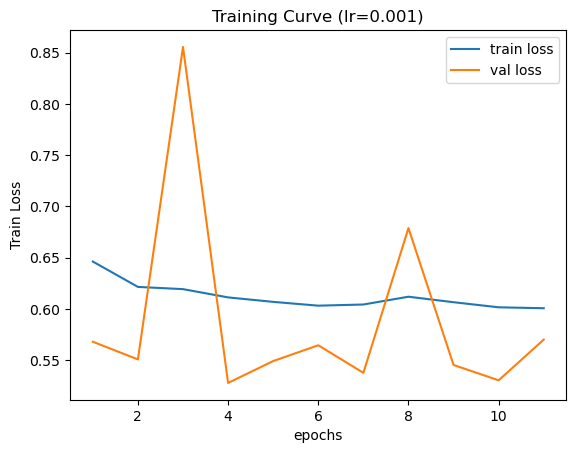

In [16]:
print("Plot of loss with epochs")
plt.plot(range(1, n_trained_epochs+1), train_avg_loss, label="train loss")
plt.plot(range(1, n_trained_epochs+1), val_avg_loss, label="val loss")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train Loss")
plt.legend(loc="best")
plt.show()

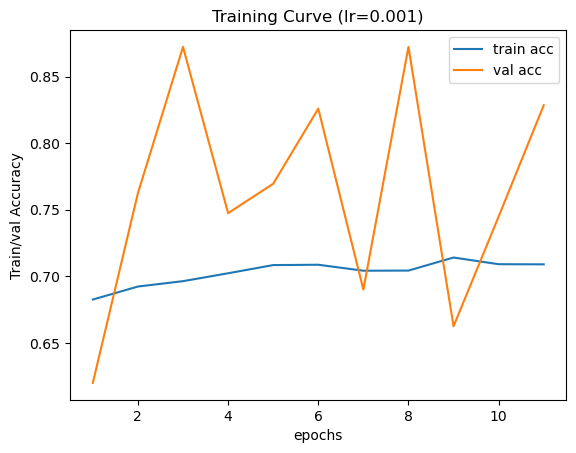

In [17]:
plt.plot(range(1, n_trained_epochs+1), train_avg_acc, label="train acc")
plt.plot(range(1, n_trained_epochs+1), val_avg_acc, label="val acc")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train/val Accuracy")
plt.legend(loc="best")
plt.show()

In [18]:
!ls model-causal-model/

model_4_finetuned--3-epochs-lr_0.001.pth
model_4_finetuned--5-epochs-lr_0.001.pth
model_4_finetuned--6-epochs-lr_0.001.pth


In [19]:
#ls ./model-causal-model/model_3_finetuned-5-epochs-lr_0.001.pth

In [20]:
## saving the model 
# torch.save(model.state_dict(), "finetuned-35-epochs-1e3-lr-with-weighted-loss.pth") # early stopping saves model

### Load the model 
- if train and wants to evaluate: jsut use the `sameModelName`
- if want to laod a specific model - use next cell and write in double quote

In [21]:
# model_name = str(saveModelName)
# print(model_name)

In [22]:
# model_name = early
# model_name = "./model-causal-model/model_4_finetuned--6-epochs-lr_0.001.pth"


In [23]:
# loading the locally saved model

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = CausalityBERT()
# model.load_state_dict(torch.load(model_name))
## Move the model to the GPU 
model.to(device)
model.eval() # gettign in the eval mode 



CausalityBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True

## evaluation on the test dataset 



In [24]:
#loss_fn = CrossEntropyLoss()
test_loss = []
test_acc = []
test_prec = []
test_rec = []
test_f1 = []


for batch in tqdm(test_loader):
    batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
    b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch     # unpack inputs from dataloader

    with torch.no_grad():
        model.eval()
        logits = model(**{"input_ids":b_input_ids, "attention_mask":b_input_mask, "token_type_ids":b_token_type_ids}) # forward pass, calculates logit predictions 
    
    # move logits and labels to CPU
    logits = logits.detach().to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    metrics = compute_metrics(pred_flat, labels_flat)
    test_acc.append(metrics["accuracy"])
    test_prec.append(metrics["precision"])
    test_rec.append(metrics["recall"])
    test_f1.append(metrics["f1"])

    
print(F'\n\ttest loss: {np.mean(test_loss)}')
print(F'\n\ttest acc: {np.mean(test_acc)}')
print(F'\n\ttest prec: {np.mean(test_prec)}')
print(F'\n\ttest rec: {np.mean(test_rec)}')
print(F'\n\ttest f1: {np.mean(test_f1)}')





  0%|          | 0/103 [00:00<?, ?it/s]<ipython-input-8-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
100%|██████████| 103/103 [02:41<00:00,  1.57s/it]


	test loss: nan

	test acc: 0.8112864077669902

	test prec: 0.29946062567421794

	test rec: 0.3449607027276931

	test f1: 0.2984512251502543



/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Print predictions of last test set batch:

In [25]:
# take last batch of test set:

for i in range(len(batch)):
    tokens = tokenizer.convert_ids_to_tokens(b_input_ids[i])
    print("\nPadded Sentence:")
    print(tokens)
    print("prediction:", pred_flat[i])
    


Padded Sentence:
['<s>', '@USER', 'Just', 'say', 'you', 'need', 'them', 'for', 'a', 'diabetic', ':p', 'er@@', 'son@@', '_@@', 'shrugg@@', 'ing', ':', ':', 'medium', 'light@@', '<unk>', 'tone', ':', '\u200d', ':', 'fem@@', '<unk>', 'sign', ':', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
prediction: 0

Padded Sentence:
['<s>', 'I', 'pay', '$', '700', '/', 'quarter', 'for', '1', 'type', 'of', 'insulin', 'and', 'that', 'is', 'after', 'insurance', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'